# Телеком 


## Цель исследования:
Определить факторы, которые влияют на лояльность клиентов. Обучить модель машинного обучения, способную предсказать отток клиентов.

## Ход исследования:
1. Обзор данных. На этом этапе будет проведены обзор и оценка качества данных.
2. Предобработка данных. На данном этапе мы:
    - приведем данные к требуемому формату, 
    - приведем описание колонок к змеиному стилю,
    - создадим дополнительный признак - суммарное количество месяцев пользования услугами,
    - создадим целевой признак - лояльность клиентов(если договор не расторгнут - клиент лоялен),
    - удалим лишние признаки,
    - объединим все татбицы в одну,
    - проверим таблицу на наличие пропусков и дубликатов,
    - удалим customerID(н не потребуется для дальейшего исследования)
    - проверим признаки на мультиколлениарность.
3. Проведение исследовательского анализа: рассмотрим, какие признаки влияют на целевой признак - лояльность клиентов, рассмотрим, какие есть тенденции и закономерности.
4. Определим целевую метрику качества и подготовим данные к обучению. Выделим модели машинного обучения, которые можно использовать для решения задачи классификации.
5. Обучение моделей машинного обучения.
6. Проверка лучшей модели машинного обучения на тестовых данных. Подведение итогов.
7. Общий вывод.


## Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

## Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

In [1]:
!pip install yellowbrick

In [2]:
!pip install pandas-profiling

In [3]:
!pip install phik

In [4]:
!pip install lightgbm

In [5]:
!pip install catboost

In [6]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from yellowbrick.classifier import ClassificationReport
import pandas_profiling
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from datetime import date
import lightgbm as lgb
import random
import phik
from phik.report import correlation_report, plot_correlation_matrix
from phik import report
from lightgbm import LGBMClassifier
from sklearn.metrics import (precision_recall_curve, PrecisionRecallDisplay)
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,roc_auc_score,f1_score,precision_score,recall_score, roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from functools import reduce
import matplotlib.ticker as mtick

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

RANDOM_STATE = 270323

## Ознакомление с данными

In [7]:
contract = pd.read_csv('/Users/yanasklyanchuk/Documents/Проекты IT/финальный проект/contract.csv')
internet = pd.read_csv('/Users/yanasklyanchuk/Documents/Проекты IT/финальный проект/internet.csv')
personal = pd.read_csv('/Users/yanasklyanchuk/Documents/Проекты IT/финальный проект/personal.csv')
phone = pd.read_csv('/Users/yanasklyanchuk/Documents/Проекты IT/финальный проект/phone.csv')

In [9]:
def data_report(initial_data):
    """
   функция выводит: первые 10 строк на экран, информацию о данных методом info, 
   создает расширенный отчет с помощью profile_report
   """
    display(initial_data.head(10))
    display(initial_data.info())
    report = initial_data.profile_report(title='MPG dataset analysis')
    display(report)

**contract**
- customerID - код клиента
- BeginDate - дата начала пользования услугами
- EndDate - дата окончания использования услугами
- Type - тип оплаты: ежемесячный, годовой и т.д.
- PaperlessBilling - электронный платежный документ
- PaymentMethod - способ оплаты
- MonthlyCharges - ежемесячные траты на услуги
- TotalCharges - всего потрачено на услуги


In [10]:
data_report(contract)

customerID   BeginDate              EndDate            Type  \
0  7590-VHVEG  2020-01-01                   No  Month-to-month   
1  5575-GNVDE  2017-04-01                   No        One year   
2  3668-QPYBK  2019-10-01  2019-12-01 00:00:00  Month-to-month   
3  7795-CFOCW  2016-05-01                   No        One year   
4  9237-HQITU  2019-09-01  2019-11-01 00:00:00  Month-to-month   
5  9305-CDSKC  2019-03-01  2019-11-01 00:00:00  Month-to-month   
6  1452-KIOVK  2018-04-01                   No  Month-to-month   
7  6713-OKOMC  2019-04-01                   No  Month-to-month   
8  7892-POOKP  2017-07-01  2019-11-01 00:00:00  Month-to-month   
9  6388-TABGU  2014-12-01                   No        One year   

  PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges  
0              Yes           Electronic check           29.85        29.85  
1               No               Mailed check           56.95       1889.5  
2              Yes               Mailed check           53.85       108.15  
3               No  Bank transfer (automatic)           42.30      1840.75  
4              Yes           Electronic check           70.70       151.65  
5              Yes           Electronic check           99.65        820.5  
6              Yes    Credit card (automatic)           89.10       1949.4  
7               No               Mailed check           29.75        301.9  
8              Yes           Electronic check          104.80      3046.05  
9               No  Bank transfer (automatic)           56.15      3487.95

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]


**internet**
- customerID - код клиента
- InternetService- подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line, «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).
- OnlineSecurity - блокировка небезопасных сайтов
- OnlineBackup - облачное хранилище файлов для резервного копирования данных
- DeviceProtection - интернет-безопасность: антивирус
- TechSupport - выделенная линия технической поддержки
- StreamingTV - стриминговое телевидение
- StreamingMovies - каталог фильмов


In [11]:
data_report(internet)

customerID InternetService OnlineSecurity OnlineBackup DeviceProtection  \
0  7590-VHVEG             DSL             No          Yes               No   
1  5575-GNVDE             DSL            Yes           No              Yes   
2  3668-QPYBK             DSL            Yes          Yes               No   
3  7795-CFOCW             DSL            Yes           No              Yes   
4  9237-HQITU     Fiber optic             No           No               No   
5  9305-CDSKC     Fiber optic             No           No              Yes   
6  1452-KIOVK     Fiber optic             No          Yes               No   
7  6713-OKOMC             DSL            Yes           No               No   
8  7892-POOKP     Fiber optic             No           No              Yes   
9  6388-TABGU             DSL            Yes          Yes               No   

  TechSupport StreamingTV StreamingMovies  
0          No          No              No  
1          No          No              No  
2          No          No              No  
3         Yes          No              No  
4          No          No              No  
5          No         Yes             Yes  
6          No         Yes              No  
7          No          No              No  
8         Yes         Yes             Yes  
9          No          No              No

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

**personal**
- customerID - код клиента
- gender - пол клиента
- SeniorCitizen - наличие пенсионного статуса по возрасту
- Partner - наличие супруга/супруги
- Dependents - наличие иждивенцев


In [12]:
data_report(personal)

customerID  gender  SeniorCitizen Partner Dependents
0  7590-VHVEG  Female              0     Yes         No
1  5575-GNVDE    Male              0      No         No
2  3668-QPYBK    Male              0      No         No
3  7795-CFOCW    Male              0      No         No
4  9237-HQITU  Female              0      No         No
5  9305-CDSKC  Female              0      No         No
6  1452-KIOVK    Male              0      No        Yes
7  6713-OKOMC  Female              0      No         No
8  7892-POOKP  Female              0     Yes         No
9  6388-TABGU    Male              0      No        Yes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

**phone**
- customerID - код клиента
- MultipleLines - наличие возможности ведения параллельных линий во время звонка

In [13]:
data_report(phone)

customerID MultipleLines
0  5575-GNVDE            No
1  3668-QPYBK            No
2  9237-HQITU            No
3  9305-CDSKC           Yes
4  1452-KIOVK           Yes
5  7892-POOKP           Yes
6  6388-TABGU            No
7  9763-GRSKD            No
8  7469-LKBCI            No
9  8091-TTVAX           Yes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Итоги ознакомления с данными

###  таблица - "Contract"
В данной таблице мы видим 7043 наблюдения и 8 признаков(6 категориальных, 1 булевый, 1 числовой).

Отсутствуют пропуски и дубликаты. Все значения customerID - уникальные.
Видим, что самый популярный тип оплаты -  ежемесячный; чаще всего пользователи предпочитают электронный платежный документ;  чаще всего пользователи предпочитают электронный платеж - как способ оплаты, cfvjt ,самое большое количество платежей в месяц - до 20$. 

Необходимо 
1. изменить типы данных: BeginDate,EndDatе  из object в datetime64; TotalCharges из object в float64.
2. BeginDate - дата начала пользования услугами так как нет повторения в столбце customerID, то предполагае, что договара на оказание услуг продлеваются и по этому, BeginDate содержит значения начиная с 2014 по 2020г. Значения данного столбца можно использовать, чтобы посчитать суммарное количество месяцев пользования услугами. Создадим дополнительный признак.
3. Колонки оформим в змеином стиле для удобства пользования.
4. EndDatе содержит информацию о расторжении договора, если договор был расторгнут. Данные из этого столбца будем использовать как для подсчета суммарного количества месяцев пользования услугами, так и для формирования целевого признака - лояльности клиентов. Лояльность клиентов - это категориальный признак и уже сейчас понятно, что будет дисбаланс классов(73,5% пользователей не аннулировало договор).

In [14]:
contract_list = ['Type', 'PaperlessBilling', 'PaymentMethod']

In [15]:
def sign_histplot(sign_list, data):
    '''Функция принимает на вход список признаков и наименование датасета
       отображает графики распределения признаков'''
    for i in sign_list:
        plt.figure(figsize=(15,5))
        sns.histplot(data=data,x=i, multiple="dodge", shrink=.9)
        plt.ylabel('Количество')
        plt.xlabel(i)
        plt.title(f'Распределение признака {i}')
        plt.show()

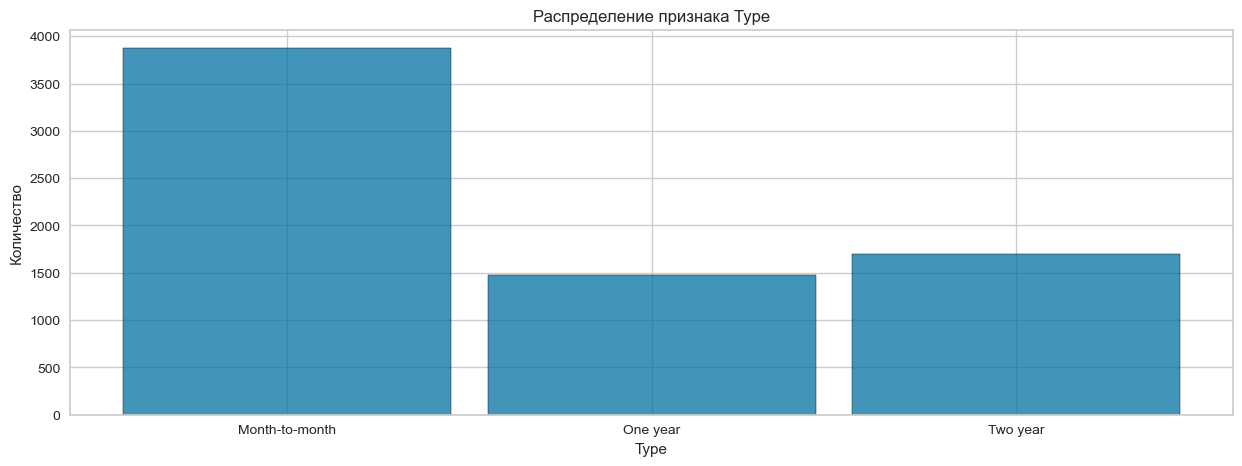

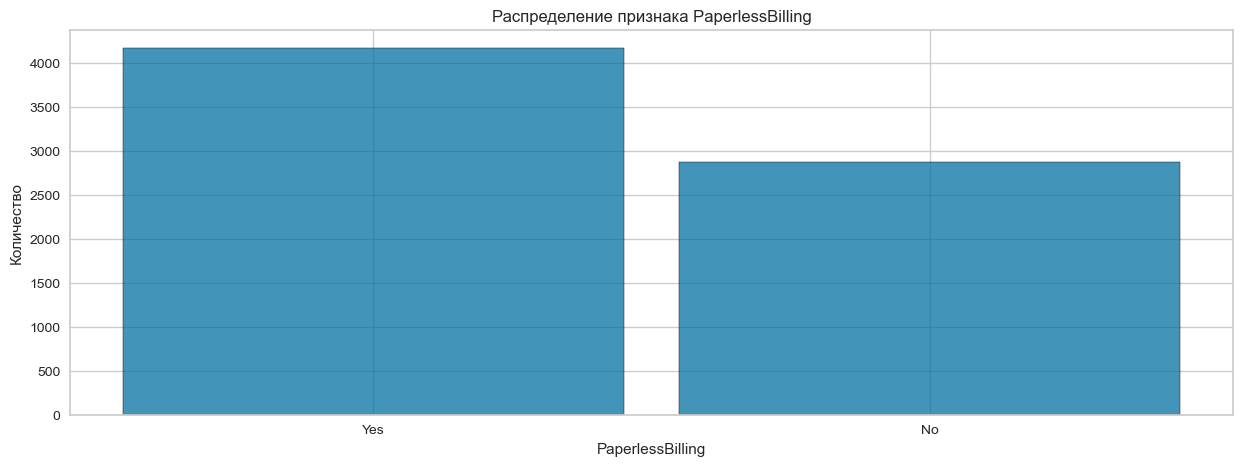

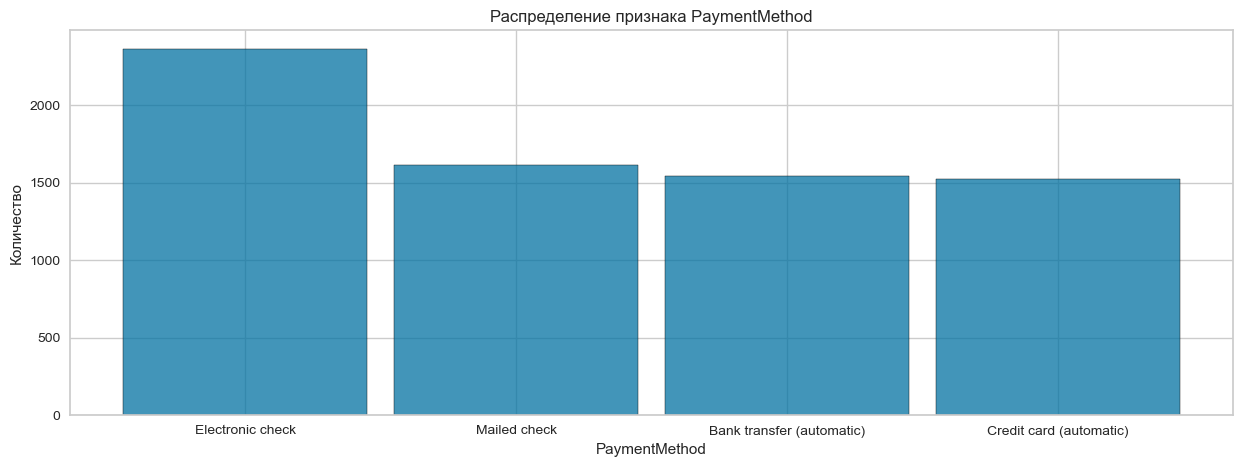

In [16]:
sign_histplot(contract_list, contract)

###  таблица - "internet"
В данной таблице мы видим 5517 наблюдений и 8 признаков(2 категориальных, 6 булевых).

Отсутствуют пропуски и дубликаты. Все значения customerID - уникальные.

Видим, что ,более популярно оптоволокно среди пользователей интернета; чаще  пользователи отказываются от блокировки небезопасных сайтов; чаще  пользователи отказываются от облачных хранилищ файлов для резервного копирования данных, чаще  пользователи отказываются от  антивирусов, чаще  пользователи отказываются от выделенной линии технической поддержки, пользователи не отдают предпочтений в  использовании стримингового телевидения и каталогов фильмов.

Необходимо 
1. Колонки оформим в змеином стиле для удобства пользования.
2. При объединении учесть, что всего 5517 клиентов пользуются итернетом и следует отразить, что оставшиеся пользователи не пользуются интернетом.


In [17]:
int_list = ['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
            'TechSupport', 'StreamingTV','StreamingMovies']

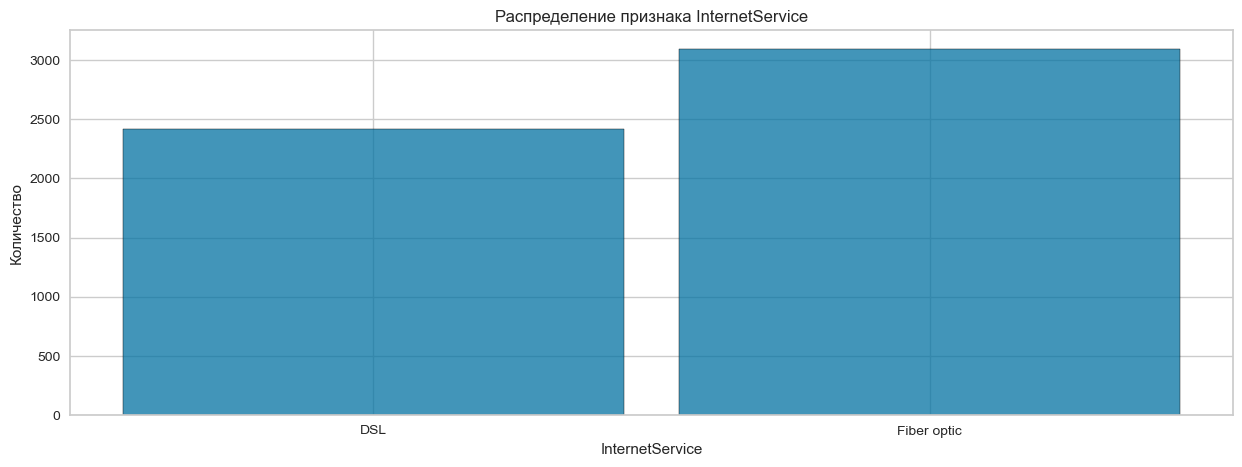

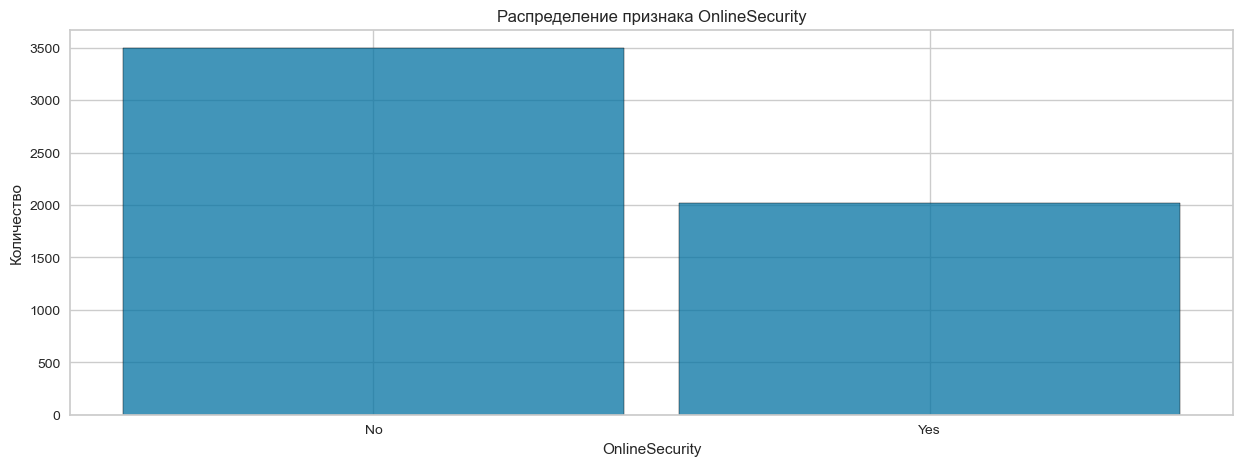

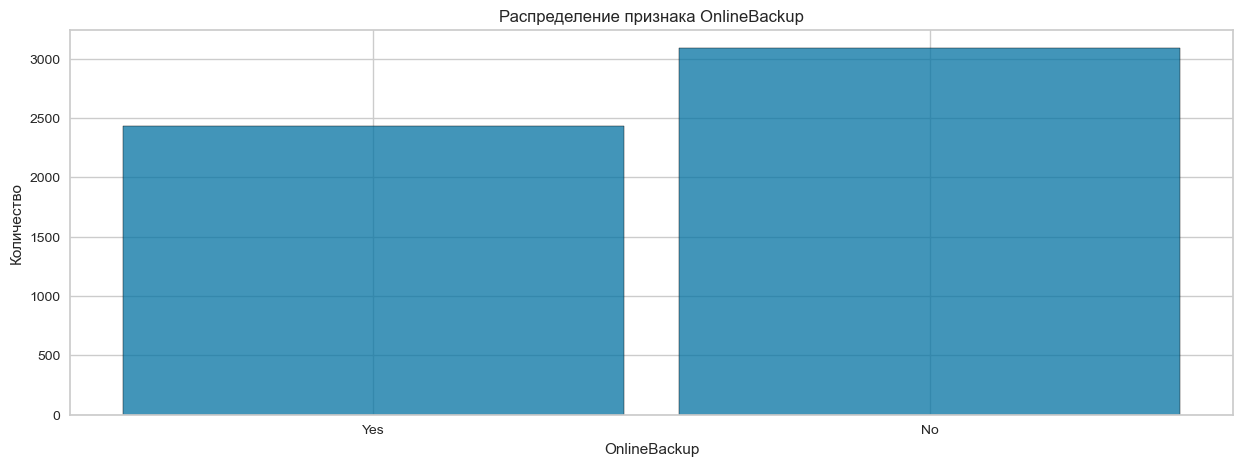

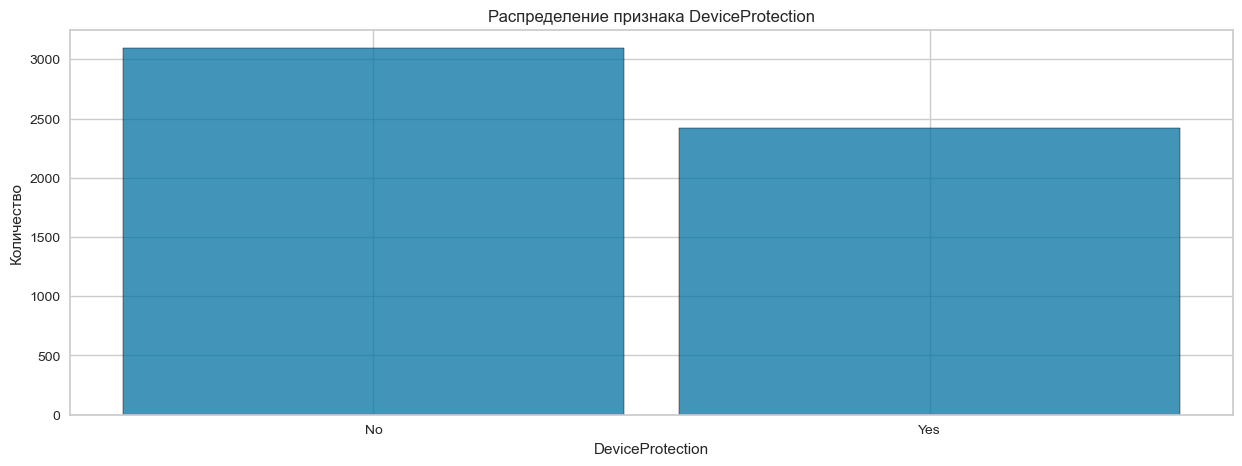

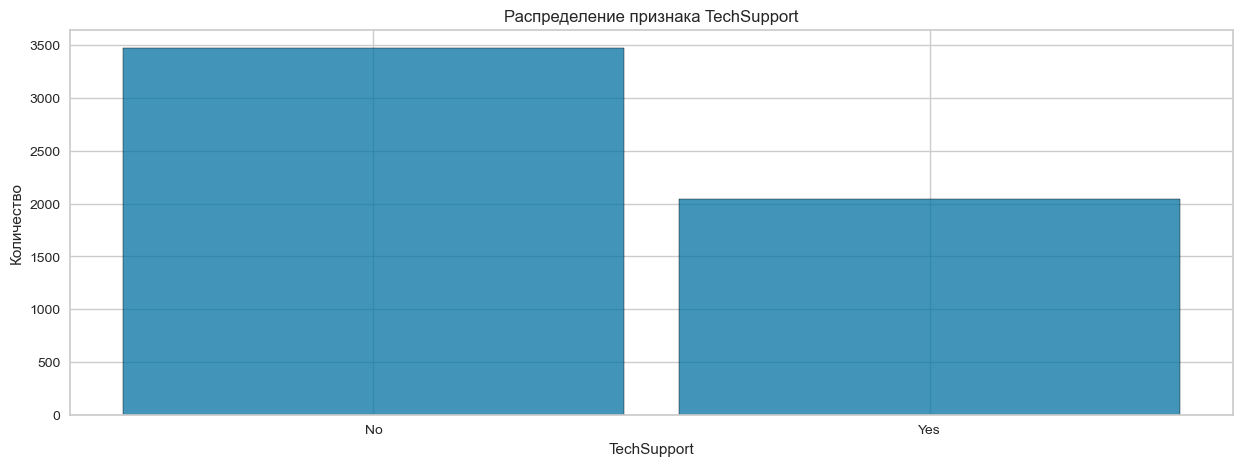

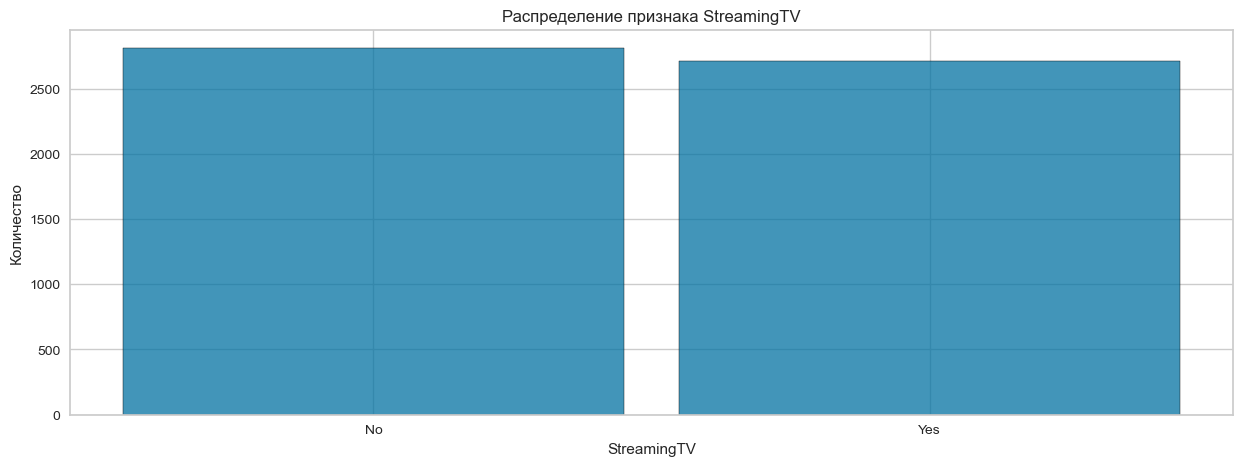

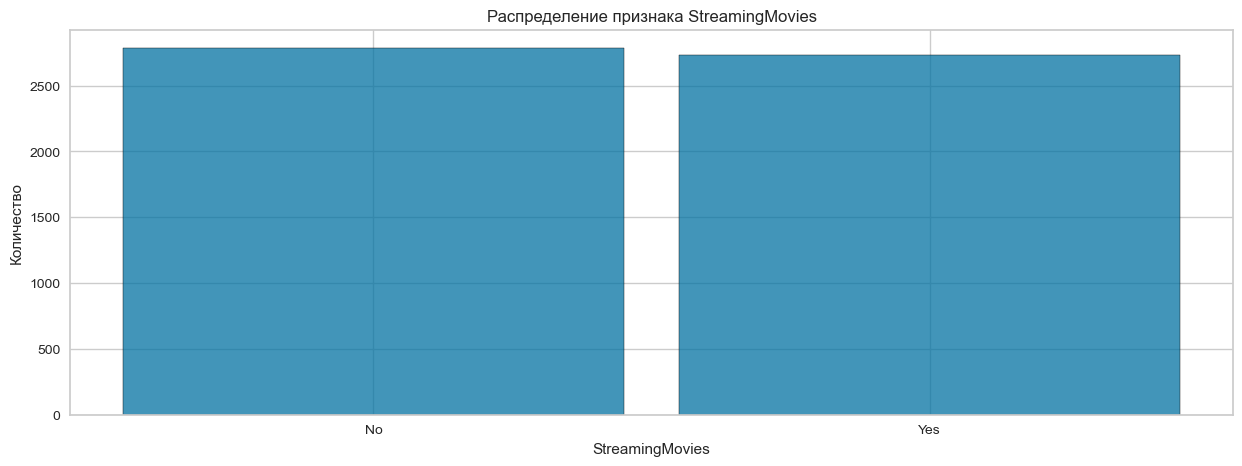

In [18]:
sign_histplot(int_list, internet)

###   таблица - "personal"
В данной таблице мы видим 7043 наблюдения и 5 признаков(3 категориальных, 2 булевых).

Отсутствуют пропуски и дубликаты. Все значения customerID - уникальные.

Видим, что в равной степени мужчины и женщины заключают договора; чаще  пользователи не являются пенсионного возраста; чаще  пользователи состоят в браке, чаще  у пользователей нет иждивенцев.

Необходимо 
1. Колонки оформим в змеином стиле для удобства пользования.

In [19]:
personal_list = ['gender', 'SeniorCitizen', 'Partner', 'Dependents']

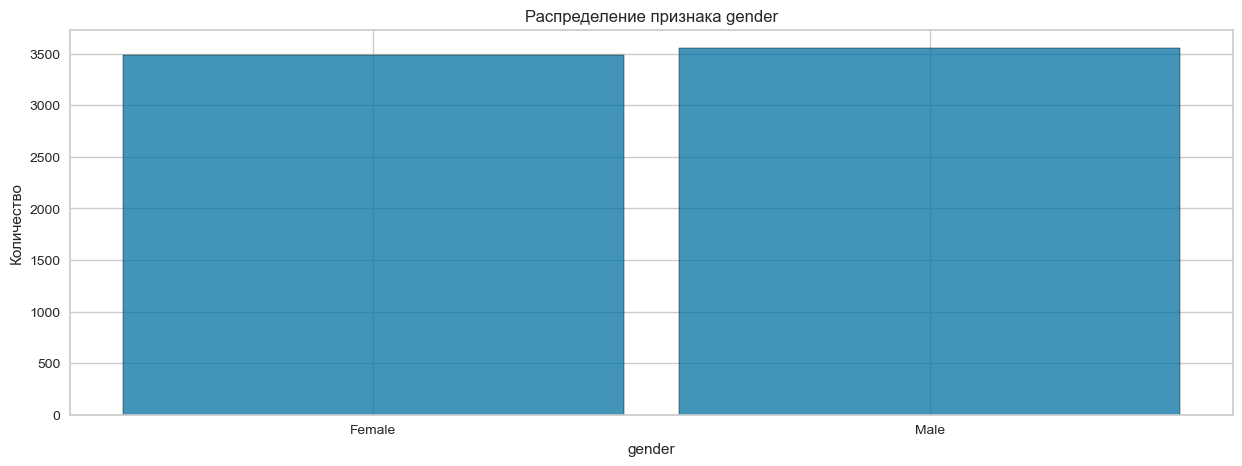

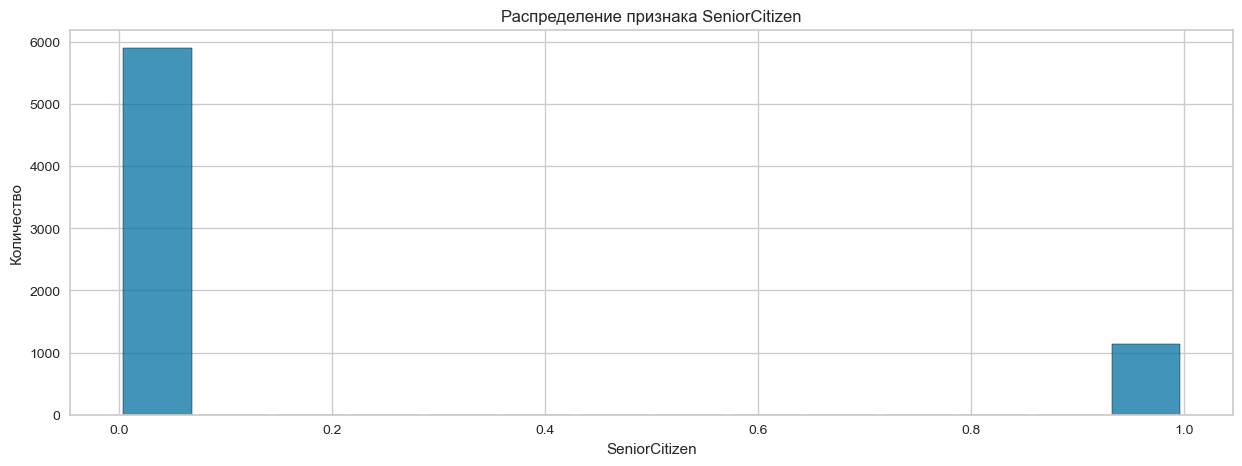

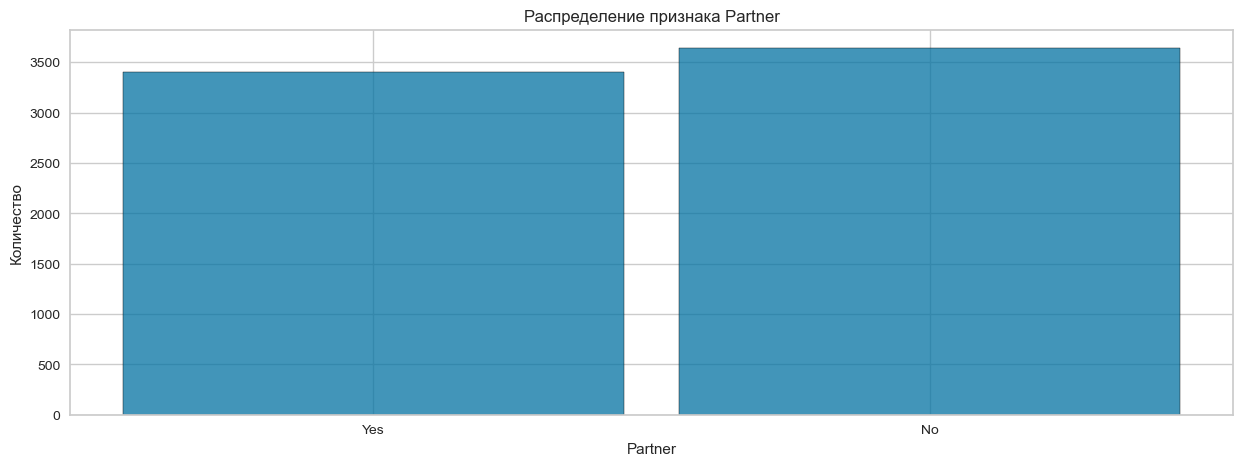

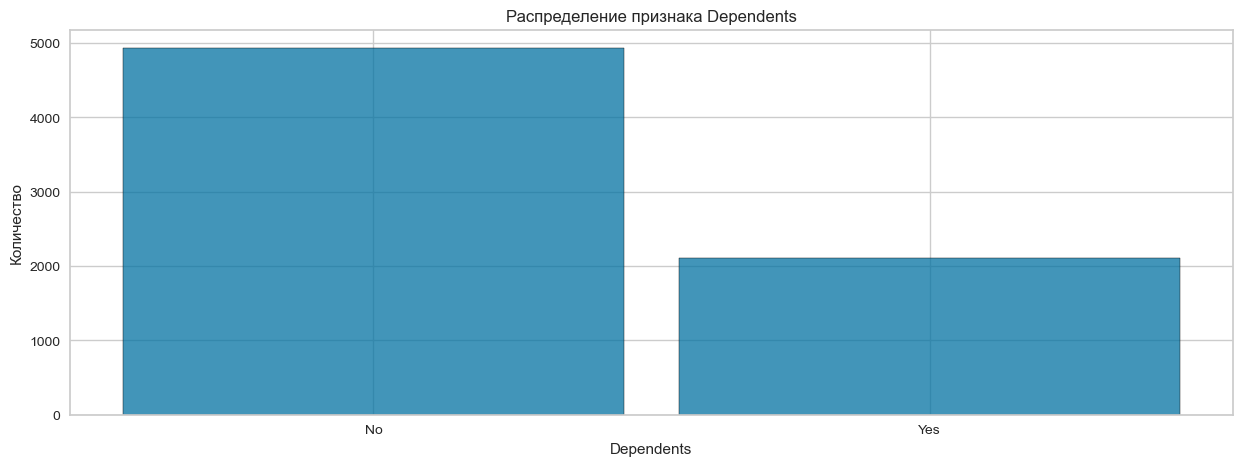

In [20]:
sign_histplot(personal_list, personal)

###   таблица - "phone"
В данной таблице мы видим 6361 наблюдение и 2 признаков(1 категориальный, 1 булевый).

Отсутствуют пропуски и дубликаты. Все значения customerID - уникальные.

Видим, что наличие возможности ведения параллельных линий во время звонка чаще не используется клиентами.

Необходимо 
1. Колонки оформим в змеином стиле для удобства пользования.
2. При объединении учесть, что всего 6361 клиентов пользуются телефоном и следует отразить, что оставшиеся пользователи не пользуются телефоном.

In [21]:
phone_list = ['MultipleLines']

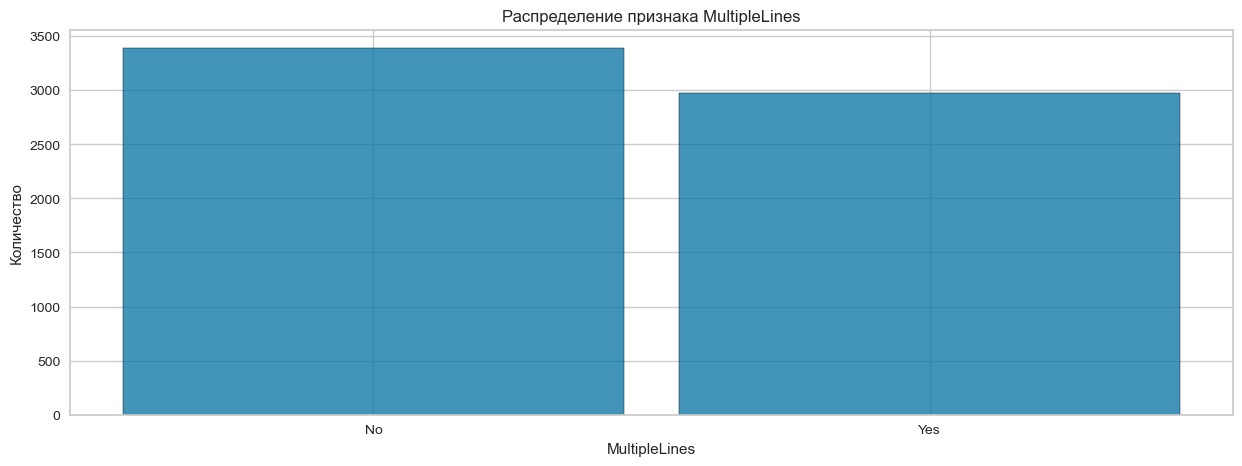

In [22]:
sign_histplot(phone_list, phone)

Далее будет проведена
1. Предобработка данных:
    - приведем данные к требуемому формату, 
    - приведем описание колонок к змеиному стилю,
    - создадим дополнительный признак - суммарное количество месяцев пользования услугами,
    - создадим целевой признак - лояльность клиентов(если договор не расторгнут - клиент лоялен),
    - удалим лишние признаки,
    - объединим все татбицы в одну,
    - проверим таблицу на наличие пропусков и дубликатов,
    - удалим customerID(н не потребуется для дальейшего исследования)
    - проверим признаки на мультиколлениарность.

## Предобработка данных
### Преобразования стиля колонок
Создадим функцию, которая преобразует стиль для всех таблиц.

In [23]:
def snake_style(x):
    '''функция предобразует верблюжий стиль наименования колонок в змеиный
    '''
    x.columns = (x.columns.str.replace('(?<=[a-z])(?=[A-Z])', '_', regex=True).str.lower())
    print(x.columns)

In [24]:
snake_style(contract)

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges'],
      dtype='object')


In [25]:
snake_style(internet)

Index(['customer_id', 'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies'],
      dtype='object')


In [26]:
snake_style(personal)

Index(['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents'], dtype='object')


In [27]:
snake_style(phone)

Index(['customer_id', 'multiple_lines'], dtype='object')


Преобразован стиль описания колонок успешно для всех таблиц.

### Изменение формата данных
Изменим формат данных в колонках 'begin_date', 'end_date' таблицы contract на формат datetime64. Предварительно заменим значение
'No' в столбце 'end_date' на  последнюю дату актуализации данных - 1 февраля 2020.

In [28]:
contract.end_date = contract.end_date.replace(to_replace=['No'], value=['2020-02-01'])

In [29]:
contract.begin_date = contract.begin_date.astype('datetime64')
contract.end_date = contract.end_date.astype('datetime64')

Рассмотрим колонку 'total_charges' преобразуем в числовой тип данных.

In [30]:
# проверка типов данных всех столбцов
contract.dtypes

customer_id                  object
begin_date           datetime64[ns]
end_date             datetime64[ns]
type                         object
paperless_billing            object
payment_method               object
monthly_charges             float64
total_charges                object
dtype: object

Рассмотрим колонку senior_citizen из таблицы personal. Преобразуем тип данных из 'int64' в 'object'.

In [31]:
personal['senior_citizen'] = personal['senior_citizen'].astype('object')

In [32]:
# проверка типов данных всех столбцов
personal.dtypes

customer_id       object
gender            object
senior_citizen    object
partner           object
dependents        object
dtype: object

Формат данных изменен успешно в таблице contract. Изменение типа данных в других таблицах не требуется.

### Создание дополнительного признака: суммарное количество дней пользования услугами
Вычислим, сколько сумарно дней клиенты пользуются услугами.

In [33]:
contract['day_sum']=(contract['end_date']-contract['begin_date'])/np.timedelta64(1,'D')

In [34]:
# проверяем наличие признака
contract.head(3)

customer_id begin_date   end_date            type paperless_billing  \
0  7590-VHVEG 2020-01-01 2020-02-01  Month-to-month               Yes   
1  5575-GNVDE 2017-04-01 2020-02-01        One year                No   
2  3668-QPYBK 2019-10-01 2019-12-01  Month-to-month               Yes   

     payment_method  monthly_charges total_charges  day_sum  
0  Electronic check            29.85         29.85     31.0  
1      Mailed check            56.95        1889.5   1036.0  
2      Mailed check            53.85        108.15     61.0

Создан новый признак 'months_sum'.

### Целевой признак - лояльность клиентов
На основании данных в столбце 'end_date' созддим целевой признак - 'loyalty'.  Будем считать, если договор не расторгнут с клиентом, значит клиент лоялен.

In [35]:
contract['loyalty'] = 0
contract.loc[contract['end_date'] == '2020-02-01', 'loyalty'] = 1

In [36]:
# проверяем наличие целевого признака
contract.head(3)

customer_id begin_date   end_date            type paperless_billing  \
0  7590-VHVEG 2020-01-01 2020-02-01  Month-to-month               Yes   
1  5575-GNVDE 2017-04-01 2020-02-01        One year                No   
2  3668-QPYBK 2019-10-01 2019-12-01  Month-to-month               Yes   

     payment_method  monthly_charges total_charges  day_sum  loyalty  
0  Electronic check            29.85         29.85     31.0        1  
1      Mailed check            56.95        1889.5   1036.0        1  
2      Mailed check            53.85        108.15     61.0        0

Создан целевой признак 'loyalty'.

### Удаление лишних признаков
При создании признаков 'months_sum' и 'loyalty' образовались лишние признаки и стало возможным удалить признаки, которые больше не потребуются для дальнейшей работы.

In [37]:
contract = contract.drop(['begin_date','end_date'], axis=1)

In [38]:
# проверяем наличие необходимых для работы признаков
contract.head(3)

customer_id            type paperless_billing    payment_method  \
0  7590-VHVEG  Month-to-month               Yes  Electronic check   
1  5575-GNVDE        One year                No      Mailed check   
2  3668-QPYBK  Month-to-month               Yes      Mailed check   

   monthly_charges total_charges  day_sum  loyalty  
0            29.85         29.85     31.0        1  
1            56.95        1889.5   1036.0        1  
2            53.85        108.15     61.0        0

Удалены лишние признаки из таблицы contract.

### Объединение таблиц
Объединение таблиц проведем по общему признаку для всех колонок - 'customer_id'.

In [39]:
data = contract.merge(personal, on='customer_id', how='left')
data = data.merge(phone, on='customer_id', how='left')
data = data.merge(internet, on='customer_id', how='left')

In [40]:
# проверка наличия объединенной таблицы
data.head()

customer_id            type paperless_billing             payment_method  \
0  7590-VHVEG  Month-to-month               Yes           Electronic check   
1  5575-GNVDE        One year                No               Mailed check   
2  3668-QPYBK  Month-to-month               Yes               Mailed check   
3  7795-CFOCW        One year                No  Bank transfer (automatic)   
4  9237-HQITU  Month-to-month               Yes           Electronic check   

   monthly_charges total_charges  day_sum  loyalty  gender senior_citizen  \
0            29.85         29.85     31.0        1  Female              0   
1            56.95        1889.5   1036.0        1    Male              0   
2            53.85        108.15     61.0        0    Male              0   
3            42.30       1840.75   1371.0        1    Male              0   
4            70.70        151.65     61.0        0  Female              0   

  partner dependents multiple_lines internet_service online_security  \
0     Yes         No            NaN              DSL              No   
1      No         No             No              DSL             Yes   
2      No         No             No              DSL             Yes   
3      No         No            NaN              DSL             Yes   
4      No         No             No      Fiber optic              No   

  online_backup device_protection tech_support streaming_tv streaming_movies  
0           Yes                No           No           No               No  
1            No               Yes           No           No               No  
2           Yes                No           No           No               No  
3            No               Yes          Yes           No               No  
4            No                No           No           No               No

In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   type               7043 non-null   object 
 2   paperless_billing  7043 non-null   object 
 3   payment_method     7043 non-null   object 
 4   monthly_charges    7043 non-null   float64
 5   total_charges      7043 non-null   object 
 6   day_sum            7043 non-null   float64
 7   loyalty            7043 non-null   int64  
 8   gender             7043 non-null   object 
 9   senior_citizen     7043 non-null   object 
 10  partner            7043 non-null   object 
 11  dependents         7043 non-null   object 
 12  multiple_lines     6361 non-null   object 
 13  internet_service   5517 non-null   object 
 14  online_security    5517 non-null   object 
 15  online_backup      5517 non-null   object 
 16  device_protection  5517 

Видим, что таблица создана. Присутствуют пропуски в данных с которыми будем работать далее.

### Проверка данных на попуски и дубликаты
Проанализируем пропуски в данных.

In [42]:
pd.DataFrame(round(data.isna().mean()*100,2)).style.background_gradient('coolwarm')

Видим, что у нас в 8 признаках присутствуют пропущенные значения. При анализе таблиц мы выявили, что не все пользователи подключали интернет-услуги и для пропусков связанных с этим фактом мы укажем 'No internet service'. Для пользователей, которые не использовали возможность ведения параллельных линий во время звонка укажем 'No phone service'. 

Пропуски в столбце 'total_charges' составляют 0.16% - это незначительное количество данных и мы их удалим.

In [43]:
data[['internet_service', 
      'online_security', 
      'online_backup', 
      'device_protection', 
      'tech_support', 
      'streaming_tv', 
      'streaming_movies']] = data[['internet_service', 
                                   'online_security', 
                                   'online_backup', 
                                   'device_protection', 
                                   'tech_support', 
                                   'streaming_tv', 
                                   'streaming_movies']]. fillna (value= 'No internet service' )

In [44]:
data['multiple_lines'] = data['multiple_lines']. fillna (value='No phone service')

In [45]:
# проверим наличие пропусков
pd.DataFrame(round(data.isna().mean()*100,2)).style.background_gradient('coolwarm')

Нет пропусков в итоговых данных.

Проверим наличие дубликатов.

In [46]:
sum(data.duplicated())

0

Дубликаты отсутствуют.

### Удаление столбца 'customer_id'
Больше нам не потребуется столбец 'customer_id'.

In [47]:
data = data.drop(columns = ['customer_id'],axis = 1)

Столбец 'customer_id' удален.

### Проверка признаков на мультиколлениарность

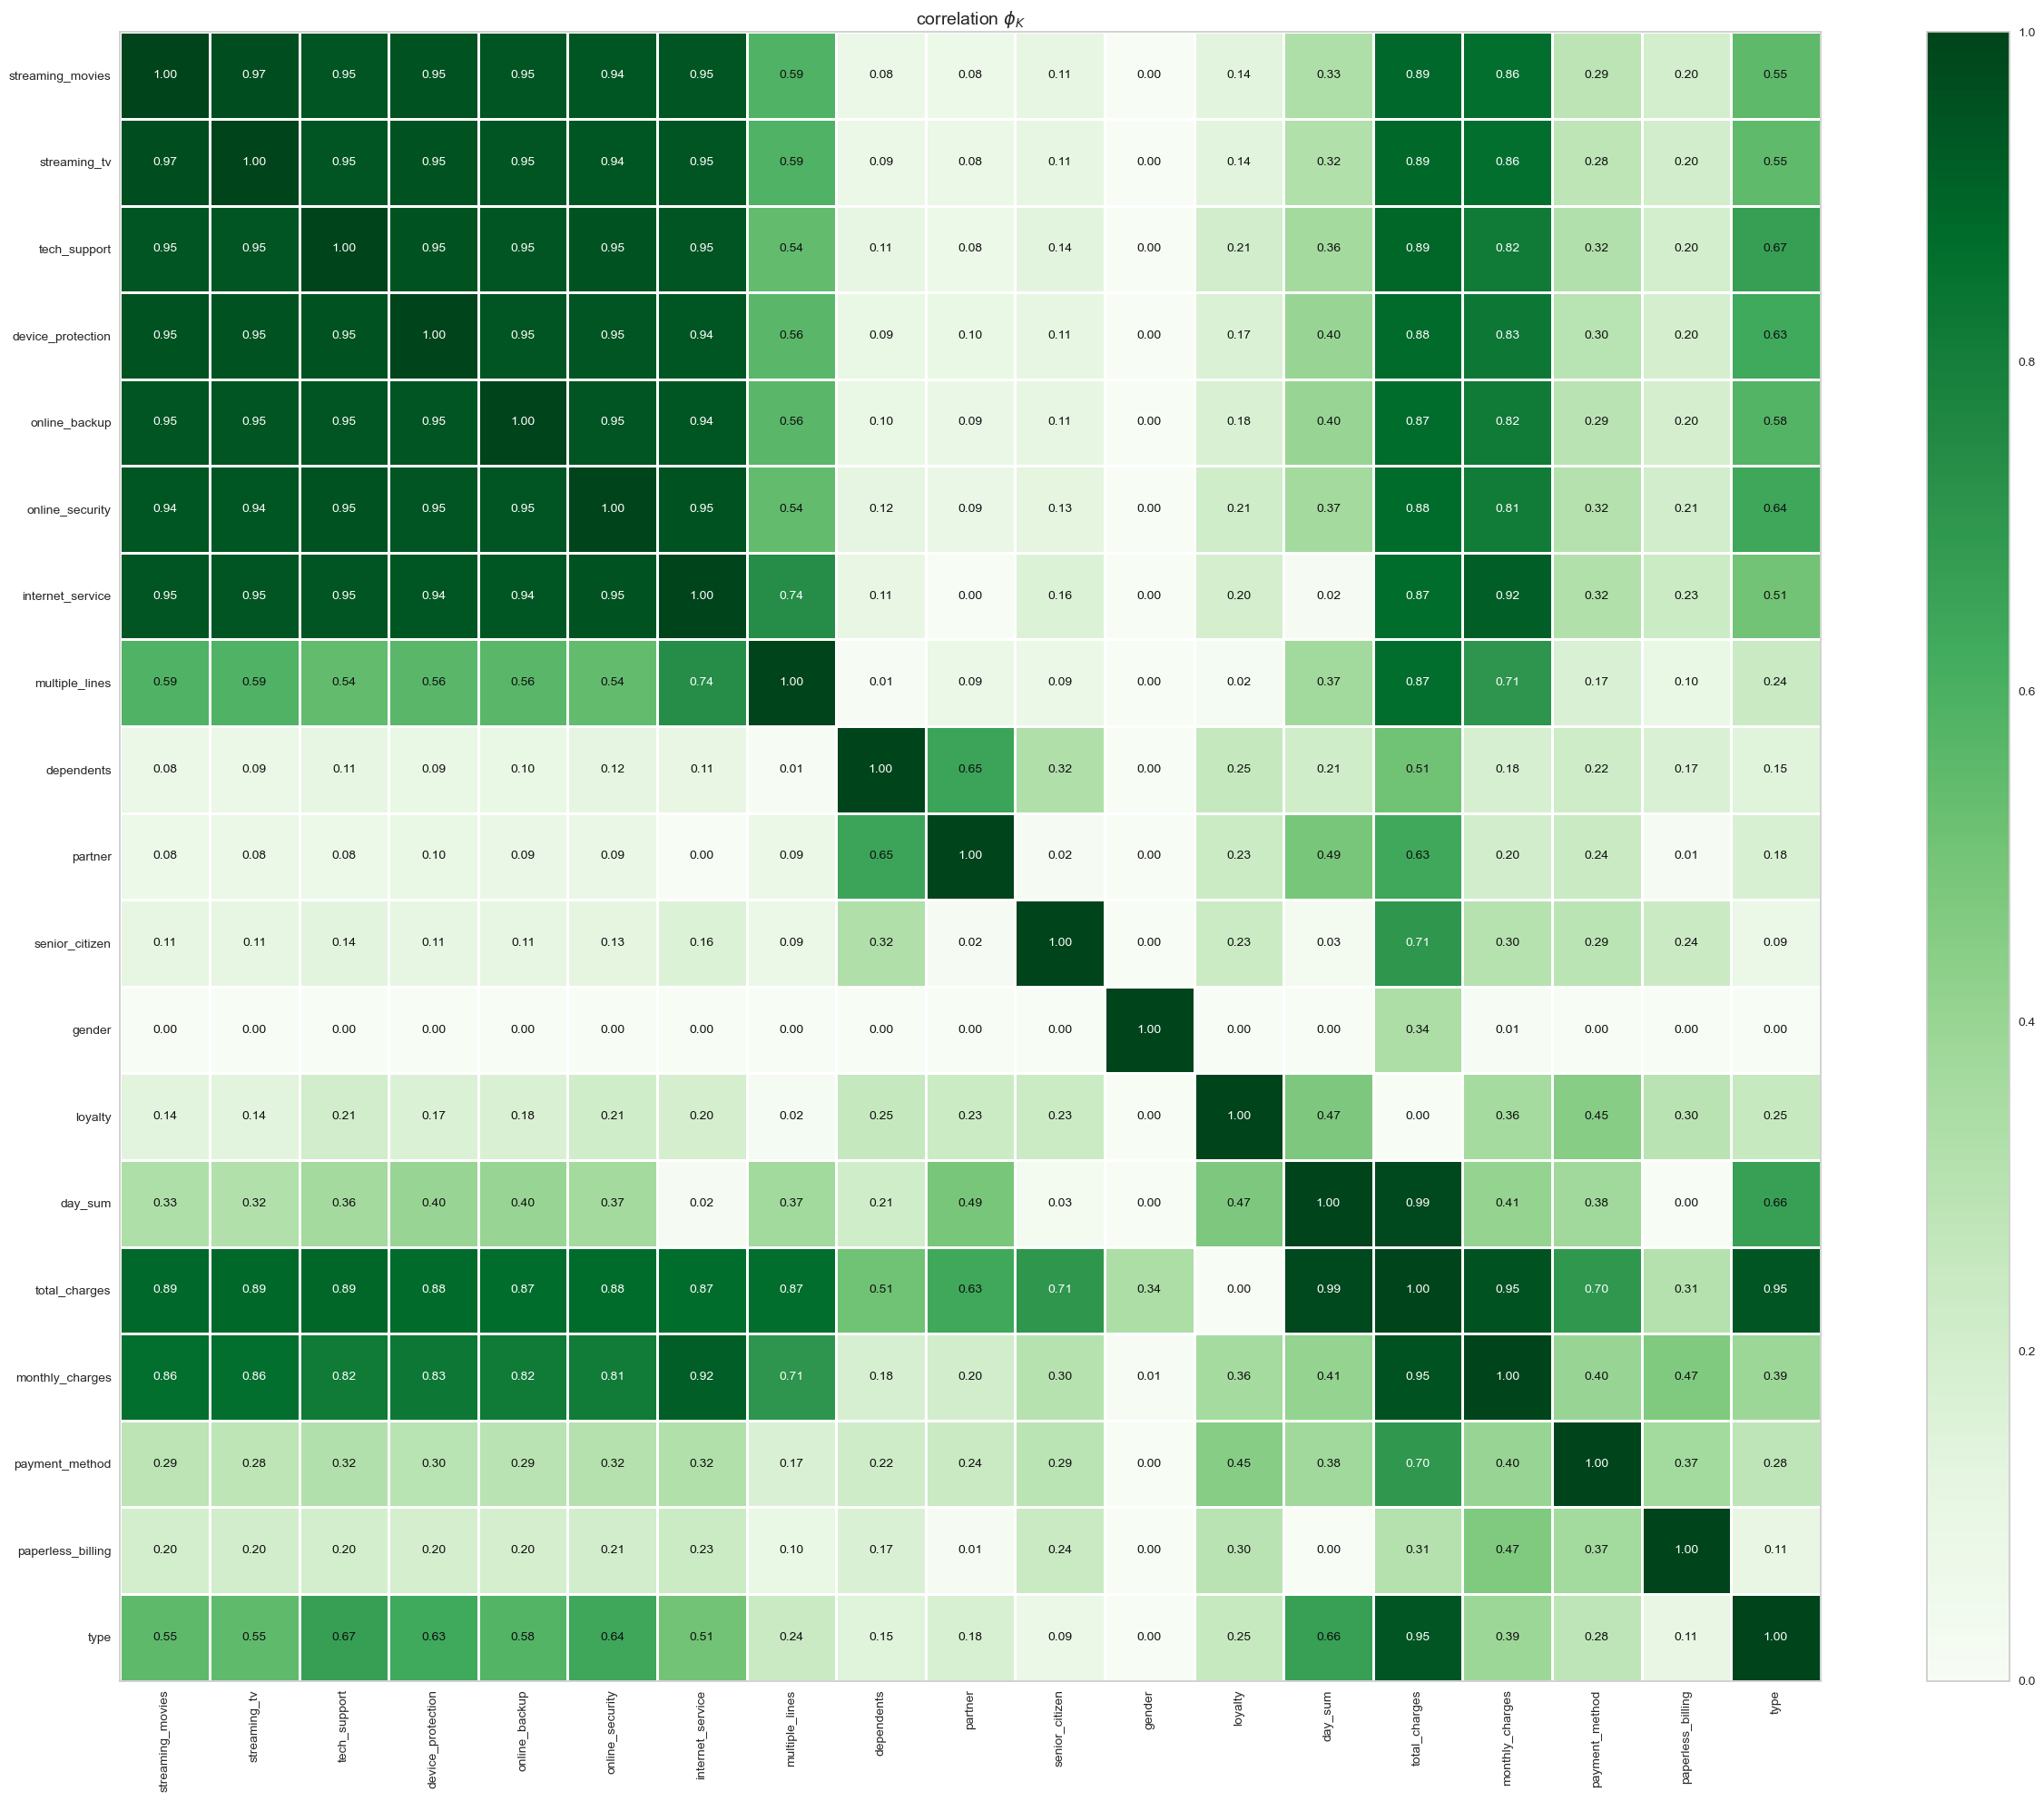

In [48]:
interval_cols = data.select_dtypes('number').columns.tolist()
phik_overview = data.phik_matrix(interval_cols=interval_cols)
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1, 
                        figsize=(25, 20))
plt.tight_layout()

Видим высокую корреляцию столбца monthly_charges и total_charges. Оставим признак monthly_charges.

Видим, что 'gender' практически не влияет на целевой признак. Удалим его.

In [49]:
data = data.drop(['total_charges','gender'], axis = 1)
data.head()

type paperless_billing             payment_method  \
0  Month-to-month               Yes           Electronic check   
1        One year                No               Mailed check   
2  Month-to-month               Yes               Mailed check   
3        One year                No  Bank transfer (automatic)   
4  Month-to-month               Yes           Electronic check   

   monthly_charges  day_sum  loyalty senior_citizen partner dependents  \
0            29.85     31.0        1              0     Yes         No   
1            56.95   1036.0        1              0      No         No   
2            53.85     61.0        0              0      No         No   
3            42.30   1371.0        1              0      No         No   
4            70.70     61.0        0              0      No         No   

     multiple_lines internet_service online_security online_backup  \
0  No phone service              DSL              No           Yes   
1                No              DSL             Yes            No   
2                No              DSL             Yes           Yes   
3  No phone service              DSL             Yes            No   
4                No      Fiber optic              No            No   

  device_protection tech_support streaming_tv streaming_movies  
0                No           No           No               No  
1               Yes           No           No               No  
2                No           No           No               No  
3               Yes          Yes           No               No  
4                No           No           No               No

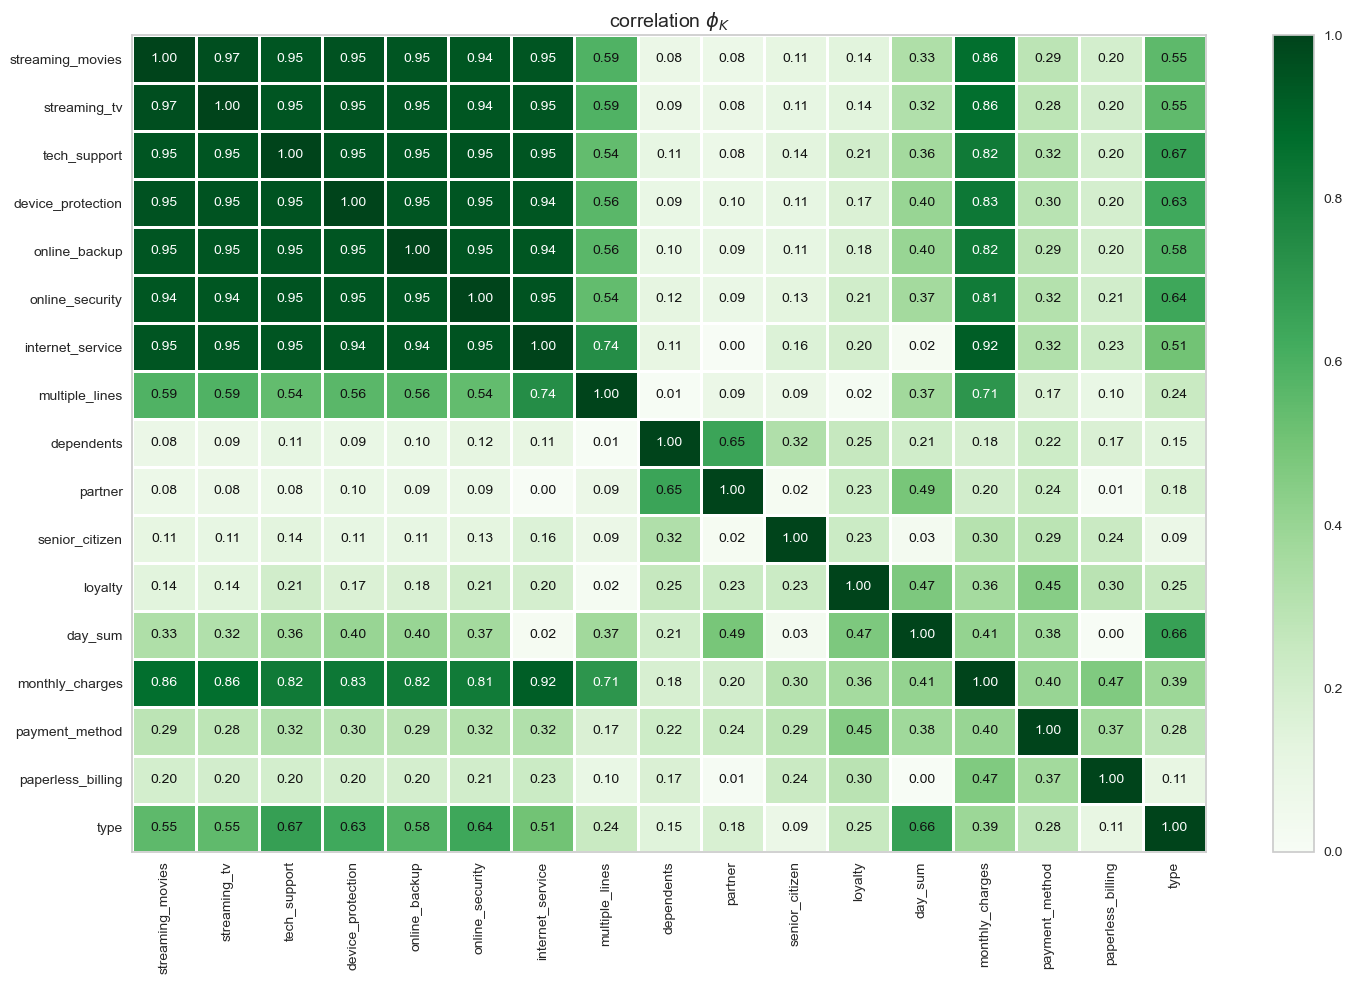

In [50]:
interval_cols = data.select_dtypes('number').columns.tolist()
phik_overview = data.phik_matrix(interval_cols=interval_cols)
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1, 
                        figsize=(15, 10))
plt.tight_layout()

С данным набором признаков можно работать дальше.

## Итоги предобработки данных
В результате предобработки данных мы:
1. преобразовали стиль описания колонок. Использован змеиный стиль;
2. изменили тип данных в колонках: 'end_date', 'begin_date' на datetime64, 'total_charges' на числовой тип данных.
3. создали дополнительный признак - суммарное количество дней пользования услугами 'day_sum';
4. на основании данных в столбце 'end_date' определили целевой признак - лояльность клиентов - 'loyalty'. Если договор с клиентом не расторгнут, на момент даты последней актуализации данных, значит клиент лоялен;
5. удалили признаки, которые больше не потребуются для дальнейшей работы: признаки образовавшиеся при создании признаков 'months_sum' и 'loyalty';
6. все таблицы данных были объединены по общему признаку для всех колонок - 'customer_id';
7. были выявлены пропуски в данных. Для пропусков, которые образовались из-за того,что не все пользователи подключали интернет-услуги мы указали 'No internet service'. Для пропусков, которые  образовались из-за того,что не все пользователи подключили возможность ведения параллельных линий во время звонка указали  -  'No phone service'. Проверка на наличие дубликатов показала отсутствие дубликатов;
8. удалили признак 'customer_id', так как он больше не потребуется для дальнейшей работы;
9. проверка на мультиколлениарность показала, высокую корреляцию столбца monthly_charges и total_charges. Оставили признак monthly_charges. Признак 'gender' практически не влиял на целевой признак и принято было решение удалить его.

Предобработка данных завершена далее будет выполнен исследовательский анализ: рассмотрим, какие признаки влияют на целевой признак - лояльность клиентов, рассмотрим, какие есть тенденции и закономерности.

In [51]:
data.head(10)

type paperless_billing             payment_method  \
0  Month-to-month               Yes           Electronic check   
1        One year                No               Mailed check   
2  Month-to-month               Yes               Mailed check   
3        One year                No  Bank transfer (automatic)   
4  Month-to-month               Yes           Electronic check   
5  Month-to-month               Yes           Electronic check   
6  Month-to-month               Yes    Credit card (automatic)   
7  Month-to-month                No               Mailed check   
8  Month-to-month               Yes           Electronic check   
9        One year                No  Bank transfer (automatic)   

   monthly_charges  day_sum  loyalty senior_citizen partner dependents  \
0            29.85     31.0        1              0     Yes         No   
1            56.95   1036.0        1              0      No         No   
2            53.85     61.0        0              0      No         No   
3            42.30   1371.0        1              0      No         No   
4            70.70     61.0        0              0      No         No   
5            99.65    245.0        0              0      No         No   
6            89.10    671.0        1              0      No        Yes   
7            29.75    306.0        1              0      No         No   
8           104.80    853.0        0              0     Yes         No   
9            56.15   1888.0        1              0      No        Yes   

     multiple_lines internet_service online_security online_backup  \
0  No phone service              DSL              No           Yes   
1                No              DSL             Yes            No   
2                No              DSL             Yes           Yes   
3  No phone service              DSL             Yes            No   
4                No      Fiber optic              No            No   
5               Yes      Fiber optic              No            No   
6               Yes      Fiber optic              No           Yes   
7  No phone service              DSL             Yes            No   
8               Yes      Fiber optic              No            No   
9                No              DSL             Yes           Yes   

  device_protection tech_support streaming_tv streaming_movies  
0                No           No           No               No  
1               Yes           No           No               No  
2                No           No           No               No  
3               Yes          Yes           No               No  
4                No           No           No               No  
5               Yes           No          Yes              Yes  
6                No           No          Yes               No  
7                No           No           No               No  
8               Yes          Yes          Yes              Yes  
9                No           No           No               No

## Исследовательский анализ
Мы будем исследовать целевой признак 'loyalty' влияние на него прочих признаков.
### Рассмотрим как распределена лояльность клиентов

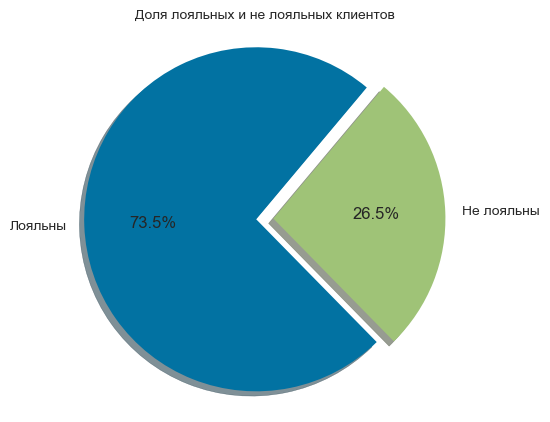

In [52]:
labels = 'Лояльны', 'Не лояльны'
sizes = [data.loyalty[data['loyalty']==1].count(), data.loyalty[data['loyalty']==0].count()]
explode = (0, 0.1)
fig1, ax1 = plt.subplots(figsize=(5, 5))
ax1.pie(sizes, explode=(0, 0.1), labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=50)
ax1.axis('equal')
plt.title("Доля лояльных и не лояльных клиентов", size = 10)
plt.show()

Данные свидетельствуют о том, что 26,6% клиентов не лояльны. Нашей задачей является своевременное выявление данной категории клиентов, чтобы удержать пользователей и не потерять их.

### Рассмотрим, как распределяется лояльность, относительно периода пользования услугами

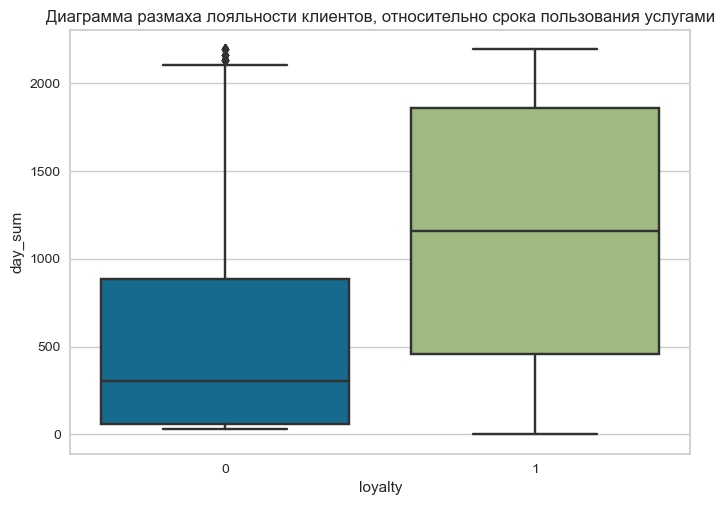

In [53]:
sns.boxplot(x = data.loyalty, 
            y = data.day_sum).set_title('Диаграмма размаха лояльности клиентов, относительно срока пользования услугами')
plt.show()

Видим, что для лояльно настроенных клиентов можно заключить, что они ведут себя предсказемо и остаются на длительный срок. Данные распределены равномерно и симметрично, отсутствуют выбросы. Для клиентов настроенных не лояльно характерен достаточно короткий срок принятия решения о том будут они продолжать пользоваться услугами. В среднем, пользователи понимают за 10 месяцев пользования будут ли они продолжать пользоваться услугами. Данные не симметричны, смещены к меньшему количеству месяцев пользования, есть выбросы для пользователей, которые переставал быть лояльными спустя долгий срок пользования услугами. Стоит отмеить, что первый год пользования продуктом - самый важный для удержания пользователя.

### Влияние типа оплаты на лояльность клиента: ежемесячный, годовой и т.д.

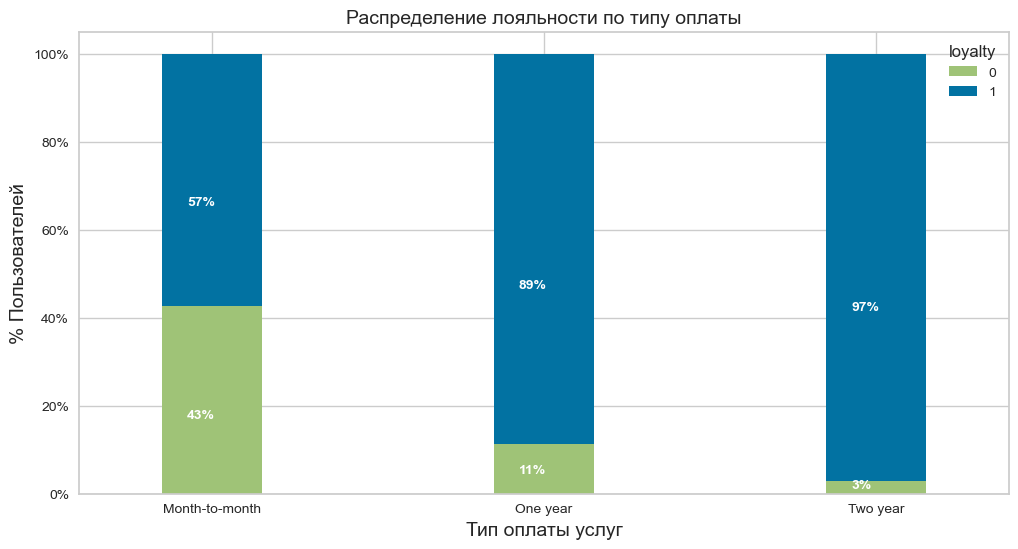

In [54]:
colors = ['g','b']
type_loyalty = data.groupby(['type','loyalty']).size().unstack()

ax = (type_loyalty.T*100.0 / type_loyalty.T.sum()).T.plot(kind='bar',
                                                                width = 0.3,
                                                                stacked = True,
                                                                rot = 0, 
                                                                figsize = (12,6),
                                                                color = colors)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.legend(loc='best',prop={'size':10},title = 'loyalty')
ax.set_ylabel('% Пользователей',size = 14)
ax.set_xlabel('Тип оплаты услуг',size = 14)
ax.set_title('Распределение лояльности по типу оплаты',size = 14)


for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0f}%'.format(height), (p.get_x()+.25*width, p.get_y()+.4*height),
                color = 'white',
               weight = 'bold',
               size = 10)



На основании распределения данных можно заключить, что большее количество не лояльных клиентов заключает договора на месяц. Клиенты, которые выбирают заключение договора на более длительный срок реже становятся не лояльными к продукту компании. Из данного графика можно заключить, что следует быть особенно внимательными при сопровождении клиентов, заключающих договора на месяц и стремиться предлагать и рекламировать плюсы для пользователей от заключения договоров на более длительный срок.

### Влияние наличия пенсионного статуса по возрасту на лояльность

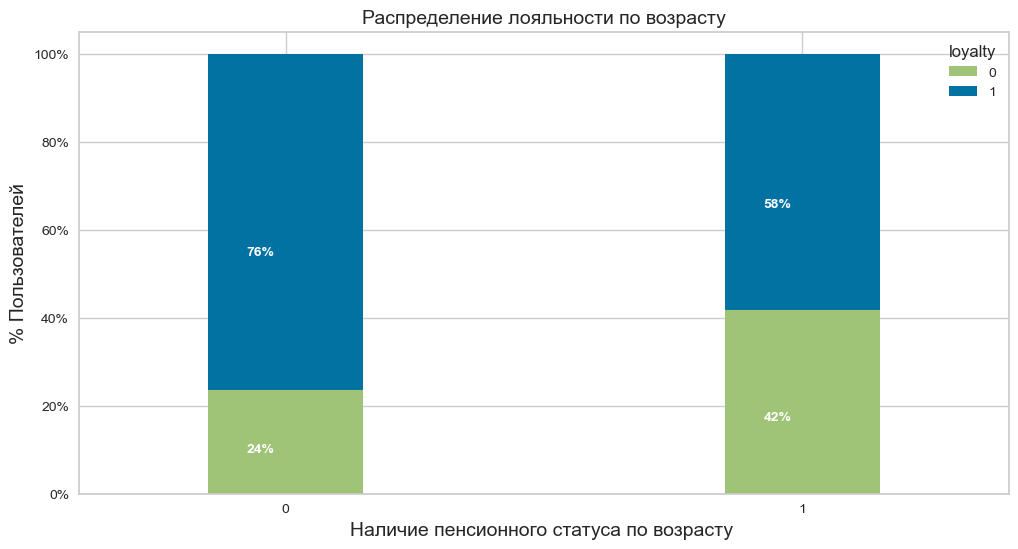

In [55]:
colors = ['g','b']
type_loyalty = data.groupby(['senior_citizen','loyalty']).size().unstack()

ax = (type_loyalty.T*100.0 / type_loyalty.T.sum()).T.plot(kind='bar',
                                                                width = 0.3,
                                                                stacked = True,
                                                                rot = 0, 
                                                                figsize = (12,6),
                                                                color = colors)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.legend(loc='best',prop={'size':10},title = 'loyalty')
ax.set_ylabel('% Пользователей',size = 14)
ax.set_xlabel('Наличие пенсионного статуса по возрасту ',size = 14)
ax.set_title('Распределение лояльности по возрасту',size = 14)


for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0f}%'.format(height), (p.get_x()+.25*width, p.get_y()+.4*height),
                color = 'white',
               weight = 'bold',
               size = 10)

График показывает, что люди пенсионного возраста чаще оказываются не лояльны. Рекомендуется проведение дополнительного исследования для выявления причин, по которым люди пенсионного возраста не находят привлекательными услуги компании. Работа с пользователями пенсионного статуса по возрасту требует более внимательного отношения.

### Влияние наличия электронного платежного документа на лояльность пользователей

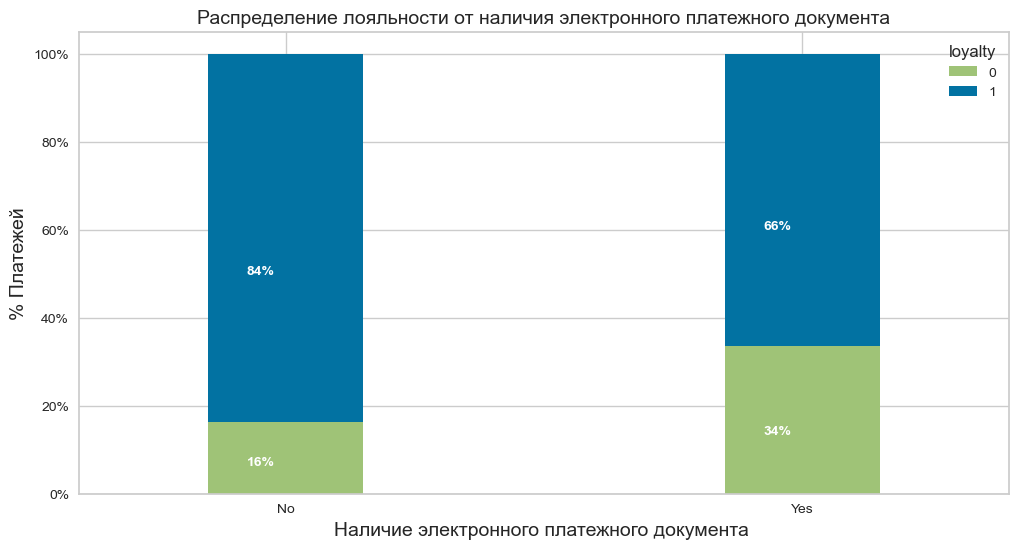

In [56]:
colors = ['g','b']
type_loyalty = data.groupby(['paperless_billing','loyalty']).size().unstack()

ax = (type_loyalty.T*100.0 / type_loyalty.T.sum()).T.plot(kind='bar',
                                                                width = 0.3,
                                                                stacked = True,
                                                                rot = 0, 
                                                                figsize = (12,6),
                                                                color = colors)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.legend(loc='best',prop={'size':10},title = 'loyalty')
ax.set_ylabel('% Платежей',size = 14)
ax.set_xlabel('Наличие электронного платежного документа ',size = 14)
ax.set_title('Распределение лояльности от наличия электронного платежного документа',size = 14)


for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0f}%'.format(height), (p.get_x()+.25*width, p.get_y()+.4*height),
                color = 'white',
               weight = 'bold',
               size = 10)

График показывает, что больше процент не лояльных пользователей со стороны тех, кто получает электронный платежный документ. При выставлении счетов в электронном виде следует дополнитеьно осведомиться у пользователей о том, удобно ли им получать платежный документ в тако виде. Рекомендуется провести дополнительное исследование для уточнения причин, по которым пользователям меньше нравится получать электронный платежный документ и всегда ли получают они его.

### Влияние способа оплаты на лояльность пользователей

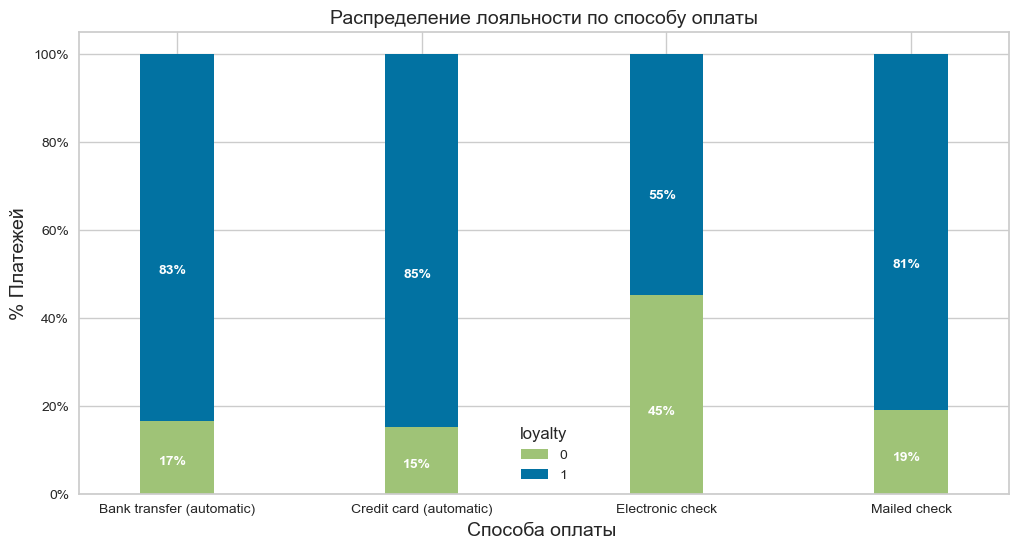

In [57]:
colors = ['g','b']
type_loyalty = data.groupby(['payment_method','loyalty']).size().unstack()

ax = (type_loyalty.T*100.0 / type_loyalty.T.sum()).T.plot(kind='bar',
                                                                width = 0.3,
                                                                stacked = True,
                                                                rot = 0, 
                                                                figsize = (12,6),
                                                                color = colors)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.legend(loc='best',prop={'size':10},title = 'loyalty')
ax.set_ylabel('% Платежей',size = 14)
ax.set_xlabel('Способа оплаты ',size = 14)
ax.set_title('Распределение лояльности по способу оплаты',size = 14)


for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0f}%'.format(height), (p.get_x()+.25*width, p.get_y()+.4*height),
                color = 'white',
               weight = 'bold',
               size = 10)

Данные свидетельствуют о том, что меньше всего пользователи лояльны к способу оплаты по средствам электронного чека. Самый высокий уровень лояльности среди пользователей наблюдается у способа оплаты - автоплатеж по кредитной карте. При работе с клиентами есть смысл предлагать способ оплаты - автоплатеж по кредитной карте. Рекомендуется проведение дополнительного исследования для способа оплаты - электронный чек, возможно, будет выявлена связь с электронным платежным документом.

### Влияние семейного положения на лояльность пользователей

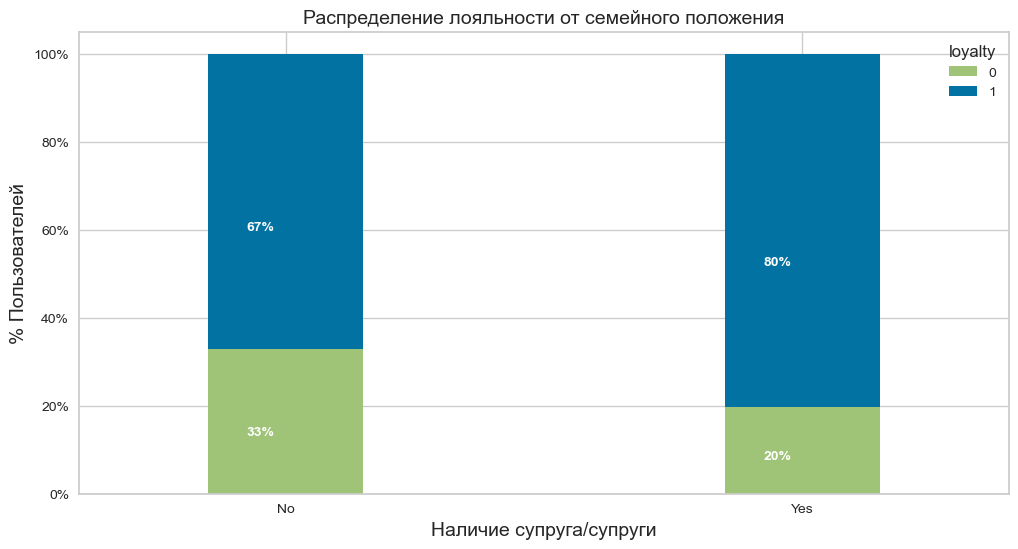

In [58]:
colors = ['g','b']
type_loyalty = data.groupby(['partner','loyalty']).size().unstack()

ax = (type_loyalty.T*100.0 / type_loyalty.T.sum()).T.plot(kind='bar',
                                                                width = 0.3,
                                                                stacked = True,
                                                                rot = 0, 
                                                                figsize = (12,6),
                                                                color = colors)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.legend(loc='best',prop={'size':10},title = 'loyalty')
ax.set_ylabel('% Пользователей',size = 14)
ax.set_xlabel('Наличие супруга/супруги',size = 14)
ax.set_title('Распределение лояльности от семейного положения',size = 14)


for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0f}%'.format(height), (p.get_x()+.25*width, p.get_y()+.4*height),
                color = 'white',
               weight = 'bold',
               size = 10)

График показывает что более лояльно настроены пользователи, состоящие в браке. При работе с клиентами акцентировать внимание на на пользователях, у которых нет партнера.

### Влияние наличия иждивенцев на лояльность пользователей

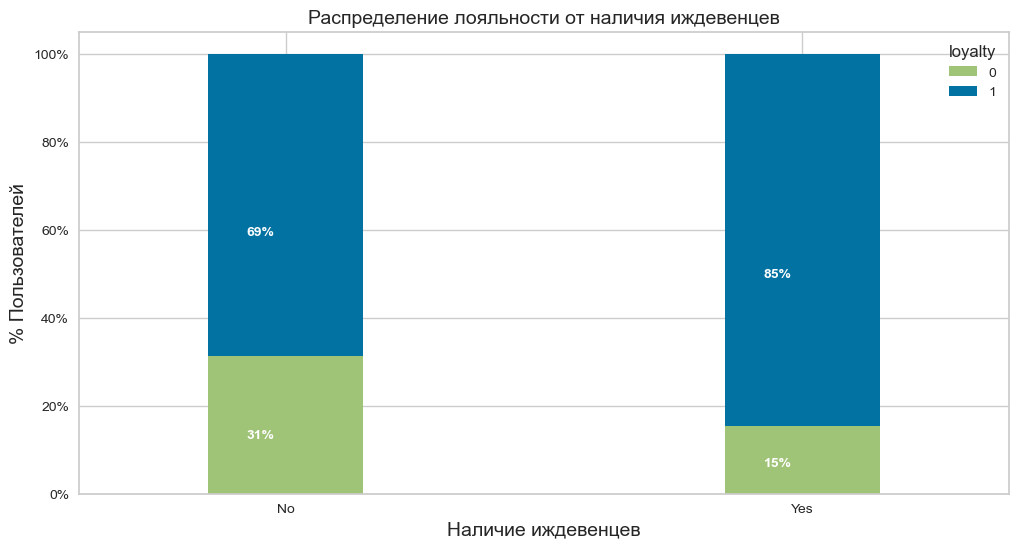

In [59]:
colors = ['g','b']
type_loyalty = data.groupby(['dependents','loyalty']).size().unstack()

ax = (type_loyalty.T*100.0 / type_loyalty.T.sum()).T.plot(kind='bar',
                                                                width = 0.3,
                                                                stacked = True,
                                                                rot = 0, 
                                                                figsize = (12,6),
                                                                color = colors)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.legend(loc='best',prop={'size':10},title = 'loyalty')
ax.set_ylabel('% Пользователей',size = 14)
ax.set_xlabel('Наличие иждевенцев',size = 14)
ax.set_title('Распределение лояльности от наличия иждевенцев',size = 14)


for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0f}%'.format(height), (p.get_x()+.25*width, p.get_y()+.4*height),
                color = 'white',
               weight = 'bold',
               size = 10)

Данные свидетельствуют о том, что среди пользователей у которых нет иждивенцев наблюдается меньшая лояльность к услугам компании.

### Распределение лояльности среди клиентов, пользующихся интернетом

In [60]:
internet_list = ['internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies']

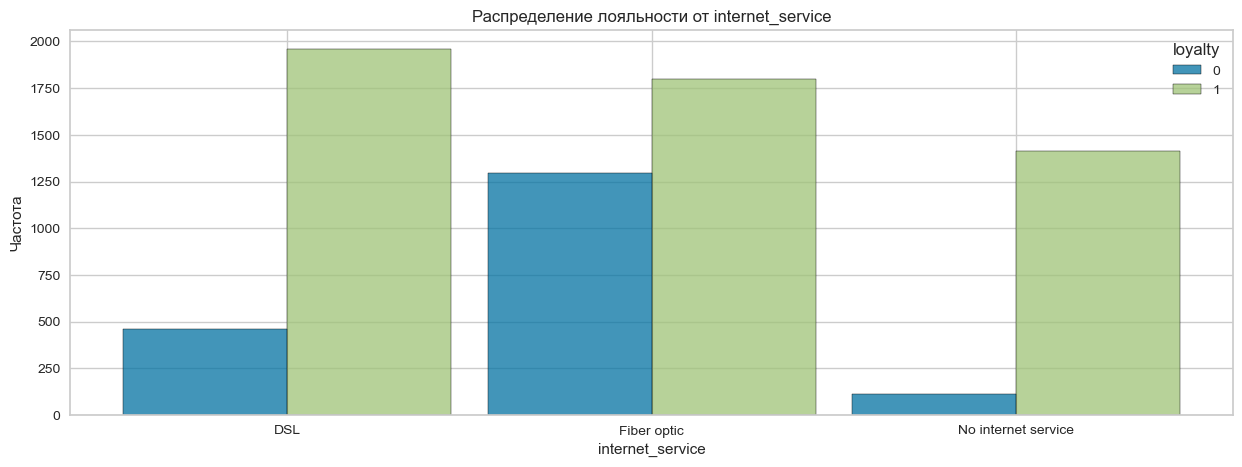

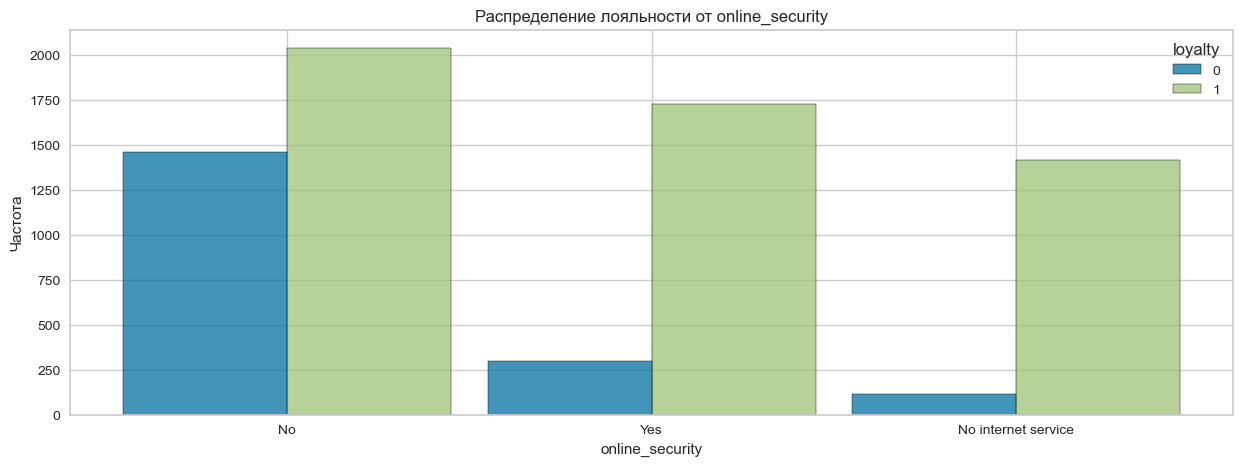

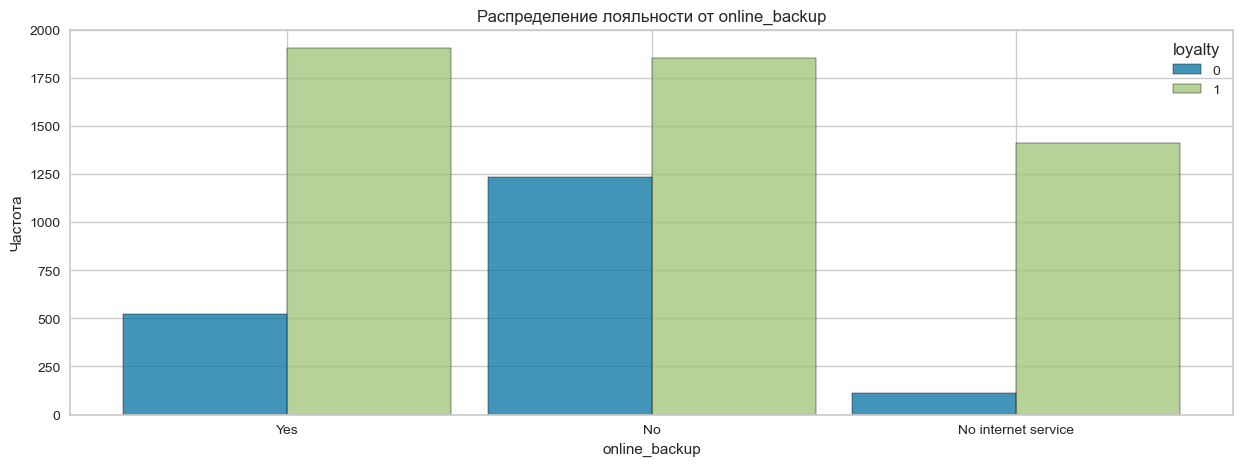

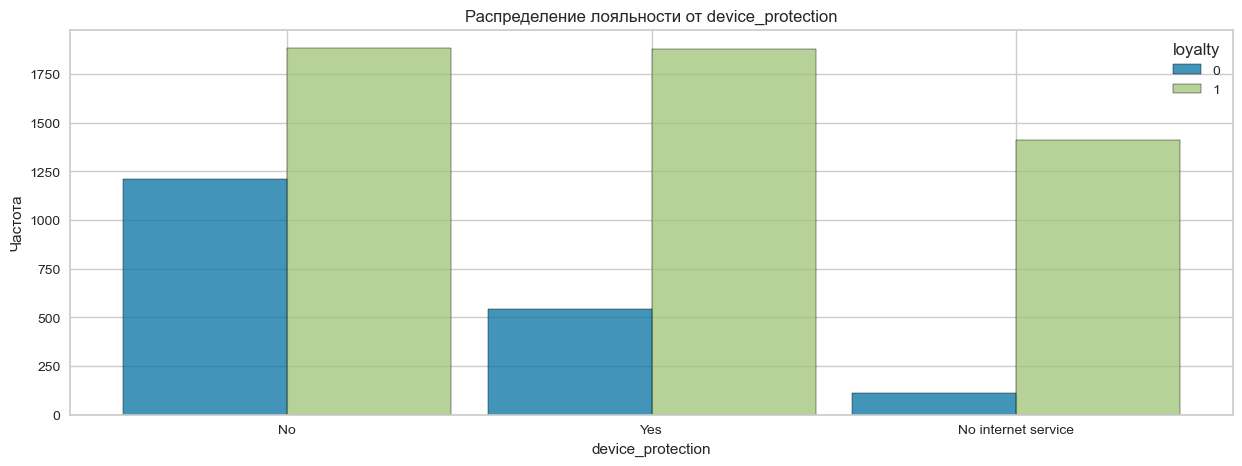

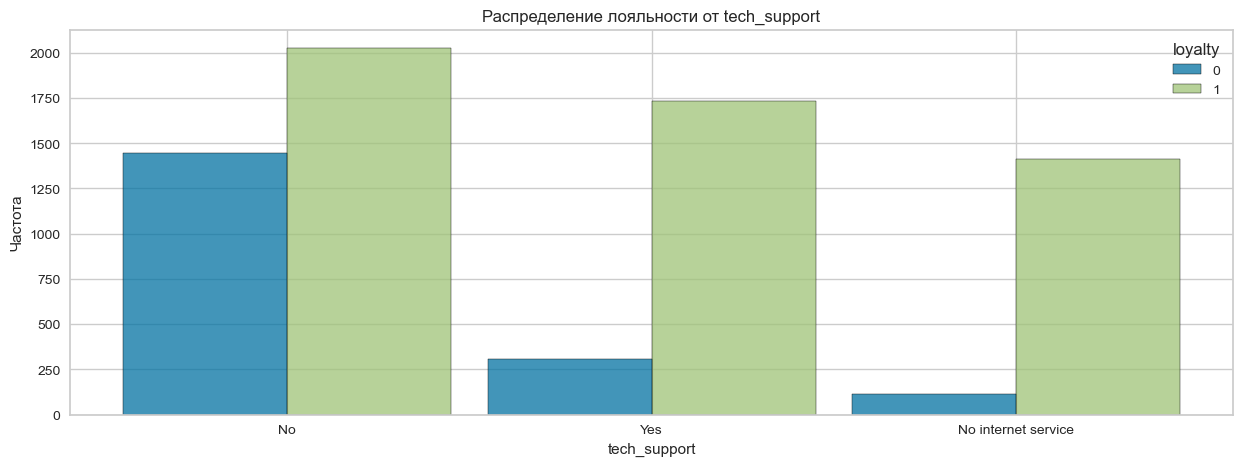

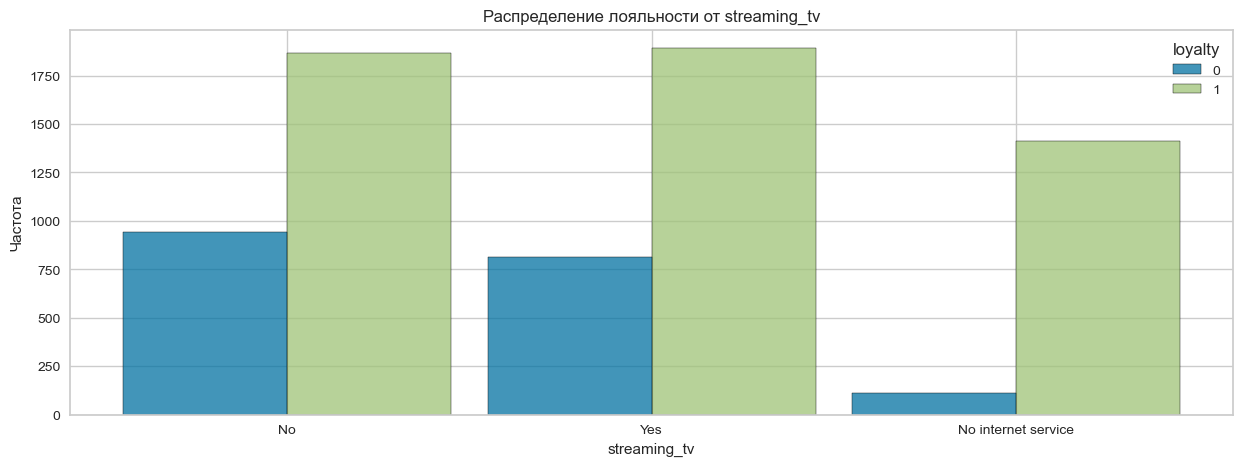

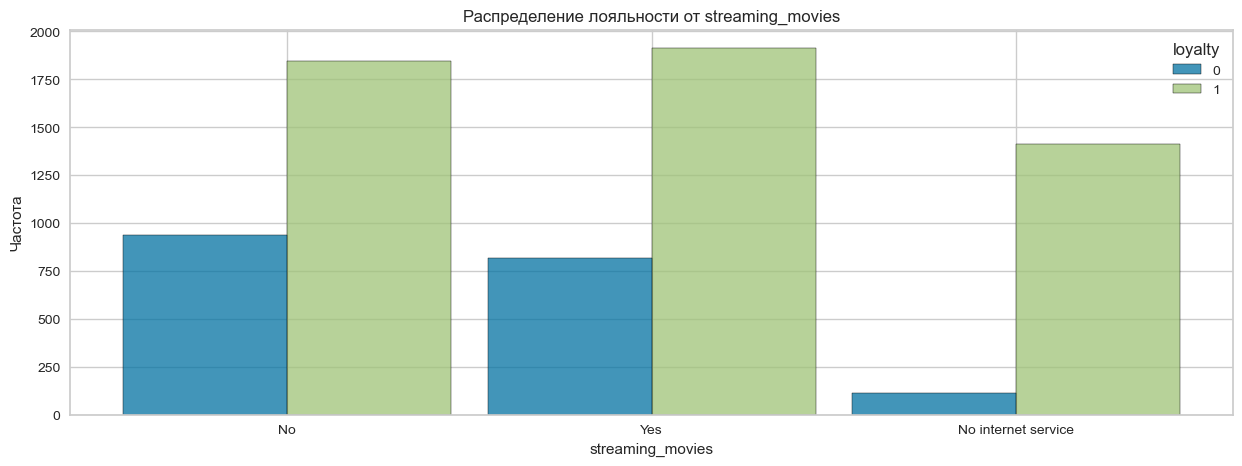

In [61]:
for i in internet_list:
    colors = ['b','g']
    plt.figure(figsize=(15,5))
    sns.histplot(data=data,x=i,hue='loyalty', multiple="dodge", shrink=.9, color = colors)
    plt.ylabel('Частота')
    plt.xlabel(i)
    plt.title(f'Распределение лояльности от {i}')
    plt.show();

Видим, что лояльность пользователей ниже среди тех, у кого подключение к интернету осуществляется по средствам оптоволокна. Более лояльны клиенты не использующие интернет. Рекомендуется провести диагностику работы оптоволоконных линий.
Среди прочих признаков, связанных с интернет-услугами: online_security, online_backup, device_protection, tech_support, streaming_tv, streaming_movies видим,  что менее лояльны те клиенты кто не пользуется данными услугами. Самые лояльные клиенты не используют интернет.

### Распределение лояльности от наличия возможности ведения параллельных линий во время звонка

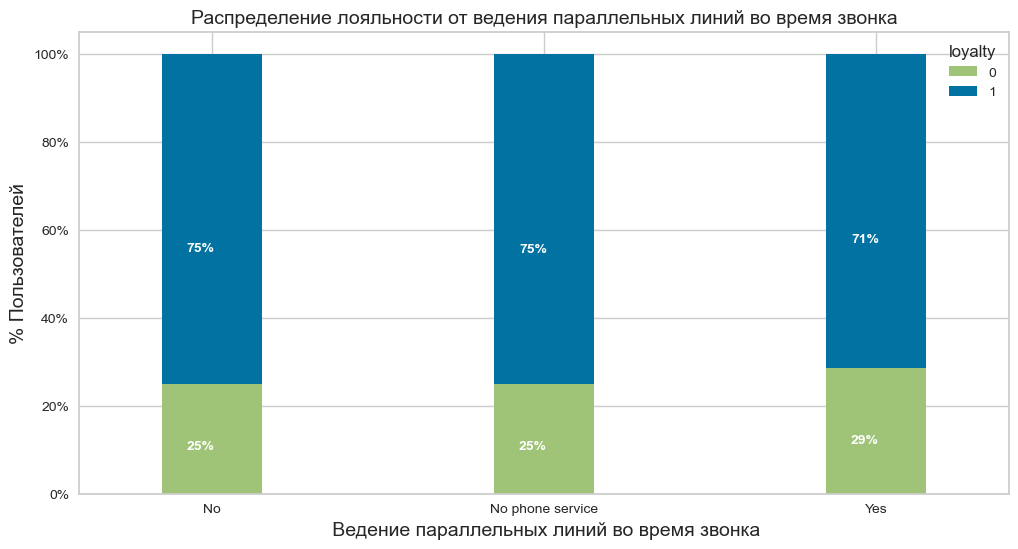

In [62]:
colors = ['g','b']
type_loyalty = data.groupby(['multiple_lines','loyalty']).size().unstack()

ax = (type_loyalty.T*100.0 / type_loyalty.T.sum()).T.plot(kind='bar',
                                                                width = 0.3,
                                                                stacked = True,
                                                                rot = 0, 
                                                                figsize = (12,6),
                                                                color = colors)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.legend(loc='best',prop={'size':10},title = 'loyalty')
#ax.legend(["Лояльны","Не лояльны"],loc='best')
ax.set_ylabel('% Пользователей',size = 14)
ax.set_xlabel(' Ведение параллельных линий во время звонка',size = 14)
ax.set_title('Распределение лояльности от ведения параллельных линий во время звонка',size = 14)


for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0f}%'.format(height), (p.get_x()+.25*width, p.get_y()+.4*height),
                color = 'white',
               weight = 'bold',
               size = 10)

Видим, что лояльность пользователей практически не зависит от возможности ведения параллельных линий во время звонка. Чуть меньше лояльности среди тех пользователей, которые используют ведения параллельных линий во время звонка.

### Распределение ежемесячных платежей от лояльности пользователей

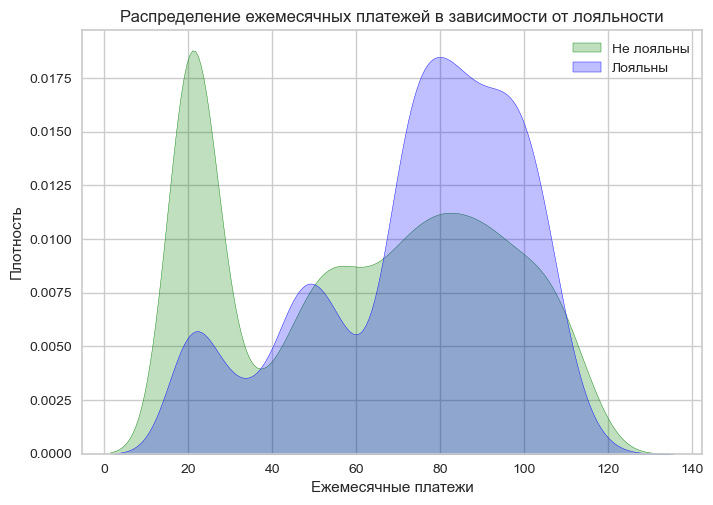

In [63]:
ax = sns.kdeplot(data.monthly_charges[(data["loyalty"] == 1) ],
                color="Green", shade = True)
ax = sns.kdeplot(data.monthly_charges[(data["loyalty"] == 0) ],
                ax =ax, color="Blue", shade= True)
ax.legend(["Не лояльны","Лояльны"],loc='upper right')
ax.set_ylabel('Плотность')
ax.set_xlabel('Ежемесячные платежи')
ax.set_title('Распределение ежемесячных платежей в зависимости от лояльности')
plt.show()

Более высокий процент не лояльных клиентов при высокой ежемесячной плате.

## Итоги исследовательского анализа
В результате проведения анализа лояльности клиентов, было выявлено следующее:
1. распределение лояльность клиентов показало, что 26,6% клиентов не лояльны. Нашей задачей является своевременное выявление данной категории клиентов, чтобы удержать пользователей и не потерять их;
2. распределение лояльности, относительно периода пользования услугами показало, что для лояльно настроенных клиентов характерна предсказуемость: клиенты остаются на длительный срок. Для клиентов настроенных не лояльно характерен достаточно короткий срок принятия решения о том будут они продолжать пользоваться услугами. В среднем, пользователи понимают это за 10 месяцев;
3. влияние типа оплаты на лояльность клиента показала, что большее количество не лояльных клиентов заключает договора на месяц. Клиенты, которые выбирают заключение договора на более длительный срок реже становятся не лояльными к услугам компании;
4. влияние наличия пенсионного статуса по возрасту на лояльность показало, что люди пенсионного возраста чаще оказываются не лояльны;
5. влияние наличия электронного платежного документа на лояльность пользователей показало, что больше процент не лояльных пользователей со стороны тех, кто получает электронный платежный документ;
6. влияние способа оплаты на лояльность пользователей показало, что меньше всего пользователи лояльны к способу оплаты по средствам электронного чека. Самый высокий уровень лояльности среди пользователей наблюдается у способа оплаты - автоплатеж по кредитной карте;
7. влияние семейного положения на лояльность пользователей показало, что более лояльно настроены пользователи, состоящие в браке;
8. влияние наличия иждивенцев на лояльность пользователей показало, что среди пользователей у которых нет иждивенцев наблюдается меньшая лояльность к услугам компании;
9. распределение лояльности среди клиентов, пользующихся интернетом показало, что лояльность пользователей ниже среди тех, у кого подключение к интернету осуществляется по средствам оптоволокна. Среди прочих признаков, связанных с интернет-услугами: online_security, online_backup, device_protection, tech_support, streaming_tv, streaming_movies видим,  что менее лояльны те клиенты кто не пользуется данными услугами. Более лояльны клиенты не использующие интернет.;
10. распределение лояльности от наличия возможности ведения параллельных линий во время звонка показало, что лояльность пользователей практически не зависит от возможности ведения параллельных линий во время звонка. Чуть меньше лояльности среди тех пользователей, которые используют ведения параллельных линий во время звонка;
11. распределение ежемесячных платежей от лояльности пользователей показало, что более высокий процент не лояльных клиентов при высокой ежемесячной плате.


Далее будет выполнена подготовка данных к обучению. Выделим модели машинного обучения, которые можно использовать для решения задачи классификации.

## Подготовка данных к обучению моделей
Разделим данные на выборки с учетом дисбаланса классов.

In [64]:
X, y = data.drop('loyalty', 1), data['loyalty'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)

print(X_train.shape)
print(X_test.shape)

(5282, 16)
(1761, 16)


In [65]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               7043 non-null   object 
 1   paperless_billing  7043 non-null   object 
 2   payment_method     7043 non-null   object 
 3   monthly_charges    7043 non-null   float64
 4   day_sum            7043 non-null   float64
 5   loyalty            7043 non-null   int64  
 6   senior_citizen     7043 non-null   object 
 7   partner            7043 non-null   object 
 8   dependents         7043 non-null   object 
 9   multiple_lines     7043 non-null   object 
 10  internet_service   7043 non-null   object 
 11  online_security    7043 non-null   object 
 12  online_backup      7043 non-null   object 
 13  device_protection  7043 non-null   object 
 14  tech_support       7043 non-null   object 
 15  streaming_tv       7043 non-null   object 
 16  streaming_movies   7043 

Выделим числовые и категориальные признаки.

In [66]:
NUMERIC_FEATURES = ['monthly_charges', 'day_sum']
CATEGORICAL_FEATURES = [feat for feat in X.columns if feat not in NUMERIC_FEATURES]

## Итоги подготовки данных к обучению
В результате подготовки данных к обучению мы разделили данные на выборки.

Далее нами будут обучены следующие модели машинного обучения:
- Logistic Regression
- Random Forest
- CatBoost
- LGBM

## Обучение моделей

### Logistic Regression
Обучение с подбором гиперпараметров.

In [67]:
pipe = Pipeline(
    [('preprocessing', make_column_transformer(
        (
            OneHotEncoder(drop='first', handle_unknown='ignore'),
            CATEGORICAL_FEATURES
        ),
        (
            StandardScaler(), 
            NUMERIC_FEATURES
        ),
        remainder='passthrough',
        verbose_feature_names_out=False
    )),
    ('clf', LogisticRegression(random_state=RANDOM_STATE))
])
params = {'clf__fit_intercept' : [True,False],
          'clf__penalty' : ['l1', 'l2'],
          'clf__solver' :['saga','liblinear', 'lbfgs'],
          'clf__C' : [0.01, 0.1, 1]
         } 
lr = GridSearchCV(pipe, params, scoring = 'roc_auc', cv=5, n_jobs=-1)
lr.fit(X_train, y_train)


/Users/yanasklyanchuk/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['type',
                                                                          'paperless_billing',
                                                                          'payment_method',
                                                                          'senior_citizen',
                                                                          'partner',
                                                                          'dependents',
   

Результаты обучения моделей будут фиксироваться в сводной таблице.

In [68]:
res=pd.DataFrame(columns=['name_model',
                          'best score'                         
                         ],
                 data=[['logistic_regression',
                        cross_val_score(lr, X_train, y_train, cv=5).mean(),
                        ]]
                )
res

/Users/yanasklyanchuk/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yanasklyanchuk/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


name_model  best score
0  logistic_regression    0.840843

### Random Forest

In [69]:
pipe = Pipeline(
    [('preprocessing', make_column_transformer(
        (
            OrdinalEncoder(),
            CATEGORICAL_FEATURES
        ),
        
        remainder='passthrough',
        verbose_feature_names_out=False
    )),
    ('clf', RandomForestClassifier(random_state=RANDOM_STATE, class_weight = 'balanced'))
])
params = {'clf__n_estimators' : [25,50,100,150],
          'clf__criterion' : ['gini', 'entropy'],
          'clf__max_depth':[5,10,20]
         } 
rfc = GridSearchCV(pipe, params, scoring = 'roc_auc',cv=5, n_jobs=-1)
rfc.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ordinalencoder',
                                                                         OrdinalEncoder(),
                                                                         ['type',
                                                                          'paperless_billing',
                                                                          'payment_method',
                                                                          'senior_citizen',
                                                                          'partner',
                                                                          'dependents',
                                                                          'multiple_lines',
                                 

In [70]:
res.loc[res.shape[0]]=['Random_Forest_Classifier_tuned',
                        rfc.best_score_
                      ]
res

name_model  best score
0             logistic_regression    0.840843
1  Random_Forest_Classifier_tuned    0.853990

### CatBoost

In [71]:
parameters = {'cbc__depth':[3,1,2,6,4,5,7,8,9,10],
          'cbc__iterations':[250,100],
          'cbc__learning_rate':[0.001,0.01,0.1],
          'cbc__loss_function': ['Logloss', 'CrossEntropy']
          }
steps = [
    ('cbc', CatBoostClassifier(random_state=RANDOM_STATE, cat_features=CATEGORICAL_FEATURES,
                               auto_class_weights='Balanced'))
]
pipe = Pipeline(steps)

cbc = GridSearchCV(
    estimator = pipe,
    param_grid = parameters,
    scoring = 'roc_auc',
    cv=5)
    
cbc.fit(X_train, y_train)

0:	learn: 0.6928423	total: 60.9ms	remaining: 15.2s
1:	learn: 0.6925204	total: 64.7ms	remaining: 8.02s
2:	learn: 0.6921732	total: 67.4ms	remaining: 5.55s
3:	learn: 0.6918346	total: 70.7ms	remaining: 4.35s
4:	learn: 0.6914975	total: 73.7ms	remaining: 3.61s
5:	learn: 0.6911760	total: 76ms	remaining: 3.09s
6:	learn: 0.6908144	total: 78.7ms	remaining: 2.73s
7:	learn: 0.6904899	total: 81.7ms	remaining: 2.47s
8:	learn: 0.6901344	total: 83.9ms	remaining: 2.25s
9:	learn: 0.6897993	total: 85.9ms	remaining: 2.06s
10:	learn: 0.6894770	total: 88.8ms	remaining: 1.93s
11:	learn: 0.6891218	total: 91.1ms	remaining: 1.81s
12:	learn: 0.6887918	total: 94ms	remaining: 1.71s
13:	learn: 0.6884515	total: 96ms	remaining: 1.62s
14:	learn: 0.6881338	total: 98.6ms	remaining: 1.54s
15:	learn: 0.6877979	total: 102ms	remaining: 1.49s
16:	learn: 0.6874379	total: 105ms	remaining: 1.43s
17:	learn: 0.6870879	total: 107ms	remaining: 1.38s
18:	learn: 0.6867503	total: 110ms	remaining: 1.33s
19:	learn: 0.6864192	total: 112m

196:	learn: 0.6354034	total: 657ms	remaining: 177ms
197:	learn: 0.6351643	total: 659ms	remaining: 173ms
198:	learn: 0.6349234	total: 662ms	remaining: 170ms
199:	learn: 0.6346688	total: 664ms	remaining: 166ms
200:	learn: 0.6344443	total: 666ms	remaining: 162ms
201:	learn: 0.6342314	total: 668ms	remaining: 159ms
202:	learn: 0.6339883	total: 671ms	remaining: 155ms
203:	learn: 0.6337791	total: 673ms	remaining: 152ms
204:	learn: 0.6335258	total: 675ms	remaining: 148ms
205:	learn: 0.6333106	total: 678ms	remaining: 145ms
206:	learn: 0.6331080	total: 680ms	remaining: 141ms
207:	learn: 0.6328751	total: 682ms	remaining: 138ms
208:	learn: 0.6326339	total: 685ms	remaining: 134ms
209:	learn: 0.6323838	total: 689ms	remaining: 131ms
210:	learn: 0.6321584	total: 691ms	remaining: 128ms
211:	learn: 0.6319465	total: 693ms	remaining: 124ms
212:	learn: 0.6316975	total: 695ms	remaining: 121ms
213:	learn: 0.6314195	total: 697ms	remaining: 117ms
214:	learn: 0.6311714	total: 699ms	remaining: 114ms
215:	learn: 

154:	learn: 0.6472204	total: 453ms	remaining: 278ms
155:	learn: 0.6469532	total: 456ms	remaining: 275ms
156:	learn: 0.6466883	total: 458ms	remaining: 271ms
157:	learn: 0.6464493	total: 474ms	remaining: 276ms
158:	learn: 0.6461812	total: 476ms	remaining: 273ms
159:	learn: 0.6459419	total: 479ms	remaining: 269ms
160:	learn: 0.6457073	total: 481ms	remaining: 266ms
161:	learn: 0.6454939	total: 503ms	remaining: 273ms
162:	learn: 0.6452293	total: 506ms	remaining: 270ms
163:	learn: 0.6449942	total: 510ms	remaining: 267ms
164:	learn: 0.6447595	total: 513ms	remaining: 264ms
165:	learn: 0.6444999	total: 525ms	remaining: 266ms
166:	learn: 0.6442582	total: 527ms	remaining: 262ms
167:	learn: 0.6440094	total: 529ms	remaining: 258ms
168:	learn: 0.6437734	total: 532ms	remaining: 255ms
169:	learn: 0.6435241	total: 534ms	remaining: 251ms
170:	learn: 0.6432623	total: 536ms	remaining: 248ms
171:	learn: 0.6430025	total: 538ms	remaining: 244ms
172:	learn: 0.6428382	total: 540ms	remaining: 240ms
173:	learn: 

103:	learn: 0.6584020	total: 304ms	remaining: 427ms
104:	learn: 0.6580870	total: 308ms	remaining: 425ms
105:	learn: 0.6577722	total: 311ms	remaining: 422ms
106:	learn: 0.6574607	total: 314ms	remaining: 419ms
107:	learn: 0.6571551	total: 316ms	remaining: 416ms
108:	learn: 0.6568488	total: 320ms	remaining: 414ms
109:	learn: 0.6565438	total: 322ms	remaining: 410ms
110:	learn: 0.6562395	total: 325ms	remaining: 406ms
111:	learn: 0.6559389	total: 327ms	remaining: 403ms
112:	learn: 0.6556091	total: 329ms	remaining: 399ms
113:	learn: 0.6553478	total: 332ms	remaining: 396ms
114:	learn: 0.6550393	total: 334ms	remaining: 393ms
115:	learn: 0.6547332	total: 337ms	remaining: 389ms
116:	learn: 0.6544308	total: 339ms	remaining: 385ms
117:	learn: 0.6541114	total: 341ms	remaining: 382ms
118:	learn: 0.6538470	total: 344ms	remaining: 379ms
119:	learn: 0.6535444	total: 347ms	remaining: 376ms
120:	learn: 0.6532441	total: 349ms	remaining: 372ms
121:	learn: 0.6529267	total: 351ms	remaining: 368ms
122:	learn: 

62:	learn: 0.6735280	total: 155ms	remaining: 461ms
63:	learn: 0.6731877	total: 158ms	remaining: 458ms
64:	learn: 0.6728836	total: 161ms	remaining: 459ms
65:	learn: 0.6725429	total: 164ms	remaining: 458ms
66:	learn: 0.6722799	total: 182ms	remaining: 497ms
67:	learn: 0.6719279	total: 184ms	remaining: 493ms
68:	learn: 0.6716094	total: 187ms	remaining: 490ms
69:	learn: 0.6712911	total: 189ms	remaining: 485ms
70:	learn: 0.6709812	total: 191ms	remaining: 482ms
71:	learn: 0.6706907	total: 193ms	remaining: 477ms
72:	learn: 0.6703896	total: 197ms	remaining: 478ms
73:	learn: 0.6700904	total: 200ms	remaining: 476ms
74:	learn: 0.6697575	total: 202ms	remaining: 471ms
75:	learn: 0.6694421	total: 204ms	remaining: 468ms
76:	learn: 0.6691122	total: 206ms	remaining: 463ms
77:	learn: 0.6688204	total: 209ms	remaining: 460ms
78:	learn: 0.6685145	total: 211ms	remaining: 456ms
79:	learn: 0.6682220	total: 213ms	remaining: 452ms
80:	learn: 0.6679295	total: 215ms	remaining: 449ms
81:	learn: 0.6676487	total: 218

1:	learn: 0.6926185	total: 47.5ms	remaining: 5.89s
2:	learn: 0.6923384	total: 52.8ms	remaining: 4.35s
3:	learn: 0.6921486	total: 54.8ms	remaining: 3.37s
4:	learn: 0.6918141	total: 56.8ms	remaining: 2.79s
5:	learn: 0.6915475	total: 59ms	remaining: 2.4s
6:	learn: 0.6911967	total: 61.2ms	remaining: 2.12s
7:	learn: 0.6908733	total: 63.9ms	remaining: 1.93s
8:	learn: 0.6905446	total: 66.8ms	remaining: 1.79s
9:	learn: 0.6901899	total: 69.2ms	remaining: 1.66s
10:	learn: 0.6898586	total: 71.3ms	remaining: 1.55s
11:	learn: 0.6894936	total: 73.3ms	remaining: 1.45s
12:	learn: 0.6891696	total: 75.5ms	remaining: 1.38s
13:	learn: 0.6889268	total: 78.3ms	remaining: 1.32s
14:	learn: 0.6885904	total: 81.4ms	remaining: 1.27s
15:	learn: 0.6882322	total: 83.7ms	remaining: 1.22s
16:	learn: 0.6879718	total: 86.4ms	remaining: 1.18s
17:	learn: 0.6876807	total: 88.6ms	remaining: 1.14s
18:	learn: 0.6873332	total: 90.6ms	remaining: 1.1s
19:	learn: 0.6870135	total: 92.8ms	remaining: 1.07s
20:	learn: 0.6866750	tota

166:	learn: 0.6451475	total: 446ms	remaining: 222ms
167:	learn: 0.6448869	total: 449ms	remaining: 219ms
168:	learn: 0.6446462	total: 452ms	remaining: 217ms
169:	learn: 0.6443917	total: 454ms	remaining: 214ms
170:	learn: 0.6441530	total: 456ms	remaining: 211ms
171:	learn: 0.6438825	total: 458ms	remaining: 208ms
172:	learn: 0.6435998	total: 460ms	remaining: 205ms
173:	learn: 0.6433455	total: 462ms	remaining: 202ms
174:	learn: 0.6431343	total: 464ms	remaining: 199ms
175:	learn: 0.6428518	total: 467ms	remaining: 196ms
176:	learn: 0.6426193	total: 469ms	remaining: 193ms
177:	learn: 0.6423822	total: 471ms	remaining: 191ms
178:	learn: 0.6421833	total: 473ms	remaining: 188ms
179:	learn: 0.6419422	total: 476ms	remaining: 185ms
180:	learn: 0.6416669	total: 478ms	remaining: 182ms
181:	learn: 0.6414567	total: 481ms	remaining: 180ms
182:	learn: 0.6411702	total: 484ms	remaining: 177ms
183:	learn: 0.6410019	total: 486ms	remaining: 174ms
184:	learn: 0.6407723	total: 492ms	remaining: 173ms
185:	learn: 

135:	learn: 0.5161816	total: 332ms	remaining: 278ms
136:	learn: 0.5159135	total: 335ms	remaining: 276ms
137:	learn: 0.5156445	total: 338ms	remaining: 275ms
138:	learn: 0.5150975	total: 341ms	remaining: 273ms
139:	learn: 0.5148093	total: 344ms	remaining: 270ms
140:	learn: 0.5144944	total: 346ms	remaining: 267ms
141:	learn: 0.5141809	total: 350ms	remaining: 266ms
142:	learn: 0.5136096	total: 353ms	remaining: 264ms
143:	learn: 0.5134653	total: 355ms	remaining: 261ms
144:	learn: 0.5129305	total: 357ms	remaining: 259ms
145:	learn: 0.5122525	total: 360ms	remaining: 257ms
146:	learn: 0.5119672	total: 362ms	remaining: 254ms
147:	learn: 0.5113240	total: 365ms	remaining: 252ms
148:	learn: 0.5109703	total: 368ms	remaining: 249ms
149:	learn: 0.5105281	total: 370ms	remaining: 246ms
150:	learn: 0.5101432	total: 372ms	remaining: 244ms
151:	learn: 0.5098247	total: 374ms	remaining: 241ms
152:	learn: 0.5093978	total: 377ms	remaining: 239ms
153:	learn: 0.5091389	total: 380ms	remaining: 237ms
154:	learn: 

106:	learn: 0.5331228	total: 286ms	remaining: 383ms
107:	learn: 0.5322327	total: 290ms	remaining: 382ms
108:	learn: 0.5316676	total: 295ms	remaining: 382ms
109:	learn: 0.5313171	total: 298ms	remaining: 379ms
110:	learn: 0.5304862	total: 301ms	remaining: 377ms
111:	learn: 0.5300347	total: 306ms	remaining: 376ms
112:	learn: 0.5295922	total: 308ms	remaining: 374ms
113:	learn: 0.5292217	total: 311ms	remaining: 371ms
114:	learn: 0.5287303	total: 313ms	remaining: 368ms
115:	learn: 0.5279901	total: 315ms	remaining: 364ms
116:	learn: 0.5273928	total: 318ms	remaining: 362ms
117:	learn: 0.5268638	total: 321ms	remaining: 359ms
118:	learn: 0.5260096	total: 324ms	remaining: 356ms
119:	learn: 0.5253710	total: 326ms	remaining: 353ms
120:	learn: 0.5249806	total: 328ms	remaining: 350ms
121:	learn: 0.5246465	total: 331ms	remaining: 347ms
122:	learn: 0.5241020	total: 334ms	remaining: 345ms
123:	learn: 0.5236972	total: 337ms	remaining: 343ms
124:	learn: 0.5231767	total: 340ms	remaining: 340ms
125:	learn: 

37:	learn: 0.5952727	total: 94.9ms	remaining: 529ms
38:	learn: 0.5933428	total: 97.5ms	remaining: 527ms
39:	learn: 0.5914007	total: 101ms	remaining: 531ms
40:	learn: 0.5899264	total: 104ms	remaining: 531ms
41:	learn: 0.5886170	total: 107ms	remaining: 530ms
42:	learn: 0.5871972	total: 109ms	remaining: 524ms
43:	learn: 0.5856221	total: 111ms	remaining: 521ms
44:	learn: 0.5844082	total: 114ms	remaining: 519ms
45:	learn: 0.5827217	total: 117ms	remaining: 518ms
46:	learn: 0.5812190	total: 119ms	remaining: 514ms
47:	learn: 0.5798256	total: 122ms	remaining: 513ms
48:	learn: 0.5786442	total: 125ms	remaining: 511ms
49:	learn: 0.5764947	total: 127ms	remaining: 509ms
50:	learn: 0.5750363	total: 130ms	remaining: 505ms
51:	learn: 0.5736885	total: 132ms	remaining: 502ms
52:	learn: 0.5716368	total: 135ms	remaining: 501ms
53:	learn: 0.5706058	total: 137ms	remaining: 499ms
54:	learn: 0.5693314	total: 140ms	remaining: 496ms
55:	learn: 0.5683256	total: 142ms	remaining: 491ms
56:	learn: 0.5672046	total: 1

0:	learn: 0.6899983	total: 3.63ms	remaining: 904ms
1:	learn: 0.6873834	total: 6.56ms	remaining: 814ms
2:	learn: 0.6845085	total: 8.67ms	remaining: 714ms
3:	learn: 0.6815256	total: 14ms	remaining: 860ms
4:	learn: 0.6785480	total: 16.3ms	remaining: 798ms
5:	learn: 0.6755115	total: 19.6ms	remaining: 798ms
6:	learn: 0.6726748	total: 22.1ms	remaining: 767ms
7:	learn: 0.6698083	total: 24.9ms	remaining: 753ms
8:	learn: 0.6668752	total: 27.3ms	remaining: 731ms
9:	learn: 0.6638690	total: 29.7ms	remaining: 714ms
10:	learn: 0.6611903	total: 32.1ms	remaining: 698ms
11:	learn: 0.6580802	total: 34.4ms	remaining: 683ms
12:	learn: 0.6552240	total: 38.3ms	remaining: 699ms
13:	learn: 0.6526142	total: 41.9ms	remaining: 707ms
14:	learn: 0.6501815	total: 44.7ms	remaining: 700ms
15:	learn: 0.6479732	total: 47.7ms	remaining: 698ms
16:	learn: 0.6455291	total: 49.8ms	remaining: 682ms
17:	learn: 0.6432318	total: 52.9ms	remaining: 682ms
18:	learn: 0.6406116	total: 54.8ms	remaining: 666ms
19:	learn: 0.6383622	tot

219:	learn: 0.4907319	total: 599ms	remaining: 81.7ms
220:	learn: 0.4905707	total: 604ms	remaining: 79.2ms
221:	learn: 0.4904040	total: 606ms	remaining: 76.4ms
222:	learn: 0.4901137	total: 609ms	remaining: 73.8ms
223:	learn: 0.4900237	total: 614ms	remaining: 71.2ms
224:	learn: 0.4899482	total: 616ms	remaining: 68.4ms
225:	learn: 0.4897418	total: 620ms	remaining: 65.8ms
226:	learn: 0.4896257	total: 622ms	remaining: 63ms
227:	learn: 0.4895168	total: 625ms	remaining: 60.3ms
228:	learn: 0.4894412	total: 628ms	remaining: 57.6ms
229:	learn: 0.4892690	total: 630ms	remaining: 54.8ms
230:	learn: 0.4890805	total: 633ms	remaining: 52ms
231:	learn: 0.4888637	total: 636ms	remaining: 49.4ms
232:	learn: 0.4887406	total: 639ms	remaining: 46.6ms
233:	learn: 0.4885925	total: 642ms	remaining: 43.9ms
234:	learn: 0.4884353	total: 644ms	remaining: 41.1ms
235:	learn: 0.4882667	total: 647ms	remaining: 38.4ms
236:	learn: 0.4881040	total: 650ms	remaining: 35.6ms
237:	learn: 0.4879813	total: 652ms	remaining: 32.9

186:	learn: 0.4969574	total: 497ms	remaining: 167ms
187:	learn: 0.4967004	total: 503ms	remaining: 166ms
188:	learn: 0.4964421	total: 506ms	remaining: 163ms
189:	learn: 0.4963267	total: 508ms	remaining: 160ms
190:	learn: 0.4957764	total: 511ms	remaining: 158ms
191:	learn: 0.4953140	total: 515ms	remaining: 156ms
192:	learn: 0.4950630	total: 517ms	remaining: 153ms
193:	learn: 0.4949384	total: 520ms	remaining: 150ms
194:	learn: 0.4948010	total: 524ms	remaining: 148ms
195:	learn: 0.4946197	total: 527ms	remaining: 145ms
196:	learn: 0.4943507	total: 529ms	remaining: 142ms
197:	learn: 0.4941951	total: 532ms	remaining: 140ms
198:	learn: 0.4941183	total: 534ms	remaining: 137ms
199:	learn: 0.4939004	total: 537ms	remaining: 134ms
200:	learn: 0.4937491	total: 539ms	remaining: 131ms
201:	learn: 0.4936796	total: 541ms	remaining: 129ms
202:	learn: 0.4934714	total: 543ms	remaining: 126ms
203:	learn: 0.4932962	total: 546ms	remaining: 123ms
204:	learn: 0.4930435	total: 549ms	remaining: 121ms
205:	learn: 

141:	learn: 0.4198120	total: 401ms	remaining: 305ms
142:	learn: 0.4196137	total: 405ms	remaining: 303ms
143:	learn: 0.4195737	total: 410ms	remaining: 301ms
144:	learn: 0.4186704	total: 413ms	remaining: 299ms
145:	learn: 0.4185161	total: 416ms	remaining: 296ms
146:	learn: 0.4184270	total: 419ms	remaining: 293ms
147:	learn: 0.4178963	total: 422ms	remaining: 291ms
148:	learn: 0.4176495	total: 432ms	remaining: 293ms
149:	learn: 0.4175525	total: 437ms	remaining: 292ms
150:	learn: 0.4169335	total: 441ms	remaining: 289ms
151:	learn: 0.4167964	total: 444ms	remaining: 286ms
152:	learn: 0.4158095	total: 448ms	remaining: 284ms
153:	learn: 0.4157466	total: 451ms	remaining: 281ms
154:	learn: 0.4156152	total: 454ms	remaining: 279ms
155:	learn: 0.4151444	total: 459ms	remaining: 277ms
156:	learn: 0.4149559	total: 462ms	remaining: 274ms
157:	learn: 0.4148400	total: 465ms	remaining: 271ms
158:	learn: 0.4147333	total: 468ms	remaining: 268ms
159:	learn: 0.4145867	total: 471ms	remaining: 265ms
160:	learn: 

49:	learn: 0.4660028	total: 200ms	remaining: 801ms
50:	learn: 0.4658452	total: 204ms	remaining: 795ms
51:	learn: 0.4654640	total: 207ms	remaining: 789ms
52:	learn: 0.4650956	total: 210ms	remaining: 780ms
53:	learn: 0.4648077	total: 213ms	remaining: 774ms
54:	learn: 0.4646845	total: 217ms	remaining: 769ms
55:	learn: 0.4634785	total: 220ms	remaining: 761ms
56:	learn: 0.4634785	total: 222ms	remaining: 750ms
57:	learn: 0.4613516	total: 224ms	remaining: 742ms
58:	learn: 0.4610856	total: 227ms	remaining: 736ms
59:	learn: 0.4610759	total: 230ms	remaining: 728ms
60:	learn: 0.4602549	total: 237ms	remaining: 734ms
61:	learn: 0.4598267	total: 239ms	remaining: 726ms
62:	learn: 0.4596621	total: 242ms	remaining: 718ms
63:	learn: 0.4594409	total: 244ms	remaining: 710ms
64:	learn: 0.4591465	total: 247ms	remaining: 703ms
65:	learn: 0.4589481	total: 250ms	remaining: 696ms
66:	learn: 0.4585316	total: 253ms	remaining: 691ms
67:	learn: 0.4579519	total: 255ms	remaining: 683ms
68:	learn: 0.4579519	total: 257

227:	learn: 0.4002207	total: 799ms	remaining: 77.1ms
228:	learn: 0.4002055	total: 802ms	remaining: 73.6ms
229:	learn: 0.4002055	total: 805ms	remaining: 70ms
230:	learn: 0.3999433	total: 809ms	remaining: 66.6ms
231:	learn: 0.3997190	total: 814ms	remaining: 63.2ms
232:	learn: 0.3990802	total: 817ms	remaining: 59.6ms
233:	learn: 0.3989469	total: 821ms	remaining: 56.1ms
234:	learn: 0.3989422	total: 823ms	remaining: 52.6ms
235:	learn: 0.3974832	total: 827ms	remaining: 49.1ms
236:	learn: 0.3971015	total: 831ms	remaining: 45.6ms
237:	learn: 0.3971003	total: 834ms	remaining: 42ms
238:	learn: 0.3966379	total: 837ms	remaining: 38.5ms
239:	learn: 0.3964574	total: 840ms	remaining: 35ms
240:	learn: 0.3959313	total: 843ms	remaining: 31.5ms
241:	learn: 0.3959179	total: 847ms	remaining: 28ms
242:	learn: 0.3959092	total: 851ms	remaining: 24.5ms
243:	learn: 0.3958438	total: 854ms	remaining: 21ms
244:	learn: 0.3954487	total: 857ms	remaining: 17.5ms
245:	learn: 0.3953878	total: 860ms	remaining: 14ms
246:	

178:	learn: 0.4068345	total: 716ms	remaining: 284ms
179:	learn: 0.4063379	total: 720ms	remaining: 280ms
180:	learn: 0.4061473	total: 724ms	remaining: 276ms
181:	learn: 0.4060055	total: 728ms	remaining: 272ms
182:	learn: 0.4059683	total: 742ms	remaining: 272ms
183:	learn: 0.4054973	total: 745ms	remaining: 267ms
184:	learn: 0.4036983	total: 750ms	remaining: 264ms
185:	learn: 0.4035000	total: 755ms	remaining: 260ms
186:	learn: 0.4034699	total: 758ms	remaining: 255ms
187:	learn: 0.4034231	total: 762ms	remaining: 251ms
188:	learn: 0.4022740	total: 766ms	remaining: 247ms
189:	learn: 0.4022648	total: 769ms	remaining: 243ms
190:	learn: 0.4017463	total: 773ms	remaining: 239ms
191:	learn: 0.4017241	total: 780ms	remaining: 236ms
192:	learn: 0.4015077	total: 785ms	remaining: 232ms
193:	learn: 0.4012637	total: 788ms	remaining: 228ms
194:	learn: 0.4010328	total: 793ms	remaining: 224ms
195:	learn: 0.4010051	total: 798ms	remaining: 220ms
196:	learn: 0.4006919	total: 801ms	remaining: 215ms
197:	learn: 

113:	learn: 0.4307178	total: 315ms	remaining: 376ms
114:	learn: 0.4304083	total: 319ms	remaining: 375ms
115:	learn: 0.4289787	total: 323ms	remaining: 373ms
116:	learn: 0.4288934	total: 326ms	remaining: 370ms
117:	learn: 0.4288607	total: 328ms	remaining: 367ms
118:	learn: 0.4286888	total: 332ms	remaining: 365ms
119:	learn: 0.4280209	total: 335ms	remaining: 363ms
120:	learn: 0.4264840	total: 338ms	remaining: 360ms
121:	learn: 0.4261124	total: 340ms	remaining: 357ms
122:	learn: 0.4258849	total: 344ms	remaining: 356ms
123:	learn: 0.4251848	total: 347ms	remaining: 353ms
124:	learn: 0.4248901	total: 349ms	remaining: 349ms
125:	learn: 0.4237898	total: 352ms	remaining: 346ms
126:	learn: 0.4237632	total: 355ms	remaining: 344ms
127:	learn: 0.4231086	total: 358ms	remaining: 341ms
128:	learn: 0.4228921	total: 360ms	remaining: 338ms
129:	learn: 0.4223882	total: 363ms	remaining: 335ms
130:	learn: 0.4223084	total: 366ms	remaining: 332ms
131:	learn: 0.4218976	total: 369ms	remaining: 330ms
132:	learn: 

48:	learn: 0.4657103	total: 141ms	remaining: 579ms
49:	learn: 0.4623704	total: 145ms	remaining: 579ms
50:	learn: 0.4609045	total: 148ms	remaining: 576ms
51:	learn: 0.4607923	total: 150ms	remaining: 573ms
52:	learn: 0.4607549	total: 153ms	remaining: 568ms
53:	learn: 0.4600103	total: 156ms	remaining: 568ms
54:	learn: 0.4598142	total: 159ms	remaining: 565ms
55:	learn: 0.4596215	total: 162ms	remaining: 563ms
56:	learn: 0.4595333	total: 165ms	remaining: 559ms
57:	learn: 0.4593013	total: 169ms	remaining: 559ms
58:	learn: 0.4586527	total: 172ms	remaining: 556ms
59:	learn: 0.4585524	total: 175ms	remaining: 555ms
60:	learn: 0.4574679	total: 179ms	remaining: 554ms
61:	learn: 0.4572772	total: 181ms	remaining: 549ms
62:	learn: 0.4571229	total: 184ms	remaining: 547ms
63:	learn: 0.4570345	total: 187ms	remaining: 544ms
64:	learn: 0.4568252	total: 190ms	remaining: 540ms
65:	learn: 0.4565297	total: 194ms	remaining: 540ms
66:	learn: 0.4564195	total: 197ms	remaining: 538ms
67:	learn: 0.4558875	total: 199

245:	learn: 0.3912351	total: 743ms	remaining: 12.1ms
246:	learn: 0.3909671	total: 745ms	remaining: 9.04ms
247:	learn: 0.3909198	total: 748ms	remaining: 6.03ms
248:	learn: 0.3901114	total: 751ms	remaining: 3.02ms
249:	learn: 0.3888907	total: 755ms	remaining: 0us
0:	learn: 0.6929007	total: 1.66ms	remaining: 164ms
1:	learn: 0.6926471	total: 2.77ms	remaining: 136ms
2:	learn: 0.6924101	total: 4.1ms	remaining: 133ms
3:	learn: 0.6921215	total: 5.35ms	remaining: 128ms
4:	learn: 0.6918497	total: 9.08ms	remaining: 173ms
5:	learn: 0.6916107	total: 10.2ms	remaining: 161ms
6:	learn: 0.6913218	total: 11.2ms	remaining: 149ms
7:	learn: 0.6911071	total: 12.3ms	remaining: 141ms
8:	learn: 0.6908809	total: 13.4ms	remaining: 136ms
9:	learn: 0.6906301	total: 14.6ms	remaining: 131ms
10:	learn: 0.6903722	total: 15.9ms	remaining: 129ms
11:	learn: 0.6901298	total: 17.1ms	remaining: 125ms
12:	learn: 0.6898584	total: 18.2ms	remaining: 122ms
13:	learn: 0.6896159	total: 19.6ms	remaining: 120ms
14:	learn: 0.6893691	

27:	learn: 0.6860496	total: 35.7ms	remaining: 91.9ms
28:	learn: 0.6857710	total: 38.7ms	remaining: 94.7ms
29:	learn: 0.6854914	total: 39.8ms	remaining: 92.8ms
30:	learn: 0.6852164	total: 41.1ms	remaining: 91.5ms
31:	learn: 0.6849436	total: 42.3ms	remaining: 89.9ms
32:	learn: 0.6847355	total: 43.3ms	remaining: 88ms
33:	learn: 0.6844904	total: 44.7ms	remaining: 86.7ms
34:	learn: 0.6842406	total: 46.5ms	remaining: 86.3ms
35:	learn: 0.6839828	total: 48.3ms	remaining: 85.8ms
36:	learn: 0.6837198	total: 51.1ms	remaining: 86.9ms
37:	learn: 0.6834836	total: 54.7ms	remaining: 89.2ms
38:	learn: 0.6832182	total: 56.5ms	remaining: 88.4ms
39:	learn: 0.6829848	total: 58ms	remaining: 87ms
40:	learn: 0.6827126	total: 61ms	remaining: 87.8ms
41:	learn: 0.6824720	total: 62.5ms	remaining: 86.3ms
42:	learn: 0.6822232	total: 63.8ms	remaining: 84.6ms
43:	learn: 0.6819973	total: 65.1ms	remaining: 82.9ms
44:	learn: 0.6817320	total: 66.4ms	remaining: 81.1ms
45:	learn: 0.6814797	total: 67.8ms	remaining: 79.6ms
4

79:	learn: 0.6747740	total: 94.9ms	remaining: 23.7ms
80:	learn: 0.6745214	total: 96.2ms	remaining: 22.6ms
81:	learn: 0.6742998	total: 98.1ms	remaining: 21.5ms
82:	learn: 0.6740636	total: 99.5ms	remaining: 20.4ms
83:	learn: 0.6739601	total: 101ms	remaining: 19.2ms
84:	learn: 0.6737284	total: 102ms	remaining: 18ms
85:	learn: 0.6734970	total: 103ms	remaining: 16.8ms
86:	learn: 0.6732781	total: 106ms	remaining: 15.8ms
87:	learn: 0.6730512	total: 107ms	remaining: 14.5ms
88:	learn: 0.6728223	total: 108ms	remaining: 13.3ms
89:	learn: 0.6725867	total: 109ms	remaining: 12.1ms
90:	learn: 0.6723613	total: 110ms	remaining: 10.9ms
91:	learn: 0.6721175	total: 112ms	remaining: 9.71ms
92:	learn: 0.6718868	total: 113ms	remaining: 8.49ms
93:	learn: 0.6716587	total: 114ms	remaining: 7.27ms
94:	learn: 0.6714387	total: 115ms	remaining: 6.07ms
95:	learn: 0.6712618	total: 117ms	remaining: 4.87ms
96:	learn: 0.6710697	total: 118ms	remaining: 3.65ms
97:	learn: 0.6708500	total: 119ms	remaining: 2.43ms
98:	learn:

0:	learn: 0.6903390	total: 1.55ms	remaining: 153ms
1:	learn: 0.6876993	total: 4.95ms	remaining: 243ms
2:	learn: 0.6852343	total: 6.39ms	remaining: 207ms
3:	learn: 0.6829492	total: 7.9ms	remaining: 190ms
4:	learn: 0.6806156	total: 9.13ms	remaining: 173ms
5:	learn: 0.6783354	total: 10.5ms	remaining: 165ms
6:	learn: 0.6760163	total: 11.6ms	remaining: 154ms
7:	learn: 0.6740789	total: 12.8ms	remaining: 147ms
8:	learn: 0.6719251	total: 14ms	remaining: 141ms
9:	learn: 0.6695852	total: 15.1ms	remaining: 136ms
10:	learn: 0.6671565	total: 16.4ms	remaining: 132ms
11:	learn: 0.6648045	total: 19ms	remaining: 139ms
12:	learn: 0.6626868	total: 20.2ms	remaining: 135ms
13:	learn: 0.6605824	total: 22.1ms	remaining: 136ms
14:	learn: 0.6586280	total: 23.2ms	remaining: 132ms
15:	learn: 0.6569613	total: 24.2ms	remaining: 127ms
16:	learn: 0.6548971	total: 26.4ms	remaining: 129ms
17:	learn: 0.6527301	total: 27.7ms	remaining: 126ms
18:	learn: 0.6508528	total: 29.7ms	remaining: 127ms
19:	learn: 0.6488073	total:

55:	learn: 0.5976095	total: 77.5ms	remaining: 60.9ms
56:	learn: 0.5965122	total: 78.9ms	remaining: 59.5ms
57:	learn: 0.5954193	total: 80.4ms	remaining: 58.2ms
58:	learn: 0.5942928	total: 81.7ms	remaining: 56.8ms
59:	learn: 0.5932438	total: 82.9ms	remaining: 55.3ms
60:	learn: 0.5921116	total: 84.2ms	remaining: 53.8ms
61:	learn: 0.5910663	total: 85.4ms	remaining: 52.4ms
62:	learn: 0.5898530	total: 87.1ms	remaining: 51.2ms
63:	learn: 0.5888730	total: 88.3ms	remaining: 49.7ms
64:	learn: 0.5876683	total: 89.5ms	remaining: 48.2ms
65:	learn: 0.5866768	total: 90.7ms	remaining: 46.7ms
66:	learn: 0.5856839	total: 92.2ms	remaining: 45.4ms
67:	learn: 0.5847026	total: 93.6ms	remaining: 44.1ms
68:	learn: 0.5837695	total: 95.1ms	remaining: 42.7ms
69:	learn: 0.5828477	total: 97.9ms	remaining: 42ms
70:	learn: 0.5818962	total: 98.8ms	remaining: 40.4ms
71:	learn: 0.5809379	total: 100ms	remaining: 38.9ms
72:	learn: 0.5800369	total: 102ms	remaining: 37.6ms
73:	learn: 0.5790758	total: 103ms	remaining: 36.4m

89:	learn: 0.4599310	total: 126ms	remaining: 14ms
90:	learn: 0.4596152	total: 134ms	remaining: 13.3ms
91:	learn: 0.4592212	total: 136ms	remaining: 11.8ms
92:	learn: 0.4589499	total: 137ms	remaining: 10.3ms
93:	learn: 0.4585346	total: 138ms	remaining: 8.84ms
94:	learn: 0.4582771	total: 140ms	remaining: 7.34ms
95:	learn: 0.4580971	total: 141ms	remaining: 5.88ms
96:	learn: 0.4576589	total: 142ms	remaining: 4.41ms
97:	learn: 0.4574018	total: 144ms	remaining: 2.94ms
98:	learn: 0.4568133	total: 146ms	remaining: 1.48ms
99:	learn: 0.4559424	total: 147ms	remaining: 0us
0:	learn: 0.6663076	total: 1.92ms	remaining: 190ms
1:	learn: 0.6448306	total: 3.05ms	remaining: 149ms
2:	learn: 0.6281779	total: 4.09ms	remaining: 132ms
3:	learn: 0.6149086	total: 5.14ms	remaining: 123ms
4:	learn: 0.6029276	total: 6.02ms	remaining: 114ms
5:	learn: 0.5933085	total: 7.1ms	remaining: 111ms
6:	learn: 0.5842125	total: 9.37ms	remaining: 124ms
7:	learn: 0.5744636	total: 11.2ms	remaining: 129ms
8:	learn: 0.5680776	total:

24:	learn: 0.4988666	total: 35.8ms	remaining: 107ms
25:	learn: 0.4964683	total: 37.2ms	remaining: 106ms
26:	learn: 0.4939753	total: 38.7ms	remaining: 105ms
27:	learn: 0.4924264	total: 40ms	remaining: 103ms
28:	learn: 0.4905884	total: 42ms	remaining: 103ms
29:	learn: 0.4888753	total: 43.3ms	remaining: 101ms
30:	learn: 0.4866518	total: 44.9ms	remaining: 100ms
31:	learn: 0.4851196	total: 46.2ms	remaining: 98.1ms
32:	learn: 0.4833414	total: 47.2ms	remaining: 95.9ms
33:	learn: 0.4819886	total: 48.5ms	remaining: 94.1ms
34:	learn: 0.4809960	total: 50ms	remaining: 92.9ms
35:	learn: 0.4800307	total: 51.3ms	remaining: 91.2ms
36:	learn: 0.4795240	total: 53.7ms	remaining: 91.5ms
37:	learn: 0.4790021	total: 55.6ms	remaining: 90.7ms
38:	learn: 0.4786238	total: 56.9ms	remaining: 89ms
39:	learn: 0.4780272	total: 58.5ms	remaining: 87.8ms
40:	learn: 0.4756583	total: 60.4ms	remaining: 86.9ms
41:	learn: 0.4747260	total: 61.8ms	remaining: 85.4ms
42:	learn: 0.4738408	total: 63.7ms	remaining: 84.4ms
43:	lear

154:	learn: 0.6607206	total: 218ms	remaining: 133ms
155:	learn: 0.6605389	total: 219ms	remaining: 132ms
156:	learn: 0.6603593	total: 221ms	remaining: 131ms
157:	learn: 0.6601850	total: 222ms	remaining: 130ms
158:	learn: 0.6600056	total: 224ms	remaining: 128ms
159:	learn: 0.6598266	total: 225ms	remaining: 127ms
160:	learn: 0.6596481	total: 227ms	remaining: 125ms
161:	learn: 0.6594705	total: 228ms	remaining: 124ms
162:	learn: 0.6592926	total: 230ms	remaining: 123ms
163:	learn: 0.6591157	total: 231ms	remaining: 121ms
164:	learn: 0.6589393	total: 233ms	remaining: 120ms
165:	learn: 0.6587675	total: 234ms	remaining: 118ms
166:	learn: 0.6585917	total: 235ms	remaining: 117ms
167:	learn: 0.6584146	total: 237ms	remaining: 116ms
168:	learn: 0.6582378	total: 238ms	remaining: 114ms
169:	learn: 0.6580626	total: 240ms	remaining: 113ms
170:	learn: 0.6578883	total: 241ms	remaining: 111ms
171:	learn: 0.6577127	total: 243ms	remaining: 110ms
172:	learn: 0.6575386	total: 244ms	remaining: 109ms
173:	learn: 

156:	learn: 0.6589288	total: 239ms	remaining: 141ms
157:	learn: 0.6587366	total: 240ms	remaining: 140ms
158:	learn: 0.6585455	total: 242ms	remaining: 138ms
159:	learn: 0.6583548	total: 243ms	remaining: 137ms
160:	learn: 0.6581639	total: 245ms	remaining: 135ms
161:	learn: 0.6579769	total: 246ms	remaining: 134ms
162:	learn: 0.6577868	total: 248ms	remaining: 132ms
163:	learn: 0.6575988	total: 249ms	remaining: 131ms
164:	learn: 0.6574120	total: 251ms	remaining: 129ms
165:	learn: 0.6572238	total: 252ms	remaining: 128ms
166:	learn: 0.6570378	total: 254ms	remaining: 126ms
167:	learn: 0.6568504	total: 255ms	remaining: 125ms
168:	learn: 0.6566645	total: 257ms	remaining: 123ms
169:	learn: 0.6564797	total: 258ms	remaining: 121ms
170:	learn: 0.6562935	total: 259ms	remaining: 120ms
171:	learn: 0.6561088	total: 261ms	remaining: 118ms
172:	learn: 0.6559285	total: 262ms	remaining: 117ms
173:	learn: 0.6557453	total: 263ms	remaining: 115ms
174:	learn: 0.6555632	total: 265ms	remaining: 113ms
175:	learn: 

133:	learn: 0.6635610	total: 237ms	remaining: 205ms
134:	learn: 0.6633678	total: 238ms	remaining: 203ms
135:	learn: 0.6631757	total: 240ms	remaining: 201ms
136:	learn: 0.6629822	total: 241ms	remaining: 199ms
137:	learn: 0.6627891	total: 242ms	remaining: 197ms
138:	learn: 0.6625990	total: 244ms	remaining: 195ms
139:	learn: 0.6624092	total: 245ms	remaining: 193ms
140:	learn: 0.6623116	total: 247ms	remaining: 191ms
141:	learn: 0.6621249	total: 248ms	remaining: 189ms
142:	learn: 0.6619337	total: 249ms	remaining: 187ms
143:	learn: 0.6617429	total: 251ms	remaining: 185ms
144:	learn: 0.6615550	total: 253ms	remaining: 183ms
145:	learn: 0.6613650	total: 255ms	remaining: 181ms
146:	learn: 0.6611787	total: 257ms	remaining: 180ms
147:	learn: 0.6609944	total: 258ms	remaining: 178ms
148:	learn: 0.6608070	total: 260ms	remaining: 176ms
149:	learn: 0.6606212	total: 261ms	remaining: 174ms
150:	learn: 0.6604332	total: 263ms	remaining: 173ms
151:	learn: 0.6602467	total: 264ms	remaining: 171ms
152:	learn: 

121:	learn: 0.6686041	total: 204ms	remaining: 214ms
122:	learn: 0.6684450	total: 206ms	remaining: 212ms
123:	learn: 0.6683857	total: 207ms	remaining: 210ms
124:	learn: 0.6683264	total: 208ms	remaining: 208ms
125:	learn: 0.6681502	total: 210ms	remaining: 207ms
126:	learn: 0.6679755	total: 211ms	remaining: 205ms
127:	learn: 0.6678176	total: 213ms	remaining: 203ms
128:	learn: 0.6676240	total: 214ms	remaining: 201ms
129:	learn: 0.6674286	total: 215ms	remaining: 199ms
130:	learn: 0.6672343	total: 217ms	remaining: 197ms
131:	learn: 0.6670397	total: 218ms	remaining: 195ms
132:	learn: 0.6668478	total: 220ms	remaining: 193ms
133:	learn: 0.6666570	total: 221ms	remaining: 192ms
134:	learn: 0.6664637	total: 223ms	remaining: 190ms
135:	learn: 0.6662733	total: 224ms	remaining: 188ms
136:	learn: 0.6660971	total: 225ms	remaining: 186ms
137:	learn: 0.6659490	total: 227ms	remaining: 184ms
138:	learn: 0.6657601	total: 228ms	remaining: 182ms
139:	learn: 0.6655687	total: 230ms	remaining: 181ms
140:	learn: 

139:	learn: 0.6649884	total: 199ms	remaining: 156ms
140:	learn: 0.6648446	total: 201ms	remaining: 155ms
141:	learn: 0.6646400	total: 202ms	remaining: 154ms
142:	learn: 0.6644967	total: 204ms	remaining: 152ms
143:	learn: 0.6642932	total: 205ms	remaining: 151ms
144:	learn: 0.6640901	total: 206ms	remaining: 149ms
145:	learn: 0.6638875	total: 208ms	remaining: 148ms
146:	learn: 0.6636941	total: 209ms	remaining: 146ms
147:	learn: 0.6635518	total: 210ms	remaining: 145ms
148:	learn: 0.6634586	total: 212ms	remaining: 144ms
149:	learn: 0.6632662	total: 213ms	remaining: 142ms
150:	learn: 0.6630650	total: 214ms	remaining: 141ms
151:	learn: 0.6628664	total: 217ms	remaining: 140ms
152:	learn: 0.6626752	total: 218ms	remaining: 138ms
153:	learn: 0.6624844	total: 220ms	remaining: 137ms
154:	learn: 0.6622940	total: 221ms	remaining: 135ms
155:	learn: 0.6621102	total: 223ms	remaining: 134ms
156:	learn: 0.6619717	total: 224ms	remaining: 133ms
157:	learn: 0.6617885	total: 225ms	remaining: 131ms
158:	learn: 

136:	learn: 0.5612725	total: 198ms	remaining: 163ms
137:	learn: 0.5609001	total: 199ms	remaining: 162ms
138:	learn: 0.5605483	total: 201ms	remaining: 160ms
139:	learn: 0.5601332	total: 202ms	remaining: 159ms
140:	learn: 0.5597318	total: 203ms	remaining: 157ms
141:	learn: 0.5592152	total: 205ms	remaining: 156ms
142:	learn: 0.5588571	total: 206ms	remaining: 154ms
143:	learn: 0.5584194	total: 208ms	remaining: 153ms
144:	learn: 0.5580738	total: 209ms	remaining: 151ms
145:	learn: 0.5577042	total: 210ms	remaining: 150ms
146:	learn: 0.5573605	total: 212ms	remaining: 148ms
147:	learn: 0.5570652	total: 213ms	remaining: 147ms
148:	learn: 0.5567388	total: 215ms	remaining: 146ms
149:	learn: 0.5564058	total: 216ms	remaining: 144ms
150:	learn: 0.5559896	total: 218ms	remaining: 143ms
151:	learn: 0.5556385	total: 219ms	remaining: 141ms
152:	learn: 0.5553253	total: 220ms	remaining: 140ms
153:	learn: 0.5549465	total: 222ms	remaining: 138ms
154:	learn: 0.5545161	total: 223ms	remaining: 137ms
155:	learn: 

152:	learn: 0.5561765	total: 213ms	remaining: 135ms
153:	learn: 0.5557973	total: 218ms	remaining: 136ms
154:	learn: 0.5555627	total: 219ms	remaining: 134ms
155:	learn: 0.5551804	total: 221ms	remaining: 133ms
156:	learn: 0.5548120	total: 223ms	remaining: 132ms
157:	learn: 0.5545300	total: 224ms	remaining: 130ms
158:	learn: 0.5541784	total: 225ms	remaining: 129ms
159:	learn: 0.5539264	total: 227ms	remaining: 128ms
160:	learn: 0.5535046	total: 228ms	remaining: 126ms
161:	learn: 0.5531564	total: 229ms	remaining: 125ms
162:	learn: 0.5529114	total: 231ms	remaining: 123ms
163:	learn: 0.5526192	total: 232ms	remaining: 122ms
164:	learn: 0.5523947	total: 234ms	remaining: 121ms
165:	learn: 0.5521486	total: 235ms	remaining: 119ms
166:	learn: 0.5517363	total: 237ms	remaining: 118ms
167:	learn: 0.5515023	total: 238ms	remaining: 116ms
168:	learn: 0.5511865	total: 240ms	remaining: 115ms
169:	learn: 0.5508628	total: 241ms	remaining: 113ms
170:	learn: 0.5504747	total: 242ms	remaining: 112ms
171:	learn: 

152:	learn: 0.5536833	total: 223ms	remaining: 142ms
153:	learn: 0.5532650	total: 225ms	remaining: 140ms
154:	learn: 0.5528197	total: 226ms	remaining: 139ms
155:	learn: 0.5524822	total: 228ms	remaining: 137ms
156:	learn: 0.5521526	total: 229ms	remaining: 136ms
157:	learn: 0.5517475	total: 230ms	remaining: 134ms
158:	learn: 0.5513507	total: 232ms	remaining: 133ms
159:	learn: 0.5509186	total: 233ms	remaining: 131ms
160:	learn: 0.5505719	total: 234ms	remaining: 130ms
161:	learn: 0.5501771	total: 236ms	remaining: 128ms
162:	learn: 0.5497864	total: 237ms	remaining: 127ms
163:	learn: 0.5494037	total: 239ms	remaining: 125ms
164:	learn: 0.5490288	total: 240ms	remaining: 124ms
165:	learn: 0.5486254	total: 242ms	remaining: 122ms
166:	learn: 0.5482344	total: 243ms	remaining: 121ms
167:	learn: 0.5479304	total: 245ms	remaining: 119ms
168:	learn: 0.5476393	total: 246ms	remaining: 118ms
169:	learn: 0.5473091	total: 247ms	remaining: 116ms
170:	learn: 0.5470624	total: 249ms	remaining: 115ms
171:	learn: 

168:	learn: 0.5535258	total: 241ms	remaining: 115ms
169:	learn: 0.5532334	total: 243ms	remaining: 114ms
170:	learn: 0.5528953	total: 244ms	remaining: 113ms
171:	learn: 0.5525660	total: 245ms	remaining: 111ms
172:	learn: 0.5522519	total: 246ms	remaining: 110ms
173:	learn: 0.5520236	total: 248ms	remaining: 108ms
174:	learn: 0.5517108	total: 249ms	remaining: 107ms
175:	learn: 0.5514890	total: 251ms	remaining: 105ms
176:	learn: 0.5512328	total: 252ms	remaining: 104ms
177:	learn: 0.5508350	total: 254ms	remaining: 103ms
178:	learn: 0.5505383	total: 255ms	remaining: 101ms
179:	learn: 0.5502302	total: 257ms	remaining: 99.8ms
180:	learn: 0.5499395	total: 258ms	remaining: 98.4ms
181:	learn: 0.5496548	total: 259ms	remaining: 96.9ms
182:	learn: 0.5493543	total: 261ms	remaining: 95.5ms
183:	learn: 0.5490752	total: 262ms	remaining: 94ms
184:	learn: 0.5489028	total: 264ms	remaining: 92.7ms
185:	learn: 0.5485400	total: 265ms	remaining: 91.2ms
186:	learn: 0.5482602	total: 267ms	remaining: 89.9ms
187:	l

174:	learn: 0.5505354	total: 255ms	remaining: 109ms
175:	learn: 0.5502128	total: 256ms	remaining: 108ms
176:	learn: 0.5498968	total: 260ms	remaining: 107ms
177:	learn: 0.5493976	total: 261ms	remaining: 106ms
178:	learn: 0.5490894	total: 263ms	remaining: 104ms
179:	learn: 0.5487875	total: 264ms	remaining: 103ms
180:	learn: 0.5483350	total: 266ms	remaining: 101ms
181:	learn: 0.5479679	total: 267ms	remaining: 99.8ms
182:	learn: 0.5474988	total: 269ms	remaining: 98.3ms
183:	learn: 0.5472989	total: 270ms	remaining: 96.8ms
184:	learn: 0.5470525	total: 271ms	remaining: 95.2ms
185:	learn: 0.5466702	total: 272ms	remaining: 93.8ms
186:	learn: 0.5463182	total: 275ms	remaining: 92.5ms
187:	learn: 0.5462326	total: 276ms	remaining: 91ms
188:	learn: 0.5459929	total: 277ms	remaining: 89.5ms
189:	learn: 0.5457520	total: 279ms	remaining: 88.1ms
190:	learn: 0.5453744	total: 281ms	remaining: 86.8ms
191:	learn: 0.5450114	total: 283ms	remaining: 85.5ms
192:	learn: 0.5446879	total: 285ms	remaining: 84.2ms
19

143:	learn: 0.4685032	total: 221ms	remaining: 163ms
144:	learn: 0.4683990	total: 223ms	remaining: 161ms
145:	learn: 0.4682623	total: 224ms	remaining: 160ms
146:	learn: 0.4681252	total: 225ms	remaining: 158ms
147:	learn: 0.4680359	total: 227ms	remaining: 156ms
148:	learn: 0.4680262	total: 228ms	remaining: 155ms
149:	learn: 0.4679130	total: 230ms	remaining: 153ms
150:	learn: 0.4677796	total: 232ms	remaining: 152ms
151:	learn: 0.4676612	total: 233ms	remaining: 150ms
152:	learn: 0.4676586	total: 234ms	remaining: 149ms
153:	learn: 0.4676558	total: 237ms	remaining: 148ms
154:	learn: 0.4675605	total: 239ms	remaining: 146ms
155:	learn: 0.4674381	total: 240ms	remaining: 145ms
156:	learn: 0.4673516	total: 241ms	remaining: 143ms
157:	learn: 0.4673327	total: 243ms	remaining: 141ms
158:	learn: 0.4672203	total: 244ms	remaining: 140ms
159:	learn: 0.4671188	total: 245ms	remaining: 138ms
160:	learn: 0.4669906	total: 247ms	remaining: 136ms
161:	learn: 0.4669114	total: 248ms	remaining: 135ms
162:	learn: 

142:	learn: 0.4661923	total: 217ms	remaining: 162ms
143:	learn: 0.4661286	total: 218ms	remaining: 161ms
144:	learn: 0.4660771	total: 220ms	remaining: 159ms
145:	learn: 0.4660771	total: 224ms	remaining: 160ms
146:	learn: 0.4660354	total: 226ms	remaining: 158ms
147:	learn: 0.4660354	total: 227ms	remaining: 157ms
148:	learn: 0.4659445	total: 230ms	remaining: 156ms
149:	learn: 0.4659445	total: 231ms	remaining: 154ms
150:	learn: 0.4658777	total: 234ms	remaining: 153ms
151:	learn: 0.4658236	total: 235ms	remaining: 151ms
152:	learn: 0.4657538	total: 236ms	remaining: 150ms
153:	learn: 0.4657527	total: 238ms	remaining: 148ms
154:	learn: 0.4656511	total: 239ms	remaining: 147ms
155:	learn: 0.4652817	total: 241ms	remaining: 145ms
156:	learn: 0.4651854	total: 243ms	remaining: 144ms
157:	learn: 0.4650945	total: 244ms	remaining: 142ms
158:	learn: 0.4650094	total: 245ms	remaining: 140ms
159:	learn: 0.4649744	total: 247ms	remaining: 139ms
160:	learn: 0.4649736	total: 248ms	remaining: 137ms
161:	learn: 

134:	learn: 0.4649680	total: 208ms	remaining: 177ms
135:	learn: 0.4648457	total: 209ms	remaining: 176ms
136:	learn: 0.4648326	total: 211ms	remaining: 174ms
137:	learn: 0.4647635	total: 213ms	remaining: 173ms
138:	learn: 0.4646781	total: 215ms	remaining: 172ms
139:	learn: 0.4645670	total: 217ms	remaining: 170ms
140:	learn: 0.4644656	total: 219ms	remaining: 169ms
141:	learn: 0.4643713	total: 220ms	remaining: 167ms
142:	learn: 0.4642884	total: 221ms	remaining: 166ms
143:	learn: 0.4642883	total: 223ms	remaining: 164ms
144:	learn: 0.4641848	total: 224ms	remaining: 162ms
145:	learn: 0.4640840	total: 225ms	remaining: 161ms
146:	learn: 0.4640731	total: 227ms	remaining: 159ms
147:	learn: 0.4639834	total: 228ms	remaining: 157ms
148:	learn: 0.4639064	total: 230ms	remaining: 156ms
149:	learn: 0.4639050	total: 231ms	remaining: 154ms
150:	learn: 0.4634516	total: 233ms	remaining: 153ms
151:	learn: 0.4633843	total: 235ms	remaining: 151ms
152:	learn: 0.4633805	total: 236ms	remaining: 150ms
153:	learn: 

130:	learn: 0.4693451	total: 198ms	remaining: 180ms
131:	learn: 0.4691947	total: 199ms	remaining: 178ms
132:	learn: 0.4690674	total: 201ms	remaining: 176ms
133:	learn: 0.4686600	total: 202ms	remaining: 175ms
134:	learn: 0.4685885	total: 203ms	remaining: 173ms
135:	learn: 0.4684571	total: 205ms	remaining: 172ms
136:	learn: 0.4683403	total: 207ms	remaining: 171ms
137:	learn: 0.4682170	total: 210ms	remaining: 171ms
138:	learn: 0.4680887	total: 213ms	remaining: 170ms
139:	learn: 0.4680221	total: 216ms	remaining: 169ms
140:	learn: 0.4679130	total: 218ms	remaining: 169ms
141:	learn: 0.4677625	total: 221ms	remaining: 168ms
142:	learn: 0.4676578	total: 222ms	remaining: 166ms
143:	learn: 0.4676551	total: 224ms	remaining: 165ms
144:	learn: 0.4675701	total: 226ms	remaining: 164ms
145:	learn: 0.4675623	total: 228ms	remaining: 162ms
146:	learn: 0.4674508	total: 229ms	remaining: 161ms
147:	learn: 0.4669824	total: 231ms	remaining: 159ms
148:	learn: 0.4668812	total: 232ms	remaining: 157ms
149:	learn: 

123:	learn: 0.4690650	total: 198ms	remaining: 201ms
124:	learn: 0.4689106	total: 200ms	remaining: 200ms
125:	learn: 0.4686312	total: 202ms	remaining: 198ms
126:	learn: 0.4684048	total: 203ms	remaining: 197ms
127:	learn: 0.4682215	total: 204ms	remaining: 195ms
128:	learn: 0.4680209	total: 205ms	remaining: 193ms
129:	learn: 0.4679073	total: 208ms	remaining: 192ms
130:	learn: 0.4677424	total: 209ms	remaining: 190ms
131:	learn: 0.4672649	total: 211ms	remaining: 188ms
132:	learn: 0.4672612	total: 212ms	remaining: 187ms
133:	learn: 0.4670743	total: 214ms	remaining: 185ms
134:	learn: 0.4669638	total: 215ms	remaining: 183ms
135:	learn: 0.4667864	total: 218ms	remaining: 183ms
136:	learn: 0.4667864	total: 220ms	remaining: 182ms
137:	learn: 0.4666463	total: 222ms	remaining: 180ms
138:	learn: 0.4665639	total: 223ms	remaining: 178ms
139:	learn: 0.4661775	total: 225ms	remaining: 177ms
140:	learn: 0.4660933	total: 226ms	remaining: 175ms
141:	learn: 0.4660292	total: 228ms	remaining: 173ms
142:	learn: 

26:	learn: 0.6872591	total: 22.4ms	remaining: 60.5ms
27:	learn: 0.6870416	total: 23.1ms	remaining: 59.3ms
28:	learn: 0.6868242	total: 23.7ms	remaining: 57.9ms
29:	learn: 0.6866380	total: 24.4ms	remaining: 56.9ms
30:	learn: 0.6864215	total: 25ms	remaining: 55.7ms
31:	learn: 0.6862053	total: 25.7ms	remaining: 54.6ms
32:	learn: 0.6859930	total: 26.4ms	remaining: 53.7ms
33:	learn: 0.6857822	total: 27.3ms	remaining: 53ms
34:	learn: 0.6855694	total: 28.3ms	remaining: 52.6ms
35:	learn: 0.6853855	total: 29ms	remaining: 51.5ms
36:	learn: 0.6851714	total: 29.7ms	remaining: 50.5ms
37:	learn: 0.6849598	total: 30.5ms	remaining: 49.7ms
38:	learn: 0.6847550	total: 31.1ms	remaining: 48.6ms
39:	learn: 0.6845419	total: 31.8ms	remaining: 47.7ms
40:	learn: 0.6843292	total: 32.5ms	remaining: 46.7ms
41:	learn: 0.6841205	total: 33.2ms	remaining: 45.9ms
42:	learn: 0.6839091	total: 33.9ms	remaining: 45ms
43:	learn: 0.6837012	total: 34.6ms	remaining: 44ms
44:	learn: 0.6835221	total: 35.9ms	remaining: 43.9ms
45:

42:	learn: 0.6847959	total: 29.7ms	remaining: 39.4ms
43:	learn: 0.6845971	total: 30.7ms	remaining: 39.1ms
44:	learn: 0.6845287	total: 31.6ms	remaining: 38.6ms
45:	learn: 0.6843284	total: 32.2ms	remaining: 37.8ms
46:	learn: 0.6841277	total: 32.9ms	remaining: 37.1ms
47:	learn: 0.6840563	total: 33.6ms	remaining: 36.4ms
48:	learn: 0.6838744	total: 34.2ms	remaining: 35.6ms
49:	learn: 0.6836766	total: 34.9ms	remaining: 34.9ms
50:	learn: 0.6835126	total: 35.6ms	remaining: 34.2ms
51:	learn: 0.6833388	total: 36.7ms	remaining: 33.9ms
52:	learn: 0.6831715	total: 37.3ms	remaining: 33.1ms
53:	learn: 0.6830024	total: 38.1ms	remaining: 32.4ms
54:	learn: 0.6828050	total: 38.9ms	remaining: 31.8ms
55:	learn: 0.6826254	total: 39.9ms	remaining: 31.3ms
56:	learn: 0.6824572	total: 40.6ms	remaining: 30.6ms
57:	learn: 0.6822619	total: 41.3ms	remaining: 29.9ms
58:	learn: 0.6820660	total: 41.8ms	remaining: 29.1ms
59:	learn: 0.6819961	total: 42.5ms	remaining: 28.3ms
60:	learn: 0.6818019	total: 43.2ms	remaining: 

0:	learn: 0.6909846	total: 852us	remaining: 84.4ms
1:	learn: 0.6889206	total: 1.54ms	remaining: 75.3ms
2:	learn: 0.6868338	total: 2.49ms	remaining: 80.6ms
3:	learn: 0.6847865	total: 3.12ms	remaining: 74.8ms
4:	learn: 0.6828227	total: 4.07ms	remaining: 77.2ms
5:	learn: 0.6808576	total: 4.87ms	remaining: 76.3ms
6:	learn: 0.6789267	total: 5.51ms	remaining: 73.2ms
7:	learn: 0.6770825	total: 6.16ms	remaining: 70.8ms
8:	learn: 0.6752260	total: 6.79ms	remaining: 68.6ms
9:	learn: 0.6734040	total: 7.37ms	remaining: 66.4ms
10:	learn: 0.6716223	total: 8.04ms	remaining: 65ms
11:	learn: 0.6699090	total: 9.49ms	remaining: 69.6ms
12:	learn: 0.6681948	total: 10.1ms	remaining: 67.9ms
13:	learn: 0.6665089	total: 10.8ms	remaining: 66.1ms
14:	learn: 0.6648590	total: 11.4ms	remaining: 64.6ms
15:	learn: 0.6632375	total: 11.9ms	remaining: 62.7ms
16:	learn: 0.6616497	total: 12.5ms	remaining: 61.1ms
17:	learn: 0.6601300	total: 13.1ms	remaining: 59.7ms
18:	learn: 0.6585883	total: 13.9ms	remaining: 59.1ms
19:	le

0:	learn: 0.6909424	total: 1.37ms	remaining: 136ms
1:	learn: 0.6888817	total: 2.56ms	remaining: 125ms
2:	learn: 0.6867995	total: 3.28ms	remaining: 106ms
3:	learn: 0.6847146	total: 3.96ms	remaining: 95.1ms
4:	learn: 0.6826887	total: 4.98ms	remaining: 94.6ms
5:	learn: 0.6806748	total: 6.09ms	remaining: 95.4ms
6:	learn: 0.6787083	total: 6.73ms	remaining: 89.5ms
7:	learn: 0.6768202	total: 7.31ms	remaining: 84.1ms
8:	learn: 0.6749098	total: 7.81ms	remaining: 79ms
9:	learn: 0.6730536	total: 8.4ms	remaining: 75.6ms
10:	learn: 0.6712373	total: 9.11ms	remaining: 73.7ms
11:	learn: 0.6694517	total: 9.66ms	remaining: 70.9ms
12:	learn: 0.6676934	total: 10.3ms	remaining: 69ms
13:	learn: 0.6659575	total: 11.2ms	remaining: 68.7ms
14:	learn: 0.6642654	total: 11.7ms	remaining: 66.4ms
15:	learn: 0.6626156	total: 12.3ms	remaining: 64.4ms
16:	learn: 0.6609869	total: 12.9ms	remaining: 63.1ms
17:	learn: 0.6593988	total: 13.7ms	remaining: 62.3ms
18:	learn: 0.6578696	total: 14.3ms	remaining: 61ms
19:	learn: 0.

0:	learn: 0.6913885	total: 1.33ms	remaining: 132ms
1:	learn: 0.6892110	total: 2.58ms	remaining: 126ms
2:	learn: 0.6870168	total: 3.21ms	remaining: 104ms
3:	learn: 0.6849466	total: 3.73ms	remaining: 89.6ms
4:	learn: 0.6828330	total: 4.35ms	remaining: 82.7ms
5:	learn: 0.6807616	total: 4.92ms	remaining: 77.1ms
6:	learn: 0.6788079	total: 5.5ms	remaining: 73.1ms
7:	learn: 0.6772553	total: 6.09ms	remaining: 70.1ms
8:	learn: 0.6752825	total: 6.66ms	remaining: 67.4ms
9:	learn: 0.6734301	total: 7.26ms	remaining: 65.3ms
10:	learn: 0.6719664	total: 8.04ms	remaining: 65.1ms
11:	learn: 0.6705390	total: 8.76ms	remaining: 64.3ms
12:	learn: 0.6687500	total: 9.66ms	remaining: 64.6ms
13:	learn: 0.6669343	total: 10.3ms	remaining: 63.4ms
14:	learn: 0.6655757	total: 10.8ms	remaining: 61.4ms
15:	learn: 0.6638146	total: 11.5ms	remaining: 60.6ms
16:	learn: 0.6625057	total: 12.1ms	remaining: 59.2ms
17:	learn: 0.6608008	total: 12.8ms	remaining: 58.2ms
18:	learn: 0.6591347	total: 13.3ms	remaining: 56.8ms
19:	lea

92:	learn: 0.4821036	total: 69.2ms	remaining: 5.21ms
93:	learn: 0.4820936	total: 71ms	remaining: 4.53ms
94:	learn: 0.4816944	total: 71.6ms	remaining: 3.77ms
95:	learn: 0.4811657	total: 72.4ms	remaining: 3.02ms
96:	learn: 0.4807747	total: 73.3ms	remaining: 2.27ms
97:	learn: 0.4804771	total: 74.2ms	remaining: 1.51ms
98:	learn: 0.4801506	total: 75.1ms	remaining: 758us
99:	learn: 0.4799167	total: 75.9ms	remaining: 0us
0:	learn: 0.6713041	total: 999us	remaining: 99ms
1:	learn: 0.6538134	total: 1.58ms	remaining: 77.3ms
2:	learn: 0.6398336	total: 2.37ms	remaining: 76.6ms
3:	learn: 0.6277512	total: 2.89ms	remaining: 69.5ms
4:	learn: 0.6177518	total: 3.54ms	remaining: 67.3ms
5:	learn: 0.6095978	total: 4.1ms	remaining: 64.3ms
6:	learn: 0.6027551	total: 4.59ms	remaining: 61ms
7:	learn: 0.5972123	total: 5.09ms	remaining: 58.6ms
8:	learn: 0.5925409	total: 5.62ms	remaining: 56.9ms
9:	learn: 0.5848880	total: 6.41ms	remaining: 57.7ms
10:	learn: 0.5784787	total: 6.93ms	remaining: 56.1ms
11:	learn: 0.57

56:	learn: 0.4929819	total: 44ms	remaining: 33.2ms
57:	learn: 0.4921740	total: 44.8ms	remaining: 32.4ms
58:	learn: 0.4913371	total: 46.1ms	remaining: 32.1ms
59:	learn: 0.4908928	total: 47ms	remaining: 31.3ms
60:	learn: 0.4905030	total: 47.7ms	remaining: 30.5ms
61:	learn: 0.4900774	total: 49.2ms	remaining: 30.2ms
62:	learn: 0.4895192	total: 50.1ms	remaining: 29.4ms
63:	learn: 0.4890753	total: 50.9ms	remaining: 28.7ms
64:	learn: 0.4878434	total: 51.8ms	remaining: 27.9ms
65:	learn: 0.4874862	total: 52.7ms	remaining: 27.1ms
66:	learn: 0.4870324	total: 53.3ms	remaining: 26.3ms
67:	learn: 0.4859454	total: 54ms	remaining: 25.4ms
68:	learn: 0.4856252	total: 54.8ms	remaining: 24.6ms
69:	learn: 0.4852854	total: 57.6ms	remaining: 24.7ms
70:	learn: 0.4846474	total: 58.6ms	remaining: 24ms
71:	learn: 0.4843888	total: 59.4ms	remaining: 23.1ms
72:	learn: 0.4842230	total: 60ms	remaining: 22.2ms
73:	learn: 0.4840027	total: 60.8ms	remaining: 21.4ms
74:	learn: 0.4834602	total: 62.1ms	remaining: 20.7ms
75:

51:	learn: 0.4933269	total: 38.2ms	remaining: 35.2ms
52:	learn: 0.4930173	total: 39.1ms	remaining: 34.7ms
53:	learn: 0.4924622	total: 40ms	remaining: 34ms
54:	learn: 0.4916395	total: 40.7ms	remaining: 33.3ms
55:	learn: 0.4907672	total: 41.3ms	remaining: 32.4ms
56:	learn: 0.4902786	total: 41.9ms	remaining: 31.6ms
57:	learn: 0.4895613	total: 42.7ms	remaining: 30.9ms
58:	learn: 0.4889387	total: 43.4ms	remaining: 30.1ms
59:	learn: 0.4884388	total: 44.8ms	remaining: 29.9ms
60:	learn: 0.4880421	total: 45.6ms	remaining: 29.2ms
61:	learn: 0.4877348	total: 46.3ms	remaining: 28.4ms
62:	learn: 0.4874928	total: 47.1ms	remaining: 27.6ms
63:	learn: 0.4871183	total: 47.9ms	remaining: 26.9ms
64:	learn: 0.4860411	total: 48.8ms	remaining: 26.3ms
65:	learn: 0.4857150	total: 49.6ms	remaining: 25.5ms
66:	learn: 0.4853629	total: 50.5ms	remaining: 24.9ms
67:	learn: 0.4844125	total: 51.2ms	remaining: 24.1ms
68:	learn: 0.4841064	total: 51.8ms	remaining: 23.3ms
69:	learn: 0.4838985	total: 52.6ms	remaining: 22.5

148:	learn: 0.6517081	total: 297ms	remaining: 201ms
149:	learn: 0.6514689	total: 299ms	remaining: 199ms
150:	learn: 0.6512171	total: 300ms	remaining: 197ms
151:	learn: 0.6509798	total: 302ms	remaining: 195ms
152:	learn: 0.6507293	total: 303ms	remaining: 192ms
153:	learn: 0.6504923	total: 305ms	remaining: 190ms
154:	learn: 0.6502977	total: 307ms	remaining: 188ms
155:	learn: 0.6500567	total: 309ms	remaining: 186ms
156:	learn: 0.6498221	total: 311ms	remaining: 184ms
157:	learn: 0.6495909	total: 313ms	remaining: 182ms
158:	learn: 0.6493437	total: 315ms	remaining: 180ms
159:	learn: 0.6490971	total: 316ms	remaining: 178ms
160:	learn: 0.6488632	total: 318ms	remaining: 176ms
161:	learn: 0.6486280	total: 320ms	remaining: 174ms
162:	learn: 0.6483968	total: 322ms	remaining: 172ms
163:	learn: 0.6481520	total: 324ms	remaining: 170ms
164:	learn: 0.6479067	total: 326ms	remaining: 168ms
165:	learn: 0.6477463	total: 328ms	remaining: 166ms
166:	learn: 0.6475185	total: 330ms	remaining: 164ms
167:	learn: 

106:	learn: 0.6620829	total: 201ms	remaining: 269ms
107:	learn: 0.6618089	total: 203ms	remaining: 267ms
108:	learn: 0.6615355	total: 205ms	remaining: 265ms
109:	learn: 0.6612636	total: 209ms	remaining: 266ms
110:	learn: 0.6610018	total: 211ms	remaining: 265ms
111:	learn: 0.6607371	total: 213ms	remaining: 262ms
112:	learn: 0.6604644	total: 215ms	remaining: 261ms
113:	learn: 0.6601922	total: 217ms	remaining: 258ms
114:	learn: 0.6599216	total: 219ms	remaining: 257ms
115:	learn: 0.6596600	total: 220ms	remaining: 255ms
116:	learn: 0.6593885	total: 223ms	remaining: 253ms
117:	learn: 0.6591361	total: 224ms	remaining: 251ms
118:	learn: 0.6588663	total: 226ms	remaining: 249ms
119:	learn: 0.6586129	total: 228ms	remaining: 247ms
120:	learn: 0.6583446	total: 230ms	remaining: 245ms
121:	learn: 0.6580886	total: 231ms	remaining: 243ms
122:	learn: 0.6578268	total: 233ms	remaining: 240ms
123:	learn: 0.6575755	total: 235ms	remaining: 238ms
124:	learn: 0.6573223	total: 236ms	remaining: 236ms
125:	learn: 

56:	learn: 0.6750864	total: 110ms	remaining: 372ms
57:	learn: 0.6747681	total: 112ms	remaining: 371ms
58:	learn: 0.6744732	total: 115ms	remaining: 373ms
59:	learn: 0.6741790	total: 118ms	remaining: 372ms
60:	learn: 0.6739177	total: 120ms	remaining: 370ms
61:	learn: 0.6736251	total: 121ms	remaining: 368ms
62:	learn: 0.6734127	total: 124ms	remaining: 367ms
63:	learn: 0.6731302	total: 125ms	remaining: 364ms
64:	learn: 0.6728376	total: 127ms	remaining: 362ms
65:	learn: 0.6725523	total: 129ms	remaining: 359ms
66:	learn: 0.6722719	total: 131ms	remaining: 359ms
67:	learn: 0.6719611	total: 133ms	remaining: 356ms
68:	learn: 0.6716467	total: 135ms	remaining: 355ms
69:	learn: 0.6714364	total: 138ms	remaining: 354ms
70:	learn: 0.6711299	total: 139ms	remaining: 351ms
71:	learn: 0.6708479	total: 141ms	remaining: 349ms
72:	learn: 0.6705628	total: 143ms	remaining: 347ms
73:	learn: 0.6703216	total: 145ms	remaining: 345ms
74:	learn: 0.6700600	total: 147ms	remaining: 342ms
75:	learn: 0.6697774	total: 149

1:	learn: 0.6925636	total: 3.88ms	remaining: 482ms
2:	learn: 0.6922864	total: 5.98ms	remaining: 492ms
3:	learn: 0.6919946	total: 7.82ms	remaining: 481ms
4:	learn: 0.6916937	total: 9.57ms	remaining: 469ms
5:	learn: 0.6914009	total: 11.7ms	remaining: 477ms
6:	learn: 0.6911064	total: 14.4ms	remaining: 501ms
7:	learn: 0.6908369	total: 16.3ms	remaining: 492ms
8:	learn: 0.6905493	total: 18.1ms	remaining: 484ms
9:	learn: 0.6902400	total: 19.7ms	remaining: 473ms
10:	learn: 0.6899497	total: 22.1ms	remaining: 480ms
11:	learn: 0.6896579	total: 23.9ms	remaining: 474ms
12:	learn: 0.6893869	total: 25.6ms	remaining: 467ms
13:	learn: 0.6890963	total: 27.4ms	remaining: 461ms
14:	learn: 0.6888077	total: 29ms	remaining: 454ms
15:	learn: 0.6885248	total: 30.6ms	remaining: 448ms
16:	learn: 0.6882540	total: 32.5ms	remaining: 446ms
17:	learn: 0.6879863	total: 35.6ms	remaining: 459ms
18:	learn: 0.6876715	total: 37.9ms	remaining: 461ms
19:	learn: 0.6873653	total: 39.6ms	remaining: 456ms
20:	learn: 0.6871354	to

209:	learn: 0.6412436	total: 398ms	remaining: 75.8ms
210:	learn: 0.6410234	total: 400ms	remaining: 73.9ms
211:	learn: 0.6407944	total: 402ms	remaining: 72ms
212:	learn: 0.6405752	total: 404ms	remaining: 70.1ms
213:	learn: 0.6403773	total: 405ms	remaining: 68.2ms
214:	learn: 0.6401699	total: 407ms	remaining: 66.3ms
215:	learn: 0.6400041	total: 410ms	remaining: 64.6ms
216:	learn: 0.6397899	total: 412ms	remaining: 62.7ms
217:	learn: 0.6395924	total: 414ms	remaining: 60.7ms
218:	learn: 0.6393665	total: 415ms	remaining: 58.8ms
219:	learn: 0.6391411	total: 417ms	remaining: 56.9ms
220:	learn: 0.6389134	total: 419ms	remaining: 55ms
221:	learn: 0.6387186	total: 421ms	remaining: 53.1ms
222:	learn: 0.6385955	total: 423ms	remaining: 51.2ms
223:	learn: 0.6384037	total: 424ms	remaining: 49.3ms
224:	learn: 0.6381776	total: 427ms	remaining: 47.4ms
225:	learn: 0.6379673	total: 428ms	remaining: 45.5ms
226:	learn: 0.6377674	total: 430ms	remaining: 43.6ms
227:	learn: 0.6375760	total: 432ms	remaining: 41.7

154:	learn: 0.6529551	total: 300ms	remaining: 184ms
155:	learn: 0.6527091	total: 302ms	remaining: 182ms
156:	learn: 0.6524585	total: 304ms	remaining: 180ms
157:	learn: 0.6522671	total: 306ms	remaining: 178ms
158:	learn: 0.6520165	total: 307ms	remaining: 176ms
159:	learn: 0.6517850	total: 309ms	remaining: 174ms
160:	learn: 0.6515623	total: 311ms	remaining: 172ms
161:	learn: 0.6513179	total: 313ms	remaining: 170ms
162:	learn: 0.6511686	total: 315ms	remaining: 168ms
163:	learn: 0.6509279	total: 316ms	remaining: 166ms
164:	learn: 0.6506798	total: 318ms	remaining: 164ms
165:	learn: 0.6504456	total: 320ms	remaining: 162ms
166:	learn: 0.6502567	total: 321ms	remaining: 160ms
167:	learn: 0.6500532	total: 324ms	remaining: 158ms
168:	learn: 0.6498512	total: 325ms	remaining: 156ms
169:	learn: 0.6496118	total: 327ms	remaining: 154ms
170:	learn: 0.6495033	total: 329ms	remaining: 152ms
171:	learn: 0.6493213	total: 331ms	remaining: 150ms
172:	learn: 0.6491505	total: 332ms	remaining: 148ms
173:	learn: 

105:	learn: 0.5466259	total: 197ms	remaining: 268ms
106:	learn: 0.5459787	total: 200ms	remaining: 267ms
107:	learn: 0.5452546	total: 202ms	remaining: 266ms
108:	learn: 0.5443430	total: 204ms	remaining: 264ms
109:	learn: 0.5438862	total: 206ms	remaining: 263ms
110:	learn: 0.5433390	total: 209ms	remaining: 261ms
111:	learn: 0.5429537	total: 211ms	remaining: 260ms
112:	learn: 0.5423149	total: 213ms	remaining: 258ms
113:	learn: 0.5419867	total: 214ms	remaining: 256ms
114:	learn: 0.5416541	total: 216ms	remaining: 254ms
115:	learn: 0.5410230	total: 219ms	remaining: 252ms
116:	learn: 0.5403601	total: 221ms	remaining: 251ms
117:	learn: 0.5398806	total: 223ms	remaining: 250ms
118:	learn: 0.5394815	total: 225ms	remaining: 248ms
119:	learn: 0.5389711	total: 227ms	remaining: 246ms
120:	learn: 0.5386298	total: 229ms	remaining: 244ms
121:	learn: 0.5381026	total: 231ms	remaining: 242ms
122:	learn: 0.5374365	total: 233ms	remaining: 240ms
123:	learn: 0.5368373	total: 234ms	remaining: 238ms
124:	learn: 

41:	learn: 0.6035977	total: 81.9ms	remaining: 406ms
42:	learn: 0.6023309	total: 83.6ms	remaining: 402ms
43:	learn: 0.6009635	total: 85.1ms	remaining: 399ms
44:	learn: 0.5996291	total: 87ms	remaining: 396ms
45:	learn: 0.5982913	total: 89.8ms	remaining: 398ms
46:	learn: 0.5970161	total: 91.7ms	remaining: 396ms
47:	learn: 0.5957694	total: 93.7ms	remaining: 394ms
48:	learn: 0.5945794	total: 97.1ms	remaining: 398ms
49:	learn: 0.5931414	total: 99.1ms	remaining: 396ms
50:	learn: 0.5917506	total: 101ms	remaining: 393ms
51:	learn: 0.5904009	total: 103ms	remaining: 391ms
52:	learn: 0.5891973	total: 105ms	remaining: 389ms
53:	learn: 0.5878956	total: 106ms	remaining: 385ms
54:	learn: 0.5866988	total: 108ms	remaining: 382ms
55:	learn: 0.5854357	total: 109ms	remaining: 379ms
56:	learn: 0.5843627	total: 111ms	remaining: 376ms
57:	learn: 0.5832937	total: 113ms	remaining: 373ms
58:	learn: 0.5822122	total: 114ms	remaining: 371ms
59:	learn: 0.5811012	total: 116ms	remaining: 368ms
60:	learn: 0.5799579	tot

239:	learn: 0.5016881	total: 477ms	remaining: 19.9ms
240:	learn: 0.5014944	total: 479ms	remaining: 17.9ms
241:	learn: 0.5013523	total: 482ms	remaining: 15.9ms
242:	learn: 0.5010869	total: 487ms	remaining: 14ms
243:	learn: 0.5009340	total: 491ms	remaining: 12.1ms
244:	learn: 0.5007866	total: 497ms	remaining: 10.1ms
245:	learn: 0.5006764	total: 500ms	remaining: 8.13ms
246:	learn: 0.5004451	total: 502ms	remaining: 6.1ms
247:	learn: 0.4999489	total: 507ms	remaining: 4.09ms
248:	learn: 0.4994666	total: 509ms	remaining: 2.04ms
249:	learn: 0.4993836	total: 512ms	remaining: 0us
0:	learn: 0.6899358	total: 3.38ms	remaining: 841ms
1:	learn: 0.6872690	total: 5.54ms	remaining: 687ms
2:	learn: 0.6842496	total: 7.33ms	remaining: 603ms
3:	learn: 0.6814665	total: 8.87ms	remaining: 545ms
4:	learn: 0.6789214	total: 11.3ms	remaining: 552ms
5:	learn: 0.6761565	total: 13.9ms	remaining: 564ms
6:	learn: 0.6739444	total: 15.9ms	remaining: 553ms
7:	learn: 0.6707995	total: 17.9ms	remaining: 542ms
8:	learn: 0.667

166:	learn: 0.5138354	total: 341ms	remaining: 169ms
167:	learn: 0.5134843	total: 343ms	remaining: 167ms
168:	learn: 0.5130913	total: 344ms	remaining: 165ms
169:	learn: 0.5128485	total: 346ms	remaining: 163ms
170:	learn: 0.5126660	total: 348ms	remaining: 161ms
171:	learn: 0.5124154	total: 351ms	remaining: 159ms
172:	learn: 0.5122486	total: 353ms	remaining: 157ms
173:	learn: 0.5120288	total: 354ms	remaining: 155ms
174:	learn: 0.5118277	total: 356ms	remaining: 153ms
175:	learn: 0.5116260	total: 359ms	remaining: 151ms
176:	learn: 0.5112804	total: 362ms	remaining: 149ms
177:	learn: 0.5110802	total: 364ms	remaining: 147ms
178:	learn: 0.5108628	total: 366ms	remaining: 145ms
179:	learn: 0.5106428	total: 368ms	remaining: 143ms
180:	learn: 0.5102219	total: 370ms	remaining: 141ms
181:	learn: 0.5099013	total: 372ms	remaining: 139ms
182:	learn: 0.5096659	total: 375ms	remaining: 137ms
183:	learn: 0.5093801	total: 378ms	remaining: 135ms
184:	learn: 0.5090678	total: 380ms	remaining: 133ms
185:	learn: 

103:	learn: 0.5495098	total: 200ms	remaining: 281ms
104:	learn: 0.5489684	total: 202ms	remaining: 279ms
105:	learn: 0.5483861	total: 204ms	remaining: 277ms
106:	learn: 0.5477813	total: 206ms	remaining: 275ms
107:	learn: 0.5473035	total: 208ms	remaining: 274ms
108:	learn: 0.5466549	total: 210ms	remaining: 272ms
109:	learn: 0.5462351	total: 212ms	remaining: 270ms
110:	learn: 0.5456525	total: 214ms	remaining: 268ms
111:	learn: 0.5449824	total: 216ms	remaining: 267ms
112:	learn: 0.5444085	total: 219ms	remaining: 265ms
113:	learn: 0.5437665	total: 221ms	remaining: 263ms
114:	learn: 0.5430593	total: 223ms	remaining: 261ms
115:	learn: 0.5423066	total: 224ms	remaining: 259ms
116:	learn: 0.5416625	total: 226ms	remaining: 257ms
117:	learn: 0.5410343	total: 228ms	remaining: 255ms
118:	learn: 0.5406467	total: 230ms	remaining: 253ms
119:	learn: 0.5399668	total: 232ms	remaining: 252ms
120:	learn: 0.5394969	total: 234ms	remaining: 249ms
121:	learn: 0.5388421	total: 236ms	remaining: 248ms
122:	learn: 

41:	learn: 0.6073157	total: 73.5ms	remaining: 364ms
42:	learn: 0.6056659	total: 75.1ms	remaining: 361ms
43:	learn: 0.6044756	total: 76.7ms	remaining: 359ms
44:	learn: 0.6032458	total: 78.5ms	remaining: 358ms
45:	learn: 0.6019415	total: 80.4ms	remaining: 356ms
46:	learn: 0.6006095	total: 82.2ms	remaining: 355ms
47:	learn: 0.5992377	total: 83.9ms	remaining: 353ms
48:	learn: 0.5981608	total: 85.7ms	remaining: 352ms
49:	learn: 0.5967006	total: 87.3ms	remaining: 349ms
50:	learn: 0.5956712	total: 89.1ms	remaining: 348ms
51:	learn: 0.5943950	total: 91.8ms	remaining: 350ms
52:	learn: 0.5932216	total: 93.8ms	remaining: 349ms
53:	learn: 0.5918589	total: 95.5ms	remaining: 347ms
54:	learn: 0.5907279	total: 97ms	remaining: 344ms
55:	learn: 0.5895780	total: 98.7ms	remaining: 342ms
56:	learn: 0.5885179	total: 101ms	remaining: 341ms
57:	learn: 0.5871217	total: 103ms	remaining: 339ms
58:	learn: 0.5860793	total: 104ms	remaining: 337ms
59:	learn: 0.5848488	total: 106ms	remaining: 335ms
60:	learn: 0.58370

232:	learn: 0.4994229	total: 471ms	remaining: 34.4ms
233:	learn: 0.4992966	total: 474ms	remaining: 32.4ms
234:	learn: 0.4991499	total: 476ms	remaining: 30.4ms
235:	learn: 0.4990607	total: 478ms	remaining: 28.4ms
236:	learn: 0.4986722	total: 482ms	remaining: 26.4ms
237:	learn: 0.4982774	total: 484ms	remaining: 24.4ms
238:	learn: 0.4981719	total: 486ms	remaining: 22.4ms
239:	learn: 0.4979701	total: 488ms	remaining: 20.3ms
240:	learn: 0.4978702	total: 490ms	remaining: 18.3ms
241:	learn: 0.4977341	total: 491ms	remaining: 16.2ms
242:	learn: 0.4976197	total: 493ms	remaining: 14.2ms
243:	learn: 0.4974489	total: 495ms	remaining: 12.2ms
244:	learn: 0.4972603	total: 497ms	remaining: 10.1ms
245:	learn: 0.4971309	total: 499ms	remaining: 8.12ms
246:	learn: 0.4968927	total: 502ms	remaining: 6.1ms
247:	learn: 0.4968138	total: 504ms	remaining: 4.06ms
248:	learn: 0.4967168	total: 507ms	remaining: 2.04ms
249:	learn: 0.4965773	total: 509ms	remaining: 0us
0:	learn: 0.6666893	total: 3.19ms	remaining: 794ms

209:	learn: 0.4213347	total: 483ms	remaining: 91.9ms
210:	learn: 0.4212602	total: 485ms	remaining: 89.6ms
211:	learn: 0.4207688	total: 487ms	remaining: 87.3ms
212:	learn: 0.4205200	total: 490ms	remaining: 85ms
213:	learn: 0.4204871	total: 492ms	remaining: 82.7ms
214:	learn: 0.4204674	total: 494ms	remaining: 80.4ms
215:	learn: 0.4204051	total: 496ms	remaining: 78.1ms
216:	learn: 0.4199797	total: 499ms	remaining: 75.9ms
217:	learn: 0.4199460	total: 502ms	remaining: 73.7ms
218:	learn: 0.4199243	total: 504ms	remaining: 71.3ms
219:	learn: 0.4197876	total: 506ms	remaining: 69ms
220:	learn: 0.4197499	total: 508ms	remaining: 66.6ms
221:	learn: 0.4192594	total: 510ms	remaining: 64.3ms
222:	learn: 0.4191664	total: 512ms	remaining: 62ms
223:	learn: 0.4189276	total: 514ms	remaining: 59.7ms
224:	learn: 0.4189008	total: 516ms	remaining: 57.4ms
225:	learn: 0.4185798	total: 519ms	remaining: 55.1ms
226:	learn: 0.4184539	total: 521ms	remaining: 52.8ms
227:	learn: 0.4184088	total: 523ms	remaining: 50.5ms

136:	learn: 0.4463379	total: 290ms	remaining: 239ms
137:	learn: 0.4462858	total: 292ms	remaining: 237ms
138:	learn: 0.4460946	total: 294ms	remaining: 235ms
139:	learn: 0.4460641	total: 297ms	remaining: 234ms
140:	learn: 0.4458297	total: 299ms	remaining: 232ms
141:	learn: 0.4456447	total: 302ms	remaining: 229ms
142:	learn: 0.4456357	total: 304ms	remaining: 228ms
143:	learn: 0.4455983	total: 306ms	remaining: 225ms
144:	learn: 0.4454305	total: 309ms	remaining: 223ms
145:	learn: 0.4452681	total: 311ms	remaining: 221ms
146:	learn: 0.4450190	total: 313ms	remaining: 219ms
147:	learn: 0.4436539	total: 315ms	remaining: 217ms
148:	learn: 0.4436464	total: 317ms	remaining: 215ms
149:	learn: 0.4436454	total: 319ms	remaining: 213ms
150:	learn: 0.4436388	total: 321ms	remaining: 210ms
151:	learn: 0.4435590	total: 323ms	remaining: 208ms
152:	learn: 0.4433954	total: 325ms	remaining: 206ms
153:	learn: 0.4431233	total: 326ms	remaining: 203ms
154:	learn: 0.4431188	total: 328ms	remaining: 201ms
155:	learn: 

55:	learn: 0.4691752	total: 132ms	remaining: 458ms
56:	learn: 0.4689285	total: 134ms	remaining: 455ms
57:	learn: 0.4687093	total: 138ms	remaining: 455ms
58:	learn: 0.4686537	total: 139ms	remaining: 451ms
59:	learn: 0.4672915	total: 142ms	remaining: 448ms
60:	learn: 0.4671202	total: 143ms	remaining: 444ms
61:	learn: 0.4670611	total: 146ms	remaining: 443ms
62:	learn: 0.4666937	total: 148ms	remaining: 441ms
63:	learn: 0.4665794	total: 151ms	remaining: 439ms
64:	learn: 0.4665189	total: 153ms	remaining: 436ms
65:	learn: 0.4664896	total: 156ms	remaining: 435ms
66:	learn: 0.4652847	total: 158ms	remaining: 432ms
67:	learn: 0.4650567	total: 160ms	remaining: 429ms
68:	learn: 0.4648255	total: 163ms	remaining: 426ms
69:	learn: 0.4646628	total: 166ms	remaining: 426ms
70:	learn: 0.4645356	total: 167ms	remaining: 422ms
71:	learn: 0.4644559	total: 170ms	remaining: 419ms
72:	learn: 0.4643148	total: 172ms	remaining: 417ms
73:	learn: 0.4642362	total: 175ms	remaining: 415ms
74:	learn: 0.4635261	total: 177

227:	learn: 0.4186903	total: 526ms	remaining: 50.7ms
228:	learn: 0.4186761	total: 528ms	remaining: 48.4ms
229:	learn: 0.4186599	total: 530ms	remaining: 46.1ms
230:	learn: 0.4186311	total: 532ms	remaining: 43.8ms
231:	learn: 0.4185116	total: 535ms	remaining: 41.5ms
232:	learn: 0.4184995	total: 537ms	remaining: 39.2ms
233:	learn: 0.4184893	total: 541ms	remaining: 37ms
234:	learn: 0.4184668	total: 544ms	remaining: 34.7ms
235:	learn: 0.4184480	total: 546ms	remaining: 32.4ms
236:	learn: 0.4184143	total: 549ms	remaining: 30.1ms
237:	learn: 0.4180945	total: 552ms	remaining: 27.8ms
238:	learn: 0.4180755	total: 554ms	remaining: 25.5ms
239:	learn: 0.4180753	total: 556ms	remaining: 23.2ms
240:	learn: 0.4180585	total: 558ms	remaining: 20.8ms
241:	learn: 0.4180442	total: 560ms	remaining: 18.5ms
242:	learn: 0.4177463	total: 562ms	remaining: 16.2ms
243:	learn: 0.4176192	total: 564ms	remaining: 13.9ms
244:	learn: 0.4176066	total: 567ms	remaining: 11.6ms
245:	learn: 0.4174961	total: 569ms	remaining: 9.

142:	learn: 0.4379674	total: 320ms	remaining: 239ms
143:	learn: 0.4376060	total: 323ms	remaining: 238ms
144:	learn: 0.4376060	total: 325ms	remaining: 235ms
145:	learn: 0.4374351	total: 328ms	remaining: 234ms
146:	learn: 0.4374030	total: 331ms	remaining: 232ms
147:	learn: 0.4368445	total: 333ms	remaining: 229ms
148:	learn: 0.4367965	total: 335ms	remaining: 227ms
149:	learn: 0.4364354	total: 338ms	remaining: 226ms
150:	learn: 0.4363432	total: 341ms	remaining: 223ms
151:	learn: 0.4363002	total: 343ms	remaining: 221ms
152:	learn: 0.4362803	total: 346ms	remaining: 219ms
153:	learn: 0.4362162	total: 349ms	remaining: 218ms
154:	learn: 0.4361793	total: 351ms	remaining: 215ms
155:	learn: 0.4361731	total: 354ms	remaining: 213ms
156:	learn: 0.4361516	total: 356ms	remaining: 211ms
157:	learn: 0.4361172	total: 358ms	remaining: 209ms
158:	learn: 0.4360841	total: 360ms	remaining: 206ms
159:	learn: 0.4360797	total: 363ms	remaining: 204ms
160:	learn: 0.4356522	total: 365ms	remaining: 202ms
161:	learn: 

58:	learn: 0.4702034	total: 121ms	remaining: 392ms
59:	learn: 0.4700898	total: 123ms	remaining: 391ms
60:	learn: 0.4698642	total: 126ms	remaining: 390ms
61:	learn: 0.4698254	total: 128ms	remaining: 389ms
62:	learn: 0.4693701	total: 130ms	remaining: 386ms
63:	learn: 0.4691774	total: 132ms	remaining: 384ms
64:	learn: 0.4687828	total: 135ms	remaining: 383ms
65:	learn: 0.4685569	total: 137ms	remaining: 381ms
66:	learn: 0.4683711	total: 139ms	remaining: 380ms
67:	learn: 0.4680852	total: 141ms	remaining: 377ms
68:	learn: 0.4680839	total: 143ms	remaining: 376ms
69:	learn: 0.4679541	total: 145ms	remaining: 374ms
70:	learn: 0.4677995	total: 147ms	remaining: 371ms
71:	learn: 0.4676622	total: 150ms	remaining: 370ms
72:	learn: 0.4675002	total: 152ms	remaining: 367ms
73:	learn: 0.4671634	total: 153ms	remaining: 365ms
74:	learn: 0.4669183	total: 155ms	remaining: 362ms
75:	learn: 0.4668241	total: 159ms	remaining: 363ms
76:	learn: 0.4666473	total: 161ms	remaining: 361ms
77:	learn: 0.4665910	total: 162

228:	learn: 0.4276591	total: 516ms	remaining: 47.3ms
229:	learn: 0.4274486	total: 519ms	remaining: 45.1ms
230:	learn: 0.4273942	total: 522ms	remaining: 43ms
231:	learn: 0.4272810	total: 526ms	remaining: 40.8ms
232:	learn: 0.4272810	total: 528ms	remaining: 38.5ms
233:	learn: 0.4272514	total: 530ms	remaining: 36.2ms
234:	learn: 0.4271075	total: 532ms	remaining: 34ms
235:	learn: 0.4270028	total: 536ms	remaining: 31.8ms
236:	learn: 0.4270016	total: 539ms	remaining: 29.5ms
237:	learn: 0.4261764	total: 541ms	remaining: 27.3ms
238:	learn: 0.4261187	total: 543ms	remaining: 25ms
239:	learn: 0.4259967	total: 546ms	remaining: 22.7ms
240:	learn: 0.4259090	total: 549ms	remaining: 20.5ms
241:	learn: 0.4259081	total: 551ms	remaining: 18.2ms
242:	learn: 0.4258423	total: 553ms	remaining: 15.9ms
243:	learn: 0.4257396	total: 555ms	remaining: 13.6ms
244:	learn: 0.4256602	total: 557ms	remaining: 11.4ms
245:	learn: 0.4256242	total: 559ms	remaining: 9.09ms
246:	learn: 0.4253710	total: 562ms	remaining: 6.82ms

18:	learn: 0.6885526	total: 19.3ms	remaining: 82.3ms
19:	learn: 0.6883032	total: 20.3ms	remaining: 81.1ms
20:	learn: 0.6880737	total: 21.3ms	remaining: 80ms
21:	learn: 0.6878350	total: 22.3ms	remaining: 79ms
22:	learn: 0.6875843	total: 23.1ms	remaining: 77.5ms
23:	learn: 0.6873502	total: 24ms	remaining: 76.1ms
24:	learn: 0.6871020	total: 25.8ms	remaining: 77.3ms
25:	learn: 0.6868545	total: 26.7ms	remaining: 76ms
26:	learn: 0.6866426	total: 27.6ms	remaining: 74.6ms
27:	learn: 0.6864321	total: 28.6ms	remaining: 73.5ms
28:	learn: 0.6862135	total: 29.6ms	remaining: 72.5ms
29:	learn: 0.6859870	total: 30.6ms	remaining: 71.4ms
30:	learn: 0.6857380	total: 31.4ms	remaining: 69.8ms
31:	learn: 0.6854901	total: 32.4ms	remaining: 68.8ms
32:	learn: 0.6852640	total: 33.5ms	remaining: 68ms
33:	learn: 0.6850593	total: 34.6ms	remaining: 67.3ms
34:	learn: 0.6848423	total: 35.8ms	remaining: 66.4ms
35:	learn: 0.6846262	total: 37.4ms	remaining: 66.5ms
36:	learn: 0.6843900	total: 38.2ms	remaining: 65.1ms
37:

87:	learn: 0.6747855	total: 90.8ms	remaining: 12.4ms
88:	learn: 0.6746711	total: 92.8ms	remaining: 11.5ms
89:	learn: 0.6745693	total: 93.7ms	remaining: 10.4ms
90:	learn: 0.6743561	total: 95.1ms	remaining: 9.41ms
91:	learn: 0.6741448	total: 96.3ms	remaining: 8.38ms
92:	learn: 0.6739592	total: 97.2ms	remaining: 7.32ms
93:	learn: 0.6738491	total: 98.2ms	remaining: 6.26ms
94:	learn: 0.6736378	total: 99.3ms	remaining: 5.22ms
95:	learn: 0.6734172	total: 101ms	remaining: 4.2ms
96:	learn: 0.6732035	total: 102ms	remaining: 3.16ms
97:	learn: 0.6730118	total: 103ms	remaining: 2.11ms
98:	learn: 0.6728026	total: 104ms	remaining: 1.05ms
99:	learn: 0.6726162	total: 105ms	remaining: 0us
0:	learn: 0.6929401	total: 1.38ms	remaining: 137ms
1:	learn: 0.6928210	total: 2.32ms	remaining: 113ms
2:	learn: 0.6925784	total: 3.32ms	remaining: 108ms
3:	learn: 0.6924224	total: 4.14ms	remaining: 99.4ms
4:	learn: 0.6922643	total: 5.37ms	remaining: 102ms
5:	learn: 0.6920057	total: 6.05ms	remaining: 94.8ms
6:	learn: 0.

64:	learn: 0.5985979	total: 79.5ms	remaining: 42.8ms
65:	learn: 0.5978932	total: 81ms	remaining: 41.8ms
66:	learn: 0.5970109	total: 82.6ms	remaining: 40.7ms
67:	learn: 0.5961767	total: 83.7ms	remaining: 39.4ms
68:	learn: 0.5953055	total: 84.5ms	remaining: 38ms
69:	learn: 0.5944302	total: 86.1ms	remaining: 36.9ms
70:	learn: 0.5936981	total: 88.7ms	remaining: 36.2ms
71:	learn: 0.5929480	total: 90.1ms	remaining: 35ms
72:	learn: 0.5918944	total: 91.9ms	remaining: 34ms
73:	learn: 0.5907766	total: 92.9ms	remaining: 32.6ms
74:	learn: 0.5897597	total: 93.8ms	remaining: 31.3ms
75:	learn: 0.5887688	total: 94.8ms	remaining: 29.9ms
76:	learn: 0.5877823	total: 95.7ms	remaining: 28.6ms
77:	learn: 0.5868258	total: 96.8ms	remaining: 27.3ms
78:	learn: 0.5857704	total: 97.9ms	remaining: 26ms
79:	learn: 0.5847490	total: 98.7ms	remaining: 24.7ms
80:	learn: 0.5838266	total: 99.5ms	remaining: 23.3ms
81:	learn: 0.5830370	total: 101ms	remaining: 22.1ms
82:	learn: 0.5821398	total: 102ms	remaining: 20.9ms
83:	l

83:	learn: 0.5838479	total: 86.8ms	remaining: 16.5ms
84:	learn: 0.5828692	total: 87.8ms	remaining: 15.5ms
85:	learn: 0.5821560	total: 89ms	remaining: 14.5ms
86:	learn: 0.5814341	total: 89.9ms	remaining: 13.4ms
87:	learn: 0.5805229	total: 90.7ms	remaining: 12.4ms
88:	learn: 0.5797754	total: 92.2ms	remaining: 11.4ms
89:	learn: 0.5790910	total: 93.2ms	remaining: 10.4ms
90:	learn: 0.5782840	total: 94.2ms	remaining: 9.32ms
91:	learn: 0.5776078	total: 95.1ms	remaining: 8.27ms
92:	learn: 0.5767629	total: 96ms	remaining: 7.23ms
93:	learn: 0.5760811	total: 96.9ms	remaining: 6.19ms
94:	learn: 0.5752848	total: 97.8ms	remaining: 5.15ms
95:	learn: 0.5744902	total: 98.8ms	remaining: 4.12ms
96:	learn: 0.5736124	total: 100ms	remaining: 3.1ms
97:	learn: 0.5727770	total: 102ms	remaining: 2.08ms
98:	learn: 0.5720228	total: 103ms	remaining: 1.04ms
99:	learn: 0.5713006	total: 104ms	remaining: 0us
0:	learn: 0.6716714	total: 1.23ms	remaining: 122ms
1:	learn: 0.6554252	total: 2.18ms	remaining: 107ms
2:	learn:

58:	learn: 0.4741058	total: 67.7ms	remaining: 47ms
59:	learn: 0.4736683	total: 69.6ms	remaining: 46.4ms
60:	learn: 0.4733641	total: 70.5ms	remaining: 45.1ms
61:	learn: 0.4730550	total: 71.8ms	remaining: 44ms
62:	learn: 0.4728354	total: 72.7ms	remaining: 42.7ms
63:	learn: 0.4728271	total: 73.9ms	remaining: 41.6ms
64:	learn: 0.4727398	total: 74.8ms	remaining: 40.3ms
65:	learn: 0.4726072	total: 75.8ms	remaining: 39ms
66:	learn: 0.4724093	total: 76.8ms	remaining: 37.8ms
67:	learn: 0.4720145	total: 77.9ms	remaining: 36.7ms
68:	learn: 0.4719710	total: 78.9ms	remaining: 35.5ms
69:	learn: 0.4719186	total: 79.9ms	remaining: 34.2ms
70:	learn: 0.4717774	total: 81.1ms	remaining: 33.1ms
71:	learn: 0.4711856	total: 82ms	remaining: 31.9ms
72:	learn: 0.4706477	total: 82.9ms	remaining: 30.7ms
73:	learn: 0.4705266	total: 85.6ms	remaining: 30.1ms
74:	learn: 0.4705177	total: 86.5ms	remaining: 28.8ms
75:	learn: 0.4700436	total: 87.6ms	remaining: 27.7ms
76:	learn: 0.4698831	total: 88.6ms	remaining: 26.5ms
7

7:	learn: 0.6898948	total: 44.4ms	remaining: 1.34s
8:	learn: 0.6894923	total: 49.9ms	remaining: 1.33s
9:	learn: 0.6890307	total: 55.7ms	remaining: 1.33s
10:	learn: 0.6886604	total: 60.3ms	remaining: 1.31s
11:	learn: 0.6882103	total: 66.3ms	remaining: 1.31s
12:	learn: 0.6878684	total: 70.2ms	remaining: 1.28s
13:	learn: 0.6874733	total: 75.9ms	remaining: 1.28s
14:	learn: 0.6871101	total: 80.6ms	remaining: 1.26s
15:	learn: 0.6866793	total: 84.7ms	remaining: 1.24s
16:	learn: 0.6863125	total: 88.4ms	remaining: 1.21s
17:	learn: 0.6859198	total: 92.6ms	remaining: 1.19s
18:	learn: 0.6855790	total: 95.1ms	remaining: 1.16s
19:	learn: 0.6852454	total: 99.8ms	remaining: 1.15s
20:	learn: 0.6849294	total: 102ms	remaining: 1.11s
21:	learn: 0.6845264	total: 107ms	remaining: 1.11s
22:	learn: 0.6842027	total: 111ms	remaining: 1.09s
23:	learn: 0.6838145	total: 115ms	remaining: 1.08s
24:	learn: 0.6834954	total: 119ms	remaining: 1.07s
25:	learn: 0.6831886	total: 122ms	remaining: 1.05s
26:	learn: 0.6827523	

184:	learn: 0.6332020	total: 847ms	remaining: 298ms
185:	learn: 0.6329036	total: 852ms	remaining: 293ms
186:	learn: 0.6326607	total: 856ms	remaining: 288ms
187:	learn: 0.6324393	total: 860ms	remaining: 284ms
188:	learn: 0.6320892	total: 864ms	remaining: 279ms
189:	learn: 0.6318929	total: 867ms	remaining: 274ms
190:	learn: 0.6316226	total: 872ms	remaining: 269ms
191:	learn: 0.6313311	total: 877ms	remaining: 265ms
192:	learn: 0.6311243	total: 878ms	remaining: 259ms
193:	learn: 0.6308575	total: 882ms	remaining: 255ms
194:	learn: 0.6306008	total: 887ms	remaining: 250ms
195:	learn: 0.6303530	total: 893ms	remaining: 246ms
196:	learn: 0.6301067	total: 897ms	remaining: 241ms
197:	learn: 0.6298403	total: 900ms	remaining: 236ms
198:	learn: 0.6295664	total: 904ms	remaining: 232ms
199:	learn: 0.6293486	total: 908ms	remaining: 227ms
200:	learn: 0.6290536	total: 912ms	remaining: 222ms
201:	learn: 0.6288064	total: 916ms	remaining: 218ms
202:	learn: 0.6285406	total: 920ms	remaining: 213ms
203:	learn: 

101:	learn: 0.6569801	total: 480ms	remaining: 696ms
102:	learn: 0.6566765	total: 484ms	remaining: 691ms
103:	learn: 0.6563340	total: 489ms	remaining: 687ms
104:	learn: 0.6559858	total: 496ms	remaining: 684ms
105:	learn: 0.6556214	total: 500ms	remaining: 679ms
106:	learn: 0.6553403	total: 503ms	remaining: 672ms
107:	learn: 0.6549542	total: 508ms	remaining: 668ms
108:	learn: 0.6546238	total: 513ms	remaining: 664ms
109:	learn: 0.6543057	total: 518ms	remaining: 659ms
110:	learn: 0.6539509	total: 523ms	remaining: 655ms
111:	learn: 0.6536489	total: 529ms	remaining: 651ms
112:	learn: 0.6532658	total: 534ms	remaining: 648ms
113:	learn: 0.6529585	total: 540ms	remaining: 644ms
114:	learn: 0.6526242	total: 545ms	remaining: 640ms
115:	learn: 0.6522383	total: 550ms	remaining: 635ms
116:	learn: 0.6520189	total: 552ms	remaining: 628ms
117:	learn: 0.6517467	total: 556ms	remaining: 622ms
118:	learn: 0.6514583	total: 559ms	remaining: 615ms
119:	learn: 0.6511300	total: 563ms	remaining: 610ms
120:	learn: 

28:	learn: 0.6825486	total: 120ms	remaining: 915ms
29:	learn: 0.6821413	total: 132ms	remaining: 965ms
30:	learn: 0.6817852	total: 136ms	remaining: 960ms
31:	learn: 0.6813894	total: 140ms	remaining: 956ms
32:	learn: 0.6808988	total: 146ms	remaining: 958ms
33:	learn: 0.6804678	total: 151ms	remaining: 960ms
34:	learn: 0.6800483	total: 155ms	remaining: 952ms
35:	learn: 0.6797165	total: 158ms	remaining: 940ms
36:	learn: 0.6793418	total: 161ms	remaining: 926ms
37:	learn: 0.6789797	total: 165ms	remaining: 920ms
38:	learn: 0.6786057	total: 169ms	remaining: 913ms
39:	learn: 0.6781785	total: 174ms	remaining: 913ms
40:	learn: 0.6778046	total: 180ms	remaining: 917ms
41:	learn: 0.6774131	total: 184ms	remaining: 913ms
42:	learn: 0.6769905	total: 189ms	remaining: 912ms
43:	learn: 0.6765971	total: 196ms	remaining: 919ms
44:	learn: 0.6761330	total: 201ms	remaining: 917ms
45:	learn: 0.6757812	total: 205ms	remaining: 908ms
46:	learn: 0.6753707	total: 210ms	remaining: 906ms
47:	learn: 0.6750707	total: 212

213:	learn: 0.6217631	total: 920ms	remaining: 155ms
214:	learn: 0.6215221	total: 923ms	remaining: 150ms
215:	learn: 0.6212449	total: 928ms	remaining: 146ms
216:	learn: 0.6210527	total: 930ms	remaining: 141ms
217:	learn: 0.6208493	total: 933ms	remaining: 137ms
218:	learn: 0.6205529	total: 937ms	remaining: 133ms
219:	learn: 0.6202693	total: 941ms	remaining: 128ms
220:	learn: 0.6199531	total: 947ms	remaining: 124ms
221:	learn: 0.6196811	total: 951ms	remaining: 120ms
222:	learn: 0.6194181	total: 955ms	remaining: 116ms
223:	learn: 0.6191771	total: 958ms	remaining: 111ms
224:	learn: 0.6188957	total: 962ms	remaining: 107ms
225:	learn: 0.6186258	total: 965ms	remaining: 103ms
226:	learn: 0.6183726	total: 969ms	remaining: 98.2ms
227:	learn: 0.6180931	total: 973ms	remaining: 93.9ms
228:	learn: 0.6178586	total: 976ms	remaining: 89.5ms
229:	learn: 0.6175965	total: 979ms	remaining: 85.2ms
230:	learn: 0.6173338	total: 983ms	remaining: 80.9ms
231:	learn: 0.6171056	total: 987ms	remaining: 76.6ms
232:	l

154:	learn: 0.6415501	total: 631ms	remaining: 387ms
155:	learn: 0.6412559	total: 635ms	remaining: 383ms
156:	learn: 0.6409366	total: 640ms	remaining: 379ms
157:	learn: 0.6407129	total: 645ms	remaining: 376ms
158:	learn: 0.6404400	total: 649ms	remaining: 372ms
159:	learn: 0.6402387	total: 654ms	remaining: 368ms
160:	learn: 0.6399118	total: 658ms	remaining: 364ms
161:	learn: 0.6395643	total: 663ms	remaining: 360ms
162:	learn: 0.6392696	total: 667ms	remaining: 356ms
163:	learn: 0.6389823	total: 671ms	remaining: 352ms
164:	learn: 0.6386679	total: 676ms	remaining: 348ms
165:	learn: 0.6383525	total: 681ms	remaining: 344ms
166:	learn: 0.6380566	total: 686ms	remaining: 341ms
167:	learn: 0.6377759	total: 690ms	remaining: 337ms
168:	learn: 0.6375225	total: 695ms	remaining: 333ms
169:	learn: 0.6372182	total: 700ms	remaining: 329ms
170:	learn: 0.6369569	total: 704ms	remaining: 325ms
171:	learn: 0.6366889	total: 708ms	remaining: 321ms
172:	learn: 0.6363619	total: 714ms	remaining: 318ms
173:	learn: 

103:	learn: 0.6576199	total: 401ms	remaining: 564ms
104:	learn: 0.6572637	total: 406ms	remaining: 561ms
105:	learn: 0.6568886	total: 413ms	remaining: 561ms
106:	learn: 0.6566185	total: 416ms	remaining: 557ms
107:	learn: 0.6562520	total: 420ms	remaining: 552ms
108:	learn: 0.6559621	total: 425ms	remaining: 550ms
109:	learn: 0.6556991	total: 427ms	remaining: 544ms
110:	learn: 0.6554115	total: 430ms	remaining: 539ms
111:	learn: 0.6550865	total: 434ms	remaining: 535ms
112:	learn: 0.6547517	total: 438ms	remaining: 531ms
113:	learn: 0.6545853	total: 441ms	remaining: 526ms
114:	learn: 0.6543550	total: 443ms	remaining: 520ms
115:	learn: 0.6540518	total: 447ms	remaining: 516ms
116:	learn: 0.6537172	total: 450ms	remaining: 512ms
117:	learn: 0.6534225	total: 454ms	remaining: 508ms
118:	learn: 0.6531839	total: 456ms	remaining: 502ms
119:	learn: 0.6528800	total: 459ms	remaining: 498ms
120:	learn: 0.6525906	total: 463ms	remaining: 493ms
121:	learn: 0.6522814	total: 466ms	remaining: 489ms
122:	learn: 

28:	learn: 0.6074109	total: 123ms	remaining: 936ms
29:	learn: 0.6057463	total: 126ms	remaining: 926ms
30:	learn: 0.6035185	total: 131ms	remaining: 927ms
31:	learn: 0.6012214	total: 136ms	remaining: 924ms
32:	learn: 0.5994715	total: 141ms	remaining: 925ms
33:	learn: 0.5970144	total: 144ms	remaining: 916ms
34:	learn: 0.5952745	total: 149ms	remaining: 913ms
35:	learn: 0.5926487	total: 153ms	remaining: 912ms
36:	learn: 0.5912544	total: 158ms	remaining: 908ms
37:	learn: 0.5896737	total: 164ms	remaining: 912ms
38:	learn: 0.5877898	total: 168ms	remaining: 907ms
39:	learn: 0.5856431	total: 172ms	remaining: 905ms
40:	learn: 0.5840751	total: 175ms	remaining: 892ms
41:	learn: 0.5821307	total: 179ms	remaining: 886ms
42:	learn: 0.5806337	total: 182ms	remaining: 874ms
43:	learn: 0.5793958	total: 186ms	remaining: 869ms
44:	learn: 0.5770245	total: 191ms	remaining: 868ms
45:	learn: 0.5755575	total: 195ms	remaining: 865ms
46:	learn: 0.5741671	total: 200ms	remaining: 862ms
47:	learn: 0.5723637	total: 205

205:	learn: 0.4742179	total: 929ms	remaining: 199ms
206:	learn: 0.4739971	total: 934ms	remaining: 194ms
207:	learn: 0.4737911	total: 938ms	remaining: 189ms
208:	learn: 0.4733351	total: 942ms	remaining: 185ms
209:	learn: 0.4730770	total: 948ms	remaining: 180ms
210:	learn: 0.4728515	total: 954ms	remaining: 176ms
211:	learn: 0.4725436	total: 960ms	remaining: 172ms
212:	learn: 0.4723208	total: 966ms	remaining: 168ms
213:	learn: 0.4720977	total: 973ms	remaining: 164ms
214:	learn: 0.4717485	total: 979ms	remaining: 159ms
215:	learn: 0.4715930	total: 987ms	remaining: 155ms
216:	learn: 0.4715467	total: 991ms	remaining: 151ms
217:	learn: 0.4713615	total: 996ms	remaining: 146ms
218:	learn: 0.4712980	total: 999ms	remaining: 141ms
219:	learn: 0.4712000	total: 1s	remaining: 137ms
220:	learn: 0.4710612	total: 1.01s	remaining: 132ms
221:	learn: 0.4706999	total: 1.01s	remaining: 128ms
222:	learn: 0.4705814	total: 1.02s	remaining: 123ms
223:	learn: 0.4703265	total: 1.02s	remaining: 119ms
224:	learn: 0.4

120:	learn: 0.5064272	total: 536ms	remaining: 572ms
121:	learn: 0.5059341	total: 542ms	remaining: 568ms
122:	learn: 0.5057947	total: 544ms	remaining: 562ms
123:	learn: 0.5052476	total: 550ms	remaining: 559ms
124:	learn: 0.5049363	total: 554ms	remaining: 554ms
125:	learn: 0.5043567	total: 559ms	remaining: 551ms
126:	learn: 0.5037233	total: 566ms	remaining: 548ms
127:	learn: 0.5035089	total: 569ms	remaining: 542ms
128:	learn: 0.5029389	total: 571ms	remaining: 536ms
129:	learn: 0.5024288	total: 575ms	remaining: 531ms
130:	learn: 0.5020925	total: 580ms	remaining: 527ms
131:	learn: 0.5017714	total: 584ms	remaining: 522ms
132:	learn: 0.5014098	total: 589ms	remaining: 519ms
133:	learn: 0.5008816	total: 595ms	remaining: 515ms
134:	learn: 0.5006018	total: 599ms	remaining: 510ms
135:	learn: 0.5002092	total: 604ms	remaining: 506ms
136:	learn: 0.4995480	total: 608ms	remaining: 502ms
137:	learn: 0.4991984	total: 612ms	remaining: 497ms
138:	learn: 0.4990412	total: 615ms	remaining: 491ms
139:	learn: 

54:	learn: 0.5581756	total: 222ms	remaining: 789ms
55:	learn: 0.5571596	total: 225ms	remaining: 779ms
56:	learn: 0.5558930	total: 228ms	remaining: 771ms
57:	learn: 0.5550774	total: 231ms	remaining: 766ms
58:	learn: 0.5538347	total: 236ms	remaining: 764ms
59:	learn: 0.5528531	total: 240ms	remaining: 760ms
60:	learn: 0.5516446	total: 249ms	remaining: 770ms
61:	learn: 0.5503999	total: 255ms	remaining: 774ms
62:	learn: 0.5489467	total: 260ms	remaining: 772ms
63:	learn: 0.5473793	total: 265ms	remaining: 770ms
64:	learn: 0.5459131	total: 270ms	remaining: 769ms
65:	learn: 0.5450301	total: 274ms	remaining: 764ms
66:	learn: 0.5436073	total: 280ms	remaining: 766ms
67:	learn: 0.5426402	total: 284ms	remaining: 761ms
68:	learn: 0.5414087	total: 289ms	remaining: 758ms
69:	learn: 0.5406734	total: 293ms	remaining: 753ms
70:	learn: 0.5394075	total: 297ms	remaining: 749ms
71:	learn: 0.5384015	total: 307ms	remaining: 758ms
72:	learn: 0.5374798	total: 313ms	remaining: 760ms
73:	learn: 0.5363084	total: 317

238:	learn: 0.4640119	total: 1.02s	remaining: 47ms
239:	learn: 0.4637397	total: 1.03s	remaining: 42.8ms
240:	learn: 0.4636436	total: 1.03s	remaining: 38.5ms
241:	learn: 0.4634750	total: 1.04s	remaining: 34.3ms
242:	learn: 0.4632223	total: 1.04s	remaining: 30ms
243:	learn: 0.4629098	total: 1.05s	remaining: 25.7ms
244:	learn: 0.4627673	total: 1.05s	remaining: 21.5ms
245:	learn: 0.4626502	total: 1.05s	remaining: 17.2ms
246:	learn: 0.4623743	total: 1.06s	remaining: 12.9ms
247:	learn: 0.4621205	total: 1.07s	remaining: 8.6ms
248:	learn: 0.4618521	total: 1.07s	remaining: 4.3ms
249:	learn: 0.4616107	total: 1.08s	remaining: 0us
0:	learn: 0.6899983	total: 3.59ms	remaining: 893ms
1:	learn: 0.6856834	total: 7.52ms	remaining: 933ms
2:	learn: 0.6816967	total: 12.4ms	remaining: 1.02s
3:	learn: 0.6777341	total: 18.2ms	remaining: 1.12s
4:	learn: 0.6743100	total: 21.9ms	remaining: 1.07s
5:	learn: 0.6703990	total: 28.7ms	remaining: 1.17s
6:	learn: 0.6666655	total: 33.9ms	remaining: 1.18s
7:	learn: 0.6631

164:	learn: 0.4841409	total: 728ms	remaining: 375ms
165:	learn: 0.4836677	total: 732ms	remaining: 371ms
166:	learn: 0.4836144	total: 735ms	remaining: 365ms
167:	learn: 0.4832602	total: 741ms	remaining: 362ms
168:	learn: 0.4830407	total: 745ms	remaining: 357ms
169:	learn: 0.4825280	total: 751ms	remaining: 353ms
170:	learn: 0.4820051	total: 756ms	remaining: 349ms
171:	learn: 0.4816232	total: 761ms	remaining: 345ms
172:	learn: 0.4815523	total: 763ms	remaining: 340ms
173:	learn: 0.4812799	total: 767ms	remaining: 335ms
174:	learn: 0.4810692	total: 772ms	remaining: 331ms
175:	learn: 0.4806648	total: 777ms	remaining: 327ms
176:	learn: 0.4803574	total: 782ms	remaining: 322ms
177:	learn: 0.4798763	total: 786ms	remaining: 318ms
178:	learn: 0.4797752	total: 790ms	remaining: 313ms
179:	learn: 0.4797187	total: 792ms	remaining: 308ms
180:	learn: 0.4795430	total: 797ms	remaining: 304ms
181:	learn: 0.4793413	total: 802ms	remaining: 299ms
182:	learn: 0.4790472	total: 806ms	remaining: 295ms
183:	learn: 

93:	learn: 0.5199710	total: 402ms	remaining: 667ms
94:	learn: 0.5191988	total: 406ms	remaining: 662ms
95:	learn: 0.5183011	total: 411ms	remaining: 659ms
96:	learn: 0.5175268	total: 416ms	remaining: 656ms
97:	learn: 0.5169582	total: 419ms	remaining: 650ms
98:	learn: 0.5159752	total: 424ms	remaining: 647ms
99:	learn: 0.5154939	total: 427ms	remaining: 641ms
100:	learn: 0.5145061	total: 433ms	remaining: 638ms
101:	learn: 0.5137886	total: 436ms	remaining: 633ms
102:	learn: 0.5130391	total: 441ms	remaining: 630ms
103:	learn: 0.5121673	total: 446ms	remaining: 626ms
104:	learn: 0.5116411	total: 450ms	remaining: 621ms
105:	learn: 0.5111294	total: 452ms	remaining: 614ms
106:	learn: 0.5103673	total: 457ms	remaining: 610ms
107:	learn: 0.5095871	total: 462ms	remaining: 607ms
108:	learn: 0.5087238	total: 466ms	remaining: 603ms
109:	learn: 0.5080311	total: 470ms	remaining: 599ms
110:	learn: 0.5075136	total: 475ms	remaining: 595ms
111:	learn: 0.5071685	total: 478ms	remaining: 589ms
112:	learn: 0.50665

9:	learn: 0.5135958	total: 46.5ms	remaining: 1.12s
10:	learn: 0.5107007	total: 48.7ms	remaining: 1.06s
11:	learn: 0.5026730	total: 53.4ms	remaining: 1.06s
12:	learn: 0.5008581	total: 55.8ms	remaining: 1.02s
13:	learn: 0.4948623	total: 60.1ms	remaining: 1.01s
14:	learn: 0.4917114	total: 64.2ms	remaining: 1.01s
15:	learn: 0.4876018	total: 68.5ms	remaining: 1s
16:	learn: 0.4823875	total: 73ms	remaining: 1s
17:	learn: 0.4803948	total: 77ms	remaining: 993ms
18:	learn: 0.4766982	total: 81.6ms	remaining: 992ms
19:	learn: 0.4755820	total: 84.7ms	remaining: 974ms
20:	learn: 0.4723495	total: 88.1ms	remaining: 961ms
21:	learn: 0.4699672	total: 91.6ms	remaining: 949ms
22:	learn: 0.4683889	total: 96ms	remaining: 948ms
23:	learn: 0.4664267	total: 101ms	remaining: 951ms
24:	learn: 0.4649490	total: 106ms	remaining: 950ms
25:	learn: 0.4626050	total: 110ms	remaining: 944ms
26:	learn: 0.4609437	total: 114ms	remaining: 941ms
27:	learn: 0.4598039	total: 118ms	remaining: 939ms
28:	learn: 0.4590873	total: 12

181:	learn: 0.3305754	total: 851ms	remaining: 318ms
182:	learn: 0.3304042	total: 859ms	remaining: 314ms
183:	learn: 0.3296958	total: 864ms	remaining: 310ms
184:	learn: 0.3296263	total: 870ms	remaining: 306ms
185:	learn: 0.3287165	total: 875ms	remaining: 301ms
186:	learn: 0.3286449	total: 880ms	remaining: 296ms
187:	learn: 0.3284844	total: 884ms	remaining: 291ms
188:	learn: 0.3268109	total: 889ms	remaining: 287ms
189:	learn: 0.3267442	total: 894ms	remaining: 282ms
190:	learn: 0.3265020	total: 900ms	remaining: 278ms
191:	learn: 0.3259904	total: 905ms	remaining: 273ms
192:	learn: 0.3252993	total: 910ms	remaining: 269ms
193:	learn: 0.3252235	total: 915ms	remaining: 264ms
194:	learn: 0.3242449	total: 919ms	remaining: 259ms
195:	learn: 0.3232506	total: 924ms	remaining: 255ms
196:	learn: 0.3226142	total: 929ms	remaining: 250ms
197:	learn: 0.3225910	total: 934ms	remaining: 245ms
198:	learn: 0.3225366	total: 938ms	remaining: 240ms
199:	learn: 0.3220950	total: 942ms	remaining: 236ms
200:	learn: 

93:	learn: 0.4050381	total: 426ms	remaining: 707ms
94:	learn: 0.4040429	total: 432ms	remaining: 705ms
95:	learn: 0.4029296	total: 438ms	remaining: 702ms
96:	learn: 0.4017665	total: 445ms	remaining: 702ms
97:	learn: 0.4007732	total: 450ms	remaining: 698ms
98:	learn: 0.3999209	total: 456ms	remaining: 695ms
99:	learn: 0.3991210	total: 460ms	remaining: 690ms
100:	learn: 0.3967657	total: 467ms	remaining: 689ms
101:	learn: 0.3959715	total: 473ms	remaining: 687ms
102:	learn: 0.3949544	total: 478ms	remaining: 683ms
103:	learn: 0.3945648	total: 483ms	remaining: 678ms
104:	learn: 0.3929805	total: 491ms	remaining: 678ms
105:	learn: 0.3924642	total: 496ms	remaining: 674ms
106:	learn: 0.3901883	total: 502ms	remaining: 670ms
107:	learn: 0.3896904	total: 508ms	remaining: 667ms
108:	learn: 0.3882276	total: 513ms	remaining: 664ms
109:	learn: 0.3873106	total: 518ms	remaining: 659ms
110:	learn: 0.3863983	total: 524ms	remaining: 656ms
111:	learn: 0.3852224	total: 529ms	remaining: 651ms
112:	learn: 0.38503

28:	learn: 0.4514650	total: 138ms	remaining: 1.05s
29:	learn: 0.4512772	total: 140ms	remaining: 1.02s
30:	learn: 0.4511794	total: 141ms	remaining: 999ms
31:	learn: 0.4510407	total: 143ms	remaining: 975ms
32:	learn: 0.4507792	total: 147ms	remaining: 969ms
33:	learn: 0.4497934	total: 152ms	remaining: 968ms
34:	learn: 0.4490247	total: 159ms	remaining: 975ms
35:	learn: 0.4487773	total: 163ms	remaining: 969ms
36:	learn: 0.4483063	total: 167ms	remaining: 962ms
37:	learn: 0.4466480	total: 172ms	remaining: 960ms
38:	learn: 0.4460584	total: 176ms	remaining: 953ms
39:	learn: 0.4454510	total: 181ms	remaining: 951ms
40:	learn: 0.4451280	total: 185ms	remaining: 944ms
41:	learn: 0.4433320	total: 190ms	remaining: 940ms
42:	learn: 0.4418739	total: 196ms	remaining: 944ms
43:	learn: 0.4404057	total: 203ms	remaining: 949ms
44:	learn: 0.4394743	total: 208ms	remaining: 949ms
45:	learn: 0.4394743	total: 210ms	remaining: 929ms
46:	learn: 0.4394743	total: 211ms	remaining: 912ms
47:	learn: 0.4383772	total: 215

218:	learn: 0.3047464	total: 1.14s	remaining: 161ms
219:	learn: 0.3030498	total: 1.15s	remaining: 156ms
220:	learn: 0.3022438	total: 1.16s	remaining: 152ms
221:	learn: 0.3019711	total: 1.16s	remaining: 147ms
222:	learn: 0.3013657	total: 1.17s	remaining: 142ms
223:	learn: 0.3001500	total: 1.18s	remaining: 137ms
224:	learn: 0.2998080	total: 1.19s	remaining: 132ms
225:	learn: 0.2985892	total: 1.19s	remaining: 127ms
226:	learn: 0.2983446	total: 1.2s	remaining: 122ms
227:	learn: 0.2981117	total: 1.21s	remaining: 117ms
228:	learn: 0.2975720	total: 1.22s	remaining: 112ms
229:	learn: 0.2965419	total: 1.22s	remaining: 106ms
230:	learn: 0.2953614	total: 1.23s	remaining: 101ms
231:	learn: 0.2951450	total: 1.23s	remaining: 95.7ms
232:	learn: 0.2943671	total: 1.24s	remaining: 90.4ms
233:	learn: 0.2941491	total: 1.24s	remaining: 85.1ms
234:	learn: 0.2932426	total: 1.25s	remaining: 79.7ms
235:	learn: 0.2924905	total: 1.25s	remaining: 74.4ms
236:	learn: 0.2920317	total: 1.26s	remaining: 69.1ms
237:	le

162:	learn: 0.3431908	total: 803ms	remaining: 429ms
163:	learn: 0.3430050	total: 809ms	remaining: 424ms
164:	learn: 0.3418417	total: 814ms	remaining: 420ms
165:	learn: 0.3402027	total: 819ms	remaining: 415ms
166:	learn: 0.3393815	total: 824ms	remaining: 410ms
167:	learn: 0.3385926	total: 830ms	remaining: 405ms
168:	learn: 0.3377084	total: 835ms	remaining: 400ms
169:	learn: 0.3375148	total: 842ms	remaining: 396ms
170:	learn: 0.3368111	total: 846ms	remaining: 391ms
171:	learn: 0.3365412	total: 851ms	remaining: 386ms
172:	learn: 0.3360518	total: 856ms	remaining: 381ms
173:	learn: 0.3358482	total: 862ms	remaining: 376ms
174:	learn: 0.3354300	total: 867ms	remaining: 372ms
175:	learn: 0.3349455	total: 872ms	remaining: 367ms
176:	learn: 0.3348988	total: 876ms	remaining: 361ms
177:	learn: 0.3341901	total: 882ms	remaining: 357ms
178:	learn: 0.3339538	total: 888ms	remaining: 352ms
179:	learn: 0.3330764	total: 893ms	remaining: 347ms
180:	learn: 0.3326204	total: 900ms	remaining: 343ms
181:	learn: 

102:	learn: 0.3953238	total: 492ms	remaining: 702ms
103:	learn: 0.3947885	total: 497ms	remaining: 698ms
104:	learn: 0.3947053	total: 503ms	remaining: 694ms
105:	learn: 0.3926507	total: 508ms	remaining: 690ms
106:	learn: 0.3908874	total: 516ms	remaining: 689ms
107:	learn: 0.3908335	total: 520ms	remaining: 684ms
108:	learn: 0.3896114	total: 527ms	remaining: 681ms
109:	learn: 0.3887930	total: 532ms	remaining: 677ms
110:	learn: 0.3885661	total: 538ms	remaining: 673ms
111:	learn: 0.3873378	total: 544ms	remaining: 670ms
112:	learn: 0.3870934	total: 549ms	remaining: 665ms
113:	learn: 0.3865134	total: 554ms	remaining: 661ms
114:	learn: 0.3864164	total: 559ms	remaining: 657ms
115:	learn: 0.3840902	total: 565ms	remaining: 652ms
116:	learn: 0.3839182	total: 570ms	remaining: 648ms
117:	learn: 0.3818058	total: 575ms	remaining: 643ms
118:	learn: 0.3807816	total: 581ms	remaining: 639ms
119:	learn: 0.3794628	total: 585ms	remaining: 634ms
120:	learn: 0.3787180	total: 591ms	remaining: 630ms
121:	learn: 

52:	learn: 0.6792821	total: 125ms	remaining: 110ms
53:	learn: 0.6790420	total: 127ms	remaining: 108ms
54:	learn: 0.6787778	total: 129ms	remaining: 106ms
55:	learn: 0.6785242	total: 132ms	remaining: 103ms
56:	learn: 0.6782763	total: 137ms	remaining: 103ms
57:	learn: 0.6780191	total: 139ms	remaining: 101ms
58:	learn: 0.6777522	total: 141ms	remaining: 98.1ms
59:	learn: 0.6775015	total: 144ms	remaining: 95.7ms
60:	learn: 0.6772656	total: 146ms	remaining: 93.6ms
61:	learn: 0.6770375	total: 148ms	remaining: 90.8ms
62:	learn: 0.6767586	total: 150ms	remaining: 88ms
63:	learn: 0.6765402	total: 151ms	remaining: 85.1ms
64:	learn: 0.6762980	total: 154ms	remaining: 82.7ms
65:	learn: 0.6760418	total: 155ms	remaining: 80ms
66:	learn: 0.6757840	total: 157ms	remaining: 77.5ms
67:	learn: 0.6755719	total: 159ms	remaining: 74.7ms
68:	learn: 0.6753333	total: 161ms	remaining: 72.4ms
69:	learn: 0.6750676	total: 163ms	remaining: 70ms
70:	learn: 0.6748764	total: 164ms	remaining: 67ms
71:	learn: 0.6746222	total

19:	learn: 0.6875542	total: 49.3ms	remaining: 197ms
20:	learn: 0.6872834	total: 51.5ms	remaining: 194ms
21:	learn: 0.6870041	total: 53.2ms	remaining: 189ms
22:	learn: 0.6867473	total: 55.7ms	remaining: 186ms
23:	learn: 0.6864818	total: 58.3ms	remaining: 185ms
24:	learn: 0.6862008	total: 60.5ms	remaining: 182ms
25:	learn: 0.6859166	total: 63.1ms	remaining: 180ms
26:	learn: 0.6856303	total: 66.4ms	remaining: 180ms
27:	learn: 0.6853584	total: 68.5ms	remaining: 176ms
28:	learn: 0.6851126	total: 71.1ms	remaining: 174ms
29:	learn: 0.6848502	total: 73.8ms	remaining: 172ms
30:	learn: 0.6845958	total: 77ms	remaining: 171ms
31:	learn: 0.6843377	total: 78.6ms	remaining: 167ms
32:	learn: 0.6840619	total: 80.6ms	remaining: 164ms
33:	learn: 0.6837958	total: 82.8ms	remaining: 161ms
34:	learn: 0.6835233	total: 84.3ms	remaining: 157ms
35:	learn: 0.6832607	total: 86.3ms	remaining: 153ms
36:	learn: 0.6829994	total: 88.6ms	remaining: 151ms
37:	learn: 0.6827882	total: 90ms	remaining: 147ms
38:	learn: 0.682

30:	learn: 0.6850176	total: 68.6ms	remaining: 153ms
31:	learn: 0.6847473	total: 71ms	remaining: 151ms
32:	learn: 0.6844764	total: 74.1ms	remaining: 150ms
33:	learn: 0.6842002	total: 76.6ms	remaining: 149ms
34:	learn: 0.6839399	total: 79.3ms	remaining: 147ms
35:	learn: 0.6836909	total: 80.5ms	remaining: 143ms
36:	learn: 0.6834178	total: 83.2ms	remaining: 142ms
37:	learn: 0.6832123	total: 84.2ms	remaining: 137ms
38:	learn: 0.6829348	total: 86.6ms	remaining: 135ms
39:	learn: 0.6826901	total: 89.5ms	remaining: 134ms
40:	learn: 0.6824308	total: 92.4ms	remaining: 133ms
41:	learn: 0.6821759	total: 94.6ms	remaining: 131ms
42:	learn: 0.6819645	total: 95.5ms	remaining: 127ms
43:	learn: 0.6817136	total: 97.6ms	remaining: 124ms
44:	learn: 0.6814524	total: 99.3ms	remaining: 121ms
45:	learn: 0.6812093	total: 102ms	remaining: 120ms
46:	learn: 0.6809590	total: 104ms	remaining: 117ms
47:	learn: 0.6807598	total: 105ms	remaining: 114ms
48:	learn: 0.6804927	total: 108ms	remaining: 112ms
49:	learn: 0.68024

73:	learn: 0.5719654	total: 154ms	remaining: 54.1ms
74:	learn: 0.5708078	total: 157ms	remaining: 52.2ms
75:	learn: 0.5697103	total: 159ms	remaining: 50.4ms
76:	learn: 0.5688152	total: 161ms	remaining: 48.1ms
77:	learn: 0.5678031	total: 164ms	remaining: 46.2ms
78:	learn: 0.5668023	total: 167ms	remaining: 44.5ms
79:	learn: 0.5657971	total: 169ms	remaining: 42.3ms
80:	learn: 0.5649615	total: 172ms	remaining: 40.4ms
81:	learn: 0.5641332	total: 173ms	remaining: 38.1ms
82:	learn: 0.5632639	total: 176ms	remaining: 36ms
83:	learn: 0.5622930	total: 179ms	remaining: 34ms
84:	learn: 0.5612576	total: 183ms	remaining: 32.3ms
85:	learn: 0.5604206	total: 185ms	remaining: 30.2ms
86:	learn: 0.5593254	total: 187ms	remaining: 28ms
87:	learn: 0.5585088	total: 189ms	remaining: 25.8ms
88:	learn: 0.5577779	total: 191ms	remaining: 23.6ms
89:	learn: 0.5570121	total: 192ms	remaining: 21.4ms
90:	learn: 0.5560574	total: 195ms	remaining: 19.3ms
91:	learn: 0.5552988	total: 197ms	remaining: 17.1ms
92:	learn: 0.55461

37:	learn: 0.6161892	total: 82.4ms	remaining: 134ms
38:	learn: 0.6146317	total: 84.5ms	remaining: 132ms
39:	learn: 0.6131736	total: 86.7ms	remaining: 130ms
40:	learn: 0.6115131	total: 88.6ms	remaining: 128ms
41:	learn: 0.6097515	total: 90.9ms	remaining: 125ms
42:	learn: 0.6081731	total: 93.9ms	remaining: 124ms
43:	learn: 0.6069710	total: 96.5ms	remaining: 123ms
44:	learn: 0.6055402	total: 98.3ms	remaining: 120ms
45:	learn: 0.6041061	total: 100ms	remaining: 118ms
46:	learn: 0.6026038	total: 102ms	remaining: 116ms
47:	learn: 0.6011888	total: 104ms	remaining: 113ms
48:	learn: 0.6000747	total: 105ms	remaining: 110ms
49:	learn: 0.5992497	total: 107ms	remaining: 107ms
50:	learn: 0.5980418	total: 109ms	remaining: 104ms
51:	learn: 0.5968004	total: 111ms	remaining: 102ms
52:	learn: 0.5954250	total: 113ms	remaining: 100ms
53:	learn: 0.5940657	total: 115ms	remaining: 98ms
54:	learn: 0.5927395	total: 118ms	remaining: 96.1ms
55:	learn: 0.5915848	total: 120ms	remaining: 94.4ms
56:	learn: 0.5905454	t

0:	learn: 0.6664404	total: 2.59ms	remaining: 256ms
1:	learn: 0.6468455	total: 4.06ms	remaining: 199ms
2:	learn: 0.6264294	total: 6.79ms	remaining: 220ms
3:	learn: 0.6098878	total: 8.87ms	remaining: 213ms
4:	learn: 0.5975561	total: 10.8ms	remaining: 205ms
5:	learn: 0.5859292	total: 13.1ms	remaining: 205ms
6:	learn: 0.5744223	total: 15.4ms	remaining: 205ms
7:	learn: 0.5653309	total: 17.3ms	remaining: 199ms
8:	learn: 0.5560852	total: 19.3ms	remaining: 196ms
9:	learn: 0.5483384	total: 20.8ms	remaining: 188ms
10:	learn: 0.5394454	total: 22.8ms	remaining: 184ms
11:	learn: 0.5337719	total: 24ms	remaining: 176ms
12:	learn: 0.5283899	total: 26ms	remaining: 174ms
13:	learn: 0.5255926	total: 27ms	remaining: 166ms
14:	learn: 0.5201667	total: 29.3ms	remaining: 166ms
15:	learn: 0.5151656	total: 31.8ms	remaining: 167ms
16:	learn: 0.5108826	total: 33.6ms	remaining: 164ms
17:	learn: 0.5062575	total: 36.5ms	remaining: 166ms
18:	learn: 0.5020024	total: 39ms	remaining: 166ms
19:	learn: 0.4991470	total: 41

27:	learn: 0.4755087	total: 70.4ms	remaining: 181ms
28:	learn: 0.4738130	total: 74.6ms	remaining: 183ms
29:	learn: 0.4716667	total: 77.4ms	remaining: 181ms
30:	learn: 0.4696659	total: 80.4ms	remaining: 179ms
31:	learn: 0.4679962	total: 83.8ms	remaining: 178ms
32:	learn: 0.4672675	total: 85.8ms	remaining: 174ms
33:	learn: 0.4663169	total: 87.8ms	remaining: 170ms
34:	learn: 0.4658395	total: 90.1ms	remaining: 167ms
35:	learn: 0.4649260	total: 92.9ms	remaining: 165ms
36:	learn: 0.4647952	total: 93.9ms	remaining: 160ms
37:	learn: 0.4637714	total: 95.8ms	remaining: 156ms
38:	learn: 0.4624482	total: 98.6ms	remaining: 154ms
39:	learn: 0.4614805	total: 101ms	remaining: 151ms
40:	learn: 0.4599809	total: 103ms	remaining: 148ms
41:	learn: 0.4597840	total: 106ms	remaining: 146ms
42:	learn: 0.4583898	total: 108ms	remaining: 143ms
43:	learn: 0.4575279	total: 111ms	remaining: 141ms
44:	learn: 0.4564919	total: 113ms	remaining: 139ms
45:	learn: 0.4563022	total: 115ms	remaining: 135ms
46:	learn: 0.456118

0:	learn: 0.6677826	total: 3.48ms	remaining: 344ms
1:	learn: 0.6459302	total: 5.33ms	remaining: 261ms
2:	learn: 0.6257696	total: 6.43ms	remaining: 208ms
3:	learn: 0.6084921	total: 8.17ms	remaining: 196ms
4:	learn: 0.5937920	total: 9.84ms	remaining: 187ms
5:	learn: 0.5803177	total: 11.6ms	remaining: 182ms
6:	learn: 0.5711981	total: 13.1ms	remaining: 174ms
7:	learn: 0.5620801	total: 15.6ms	remaining: 179ms
8:	learn: 0.5542984	total: 17.5ms	remaining: 177ms
9:	learn: 0.5465038	total: 20.6ms	remaining: 186ms
10:	learn: 0.5396953	total: 22.7ms	remaining: 184ms
11:	learn: 0.5328777	total: 24.5ms	remaining: 180ms
12:	learn: 0.5302515	total: 25.5ms	remaining: 171ms
13:	learn: 0.5252242	total: 28.4ms	remaining: 174ms
14:	learn: 0.5186654	total: 31.1ms	remaining: 176ms
15:	learn: 0.5140820	total: 33.1ms	remaining: 174ms
16:	learn: 0.5104988	total: 35.3ms	remaining: 172ms
17:	learn: 0.5068580	total: 37.4ms	remaining: 170ms
18:	learn: 0.5038871	total: 40ms	remaining: 170ms
19:	learn: 0.5009765	tot

93:	learn: 0.6617169	total: 298ms	remaining: 495ms
94:	learn: 0.6614091	total: 302ms	remaining: 492ms
95:	learn: 0.6610855	total: 305ms	remaining: 490ms
96:	learn: 0.6608037	total: 308ms	remaining: 486ms
97:	learn: 0.6604802	total: 312ms	remaining: 484ms
98:	learn: 0.6601786	total: 315ms	remaining: 481ms
99:	learn: 0.6598650	total: 319ms	remaining: 478ms
100:	learn: 0.6595909	total: 322ms	remaining: 474ms
101:	learn: 0.6592841	total: 324ms	remaining: 471ms
102:	learn: 0.6589913	total: 328ms	remaining: 468ms
103:	learn: 0.6586748	total: 331ms	remaining: 464ms
104:	learn: 0.6583908	total: 333ms	remaining: 460ms
105:	learn: 0.6580700	total: 336ms	remaining: 456ms
106:	learn: 0.6577500	total: 339ms	remaining: 453ms
107:	learn: 0.6574798	total: 341ms	remaining: 448ms
108:	learn: 0.6571360	total: 344ms	remaining: 445ms
109:	learn: 0.6568471	total: 346ms	remaining: 441ms
110:	learn: 0.6565161	total: 349ms	remaining: 438ms
111:	learn: 0.6562075	total: 353ms	remaining: 435ms
112:	learn: 0.65590

21:	learn: 0.6852917	total: 70.2ms	remaining: 727ms
22:	learn: 0.6849135	total: 78.4ms	remaining: 774ms
23:	learn: 0.6845403	total: 82.1ms	remaining: 773ms
24:	learn: 0.6841906	total: 85.4ms	remaining: 769ms
25:	learn: 0.6838439	total: 89.3ms	remaining: 769ms
26:	learn: 0.6835226	total: 92.5ms	remaining: 764ms
27:	learn: 0.6831669	total: 95.6ms	remaining: 758ms
28:	learn: 0.6828533	total: 97.6ms	remaining: 744ms
29:	learn: 0.6825080	total: 101ms	remaining: 739ms
30:	learn: 0.6821607	total: 103ms	remaining: 730ms
31:	learn: 0.6817997	total: 107ms	remaining: 728ms
32:	learn: 0.6814402	total: 110ms	remaining: 723ms
33:	learn: 0.6810989	total: 113ms	remaining: 720ms
34:	learn: 0.6807449	total: 116ms	remaining: 712ms
35:	learn: 0.6804130	total: 119ms	remaining: 710ms
36:	learn: 0.6801012	total: 122ms	remaining: 701ms
37:	learn: 0.6797651	total: 124ms	remaining: 694ms
38:	learn: 0.6794498	total: 127ms	remaining: 689ms
39:	learn: 0.6791398	total: 130ms	remaining: 681ms
40:	learn: 0.6788064	to

203:	learn: 0.6313339	total: 670ms	remaining: 151ms
204:	learn: 0.6310981	total: 673ms	remaining: 148ms
205:	learn: 0.6308624	total: 676ms	remaining: 144ms
206:	learn: 0.6306351	total: 680ms	remaining: 141ms
207:	learn: 0.6303666	total: 684ms	remaining: 138ms
208:	learn: 0.6301302	total: 688ms	remaining: 135ms
209:	learn: 0.6298772	total: 692ms	remaining: 132ms
210:	learn: 0.6296430	total: 696ms	remaining: 129ms
211:	learn: 0.6294261	total: 699ms	remaining: 125ms
212:	learn: 0.6291989	total: 702ms	remaining: 122ms
213:	learn: 0.6289517	total: 705ms	remaining: 119ms
214:	learn: 0.6286974	total: 707ms	remaining: 115ms
215:	learn: 0.6284301	total: 711ms	remaining: 112ms
216:	learn: 0.6281910	total: 714ms	remaining: 109ms
217:	learn: 0.6279291	total: 718ms	remaining: 105ms
218:	learn: 0.6276843	total: 721ms	remaining: 102ms
219:	learn: 0.6274070	total: 724ms	remaining: 98.7ms
220:	learn: 0.6271336	total: 727ms	remaining: 95.3ms
221:	learn: 0.6269127	total: 729ms	remaining: 91.9ms
222:	lear

128:	learn: 0.6481574	total: 436ms	remaining: 409ms
129:	learn: 0.6478917	total: 440ms	remaining: 406ms
130:	learn: 0.6475873	total: 443ms	remaining: 403ms
131:	learn: 0.6472729	total: 447ms	remaining: 400ms
132:	learn: 0.6469315	total: 451ms	remaining: 397ms
133:	learn: 0.6466068	total: 454ms	remaining: 393ms
134:	learn: 0.6463043	total: 457ms	remaining: 390ms
135:	learn: 0.6459904	total: 460ms	remaining: 386ms
136:	learn: 0.6456887	total: 464ms	remaining: 382ms
137:	learn: 0.6453776	total: 467ms	remaining: 379ms
138:	learn: 0.6451200	total: 470ms	remaining: 375ms
139:	learn: 0.6448301	total: 472ms	remaining: 371ms
140:	learn: 0.6445689	total: 476ms	remaining: 368ms
141:	learn: 0.6442945	total: 481ms	remaining: 366ms
142:	learn: 0.6439927	total: 485ms	remaining: 363ms
143:	learn: 0.6437390	total: 487ms	remaining: 358ms
144:	learn: 0.6434630	total: 491ms	remaining: 356ms
145:	learn: 0.6431713	total: 495ms	remaining: 352ms
146:	learn: 0.6429002	total: 498ms	remaining: 349ms
147:	learn: 

44:	learn: 0.6782574	total: 202ms	remaining: 918ms
45:	learn: 0.6779408	total: 207ms	remaining: 917ms
46:	learn: 0.6775934	total: 210ms	remaining: 908ms
47:	learn: 0.6772210	total: 214ms	remaining: 901ms
48:	learn: 0.6768907	total: 219ms	remaining: 900ms
49:	learn: 0.6765203	total: 223ms	remaining: 892ms
50:	learn: 0.6762264	total: 226ms	remaining: 882ms
51:	learn: 0.6758964	total: 230ms	remaining: 874ms
52:	learn: 0.6754684	total: 232ms	remaining: 862ms
53:	learn: 0.6751308	total: 235ms	remaining: 852ms
54:	learn: 0.6747340	total: 240ms	remaining: 850ms
55:	learn: 0.6744251	total: 242ms	remaining: 839ms
56:	learn: 0.6741190	total: 245ms	remaining: 830ms
57:	learn: 0.6737937	total: 249ms	remaining: 826ms
58:	learn: 0.6734481	total: 253ms	remaining: 819ms
59:	learn: 0.6731410	total: 256ms	remaining: 811ms
60:	learn: 0.6728259	total: 260ms	remaining: 805ms
61:	learn: 0.6724559	total: 264ms	remaining: 800ms
62:	learn: 0.6720910	total: 267ms	remaining: 793ms
63:	learn: 0.6717236	total: 270

223:	learn: 0.6278349	total: 798ms	remaining: 92.7ms
224:	learn: 0.6275541	total: 801ms	remaining: 89ms
225:	learn: 0.6273284	total: 808ms	remaining: 85.9ms
226:	learn: 0.6270766	total: 812ms	remaining: 82.3ms
227:	learn: 0.6267619	total: 815ms	remaining: 78.7ms
228:	learn: 0.6265264	total: 819ms	remaining: 75.1ms
229:	learn: 0.6263000	total: 822ms	remaining: 71.5ms
230:	learn: 0.6260512	total: 826ms	remaining: 67.9ms
231:	learn: 0.6257825	total: 829ms	remaining: 64.3ms
232:	learn: 0.6254567	total: 833ms	remaining: 60.8ms
233:	learn: 0.6252117	total: 837ms	remaining: 57.2ms
234:	learn: 0.6249764	total: 841ms	remaining: 53.7ms
235:	learn: 0.6247050	total: 844ms	remaining: 50.1ms
236:	learn: 0.6244677	total: 847ms	remaining: 46.4ms
237:	learn: 0.6242722	total: 849ms	remaining: 42.8ms
238:	learn: 0.6240315	total: 853ms	remaining: 39.3ms
239:	learn: 0.6237789	total: 856ms	remaining: 35.7ms
240:	learn: 0.6235286	total: 859ms	remaining: 32.1ms
241:	learn: 0.6233448	total: 862ms	remaining: 28

144:	learn: 0.6479226	total: 484ms	remaining: 351ms
145:	learn: 0.6476694	total: 487ms	remaining: 347ms
146:	learn: 0.6474306	total: 491ms	remaining: 344ms
147:	learn: 0.6471752	total: 494ms	remaining: 340ms
148:	learn: 0.6469976	total: 497ms	remaining: 337ms
149:	learn: 0.6467136	total: 500ms	remaining: 334ms
150:	learn: 0.6464647	total: 503ms	remaining: 330ms
151:	learn: 0.6462396	total: 505ms	remaining: 326ms
152:	learn: 0.6459210	total: 508ms	remaining: 322ms
153:	learn: 0.6456191	total: 511ms	remaining: 318ms
154:	learn: 0.6453858	total: 513ms	remaining: 315ms
155:	learn: 0.6451331	total: 516ms	remaining: 311ms
156:	learn: 0.6448386	total: 519ms	remaining: 307ms
157:	learn: 0.6445198	total: 522ms	remaining: 304ms
158:	learn: 0.6443248	total: 526ms	remaining: 301ms
159:	learn: 0.6440468	total: 530ms	remaining: 298ms
160:	learn: 0.6437681	total: 533ms	remaining: 295ms
161:	learn: 0.6435444	total: 536ms	remaining: 291ms
162:	learn: 0.6432422	total: 539ms	remaining: 288ms
163:	learn: 

62:	learn: 0.5602599	total: 210ms	remaining: 623ms
63:	learn: 0.5590781	total: 214ms	remaining: 621ms
64:	learn: 0.5581695	total: 217ms	remaining: 618ms
65:	learn: 0.5569868	total: 221ms	remaining: 615ms
66:	learn: 0.5561048	total: 224ms	remaining: 611ms
67:	learn: 0.5547856	total: 228ms	remaining: 610ms
68:	learn: 0.5539347	total: 231ms	remaining: 606ms
69:	learn: 0.5529563	total: 234ms	remaining: 603ms
70:	learn: 0.5517339	total: 238ms	remaining: 600ms
71:	learn: 0.5506204	total: 241ms	remaining: 596ms
72:	learn: 0.5497871	total: 244ms	remaining: 592ms
73:	learn: 0.5487626	total: 247ms	remaining: 587ms
74:	learn: 0.5477183	total: 250ms	remaining: 582ms
75:	learn: 0.5469930	total: 252ms	remaining: 576ms
76:	learn: 0.5464974	total: 255ms	remaining: 572ms
77:	learn: 0.5457335	total: 257ms	remaining: 567ms
78:	learn: 0.5448495	total: 260ms	remaining: 563ms
79:	learn: 0.5435357	total: 263ms	remaining: 560ms
80:	learn: 0.5428677	total: 266ms	remaining: 556ms
81:	learn: 0.5421000	total: 269

243:	learn: 0.4818044	total: 808ms	remaining: 19.9ms
244:	learn: 0.4817509	total: 810ms	remaining: 16.5ms
245:	learn: 0.4816209	total: 814ms	remaining: 13.2ms
246:	learn: 0.4813854	total: 818ms	remaining: 9.94ms
247:	learn: 0.4809623	total: 822ms	remaining: 6.63ms
248:	learn: 0.4806544	total: 825ms	remaining: 3.31ms
249:	learn: 0.4804972	total: 828ms	remaining: 0us
0:	learn: 0.6893012	total: 3.85ms	remaining: 958ms
1:	learn: 0.6860264	total: 7.43ms	remaining: 922ms
2:	learn: 0.6830451	total: 10.4ms	remaining: 857ms
3:	learn: 0.6798759	total: 14ms	remaining: 858ms
4:	learn: 0.6772908	total: 16.5ms	remaining: 811ms
5:	learn: 0.6745809	total: 19.4ms	remaining: 787ms
6:	learn: 0.6713721	total: 24ms	remaining: 833ms
7:	learn: 0.6680697	total: 27.4ms	remaining: 829ms
8:	learn: 0.6655218	total: 29.7ms	remaining: 796ms
9:	learn: 0.6623918	total: 32.7ms	remaining: 786ms
10:	learn: 0.6594473	total: 35.8ms	remaining: 778ms
11:	learn: 0.6566619	total: 40.1ms	remaining: 794ms
12:	learn: 0.6539037	t

164:	learn: 0.4996515	total: 557ms	remaining: 287ms
165:	learn: 0.4994220	total: 561ms	remaining: 284ms
166:	learn: 0.4991877	total: 564ms	remaining: 280ms
167:	learn: 0.4986721	total: 568ms	remaining: 277ms
168:	learn: 0.4979859	total: 573ms	remaining: 275ms
169:	learn: 0.4976570	total: 576ms	remaining: 271ms
170:	learn: 0.4973604	total: 579ms	remaining: 268ms
171:	learn: 0.4971845	total: 583ms	remaining: 265ms
172:	learn: 0.4969317	total: 588ms	remaining: 262ms
173:	learn: 0.4966352	total: 592ms	remaining: 258ms
174:	learn: 0.4960684	total: 596ms	remaining: 255ms
175:	learn: 0.4959185	total: 599ms	remaining: 252ms
176:	learn: 0.4957798	total: 602ms	remaining: 248ms
177:	learn: 0.4955192	total: 606ms	remaining: 245ms
178:	learn: 0.4953136	total: 609ms	remaining: 242ms
179:	learn: 0.4948731	total: 613ms	remaining: 238ms
180:	learn: 0.4942734	total: 616ms	remaining: 235ms
181:	learn: 0.4940256	total: 620ms	remaining: 232ms
182:	learn: 0.4937145	total: 623ms	remaining: 228ms
183:	learn: 

79:	learn: 0.5403189	total: 275ms	remaining: 585ms
80:	learn: 0.5394112	total: 279ms	remaining: 583ms
81:	learn: 0.5386067	total: 283ms	remaining: 579ms
82:	learn: 0.5379767	total: 286ms	remaining: 576ms
83:	learn: 0.5366200	total: 290ms	remaining: 574ms
84:	learn: 0.5360883	total: 293ms	remaining: 568ms
85:	learn: 0.5353905	total: 297ms	remaining: 566ms
86:	learn: 0.5345501	total: 300ms	remaining: 562ms
87:	learn: 0.5331824	total: 304ms	remaining: 559ms
88:	learn: 0.5325205	total: 307ms	remaining: 556ms
89:	learn: 0.5316050	total: 310ms	remaining: 551ms
90:	learn: 0.5311910	total: 313ms	remaining: 546ms
91:	learn: 0.5303397	total: 315ms	remaining: 541ms
92:	learn: 0.5297125	total: 318ms	remaining: 537ms
93:	learn: 0.5289235	total: 323ms	remaining: 536ms
94:	learn: 0.5279500	total: 327ms	remaining: 534ms
95:	learn: 0.5271671	total: 331ms	remaining: 532ms
96:	learn: 0.5265562	total: 335ms	remaining: 528ms
97:	learn: 0.5257079	total: 338ms	remaining: 524ms
98:	learn: 0.5249233	total: 342

246:	learn: 0.4763313	total: 868ms	remaining: 10.5ms
247:	learn: 0.4761938	total: 871ms	remaining: 7.03ms
248:	learn: 0.4760872	total: 874ms	remaining: 3.51ms
249:	learn: 0.4759368	total: 878ms	remaining: 0us
0:	learn: 0.6899983	total: 3.32ms	remaining: 827ms
1:	learn: 0.6869573	total: 6.13ms	remaining: 760ms
2:	learn: 0.6831386	total: 9.31ms	remaining: 766ms
3:	learn: 0.6799198	total: 13ms	remaining: 798ms
4:	learn: 0.6769644	total: 15.6ms	remaining: 765ms
5:	learn: 0.6738522	total: 18.9ms	remaining: 770ms
6:	learn: 0.6702349	total: 22.2ms	remaining: 770ms
7:	learn: 0.6669375	total: 26.7ms	remaining: 807ms
8:	learn: 0.6635630	total: 29.6ms	remaining: 792ms
9:	learn: 0.6606140	total: 32ms	remaining: 767ms
10:	learn: 0.6573830	total: 36.6ms	remaining: 796ms
11:	learn: 0.6550105	total: 40.8ms	remaining: 809ms
12:	learn: 0.6519887	total: 44.4ms	remaining: 809ms
13:	learn: 0.6489929	total: 47.3ms	remaining: 797ms
14:	learn: 0.6461450	total: 50.8ms	remaining: 796ms
15:	learn: 0.6431543	tota

205:	learn: 0.4855971	total: 755ms	remaining: 161ms
206:	learn: 0.4851438	total: 760ms	remaining: 158ms
207:	learn: 0.4850119	total: 762ms	remaining: 154ms
208:	learn: 0.4848020	total: 765ms	remaining: 150ms
209:	learn: 0.4843631	total: 769ms	remaining: 146ms
210:	learn: 0.4840710	total: 774ms	remaining: 143ms
211:	learn: 0.4839046	total: 777ms	remaining: 139ms
212:	learn: 0.4837042	total: 781ms	remaining: 136ms
213:	learn: 0.4834740	total: 785ms	remaining: 132ms
214:	learn: 0.4834461	total: 787ms	remaining: 128ms
215:	learn: 0.4831806	total: 791ms	remaining: 124ms
216:	learn: 0.4829471	total: 795ms	remaining: 121ms
217:	learn: 0.4827779	total: 798ms	remaining: 117ms
218:	learn: 0.4827114	total: 801ms	remaining: 113ms
219:	learn: 0.4822948	total: 805ms	remaining: 110ms
220:	learn: 0.4821560	total: 809ms	remaining: 106ms
221:	learn: 0.4817426	total: 813ms	remaining: 103ms
222:	learn: 0.4815718	total: 818ms	remaining: 99ms
223:	learn: 0.4814886	total: 820ms	remaining: 95.2ms
224:	learn: 

169:	learn: 0.4913147	total: 603ms	remaining: 284ms
170:	learn: 0.4906984	total: 607ms	remaining: 281ms
171:	learn: 0.4905309	total: 611ms	remaining: 277ms
172:	learn: 0.4903526	total: 615ms	remaining: 274ms
173:	learn: 0.4901204	total: 619ms	remaining: 270ms
174:	learn: 0.4899121	total: 623ms	remaining: 267ms
175:	learn: 0.4897385	total: 627ms	remaining: 263ms
176:	learn: 0.4895734	total: 630ms	remaining: 260ms
177:	learn: 0.4893837	total: 634ms	remaining: 257ms
178:	learn: 0.4891628	total: 637ms	remaining: 253ms
179:	learn: 0.4889633	total: 640ms	remaining: 249ms
180:	learn: 0.4887696	total: 643ms	remaining: 245ms
181:	learn: 0.4883718	total: 646ms	remaining: 241ms
182:	learn: 0.4880963	total: 649ms	remaining: 238ms
183:	learn: 0.4875806	total: 652ms	remaining: 234ms
184:	learn: 0.4874156	total: 659ms	remaining: 232ms
185:	learn: 0.4871680	total: 669ms	remaining: 230ms
186:	learn: 0.4870558	total: 675ms	remaining: 227ms
187:	learn: 0.4864978	total: 682ms	remaining: 225ms
188:	learn: 

106:	learn: 0.4254856	total: 404ms	remaining: 541ms
107:	learn: 0.4242455	total: 408ms	remaining: 537ms
108:	learn: 0.4240178	total: 412ms	remaining: 533ms
109:	learn: 0.4239145	total: 416ms	remaining: 529ms
110:	learn: 0.4237636	total: 419ms	remaining: 525ms
111:	learn: 0.4234947	total: 424ms	remaining: 523ms
112:	learn: 0.4232523	total: 427ms	remaining: 518ms
113:	learn: 0.4216739	total: 431ms	remaining: 514ms
114:	learn: 0.4210059	total: 435ms	remaining: 511ms
115:	learn: 0.4208377	total: 443ms	remaining: 512ms
116:	learn: 0.4197647	total: 449ms	remaining: 510ms
117:	learn: 0.4184712	total: 452ms	remaining: 506ms
118:	learn: 0.4180430	total: 456ms	remaining: 502ms
119:	learn: 0.4161194	total: 460ms	remaining: 498ms
120:	learn: 0.4156547	total: 464ms	remaining: 495ms
121:	learn: 0.4150446	total: 469ms	remaining: 492ms
122:	learn: 0.4127619	total: 474ms	remaining: 489ms
123:	learn: 0.4123316	total: 477ms	remaining: 485ms
124:	learn: 0.4114956	total: 482ms	remaining: 482ms
125:	learn: 

55:	learn: 0.4569222	total: 207ms	remaining: 716ms
56:	learn: 0.4564040	total: 212ms	remaining: 717ms
57:	learn: 0.4562227	total: 216ms	remaining: 714ms
58:	learn: 0.4561350	total: 219ms	remaining: 710ms
59:	learn: 0.4560663	total: 222ms	remaining: 703ms
60:	learn: 0.4547975	total: 227ms	remaining: 702ms
61:	learn: 0.4547975	total: 230ms	remaining: 697ms
62:	learn: 0.4547975	total: 231ms	remaining: 686ms
63:	learn: 0.4547461	total: 234ms	remaining: 679ms
64:	learn: 0.4532781	total: 238ms	remaining: 678ms
65:	learn: 0.4532154	total: 243ms	remaining: 678ms
66:	learn: 0.4528966	total: 247ms	remaining: 673ms
67:	learn: 0.4528966	total: 248ms	remaining: 665ms
68:	learn: 0.4526436	total: 252ms	remaining: 660ms
69:	learn: 0.4525424	total: 255ms	remaining: 656ms
70:	learn: 0.4520421	total: 258ms	remaining: 651ms
71:	learn: 0.4519797	total: 262ms	remaining: 648ms
72:	learn: 0.4493138	total: 266ms	remaining: 646ms
73:	learn: 0.4491863	total: 270ms	remaining: 641ms
74:	learn: 0.4491386	total: 273

2:	learn: 0.6084954	total: 13.9ms	remaining: 1.14s
3:	learn: 0.5912105	total: 17.9ms	remaining: 1.1s
4:	learn: 0.5753049	total: 21.4ms	remaining: 1.05s
5:	learn: 0.5590427	total: 25ms	remaining: 1.02s
6:	learn: 0.5498134	total: 30.5ms	remaining: 1.06s
7:	learn: 0.5421125	total: 33.8ms	remaining: 1.02s
8:	learn: 0.5353847	total: 36.8ms	remaining: 985ms
9:	learn: 0.5268933	total: 40.1ms	remaining: 961ms
10:	learn: 0.5163179	total: 43.1ms	remaining: 937ms
11:	learn: 0.5096160	total: 46.4ms	remaining: 920ms
12:	learn: 0.5048836	total: 50.1ms	remaining: 913ms
13:	learn: 0.5003728	total: 53.1ms	remaining: 895ms
14:	learn: 0.4978055	total: 56.5ms	remaining: 885ms
15:	learn: 0.4950492	total: 59.4ms	remaining: 868ms
16:	learn: 0.4920064	total: 63.3ms	remaining: 868ms
17:	learn: 0.4886921	total: 67.3ms	remaining: 868ms
18:	learn: 0.4867125	total: 70.8ms	remaining: 861ms
19:	learn: 0.4845122	total: 75ms	remaining: 862ms
20:	learn: 0.4837640	total: 77.3ms	remaining: 843ms
21:	learn: 0.4815920	tota

212:	learn: 0.3734057	total: 816ms	remaining: 142ms
213:	learn: 0.3729414	total: 820ms	remaining: 138ms
214:	learn: 0.3727554	total: 825ms	remaining: 134ms
215:	learn: 0.3726753	total: 829ms	remaining: 131ms
216:	learn: 0.3723840	total: 833ms	remaining: 127ms
217:	learn: 0.3722438	total: 838ms	remaining: 123ms
218:	learn: 0.3721656	total: 842ms	remaining: 119ms
219:	learn: 0.3718311	total: 845ms	remaining: 115ms
220:	learn: 0.3714538	total: 849ms	remaining: 111ms
221:	learn: 0.3701218	total: 854ms	remaining: 108ms
222:	learn: 0.3699880	total: 859ms	remaining: 104ms
223:	learn: 0.3698960	total: 862ms	remaining: 100ms
224:	learn: 0.3694764	total: 866ms	remaining: 96.2ms
225:	learn: 0.3694549	total: 869ms	remaining: 92.3ms
226:	learn: 0.3659520	total: 875ms	remaining: 88.7ms
227:	learn: 0.3657374	total: 880ms	remaining: 84.9ms
228:	learn: 0.3656525	total: 884ms	remaining: 81.1ms
229:	learn: 0.3640081	total: 888ms	remaining: 77.3ms
230:	learn: 0.3625924	total: 892ms	remaining: 73.4ms
231:	

121:	learn: 0.4062180	total: 425ms	remaining: 446ms
122:	learn: 0.4047135	total: 431ms	remaining: 445ms
123:	learn: 0.4041252	total: 434ms	remaining: 441ms
124:	learn: 0.4039652	total: 438ms	remaining: 438ms
125:	learn: 0.4034093	total: 442ms	remaining: 435ms
126:	learn: 0.4031400	total: 446ms	remaining: 432ms
127:	learn: 0.4026727	total: 449ms	remaining: 428ms
128:	learn: 0.4026607	total: 453ms	remaining: 425ms
129:	learn: 0.4014543	total: 457ms	remaining: 422ms
130:	learn: 0.4012370	total: 461ms	remaining: 419ms
131:	learn: 0.4004349	total: 465ms	remaining: 416ms
132:	learn: 0.3992283	total: 468ms	remaining: 412ms
133:	learn: 0.3982019	total: 472ms	remaining: 409ms
134:	learn: 0.3980635	total: 475ms	remaining: 405ms
135:	learn: 0.3980454	total: 479ms	remaining: 401ms
136:	learn: 0.3978260	total: 484ms	remaining: 399ms
137:	learn: 0.3972281	total: 492ms	remaining: 399ms
138:	learn: 0.3961117	total: 495ms	remaining: 395ms
139:	learn: 0.3943858	total: 498ms	remaining: 392ms
140:	learn: 

69:	learn: 0.4478642	total: 272ms	remaining: 699ms
70:	learn: 0.4467213	total: 276ms	remaining: 695ms
71:	learn: 0.4454196	total: 280ms	remaining: 693ms
72:	learn: 0.4448288	total: 284ms	remaining: 689ms
73:	learn: 0.4439321	total: 289ms	remaining: 688ms
74:	learn: 0.4437639	total: 293ms	remaining: 684ms
75:	learn: 0.4433409	total: 298ms	remaining: 682ms
76:	learn: 0.4432496	total: 301ms	remaining: 677ms
77:	learn: 0.4430263	total: 306ms	remaining: 675ms
78:	learn: 0.4430241	total: 308ms	remaining: 668ms
79:	learn: 0.4428391	total: 312ms	remaining: 663ms
80:	learn: 0.4414032	total: 316ms	remaining: 660ms
81:	learn: 0.4413809	total: 319ms	remaining: 653ms
82:	learn: 0.4413237	total: 323ms	remaining: 651ms
83:	learn: 0.4406492	total: 327ms	remaining: 646ms
84:	learn: 0.4405164	total: 331ms	remaining: 642ms
85:	learn: 0.4401566	total: 334ms	remaining: 638ms
86:	learn: 0.4394881	total: 338ms	remaining: 633ms
87:	learn: 0.4393463	total: 342ms	remaining: 629ms
88:	learn: 0.4391117	total: 347

19:	learn: 0.6881066	total: 33.9ms	remaining: 136ms
20:	learn: 0.6878419	total: 36.8ms	remaining: 138ms
21:	learn: 0.6875637	total: 38.6ms	remaining: 137ms
22:	learn: 0.6872952	total: 40.3ms	remaining: 135ms
23:	learn: 0.6870220	total: 42.6ms	remaining: 135ms
24:	learn: 0.6867554	total: 45.5ms	remaining: 137ms
25:	learn: 0.6865168	total: 47.1ms	remaining: 134ms
26:	learn: 0.6862750	total: 48.6ms	remaining: 131ms
27:	learn: 0.6859973	total: 51.1ms	remaining: 131ms
28:	learn: 0.6857509	total: 53.1ms	remaining: 130ms
29:	learn: 0.6855140	total: 55.6ms	remaining: 130ms
30:	learn: 0.6852478	total: 57.9ms	remaining: 129ms
31:	learn: 0.6849672	total: 59.6ms	remaining: 127ms
32:	learn: 0.6846972	total: 61.1ms	remaining: 124ms
33:	learn: 0.6844415	total: 63.4ms	remaining: 123ms
34:	learn: 0.6842039	total: 64.5ms	remaining: 120ms
35:	learn: 0.6839446	total: 66.2ms	remaining: 118ms
36:	learn: 0.6837078	total: 68.3ms	remaining: 116ms
37:	learn: 0.6834703	total: 70.5ms	remaining: 115ms
38:	learn: 0

38:	learn: 0.6828194	total: 58.2ms	remaining: 91ms
39:	learn: 0.6825550	total: 60ms	remaining: 89.9ms
40:	learn: 0.6822681	total: 61.2ms	remaining: 88.1ms
41:	learn: 0.6820223	total: 62.9ms	remaining: 86.9ms
42:	learn: 0.6817722	total: 64.4ms	remaining: 85.4ms
43:	learn: 0.6814889	total: 66.1ms	remaining: 84.1ms
44:	learn: 0.6812112	total: 67.5ms	remaining: 82.5ms
45:	learn: 0.6809353	total: 78.7ms	remaining: 92.4ms
46:	learn: 0.6806710	total: 80.2ms	remaining: 90.4ms
47:	learn: 0.6803964	total: 81.5ms	remaining: 88.3ms
48:	learn: 0.6801439	total: 82.9ms	remaining: 86.3ms
49:	learn: 0.6799075	total: 84.5ms	remaining: 84.5ms
50:	learn: 0.6796682	total: 85.4ms	remaining: 82ms
51:	learn: 0.6794305	total: 86.7ms	remaining: 80ms
52:	learn: 0.6792300	total: 87.4ms	remaining: 77.5ms
53:	learn: 0.6789762	total: 88.9ms	remaining: 75.7ms
54:	learn: 0.6787411	total: 90.2ms	remaining: 73.8ms
55:	learn: 0.6785232	total: 91.4ms	remaining: 71.8ms
56:	learn: 0.6782660	total: 92.6ms	remaining: 69.9ms
5

36:	learn: 0.6838803	total: 61.7ms	remaining: 105ms
37:	learn: 0.6837147	total: 62.8ms	remaining: 102ms
38:	learn: 0.6834793	total: 63.9ms	remaining: 99.9ms
39:	learn: 0.6832793	total: 65.2ms	remaining: 97.7ms
40:	learn: 0.6830131	total: 66.8ms	remaining: 96.1ms
41:	learn: 0.6827886	total: 68.1ms	remaining: 94ms
42:	learn: 0.6825379	total: 69.9ms	remaining: 92.6ms
43:	learn: 0.6823666	total: 71.4ms	remaining: 90.9ms
44:	learn: 0.6822044	total: 72.8ms	remaining: 89ms
45:	learn: 0.6819599	total: 74.2ms	remaining: 87.1ms
46:	learn: 0.6817035	total: 75.5ms	remaining: 85.1ms
47:	learn: 0.6814855	total: 77.2ms	remaining: 83.7ms
48:	learn: 0.6812718	total: 78.7ms	remaining: 81.9ms
49:	learn: 0.6810669	total: 80.5ms	remaining: 80.5ms
50:	learn: 0.6808353	total: 82.2ms	remaining: 79ms
51:	learn: 0.6806327	total: 84.2ms	remaining: 77.7ms
52:	learn: 0.6803709	total: 85.6ms	remaining: 75.9ms
53:	learn: 0.6801330	total: 87ms	remaining: 74.1ms
54:	learn: 0.6798706	total: 89.7ms	remaining: 73.4ms
55:

20:	learn: 0.6459963	total: 30.4ms	remaining: 115ms
21:	learn: 0.6442689	total: 32.2ms	remaining: 114ms
22:	learn: 0.6425309	total: 33.7ms	remaining: 113ms
23:	learn: 0.6405933	total: 35.3ms	remaining: 112ms
24:	learn: 0.6386303	total: 36.8ms	remaining: 110ms
25:	learn: 0.6368845	total: 38.3ms	remaining: 109ms
26:	learn: 0.6353476	total: 40.1ms	remaining: 108ms
27:	learn: 0.6335108	total: 42.2ms	remaining: 109ms
28:	learn: 0.6319490	total: 45.7ms	remaining: 112ms
29:	learn: 0.6303400	total: 47.6ms	remaining: 111ms
30:	learn: 0.6284987	total: 49.6ms	remaining: 110ms
31:	learn: 0.6270262	total: 51.7ms	remaining: 110ms
32:	learn: 0.6252765	total: 53.1ms	remaining: 108ms
33:	learn: 0.6240364	total: 53.9ms	remaining: 105ms
34:	learn: 0.6225884	total: 55.1ms	remaining: 102ms
35:	learn: 0.6209184	total: 57.1ms	remaining: 102ms
36:	learn: 0.6193557	total: 59.2ms	remaining: 101ms
37:	learn: 0.6178663	total: 60.6ms	remaining: 98.9ms
38:	learn: 0.6162948	total: 62.2ms	remaining: 97.3ms
39:	learn:

33:	learn: 0.6253147	total: 54.5ms	remaining: 106ms
34:	learn: 0.6236910	total: 56.6ms	remaining: 105ms
35:	learn: 0.6221625	total: 58.1ms	remaining: 103ms
36:	learn: 0.6203664	total: 59.6ms	remaining: 102ms
37:	learn: 0.6186332	total: 61.2ms	remaining: 99.9ms
38:	learn: 0.6172372	total: 62.9ms	remaining: 98.3ms
39:	learn: 0.6163134	total: 64.3ms	remaining: 96.5ms
40:	learn: 0.6149792	total: 66.2ms	remaining: 95.2ms
41:	learn: 0.6134859	total: 68ms	remaining: 93.9ms
42:	learn: 0.6122368	total: 69.5ms	remaining: 92.1ms
43:	learn: 0.6109010	total: 70.9ms	remaining: 90.3ms
44:	learn: 0.6098890	total: 71.9ms	remaining: 87.9ms
45:	learn: 0.6086972	total: 73.8ms	remaining: 86.6ms
46:	learn: 0.6074052	total: 75.4ms	remaining: 85ms
47:	learn: 0.6060401	total: 76.9ms	remaining: 83.3ms
48:	learn: 0.6046408	total: 78.3ms	remaining: 81.5ms
49:	learn: 0.6037107	total: 79.6ms	remaining: 79.6ms
50:	learn: 0.6022949	total: 81.3ms	remaining: 78.1ms
51:	learn: 0.6009178	total: 83ms	remaining: 76.6ms
52:

31:	learn: 0.4803549	total: 51.8ms	remaining: 110ms
32:	learn: 0.4785115	total: 53.4ms	remaining: 108ms
33:	learn: 0.4778487	total: 55.3ms	remaining: 107ms
34:	learn: 0.4772755	total: 56.8ms	remaining: 105ms
35:	learn: 0.4762201	total: 59.1ms	remaining: 105ms
36:	learn: 0.4755836	total: 61.6ms	remaining: 105ms
37:	learn: 0.4747561	total: 63.2ms	remaining: 103ms
38:	learn: 0.4731546	total: 65ms	remaining: 102ms
39:	learn: 0.4728353	total: 65.9ms	remaining: 98.9ms
40:	learn: 0.4717614	total: 67.6ms	remaining: 97.2ms
41:	learn: 0.4714838	total: 68.9ms	remaining: 95.1ms
42:	learn: 0.4709430	total: 70.6ms	remaining: 93.5ms
43:	learn: 0.4706524	total: 72.3ms	remaining: 92ms
44:	learn: 0.4699436	total: 73.7ms	remaining: 90.1ms
45:	learn: 0.4691973	total: 75.1ms	remaining: 88.2ms
46:	learn: 0.4685935	total: 76.4ms	remaining: 86.1ms
47:	learn: 0.4681801	total: 77.9ms	remaining: 84.4ms
48:	learn: 0.4681046	total: 79.1ms	remaining: 82.4ms
49:	learn: 0.4675545	total: 80.5ms	remaining: 80.5ms
50:	l

43:	learn: 0.4675047	total: 78.1ms	remaining: 99.4ms
44:	learn: 0.4673821	total: 79.3ms	remaining: 96.9ms
45:	learn: 0.4666426	total: 81.3ms	remaining: 95.5ms
46:	learn: 0.4660280	total: 82.6ms	remaining: 93.1ms
47:	learn: 0.4660279	total: 83.2ms	remaining: 90.2ms
48:	learn: 0.4655361	total: 85.6ms	remaining: 89.1ms
49:	learn: 0.4649026	total: 86.9ms	remaining: 86.9ms
50:	learn: 0.4643270	total: 88.8ms	remaining: 85.3ms
51:	learn: 0.4641408	total: 90.7ms	remaining: 83.7ms
52:	learn: 0.4638054	total: 92.4ms	remaining: 81.9ms
53:	learn: 0.4634317	total: 93.9ms	remaining: 80ms
54:	learn: 0.4634249	total: 94.8ms	remaining: 77.5ms
55:	learn: 0.4629223	total: 96.1ms	remaining: 75.5ms
56:	learn: 0.4618407	total: 97.8ms	remaining: 73.8ms
57:	learn: 0.4602511	total: 100ms	remaining: 72.4ms
58:	learn: 0.4597532	total: 101ms	remaining: 70.5ms
59:	learn: 0.4592535	total: 103ms	remaining: 68.5ms
60:	learn: 0.4587289	total: 104ms	remaining: 66.7ms
61:	learn: 0.4583652	total: 106ms	remaining: 65.2ms


68:	learn: 0.4595767	total: 102ms	remaining: 45.9ms
69:	learn: 0.4593719	total: 104ms	remaining: 44.5ms
70:	learn: 0.4586920	total: 105ms	remaining: 43ms
71:	learn: 0.4585251	total: 107ms	remaining: 41.5ms
72:	learn: 0.4584941	total: 108ms	remaining: 40.1ms
73:	learn: 0.4579254	total: 110ms	remaining: 38.6ms
74:	learn: 0.4575973	total: 112ms	remaining: 37.2ms
75:	learn: 0.4569479	total: 113ms	remaining: 35.7ms
76:	learn: 0.4568734	total: 115ms	remaining: 34.5ms
77:	learn: 0.4566942	total: 117ms	remaining: 33ms
78:	learn: 0.4562900	total: 118ms	remaining: 31.3ms
79:	learn: 0.4558606	total: 119ms	remaining: 29.8ms
80:	learn: 0.4558448	total: 121ms	remaining: 28.3ms
81:	learn: 0.4557073	total: 122ms	remaining: 26.8ms
82:	learn: 0.4547915	total: 124ms	remaining: 25.4ms
83:	learn: 0.4547500	total: 125ms	remaining: 23.9ms
84:	learn: 0.4546804	total: 127ms	remaining: 22.4ms
85:	learn: 0.4546436	total: 128ms	remaining: 20.9ms
86:	learn: 0.4545874	total: 131ms	remaining: 19.5ms
87:	learn: 0.454

136:	learn: 0.6491867	total: 494ms	remaining: 407ms
137:	learn: 0.6488636	total: 497ms	remaining: 404ms
138:	learn: 0.6485463	total: 501ms	remaining: 400ms
139:	learn: 0.6482460	total: 506ms	remaining: 398ms
140:	learn: 0.6480408	total: 509ms	remaining: 394ms
141:	learn: 0.6477316	total: 513ms	remaining: 390ms
142:	learn: 0.6474523	total: 517ms	remaining: 387ms
143:	learn: 0.6472281	total: 520ms	remaining: 383ms
144:	learn: 0.6469059	total: 525ms	remaining: 380ms
145:	learn: 0.6466587	total: 528ms	remaining: 376ms
146:	learn: 0.6463723	total: 531ms	remaining: 372ms
147:	learn: 0.6461123	total: 534ms	remaining: 368ms
148:	learn: 0.6458131	total: 537ms	remaining: 364ms
149:	learn: 0.6455458	total: 541ms	remaining: 361ms
150:	learn: 0.6452563	total: 545ms	remaining: 357ms
151:	learn: 0.6449674	total: 550ms	remaining: 355ms
152:	learn: 0.6446888	total: 554ms	remaining: 351ms
153:	learn: 0.6444294	total: 557ms	remaining: 347ms
154:	learn: 0.6441306	total: 561ms	remaining: 344ms
155:	learn: 

90:	learn: 0.6620656	total: 346ms	remaining: 605ms
91:	learn: 0.6617438	total: 351ms	remaining: 603ms
92:	learn: 0.6614152	total: 355ms	remaining: 600ms
93:	learn: 0.6611328	total: 360ms	remaining: 597ms
94:	learn: 0.6608355	total: 364ms	remaining: 594ms
95:	learn: 0.6605097	total: 369ms	remaining: 592ms
96:	learn: 0.6601554	total: 372ms	remaining: 587ms
97:	learn: 0.6598108	total: 376ms	remaining: 584ms
98:	learn: 0.6596007	total: 378ms	remaining: 577ms
99:	learn: 0.6592928	total: 381ms	remaining: 572ms
100:	learn: 0.6589853	total: 384ms	remaining: 567ms
101:	learn: 0.6587311	total: 386ms	remaining: 561ms
102:	learn: 0.6584266	total: 391ms	remaining: 557ms
103:	learn: 0.6581432	total: 394ms	remaining: 554ms
104:	learn: 0.6578564	total: 397ms	remaining: 549ms
105:	learn: 0.6575807	total: 400ms	remaining: 544ms
106:	learn: 0.6572379	total: 404ms	remaining: 540ms
107:	learn: 0.6569386	total: 407ms	remaining: 535ms
108:	learn: 0.6565548	total: 411ms	remaining: 532ms
109:	learn: 0.6562387	

5:	learn: 0.6908384	total: 23ms	remaining: 935ms
6:	learn: 0.6903915	total: 27.3ms	remaining: 948ms
7:	learn: 0.6899964	total: 30.6ms	remaining: 926ms
8:	learn: 0.6896357	total: 33.3ms	remaining: 892ms
9:	learn: 0.6892403	total: 37.9ms	remaining: 911ms
10:	learn: 0.6888424	total: 41.4ms	remaining: 899ms
11:	learn: 0.6884465	total: 45.6ms	remaining: 905ms
12:	learn: 0.6880685	total: 50.1ms	remaining: 913ms
13:	learn: 0.6876356	total: 53.4ms	remaining: 900ms
14:	learn: 0.6872098	total: 57.1ms	remaining: 895ms
15:	learn: 0.6868149	total: 60.5ms	remaining: 885ms
16:	learn: 0.6864562	total: 64ms	remaining: 877ms
17:	learn: 0.6860166	total: 67.7ms	remaining: 873ms
18:	learn: 0.6856745	total: 70.5ms	remaining: 857ms
19:	learn: 0.6852745	total: 74.6ms	remaining: 858ms
20:	learn: 0.6848837	total: 78.2ms	remaining: 853ms
21:	learn: 0.6844355	total: 81.4ms	remaining: 844ms
22:	learn: 0.6840123	total: 84.3ms	remaining: 832ms
23:	learn: 0.6835937	total: 87.8ms	remaining: 827ms
24:	learn: 0.6832045	

176:	learn: 0.6319237	total: 621ms	remaining: 256ms
177:	learn: 0.6316512	total: 626ms	remaining: 253ms
178:	learn: 0.6313884	total: 630ms	remaining: 250ms
179:	learn: 0.6311286	total: 633ms	remaining: 246ms
180:	learn: 0.6308254	total: 637ms	remaining: 243ms
181:	learn: 0.6305400	total: 640ms	remaining: 239ms
182:	learn: 0.6302161	total: 644ms	remaining: 236ms
183:	learn: 0.6299245	total: 648ms	remaining: 232ms
184:	learn: 0.6296201	total: 652ms	remaining: 229ms
185:	learn: 0.6293255	total: 656ms	remaining: 226ms
186:	learn: 0.6290129	total: 659ms	remaining: 222ms
187:	learn: 0.6287256	total: 662ms	remaining: 218ms
188:	learn: 0.6283899	total: 666ms	remaining: 215ms
189:	learn: 0.6280732	total: 669ms	remaining: 211ms
190:	learn: 0.6278362	total: 673ms	remaining: 208ms
191:	learn: 0.6275396	total: 677ms	remaining: 205ms
192:	learn: 0.6272742	total: 680ms	remaining: 201ms
193:	learn: 0.6270491	total: 683ms	remaining: 197ms
194:	learn: 0.6268386	total: 685ms	remaining: 193ms
195:	learn: 

95:	learn: 0.6597996	total: 327ms	remaining: 525ms
96:	learn: 0.6594441	total: 331ms	remaining: 521ms
97:	learn: 0.6590883	total: 334ms	remaining: 518ms
98:	learn: 0.6587373	total: 338ms	remaining: 515ms
99:	learn: 0.6583923	total: 342ms	remaining: 513ms
100:	learn: 0.6580419	total: 346ms	remaining: 510ms
101:	learn: 0.6576924	total: 349ms	remaining: 507ms
102:	learn: 0.6574204	total: 351ms	remaining: 502ms
103:	learn: 0.6571463	total: 353ms	remaining: 496ms
104:	learn: 0.6567970	total: 357ms	remaining: 493ms
105:	learn: 0.6564855	total: 360ms	remaining: 489ms
106:	learn: 0.6561777	total: 363ms	remaining: 486ms
107:	learn: 0.6558444	total: 367ms	remaining: 482ms
108:	learn: 0.6555756	total: 370ms	remaining: 479ms
109:	learn: 0.6552662	total: 373ms	remaining: 475ms
110:	learn: 0.6550127	total: 377ms	remaining: 472ms
111:	learn: 0.6547635	total: 379ms	remaining: 467ms
112:	learn: 0.6544783	total: 381ms	remaining: 462ms
113:	learn: 0.6541789	total: 385ms	remaining: 459ms
114:	learn: 0.653

15:	learn: 0.6872253	total: 55ms	remaining: 804ms
16:	learn: 0.6868015	total: 58.8ms	remaining: 806ms
17:	learn: 0.6864352	total: 61.6ms	remaining: 794ms
18:	learn: 0.6860416	total: 65.2ms	remaining: 793ms
19:	learn: 0.6856596	total: 71ms	remaining: 816ms
20:	learn: 0.6852943	total: 75.2ms	remaining: 820ms
21:	learn: 0.6849438	total: 78.3ms	remaining: 811ms
22:	learn: 0.6846077	total: 80.9ms	remaining: 799ms
23:	learn: 0.6842731	total: 84.7ms	remaining: 797ms
24:	learn: 0.6838939	total: 87.7ms	remaining: 789ms
25:	learn: 0.6835356	total: 90.5ms	remaining: 779ms
26:	learn: 0.6831737	total: 94.1ms	remaining: 777ms
27:	learn: 0.6827932	total: 98.5ms	remaining: 781ms
28:	learn: 0.6824421	total: 102ms	remaining: 778ms
29:	learn: 0.6821729	total: 105ms	remaining: 773ms
30:	learn: 0.6817844	total: 109ms	remaining: 773ms
31:	learn: 0.6814377	total: 112ms	remaining: 764ms
32:	learn: 0.6811220	total: 114ms	remaining: 751ms
33:	learn: 0.6807534	total: 118ms	remaining: 752ms
34:	learn: 0.6803720	t

188:	learn: 0.6321802	total: 652ms	remaining: 210ms
189:	learn: 0.6319448	total: 656ms	remaining: 207ms
190:	learn: 0.6316644	total: 659ms	remaining: 204ms
191:	learn: 0.6314045	total: 664ms	remaining: 201ms
192:	learn: 0.6310980	total: 673ms	remaining: 199ms
193:	learn: 0.6308743	total: 677ms	remaining: 195ms
194:	learn: 0.6305877	total: 682ms	remaining: 192ms
195:	learn: 0.6303277	total: 686ms	remaining: 189ms
196:	learn: 0.6300845	total: 690ms	remaining: 186ms
197:	learn: 0.6298382	total: 694ms	remaining: 182ms
198:	learn: 0.6295350	total: 697ms	remaining: 179ms
199:	learn: 0.6293071	total: 699ms	remaining: 175ms
200:	learn: 0.6290276	total: 703ms	remaining: 171ms
201:	learn: 0.6287611	total: 707ms	remaining: 168ms
202:	learn: 0.6284750	total: 710ms	remaining: 164ms
203:	learn: 0.6282021	total: 715ms	remaining: 161ms
204:	learn: 0.6279557	total: 718ms	remaining: 158ms
205:	learn: 0.6276651	total: 723ms	remaining: 154ms
206:	learn: 0.6273900	total: 727ms	remaining: 151ms
207:	learn: 

137:	learn: 0.5015417	total: 512ms	remaining: 415ms
138:	learn: 0.5011982	total: 516ms	remaining: 412ms
139:	learn: 0.5007035	total: 521ms	remaining: 409ms
140:	learn: 0.5000024	total: 525ms	remaining: 406ms
141:	learn: 0.4997537	total: 528ms	remaining: 402ms
142:	learn: 0.4992804	total: 532ms	remaining: 398ms
143:	learn: 0.4988439	total: 537ms	remaining: 395ms
144:	learn: 0.4980954	total: 541ms	remaining: 391ms
145:	learn: 0.4975094	total: 544ms	remaining: 388ms
146:	learn: 0.4968810	total: 548ms	remaining: 384ms
147:	learn: 0.4966032	total: 552ms	remaining: 381ms
148:	learn: 0.4959182	total: 557ms	remaining: 377ms
149:	learn: 0.4955317	total: 561ms	remaining: 374ms
150:	learn: 0.4951794	total: 564ms	remaining: 370ms
151:	learn: 0.4948218	total: 567ms	remaining: 366ms
152:	learn: 0.4943385	total: 572ms	remaining: 363ms
153:	learn: 0.4940767	total: 577ms	remaining: 360ms
154:	learn: 0.4936680	total: 580ms	remaining: 356ms
155:	learn: 0.4933005	total: 585ms	remaining: 352ms
156:	learn: 

46:	learn: 0.5793941	total: 155ms	remaining: 671ms
47:	learn: 0.5779021	total: 159ms	remaining: 669ms
48:	learn: 0.5761522	total: 163ms	remaining: 669ms
49:	learn: 0.5750800	total: 166ms	remaining: 664ms
50:	learn: 0.5736579	total: 169ms	remaining: 660ms
51:	learn: 0.5722697	total: 173ms	remaining: 658ms
52:	learn: 0.5705901	total: 177ms	remaining: 658ms
53:	learn: 0.5686784	total: 181ms	remaining: 659ms
54:	learn: 0.5674946	total: 186ms	remaining: 658ms
55:	learn: 0.5656758	total: 189ms	remaining: 654ms
56:	learn: 0.5643403	total: 192ms	remaining: 650ms
57:	learn: 0.5634597	total: 195ms	remaining: 645ms
58:	learn: 0.5623624	total: 197ms	remaining: 639ms
59:	learn: 0.5609507	total: 201ms	remaining: 637ms
60:	learn: 0.5595837	total: 205ms	remaining: 635ms
61:	learn: 0.5584042	total: 208ms	remaining: 631ms
62:	learn: 0.5570980	total: 212ms	remaining: 628ms
63:	learn: 0.5558645	total: 215ms	remaining: 625ms
64:	learn: 0.5546479	total: 219ms	remaining: 622ms
65:	learn: 0.5534489	total: 222

209:	learn: 0.4819202	total: 754ms	remaining: 144ms
210:	learn: 0.4816875	total: 758ms	remaining: 140ms
211:	learn: 0.4812590	total: 762ms	remaining: 137ms
212:	learn: 0.4809736	total: 768ms	remaining: 133ms
213:	learn: 0.4808282	total: 772ms	remaining: 130ms
214:	learn: 0.4806047	total: 777ms	remaining: 127ms
215:	learn: 0.4804323	total: 782ms	remaining: 123ms
216:	learn: 0.4802597	total: 786ms	remaining: 120ms
217:	learn: 0.4801079	total: 790ms	remaining: 116ms
218:	learn: 0.4800572	total: 793ms	remaining: 112ms
219:	learn: 0.4799356	total: 796ms	remaining: 109ms
220:	learn: 0.4796747	total: 799ms	remaining: 105ms
221:	learn: 0.4795236	total: 804ms	remaining: 101ms
222:	learn: 0.4792692	total: 808ms	remaining: 97.8ms
223:	learn: 0.4791128	total: 812ms	remaining: 94.3ms
224:	learn: 0.4789266	total: 816ms	remaining: 90.7ms
225:	learn: 0.4788466	total: 820ms	remaining: 87ms
226:	learn: 0.4787205	total: 823ms	remaining: 83.4ms
227:	learn: 0.4785613	total: 827ms	remaining: 79.8ms
228:	lea

171:	learn: 0.4832942	total: 634ms	remaining: 288ms
172:	learn: 0.4829203	total: 639ms	remaining: 284ms
173:	learn: 0.4825912	total: 643ms	remaining: 281ms
174:	learn: 0.4824292	total: 646ms	remaining: 277ms
175:	learn: 0.4822042	total: 650ms	remaining: 273ms
176:	learn: 0.4818925	total: 654ms	remaining: 270ms
177:	learn: 0.4816151	total: 657ms	remaining: 266ms
178:	learn: 0.4812320	total: 661ms	remaining: 262ms
179:	learn: 0.4809095	total: 665ms	remaining: 258ms
180:	learn: 0.4807722	total: 667ms	remaining: 254ms
181:	learn: 0.4804372	total: 670ms	remaining: 251ms
182:	learn: 0.4802057	total: 675ms	remaining: 247ms
183:	learn: 0.4798474	total: 679ms	remaining: 244ms
184:	learn: 0.4795967	total: 683ms	remaining: 240ms
185:	learn: 0.4792925	total: 687ms	remaining: 236ms
186:	learn: 0.4790397	total: 691ms	remaining: 233ms
187:	learn: 0.4787873	total: 694ms	remaining: 229ms
188:	learn: 0.4787084	total: 696ms	remaining: 225ms
189:	learn: 0.4784407	total: 700ms	remaining: 221ms
190:	learn: 

88:	learn: 0.5291264	total: 299ms	remaining: 541ms
89:	learn: 0.5282716	total: 303ms	remaining: 538ms
90:	learn: 0.5273997	total: 307ms	remaining: 536ms
91:	learn: 0.5265072	total: 311ms	remaining: 535ms
92:	learn: 0.5254163	total: 316ms	remaining: 533ms
93:	learn: 0.5251033	total: 319ms	remaining: 530ms
94:	learn: 0.5244917	total: 322ms	remaining: 526ms
95:	learn: 0.5237927	total: 326ms	remaining: 523ms
96:	learn: 0.5228622	total: 331ms	remaining: 521ms
97:	learn: 0.5220172	total: 335ms	remaining: 519ms
98:	learn: 0.5213657	total: 339ms	remaining: 517ms
99:	learn: 0.5207215	total: 343ms	remaining: 515ms
100:	learn: 0.5202016	total: 348ms	remaining: 514ms
101:	learn: 0.5191783	total: 352ms	remaining: 511ms
102:	learn: 0.5181860	total: 357ms	remaining: 509ms
103:	learn: 0.5175273	total: 362ms	remaining: 508ms
104:	learn: 0.5171050	total: 366ms	remaining: 505ms
105:	learn: 0.5166867	total: 369ms	remaining: 502ms
106:	learn: 0.5159734	total: 373ms	remaining: 499ms
107:	learn: 0.5153745	to

39:	learn: 0.5878443	total: 136ms	remaining: 715ms
40:	learn: 0.5861757	total: 140ms	remaining: 714ms
41:	learn: 0.5850822	total: 144ms	remaining: 713ms
42:	learn: 0.5831658	total: 149ms	remaining: 715ms
43:	learn: 0.5813343	total: 152ms	remaining: 712ms
44:	learn: 0.5797163	total: 156ms	remaining: 710ms
45:	learn: 0.5783962	total: 158ms	remaining: 702ms
46:	learn: 0.5764960	total: 163ms	remaining: 702ms
47:	learn: 0.5752601	total: 165ms	remaining: 695ms
48:	learn: 0.5737790	total: 169ms	remaining: 692ms
49:	learn: 0.5725818	total: 171ms	remaining: 684ms
50:	learn: 0.5711068	total: 175ms	remaining: 683ms
51:	learn: 0.5694446	total: 178ms	remaining: 680ms
52:	learn: 0.5679342	total: 182ms	remaining: 675ms
53:	learn: 0.5664383	total: 185ms	remaining: 671ms
54:	learn: 0.5653988	total: 187ms	remaining: 663ms
55:	learn: 0.5646690	total: 189ms	remaining: 656ms
56:	learn: 0.5633209	total: 193ms	remaining: 655ms
57:	learn: 0.5616280	total: 198ms	remaining: 654ms
58:	learn: 0.5610457	total: 200

0:	learn: 0.6570702	total: 4.43ms	remaining: 1.1s
1:	learn: 0.6321251	total: 18.2ms	remaining: 2.26s
2:	learn: 0.6081804	total: 23.2ms	remaining: 1.91s
3:	learn: 0.5909253	total: 27.8ms	remaining: 1.71s
4:	learn: 0.5760186	total: 31.8ms	remaining: 1.56s
5:	learn: 0.5615879	total: 35.3ms	remaining: 1.43s
6:	learn: 0.5500962	total: 39.8ms	remaining: 1.38s
7:	learn: 0.5399878	total: 43.2ms	remaining: 1.31s
8:	learn: 0.5279321	total: 47ms	remaining: 1.26s
9:	learn: 0.5193514	total: 50.4ms	remaining: 1.21s
10:	learn: 0.5123907	total: 53.9ms	remaining: 1.17s
11:	learn: 0.5078677	total: 58ms	remaining: 1.15s
12:	learn: 0.5008207	total: 63ms	remaining: 1.15s
13:	learn: 0.4991665	total: 65.3ms	remaining: 1.1s
14:	learn: 0.4949172	total: 69.1ms	remaining: 1.08s
15:	learn: 0.4913963	total: 73.1ms	remaining: 1.07s
16:	learn: 0.4862741	total: 76.6ms	remaining: 1.05s
17:	learn: 0.4838239	total: 81.1ms	remaining: 1.04s
18:	learn: 0.4830622	total: 82.8ms	remaining: 1.01s
19:	learn: 0.4806817	total: 86

185:	learn: 0.3584653	total: 819ms	remaining: 282ms
186:	learn: 0.3580327	total: 824ms	remaining: 278ms
187:	learn: 0.3575568	total: 829ms	remaining: 273ms
188:	learn: 0.3574289	total: 836ms	remaining: 270ms
189:	learn: 0.3569614	total: 841ms	remaining: 266ms
190:	learn: 0.3565709	total: 846ms	remaining: 261ms
191:	learn: 0.3563155	total: 851ms	remaining: 257ms
192:	learn: 0.3558166	total: 855ms	remaining: 252ms
193:	learn: 0.3554357	total: 859ms	remaining: 248ms
194:	learn: 0.3538146	total: 864ms	remaining: 244ms
195:	learn: 0.3537963	total: 870ms	remaining: 240ms
196:	learn: 0.3536202	total: 875ms	remaining: 235ms
197:	learn: 0.3530716	total: 880ms	remaining: 231ms
198:	learn: 0.3528458	total: 886ms	remaining: 227ms
199:	learn: 0.3522931	total: 890ms	remaining: 222ms
200:	learn: 0.3520812	total: 895ms	remaining: 218ms
201:	learn: 0.3517064	total: 903ms	remaining: 214ms
202:	learn: 0.3513790	total: 909ms	remaining: 210ms
203:	learn: 0.3505283	total: 913ms	remaining: 206ms
204:	learn: 

107:	learn: 0.4093990	total: 479ms	remaining: 630ms
108:	learn: 0.4091057	total: 484ms	remaining: 625ms
109:	learn: 0.4091016	total: 489ms	remaining: 623ms
110:	learn: 0.4085471	total: 494ms	remaining: 618ms
111:	learn: 0.4084565	total: 499ms	remaining: 615ms
112:	learn: 0.4072410	total: 504ms	remaining: 611ms
113:	learn: 0.4061066	total: 508ms	remaining: 606ms
114:	learn: 0.4055083	total: 512ms	remaining: 601ms
115:	learn: 0.4038928	total: 516ms	remaining: 597ms
116:	learn: 0.4034646	total: 520ms	remaining: 591ms
117:	learn: 0.4031730	total: 525ms	remaining: 587ms
118:	learn: 0.4016840	total: 529ms	remaining: 582ms
119:	learn: 0.3992146	total: 534ms	remaining: 579ms
120:	learn: 0.3984673	total: 539ms	remaining: 574ms
121:	learn: 0.3979664	total: 543ms	remaining: 570ms
122:	learn: 0.3972692	total: 547ms	remaining: 565ms
123:	learn: 0.3967625	total: 551ms	remaining: 560ms
124:	learn: 0.3965240	total: 557ms	remaining: 557ms
125:	learn: 0.3960244	total: 561ms	remaining: 552ms
126:	learn: 

34:	learn: 0.4643294	total: 117ms	remaining: 719ms
35:	learn: 0.4623691	total: 122ms	remaining: 723ms
36:	learn: 0.4616673	total: 126ms	remaining: 723ms
37:	learn: 0.4605571	total: 129ms	remaining: 720ms
38:	learn: 0.4587276	total: 134ms	remaining: 724ms
39:	learn: 0.4577728	total: 137ms	remaining: 721ms
40:	learn: 0.4568957	total: 141ms	remaining: 716ms
41:	learn: 0.4568740	total: 142ms	remaining: 706ms
42:	learn: 0.4560352	total: 146ms	remaining: 703ms
43:	learn: 0.4558723	total: 151ms	remaining: 705ms
44:	learn: 0.4550371	total: 155ms	remaining: 705ms
45:	learn: 0.4541590	total: 163ms	remaining: 725ms
46:	learn: 0.4526659	total: 168ms	remaining: 726ms
47:	learn: 0.4523256	total: 171ms	remaining: 722ms
48:	learn: 0.4517791	total: 176ms	remaining: 720ms
49:	learn: 0.4508106	total: 180ms	remaining: 720ms
50:	learn: 0.4490142	total: 184ms	remaining: 716ms
51:	learn: 0.4487762	total: 188ms	remaining: 714ms
52:	learn: 0.4478996	total: 191ms	remaining: 711ms
53:	learn: 0.4478302	total: 195

224:	learn: 0.3311516	total: 926ms	remaining: 103ms
225:	learn: 0.3303820	total: 930ms	remaining: 98.8ms
226:	learn: 0.3302200	total: 935ms	remaining: 94.7ms
227:	learn: 0.3286386	total: 940ms	remaining: 90.7ms
228:	learn: 0.3286053	total: 945ms	remaining: 86.7ms
229:	learn: 0.3283065	total: 949ms	remaining: 82.6ms
230:	learn: 0.3278819	total: 954ms	remaining: 78.4ms
231:	learn: 0.3275464	total: 958ms	remaining: 74.3ms
232:	learn: 0.3270627	total: 962ms	remaining: 70.2ms
233:	learn: 0.3269688	total: 966ms	remaining: 66ms
234:	learn: 0.3267908	total: 970ms	remaining: 61.9ms
235:	learn: 0.3265237	total: 975ms	remaining: 57.8ms
236:	learn: 0.3253124	total: 979ms	remaining: 53.7ms
237:	learn: 0.3236847	total: 983ms	remaining: 49.6ms
238:	learn: 0.3233697	total: 987ms	remaining: 45.4ms
239:	learn: 0.3232043	total: 991ms	remaining: 41.3ms
240:	learn: 0.3231567	total: 996ms	remaining: 37.2ms
241:	learn: 0.3226386	total: 999ms	remaining: 33ms
242:	learn: 0.3222683	total: 1s	remaining: 28.9ms
2

158:	learn: 0.3667710	total: 671ms	remaining: 384ms
159:	learn: 0.3661483	total: 675ms	remaining: 380ms
160:	learn: 0.3660680	total: 679ms	remaining: 376ms
161:	learn: 0.3655631	total: 684ms	remaining: 371ms
162:	learn: 0.3654267	total: 689ms	remaining: 368ms
163:	learn: 0.3645898	total: 693ms	remaining: 363ms
164:	learn: 0.3642129	total: 697ms	remaining: 359ms
165:	learn: 0.3635960	total: 702ms	remaining: 355ms
166:	learn: 0.3633508	total: 707ms	remaining: 351ms
167:	learn: 0.3630545	total: 712ms	remaining: 347ms
168:	learn: 0.3613426	total: 717ms	remaining: 343ms
169:	learn: 0.3611888	total: 721ms	remaining: 339ms
170:	learn: 0.3602102	total: 726ms	remaining: 336ms
171:	learn: 0.3595760	total: 731ms	remaining: 331ms
172:	learn: 0.3590383	total: 735ms	remaining: 327ms
173:	learn: 0.3588066	total: 739ms	remaining: 323ms
174:	learn: 0.3586033	total: 743ms	remaining: 318ms
175:	learn: 0.3579072	total: 747ms	remaining: 314ms
176:	learn: 0.3571053	total: 752ms	remaining: 310ms
177:	learn: 

99:	learn: 0.4138747	total: 369ms	remaining: 553ms
100:	learn: 0.4116865	total: 373ms	remaining: 550ms
101:	learn: 0.4089024	total: 378ms	remaining: 548ms
102:	learn: 0.4088017	total: 382ms	remaining: 546ms
103:	learn: 0.4084207	total: 386ms	remaining: 542ms
104:	learn: 0.4066885	total: 390ms	remaining: 539ms
105:	learn: 0.4060309	total: 394ms	remaining: 535ms
106:	learn: 0.4054449	total: 398ms	remaining: 532ms
107:	learn: 0.4050033	total: 403ms	remaining: 529ms
108:	learn: 0.4047148	total: 407ms	remaining: 526ms
109:	learn: 0.4031042	total: 411ms	remaining: 523ms
110:	learn: 0.4021944	total: 415ms	remaining: 520ms
111:	learn: 0.4020335	total: 420ms	remaining: 517ms
112:	learn: 0.4014881	total: 423ms	remaining: 513ms
113:	learn: 0.4001582	total: 429ms	remaining: 511ms
114:	learn: 0.3995808	total: 434ms	remaining: 509ms
115:	learn: 0.3991298	total: 438ms	remaining: 506ms
116:	learn: 0.3984705	total: 443ms	remaining: 503ms
117:	learn: 0.3983829	total: 446ms	remaining: 499ms
118:	learn: 0

35:	learn: 0.6838127	total: 59.9ms	remaining: 106ms
36:	learn: 0.6835432	total: 62.8ms	remaining: 107ms
37:	learn: 0.6832825	total: 64.4ms	remaining: 105ms
38:	learn: 0.6830331	total: 66.4ms	remaining: 104ms
39:	learn: 0.6828203	total: 68.7ms	remaining: 103ms
40:	learn: 0.6825655	total: 70.2ms	remaining: 101ms
41:	learn: 0.6823283	total: 72.2ms	remaining: 99.7ms
42:	learn: 0.6820751	total: 74.2ms	remaining: 98.3ms
43:	learn: 0.6818400	total: 75.8ms	remaining: 96.5ms
44:	learn: 0.6815830	total: 77.5ms	remaining: 94.8ms
45:	learn: 0.6813066	total: 80.2ms	remaining: 94.1ms
46:	learn: 0.6810715	total: 81.3ms	remaining: 91.7ms
47:	learn: 0.6807990	total: 83.7ms	remaining: 90.7ms
48:	learn: 0.6805374	total: 86.2ms	remaining: 89.7ms
49:	learn: 0.6803389	total: 87.2ms	remaining: 87.2ms
50:	learn: 0.6800719	total: 88.9ms	remaining: 85.4ms
51:	learn: 0.6798656	total: 89.9ms	remaining: 83ms
52:	learn: 0.6796458	total: 91.1ms	remaining: 80.8ms
53:	learn: 0.6794169	total: 92.8ms	remaining: 79.1ms
5

33:	learn: 0.6838155	total: 69.3ms	remaining: 135ms
34:	learn: 0.6835417	total: 71.3ms	remaining: 133ms
35:	learn: 0.6833031	total: 72.7ms	remaining: 129ms
36:	learn: 0.6830326	total: 75.1ms	remaining: 128ms
37:	learn: 0.6827609	total: 76.9ms	remaining: 125ms
38:	learn: 0.6825079	total: 78.6ms	remaining: 123ms
39:	learn: 0.6822518	total: 80.4ms	remaining: 121ms
40:	learn: 0.6820030	total: 82.4ms	remaining: 119ms
41:	learn: 0.6817664	total: 89.9ms	remaining: 124ms
42:	learn: 0.6814865	total: 92.5ms	remaining: 123ms
43:	learn: 0.6812054	total: 94.2ms	remaining: 120ms
44:	learn: 0.6809407	total: 97.1ms	remaining: 119ms
45:	learn: 0.6807014	total: 98.8ms	remaining: 116ms
46:	learn: 0.6804228	total: 100ms	remaining: 113ms
47:	learn: 0.6801578	total: 102ms	remaining: 111ms
48:	learn: 0.6799422	total: 103ms	remaining: 107ms
49:	learn: 0.6796688	total: 105ms	remaining: 105ms
50:	learn: 0.6793928	total: 107ms	remaining: 103ms
51:	learn: 0.6791227	total: 109ms	remaining: 100ms
52:	learn: 0.67887

25:	learn: 0.6861789	total: 43.5ms	remaining: 124ms
26:	learn: 0.6859076	total: 45.5ms	remaining: 123ms
27:	learn: 0.6856214	total: 47ms	remaining: 121ms
28:	learn: 0.6853420	total: 48.5ms	remaining: 119ms
29:	learn: 0.6850751	total: 51.5ms	remaining: 120ms
30:	learn: 0.6848093	total: 53.4ms	remaining: 119ms
31:	learn: 0.6845458	total: 55ms	remaining: 117ms
32:	learn: 0.6843070	total: 57.5ms	remaining: 117ms
33:	learn: 0.6840532	total: 59ms	remaining: 115ms
34:	learn: 0.6838010	total: 61.2ms	remaining: 114ms
35:	learn: 0.6835649	total: 62.9ms	remaining: 112ms
36:	learn: 0.6832966	total: 64.5ms	remaining: 110ms
37:	learn: 0.6830343	total: 66.1ms	remaining: 108ms
38:	learn: 0.6827807	total: 67.7ms	remaining: 106ms
39:	learn: 0.6825128	total: 69.5ms	remaining: 104ms
40:	learn: 0.6822851	total: 71.4ms	remaining: 103ms
41:	learn: 0.6820494	total: 73ms	remaining: 101ms
42:	learn: 0.6818447	total: 76.2ms	remaining: 101ms
43:	learn: 0.6816220	total: 77.7ms	remaining: 98.8ms
44:	learn: 0.681378

1:	learn: 0.6878202	total: 3.48ms	remaining: 171ms
2:	learn: 0.6850024	total: 5.64ms	remaining: 182ms
3:	learn: 0.6828663	total: 6.38ms	remaining: 153ms
4:	learn: 0.6807793	total: 7.44ms	remaining: 141ms
5:	learn: 0.6786194	total: 8.87ms	remaining: 139ms
6:	learn: 0.6764079	total: 9.89ms	remaining: 131ms
7:	learn: 0.6744319	total: 11ms	remaining: 126ms
8:	learn: 0.6721018	total: 13ms	remaining: 132ms
9:	learn: 0.6699719	total: 14.6ms	remaining: 131ms
10:	learn: 0.6676523	total: 16.8ms	remaining: 136ms
11:	learn: 0.6652864	total: 18.6ms	remaining: 137ms
12:	learn: 0.6635444	total: 19.7ms	remaining: 132ms
13:	learn: 0.6615855	total: 21ms	remaining: 129ms
14:	learn: 0.6593947	total: 22.8ms	remaining: 129ms
15:	learn: 0.6572317	total: 25.2ms	remaining: 133ms
16:	learn: 0.6550663	total: 26.7ms	remaining: 131ms
17:	learn: 0.6530305	total: 28.3ms	remaining: 129ms
18:	learn: 0.6510732	total: 29.8ms	remaining: 127ms
19:	learn: 0.6492004	total: 31.2ms	remaining: 125ms
20:	learn: 0.6476349	total:

12:	learn: 0.6608506	total: 23ms	remaining: 154ms
13:	learn: 0.6586736	total: 25.4ms	remaining: 156ms
14:	learn: 0.6572867	total: 26.7ms	remaining: 151ms
15:	learn: 0.6549748	total: 28.3ms	remaining: 149ms
16:	learn: 0.6533631	total: 29.7ms	remaining: 145ms
17:	learn: 0.6515990	total: 31.2ms	remaining: 142ms
18:	learn: 0.6494387	total: 33.3ms	remaining: 142ms
19:	learn: 0.6475635	total: 35.3ms	remaining: 141ms
20:	learn: 0.6456117	total: 36.9ms	remaining: 139ms
21:	learn: 0.6438413	total: 38.6ms	remaining: 137ms
22:	learn: 0.6419458	total: 41ms	remaining: 137ms
23:	learn: 0.6399024	total: 43.2ms	remaining: 137ms
24:	learn: 0.6380306	total: 44.7ms	remaining: 134ms
25:	learn: 0.6366023	total: 46.2ms	remaining: 132ms
26:	learn: 0.6348223	total: 48.1ms	remaining: 130ms
27:	learn: 0.6329367	total: 49.7ms	remaining: 128ms
28:	learn: 0.6310161	total: 51.4ms	remaining: 126ms
29:	learn: 0.6291988	total: 53.1ms	remaining: 124ms
30:	learn: 0.6282267	total: 54.8ms	remaining: 122ms
31:	learn: 0.626

0:	learn: 0.6665032	total: 2.09ms	remaining: 207ms
1:	learn: 0.6468558	total: 4.39ms	remaining: 215ms
2:	learn: 0.6264465	total: 6.24ms	remaining: 202ms
3:	learn: 0.6147723	total: 7.11ms	remaining: 171ms
4:	learn: 0.6001973	total: 8.72ms	remaining: 166ms
5:	learn: 0.5873360	total: 10.8ms	remaining: 169ms
6:	learn: 0.5760199	total: 12.5ms	remaining: 165ms
7:	learn: 0.5669831	total: 14.2ms	remaining: 163ms
8:	learn: 0.5594115	total: 16ms	remaining: 162ms
9:	learn: 0.5523088	total: 18.4ms	remaining: 165ms
10:	learn: 0.5440373	total: 20.2ms	remaining: 163ms
11:	learn: 0.5362382	total: 21.9ms	remaining: 160ms
12:	learn: 0.5295394	total: 24.3ms	remaining: 163ms
13:	learn: 0.5239331	total: 26ms	remaining: 160ms
14:	learn: 0.5203902	total: 27.8ms	remaining: 158ms
15:	learn: 0.5167212	total: 29.5ms	remaining: 155ms
16:	learn: 0.5131886	total: 32ms	remaining: 156ms
17:	learn: 0.5092718	total: 33.4ms	remaining: 152ms
18:	learn: 0.5053110	total: 35.2ms	remaining: 150ms
19:	learn: 0.5028214	total: 

0:	learn: 0.6645255	total: 1.87ms	remaining: 185ms
1:	learn: 0.6422048	total: 3.53ms	remaining: 173ms
2:	learn: 0.6222388	total: 6.32ms	remaining: 204ms
3:	learn: 0.6038818	total: 9.54ms	remaining: 229ms
4:	learn: 0.5908219	total: 11.7ms	remaining: 222ms
5:	learn: 0.5777578	total: 13.4ms	remaining: 210ms
6:	learn: 0.5659158	total: 16.4ms	remaining: 218ms
7:	learn: 0.5579556	total: 18.5ms	remaining: 213ms
8:	learn: 0.5498856	total: 20.2ms	remaining: 205ms
9:	learn: 0.5434567	total: 21.8ms	remaining: 197ms
10:	learn: 0.5364800	total: 23.5ms	remaining: 190ms
11:	learn: 0.5301049	total: 25.4ms	remaining: 186ms
12:	learn: 0.5239615	total: 27.5ms	remaining: 184ms
13:	learn: 0.5199093	total: 28.8ms	remaining: 177ms
14:	learn: 0.5155906	total: 30.5ms	remaining: 173ms
15:	learn: 0.5124736	total: 31.7ms	remaining: 166ms
16:	learn: 0.5084747	total: 33.4ms	remaining: 163ms
17:	learn: 0.5048525	total: 35.1ms	remaining: 160ms
18:	learn: 0.5007290	total: 37.7ms	remaining: 161ms
19:	learn: 0.4974473	t

3:	learn: 0.6055766	total: 7.14ms	remaining: 171ms
4:	learn: 0.6002378	total: 7.96ms	remaining: 151ms
5:	learn: 0.5881274	total: 9.48ms	remaining: 149ms
6:	learn: 0.5747718	total: 11ms	remaining: 146ms
7:	learn: 0.5650930	total: 14ms	remaining: 160ms
8:	learn: 0.5556348	total: 15.8ms	remaining: 159ms
9:	learn: 0.5471114	total: 17.8ms	remaining: 160ms
10:	learn: 0.5403742	total: 19ms	remaining: 154ms
11:	learn: 0.5333382	total: 21.6ms	remaining: 158ms
12:	learn: 0.5283932	total: 22.8ms	remaining: 152ms
13:	learn: 0.5218121	total: 24.5ms	remaining: 151ms
14:	learn: 0.5165268	total: 26.3ms	remaining: 149ms
15:	learn: 0.5130217	total: 27.7ms	remaining: 145ms
16:	learn: 0.5092524	total: 29.9ms	remaining: 146ms
17:	learn: 0.5046676	total: 31.7ms	remaining: 144ms
18:	learn: 0.5014435	total: 33.5ms	remaining: 143ms
19:	learn: 0.4981834	total: 35.3ms	remaining: 141ms
20:	learn: 0.4948364	total: 37.1ms	remaining: 140ms
21:	learn: 0.4919671	total: 39.3ms	remaining: 139ms
22:	learn: 0.4895345	tota

90:	learn: 0.6599928	total: 405ms	remaining: 707ms
91:	learn: 0.6597279	total: 407ms	remaining: 699ms
92:	learn: 0.6594107	total: 411ms	remaining: 694ms
93:	learn: 0.6590434	total: 415ms	remaining: 688ms
94:	learn: 0.6587325	total: 421ms	remaining: 687ms
95:	learn: 0.6583924	total: 426ms	remaining: 684ms
96:	learn: 0.6580747	total: 431ms	remaining: 680ms
97:	learn: 0.6577659	total: 436ms	remaining: 676ms
98:	learn: 0.6574172	total: 440ms	remaining: 672ms
99:	learn: 0.6570773	total: 446ms	remaining: 668ms
100:	learn: 0.6568250	total: 449ms	remaining: 662ms
101:	learn: 0.6564414	total: 453ms	remaining: 657ms
102:	learn: 0.6560762	total: 458ms	remaining: 653ms
103:	learn: 0.6557685	total: 461ms	remaining: 648ms
104:	learn: 0.6554036	total: 466ms	remaining: 644ms
105:	learn: 0.6550620	total: 472ms	remaining: 641ms
106:	learn: 0.6547553	total: 475ms	remaining: 635ms
107:	learn: 0.6545015	total: 478ms	remaining: 628ms
108:	learn: 0.6542128	total: 480ms	remaining: 621ms
109:	learn: 0.6538755	

18:	learn: 0.6861994	total: 87.9ms	remaining: 1.07s
19:	learn: 0.6857936	total: 93.1ms	remaining: 1.07s
20:	learn: 0.6854629	total: 96ms	remaining: 1.05s
21:	learn: 0.6851344	total: 98.1ms	remaining: 1.02s
22:	learn: 0.6847725	total: 103ms	remaining: 1.02s
23:	learn: 0.6844306	total: 107ms	remaining: 1s
24:	learn: 0.6840250	total: 111ms	remaining: 1s
25:	learn: 0.6836709	total: 115ms	remaining: 994ms
26:	learn: 0.6833494	total: 118ms	remaining: 976ms
27:	learn: 0.6830077	total: 122ms	remaining: 971ms
28:	learn: 0.6826341	total: 127ms	remaining: 972ms
29:	learn: 0.6822199	total: 132ms	remaining: 965ms
30:	learn: 0.6818036	total: 136ms	remaining: 961ms
31:	learn: 0.6814837	total: 138ms	remaining: 941ms
32:	learn: 0.6811302	total: 143ms	remaining: 942ms
33:	learn: 0.6807609	total: 147ms	remaining: 935ms
34:	learn: 0.6803355	total: 153ms	remaining: 937ms
35:	learn: 0.6799332	total: 159ms	remaining: 943ms
36:	learn: 0.6795411	total: 164ms	remaining: 943ms
37:	learn: 0.6791707	total: 168ms	r

200:	learn: 0.6272172	total: 896ms	remaining: 218ms
201:	learn: 0.6269721	total: 900ms	remaining: 214ms
202:	learn: 0.6266445	total: 906ms	remaining: 210ms
203:	learn: 0.6264398	total: 911ms	remaining: 205ms
204:	learn: 0.6261572	total: 917ms	remaining: 201ms
205:	learn: 0.6259388	total: 921ms	remaining: 197ms
206:	learn: 0.6256678	total: 927ms	remaining: 192ms
207:	learn: 0.6254182	total: 932ms	remaining: 188ms
208:	learn: 0.6251159	total: 937ms	remaining: 184ms
209:	learn: 0.6248824	total: 940ms	remaining: 179ms
210:	learn: 0.6245973	total: 946ms	remaining: 175ms
211:	learn: 0.6242990	total: 951ms	remaining: 171ms
212:	learn: 0.6239971	total: 958ms	remaining: 166ms
213:	learn: 0.6237024	total: 964ms	remaining: 162ms
214:	learn: 0.6234392	total: 969ms	remaining: 158ms
215:	learn: 0.6231819	total: 974ms	remaining: 153ms
216:	learn: 0.6228985	total: 980ms	remaining: 149ms
217:	learn: 0.6226339	total: 985ms	remaining: 145ms
218:	learn: 0.6224088	total: 990ms	remaining: 140ms
219:	learn: 

119:	learn: 0.6481886	total: 537ms	remaining: 582ms
120:	learn: 0.6478438	total: 542ms	remaining: 578ms
121:	learn: 0.6474970	total: 549ms	remaining: 576ms
122:	learn: 0.6470915	total: 554ms	remaining: 572ms
123:	learn: 0.6468269	total: 557ms	remaining: 566ms
124:	learn: 0.6465272	total: 561ms	remaining: 561ms
125:	learn: 0.6461984	total: 567ms	remaining: 558ms
126:	learn: 0.6458662	total: 572ms	remaining: 554ms
127:	learn: 0.6455564	total: 576ms	remaining: 549ms
128:	learn: 0.6452557	total: 581ms	remaining: 545ms
129:	learn: 0.6449238	total: 585ms	remaining: 540ms
130:	learn: 0.6445721	total: 590ms	remaining: 536ms
131:	learn: 0.6442031	total: 597ms	remaining: 533ms
132:	learn: 0.6438517	total: 604ms	remaining: 531ms
133:	learn: 0.6435150	total: 609ms	remaining: 527ms
134:	learn: 0.6431799	total: 614ms	remaining: 523ms
135:	learn: 0.6428233	total: 620ms	remaining: 520ms
136:	learn: 0.6424348	total: 625ms	remaining: 515ms
137:	learn: 0.6421789	total: 627ms	remaining: 509ms
138:	learn: 

60:	learn: 0.6693621	total: 291ms	remaining: 900ms
61:	learn: 0.6690266	total: 293ms	remaining: 889ms
62:	learn: 0.6686615	total: 299ms	remaining: 886ms
63:	learn: 0.6683538	total: 301ms	remaining: 875ms
64:	learn: 0.6679617	total: 306ms	remaining: 872ms
65:	learn: 0.6675424	total: 313ms	remaining: 874ms
66:	learn: 0.6672287	total: 316ms	remaining: 864ms
67:	learn: 0.6668239	total: 322ms	remaining: 863ms
68:	learn: 0.6664740	total: 328ms	remaining: 859ms
69:	learn: 0.6661919	total: 331ms	remaining: 851ms
70:	learn: 0.6658886	total: 334ms	remaining: 842ms
71:	learn: 0.6655209	total: 341ms	remaining: 842ms
72:	learn: 0.6651875	total: 344ms	remaining: 835ms
73:	learn: 0.6647957	total: 349ms	remaining: 831ms
74:	learn: 0.6643569	total: 355ms	remaining: 827ms
75:	learn: 0.6639261	total: 360ms	remaining: 824ms
76:	learn: 0.6635288	total: 366ms	remaining: 823ms
77:	learn: 0.6631251	total: 372ms	remaining: 819ms
78:	learn: 0.6628327	total: 375ms	remaining: 811ms
79:	learn: 0.6625226	total: 377

228:	learn: 0.6172881	total: 1.09s	remaining: 100ms
229:	learn: 0.6169979	total: 1.1s	remaining: 95.5ms
230:	learn: 0.6168224	total: 1.1s	remaining: 90.6ms
231:	learn: 0.6165257	total: 1.11s	remaining: 85.9ms
232:	learn: 0.6162939	total: 1.11s	remaining: 81.1ms
233:	learn: 0.6160367	total: 1.12s	remaining: 76.4ms
234:	learn: 0.6157519	total: 1.12s	remaining: 71.7ms
235:	learn: 0.6154953	total: 1.13s	remaining: 66.9ms
236:	learn: 0.6152056	total: 1.13s	remaining: 62.2ms
237:	learn: 0.6150183	total: 1.14s	remaining: 57.4ms
238:	learn: 0.6148205	total: 1.14s	remaining: 52.5ms
239:	learn: 0.6146210	total: 1.14s	remaining: 47.6ms
240:	learn: 0.6143590	total: 1.15s	remaining: 42.8ms
241:	learn: 0.6140668	total: 1.15s	remaining: 38.1ms
242:	learn: 0.6138443	total: 1.16s	remaining: 33.3ms
243:	learn: 0.6135537	total: 1.16s	remaining: 28.6ms
244:	learn: 0.6133130	total: 1.17s	remaining: 23.8ms
245:	learn: 0.6130625	total: 1.17s	remaining: 19ms
246:	learn: 0.6127944	total: 1.17s	remaining: 14.3m

148:	learn: 0.6417828	total: 695ms	remaining: 471ms
149:	learn: 0.6414861	total: 699ms	remaining: 466ms
150:	learn: 0.6411734	total: 703ms	remaining: 461ms
151:	learn: 0.6408473	total: 709ms	remaining: 457ms
152:	learn: 0.6406060	total: 711ms	remaining: 451ms
153:	learn: 0.6403390	total: 714ms	remaining: 445ms
154:	learn: 0.6401173	total: 717ms	remaining: 440ms
155:	learn: 0.6398574	total: 721ms	remaining: 435ms
156:	learn: 0.6395844	total: 726ms	remaining: 430ms
157:	learn: 0.6392750	total: 732ms	remaining: 426ms
158:	learn: 0.6390252	total: 735ms	remaining: 421ms
159:	learn: 0.6387688	total: 739ms	remaining: 416ms
160:	learn: 0.6385097	total: 743ms	remaining: 411ms
161:	learn: 0.6381679	total: 750ms	remaining: 407ms
162:	learn: 0.6378610	total: 755ms	remaining: 403ms
163:	learn: 0.6376141	total: 759ms	remaining: 398ms
164:	learn: 0.6373780	total: 762ms	remaining: 393ms
165:	learn: 0.6370501	total: 768ms	remaining: 388ms
166:	learn: 0.6367631	total: 772ms	remaining: 384ms
167:	learn: 

95:	learn: 0.5156778	total: 469ms	remaining: 752ms
96:	learn: 0.5148589	total: 474ms	remaining: 748ms
97:	learn: 0.5140658	total: 479ms	remaining: 743ms
98:	learn: 0.5134350	total: 485ms	remaining: 739ms
99:	learn: 0.5124467	total: 490ms	remaining: 735ms
100:	learn: 0.5114862	total: 496ms	remaining: 732ms
101:	learn: 0.5104820	total: 502ms	remaining: 728ms
102:	learn: 0.5095785	total: 507ms	remaining: 724ms
103:	learn: 0.5085854	total: 513ms	remaining: 720ms
104:	learn: 0.5077062	total: 520ms	remaining: 718ms
105:	learn: 0.5064907	total: 526ms	remaining: 714ms
106:	learn: 0.5058370	total: 531ms	remaining: 710ms
107:	learn: 0.5055026	total: 535ms	remaining: 704ms
108:	learn: 0.5050827	total: 539ms	remaining: 697ms
109:	learn: 0.5047916	total: 542ms	remaining: 690ms
110:	learn: 0.5044396	total: 546ms	remaining: 683ms
111:	learn: 0.5039403	total: 550ms	remaining: 678ms
112:	learn: 0.5034174	total: 556ms	remaining: 675ms
113:	learn: 0.5024810	total: 563ms	remaining: 672ms
114:	learn: 0.501

36:	learn: 0.5912543	total: 168ms	remaining: 967ms
37:	learn: 0.5892490	total: 174ms	remaining: 970ms
38:	learn: 0.5871117	total: 179ms	remaining: 970ms
39:	learn: 0.5852888	total: 184ms	remaining: 966ms
40:	learn: 0.5834043	total: 190ms	remaining: 968ms
41:	learn: 0.5820176	total: 193ms	remaining: 957ms
42:	learn: 0.5801642	total: 199ms	remaining: 957ms
43:	learn: 0.5792924	total: 202ms	remaining: 944ms
44:	learn: 0.5779512	total: 204ms	remaining: 932ms
45:	learn: 0.5766592	total: 210ms	remaining: 930ms
46:	learn: 0.5749779	total: 216ms	remaining: 932ms
47:	learn: 0.5731478	total: 221ms	remaining: 931ms
48:	learn: 0.5712870	total: 227ms	remaining: 930ms
49:	learn: 0.5697857	total: 230ms	remaining: 920ms
50:	learn: 0.5677610	total: 235ms	remaining: 916ms
51:	learn: 0.5658209	total: 241ms	remaining: 917ms
52:	learn: 0.5646946	total: 244ms	remaining: 907ms
53:	learn: 0.5636379	total: 247ms	remaining: 895ms
54:	learn: 0.5618550	total: 252ms	remaining: 892ms
55:	learn: 0.5601586	total: 257

195:	learn: 0.4715692	total: 970ms	remaining: 267ms
196:	learn: 0.4711163	total: 975ms	remaining: 262ms
197:	learn: 0.4708238	total: 981ms	remaining: 258ms
198:	learn: 0.4705532	total: 987ms	remaining: 253ms
199:	learn: 0.4702848	total: 993ms	remaining: 248ms
200:	learn: 0.4700510	total: 1000ms	remaining: 244ms
201:	learn: 0.4694736	total: 1s	remaining: 239ms
202:	learn: 0.4691531	total: 1.01s	remaining: 234ms
203:	learn: 0.4689837	total: 1.02s	remaining: 229ms
204:	learn: 0.4688507	total: 1.02s	remaining: 224ms
205:	learn: 0.4688232	total: 1.02s	remaining: 218ms
206:	learn: 0.4687719	total: 1.02s	remaining: 213ms
207:	learn: 0.4685427	total: 1.03s	remaining: 208ms
208:	learn: 0.4682096	total: 1.03s	remaining: 203ms
209:	learn: 0.4682092	total: 1.04s	remaining: 198ms
210:	learn: 0.4678088	total: 1.04s	remaining: 193ms
211:	learn: 0.4677228	total: 1.05s	remaining: 188ms
212:	learn: 0.4676830	total: 1.05s	remaining: 182ms
213:	learn: 0.4674504	total: 1.05s	remaining: 177ms
214:	learn: 0.

130:	learn: 0.4870156	total: 724ms	remaining: 658ms
131:	learn: 0.4868507	total: 727ms	remaining: 650ms
132:	learn: 0.4863544	total: 733ms	remaining: 645ms
133:	learn: 0.4856685	total: 740ms	remaining: 641ms
134:	learn: 0.4850946	total: 746ms	remaining: 636ms
135:	learn: 0.4849590	total: 749ms	remaining: 628ms
136:	learn: 0.4845731	total: 758ms	remaining: 625ms
137:	learn: 0.4843207	total: 765ms	remaining: 621ms
138:	learn: 0.4838457	total: 771ms	remaining: 616ms
139:	learn: 0.4834235	total: 779ms	remaining: 612ms
140:	learn: 0.4826920	total: 787ms	remaining: 609ms
141:	learn: 0.4820274	total: 801ms	remaining: 609ms
142:	learn: 0.4817657	total: 810ms	remaining: 606ms
143:	learn: 0.4815026	total: 814ms	remaining: 599ms
144:	learn: 0.4809476	total: 825ms	remaining: 597ms
145:	learn: 0.4806643	total: 830ms	remaining: 591ms
146:	learn: 0.4801818	total: 837ms	remaining: 586ms
147:	learn: 0.4799480	total: 843ms	remaining: 581ms
148:	learn: 0.4795588	total: 849ms	remaining: 576ms
149:	learn: 

68:	learn: 0.5373922	total: 346ms	remaining: 907ms
69:	learn: 0.5362009	total: 353ms	remaining: 907ms
70:	learn: 0.5351626	total: 358ms	remaining: 902ms
71:	learn: 0.5339038	total: 364ms	remaining: 901ms
72:	learn: 0.5327017	total: 369ms	remaining: 894ms
73:	learn: 0.5318413	total: 375ms	remaining: 893ms
74:	learn: 0.5307511	total: 378ms	remaining: 883ms
75:	learn: 0.5298798	total: 383ms	remaining: 877ms
76:	learn: 0.5282550	total: 388ms	remaining: 872ms
77:	learn: 0.5272747	total: 393ms	remaining: 868ms
78:	learn: 0.5262573	total: 398ms	remaining: 862ms
79:	learn: 0.5250417	total: 403ms	remaining: 857ms
80:	learn: 0.5241766	total: 408ms	remaining: 852ms
81:	learn: 0.5229596	total: 415ms	remaining: 849ms
82:	learn: 0.5220781	total: 422ms	remaining: 848ms
83:	learn: 0.5208571	total: 428ms	remaining: 847ms
84:	learn: 0.5200772	total: 434ms	remaining: 842ms
85:	learn: 0.5189098	total: 440ms	remaining: 839ms
86:	learn: 0.5184312	total: 442ms	remaining: 828ms
87:	learn: 0.5176974	total: 446

228:	learn: 0.4614500	total: 1.15s	remaining: 105ms
229:	learn: 0.4610325	total: 1.16s	remaining: 101ms
230:	learn: 0.4609066	total: 1.16s	remaining: 95.8ms
231:	learn: 0.4606172	total: 1.17s	remaining: 90.9ms
232:	learn: 0.4603107	total: 1.18s	remaining: 86ms
233:	learn: 0.4602204	total: 1.18s	remaining: 81ms
234:	learn: 0.4599692	total: 1.19s	remaining: 76ms
235:	learn: 0.4598968	total: 1.19s	remaining: 70.9ms
236:	learn: 0.4595660	total: 1.2s	remaining: 65.9ms
237:	learn: 0.4593473	total: 1.21s	remaining: 60.8ms
238:	learn: 0.4589581	total: 1.21s	remaining: 55.8ms
239:	learn: 0.4587938	total: 1.22s	remaining: 50.7ms
240:	learn: 0.4584926	total: 1.22s	remaining: 45.7ms
241:	learn: 0.4581278	total: 1.23s	remaining: 40.7ms
242:	learn: 0.4577721	total: 1.24s	remaining: 35.6ms
243:	learn: 0.4573969	total: 1.24s	remaining: 30.5ms
244:	learn: 0.4570766	total: 1.25s	remaining: 25.4ms
245:	learn: 0.4568560	total: 1.25s	remaining: 20.4ms
246:	learn: 0.4566561	total: 1.26s	remaining: 15.3ms
24

168:	learn: 0.4750863	total: 845ms	remaining: 405ms
169:	learn: 0.4750163	total: 848ms	remaining: 399ms
170:	learn: 0.4747365	total: 854ms	remaining: 394ms
171:	learn: 0.4745024	total: 860ms	remaining: 390ms
172:	learn: 0.4739202	total: 866ms	remaining: 385ms
173:	learn: 0.4735458	total: 869ms	remaining: 379ms
174:	learn: 0.4735023	total: 871ms	remaining: 373ms
175:	learn: 0.4732992	total: 875ms	remaining: 368ms
176:	learn: 0.4728294	total: 881ms	remaining: 363ms
177:	learn: 0.4723681	total: 886ms	remaining: 359ms
178:	learn: 0.4718128	total: 891ms	remaining: 354ms
179:	learn: 0.4712972	total: 897ms	remaining: 349ms
180:	learn: 0.4709288	total: 903ms	remaining: 344ms
181:	learn: 0.4704395	total: 909ms	remaining: 340ms
182:	learn: 0.4699873	total: 914ms	remaining: 335ms
183:	learn: 0.4697363	total: 918ms	remaining: 329ms
184:	learn: 0.4690394	total: 923ms	remaining: 324ms
185:	learn: 0.4686848	total: 929ms	remaining: 320ms
186:	learn: 0.4681188	total: 935ms	remaining: 315ms
187:	learn: 

97:	learn: 0.3794104	total: 500ms	remaining: 775ms
98:	learn: 0.3774474	total: 506ms	remaining: 772ms
99:	learn: 0.3766190	total: 513ms	remaining: 770ms
100:	learn: 0.3761150	total: 517ms	remaining: 762ms
101:	learn: 0.3752669	total: 522ms	remaining: 758ms
102:	learn: 0.3736713	total: 529ms	remaining: 754ms
103:	learn: 0.3719140	total: 535ms	remaining: 751ms
104:	learn: 0.3699653	total: 541ms	remaining: 748ms
105:	learn: 0.3689621	total: 550ms	remaining: 747ms
106:	learn: 0.3666991	total: 556ms	remaining: 743ms
107:	learn: 0.3656455	total: 562ms	remaining: 738ms
108:	learn: 0.3646909	total: 568ms	remaining: 734ms
109:	learn: 0.3633652	total: 574ms	remaining: 730ms
110:	learn: 0.3626611	total: 580ms	remaining: 727ms
111:	learn: 0.3614911	total: 585ms	remaining: 721ms
112:	learn: 0.3602088	total: 592ms	remaining: 718ms
113:	learn: 0.3600875	total: 598ms	remaining: 714ms
114:	learn: 0.3590986	total: 605ms	remaining: 710ms
115:	learn: 0.3581767	total: 612ms	remaining: 706ms
116:	learn: 0.3

41:	learn: 0.4352974	total: 220ms	remaining: 1.09s
42:	learn: 0.4332338	total: 226ms	remaining: 1.09s
43:	learn: 0.4329056	total: 232ms	remaining: 1.09s
44:	learn: 0.4317058	total: 238ms	remaining: 1.09s
45:	learn: 0.4313150	total: 243ms	remaining: 1.08s
46:	learn: 0.4297207	total: 249ms	remaining: 1.08s
47:	learn: 0.4285352	total: 253ms	remaining: 1.06s
48:	learn: 0.4277992	total: 258ms	remaining: 1.06s
49:	learn: 0.4275763	total: 262ms	remaining: 1.05s
50:	learn: 0.4275763	total: 265ms	remaining: 1.03s
51:	learn: 0.4261511	total: 270ms	remaining: 1.03s
52:	learn: 0.4258808	total: 276ms	remaining: 1.03s
53:	learn: 0.4258808	total: 278ms	remaining: 1.01s
54:	learn: 0.4258275	total: 279ms	remaining: 990ms
55:	learn: 0.4242536	total: 287ms	remaining: 993ms
56:	learn: 0.4242536	total: 288ms	remaining: 975ms
57:	learn: 0.4235901	total: 293ms	remaining: 969ms
58:	learn: 0.4229147	total: 299ms	remaining: 967ms
59:	learn: 0.4229147	total: 300ms	remaining: 951ms
60:	learn: 0.4215245	total: 305

204:	learn: 0.2890096	total: 1.25s	remaining: 274ms
205:	learn: 0.2888432	total: 1.25s	remaining: 268ms
206:	learn: 0.2877278	total: 1.27s	remaining: 263ms
207:	learn: 0.2876838	total: 1.28s	remaining: 258ms
208:	learn: 0.2872492	total: 1.28s	remaining: 252ms
209:	learn: 0.2857247	total: 1.29s	remaining: 246ms
210:	learn: 0.2846091	total: 1.3s	remaining: 240ms
211:	learn: 0.2834045	total: 1.31s	remaining: 234ms
212:	learn: 0.2824124	total: 1.31s	remaining: 228ms
213:	learn: 0.2812415	total: 1.32s	remaining: 222ms
214:	learn: 0.2808578	total: 1.33s	remaining: 216ms
215:	learn: 0.2799380	total: 1.33s	remaining: 210ms
216:	learn: 0.2787409	total: 1.34s	remaining: 203ms
217:	learn: 0.2783321	total: 1.34s	remaining: 197ms
218:	learn: 0.2777573	total: 1.35s	remaining: 191ms
219:	learn: 0.2773324	total: 1.36s	remaining: 185ms
220:	learn: 0.2768753	total: 1.36s	remaining: 179ms
221:	learn: 0.2766093	total: 1.37s	remaining: 173ms
222:	learn: 0.2763978	total: 1.38s	remaining: 167ms
223:	learn: 0

114:	learn: 0.3618621	total: 677ms	remaining: 795ms
115:	learn: 0.3612307	total: 685ms	remaining: 791ms
116:	learn: 0.3603292	total: 692ms	remaining: 786ms
117:	learn: 0.3590967	total: 698ms	remaining: 781ms
118:	learn: 0.3580828	total: 707ms	remaining: 778ms
119:	learn: 0.3571864	total: 713ms	remaining: 773ms
120:	learn: 0.3564049	total: 722ms	remaining: 770ms
121:	learn: 0.3553582	total: 728ms	remaining: 763ms
122:	learn: 0.3540715	total: 734ms	remaining: 758ms
123:	learn: 0.3518934	total: 740ms	remaining: 752ms
124:	learn: 0.3501147	total: 746ms	remaining: 746ms
125:	learn: 0.3490740	total: 752ms	remaining: 740ms
126:	learn: 0.3479540	total: 758ms	remaining: 734ms
127:	learn: 0.3472501	total: 765ms	remaining: 729ms
128:	learn: 0.3466612	total: 771ms	remaining: 723ms
129:	learn: 0.3451131	total: 777ms	remaining: 717ms
130:	learn: 0.3440215	total: 782ms	remaining: 710ms
131:	learn: 0.3433149	total: 788ms	remaining: 704ms
132:	learn: 0.3419162	total: 794ms	remaining: 698ms
133:	learn: 

60:	learn: 0.4155400	total: 301ms	remaining: 934ms
61:	learn: 0.4154391	total: 304ms	remaining: 922ms
62:	learn: 0.4139572	total: 312ms	remaining: 925ms
63:	learn: 0.4136309	total: 318ms	remaining: 924ms
64:	learn: 0.4128822	total: 324ms	remaining: 923ms
65:	learn: 0.4122963	total: 332ms	remaining: 926ms
66:	learn: 0.4114086	total: 338ms	remaining: 923ms
67:	learn: 0.4109561	total: 344ms	remaining: 921ms
68:	learn: 0.4109336	total: 347ms	remaining: 910ms
69:	learn: 0.4101131	total: 353ms	remaining: 908ms
70:	learn: 0.4100712	total: 357ms	remaining: 900ms
71:	learn: 0.4093012	total: 365ms	remaining: 901ms
72:	learn: 0.4089268	total: 371ms	remaining: 899ms
73:	learn: 0.4088090	total: 374ms	remaining: 891ms
74:	learn: 0.4086683	total: 380ms	remaining: 886ms
75:	learn: 0.4076166	total: 387ms	remaining: 886ms
76:	learn: 0.4060397	total: 393ms	remaining: 882ms
77:	learn: 0.4053824	total: 399ms	remaining: 880ms
78:	learn: 0.4051009	total: 404ms	remaining: 874ms
79:	learn: 0.4044312	total: 410

221:	learn: 0.2745520	total: 1.31s	remaining: 165ms
222:	learn: 0.2738018	total: 1.32s	remaining: 159ms
223:	learn: 0.2733317	total: 1.32s	remaining: 154ms
224:	learn: 0.2726532	total: 1.33s	remaining: 148ms
225:	learn: 0.2716598	total: 1.34s	remaining: 142ms
226:	learn: 0.2712210	total: 1.34s	remaining: 136ms
227:	learn: 0.2706139	total: 1.35s	remaining: 130ms
228:	learn: 0.2680836	total: 1.35s	remaining: 124ms
229:	learn: 0.2676483	total: 1.36s	remaining: 119ms
230:	learn: 0.2672604	total: 1.37s	remaining: 113ms
231:	learn: 0.2667768	total: 1.38s	remaining: 107ms
232:	learn: 0.2660688	total: 1.38s	remaining: 101ms
233:	learn: 0.2655942	total: 1.39s	remaining: 94.9ms
234:	learn: 0.2647276	total: 1.39s	remaining: 89ms
235:	learn: 0.2629987	total: 1.4s	remaining: 83.1ms
236:	learn: 0.2623429	total: 1.41s	remaining: 77.2ms
237:	learn: 0.2617862	total: 1.41s	remaining: 71.3ms
238:	learn: 0.2615670	total: 1.42s	remaining: 65.4ms
239:	learn: 0.2614112	total: 1.43s	remaining: 59.4ms
240:	lea

147:	learn: 0.3372138	total: 806ms	remaining: 555ms
148:	learn: 0.3371462	total: 811ms	remaining: 550ms
149:	learn: 0.3365525	total: 817ms	remaining: 545ms
150:	learn: 0.3358311	total: 824ms	remaining: 540ms
151:	learn: 0.3348737	total: 830ms	remaining: 535ms
152:	learn: 0.3339453	total: 835ms	remaining: 530ms
153:	learn: 0.3338878	total: 840ms	remaining: 524ms
154:	learn: 0.3322961	total: 846ms	remaining: 518ms
155:	learn: 0.3314562	total: 851ms	remaining: 513ms
156:	learn: 0.3300351	total: 857ms	remaining: 508ms
157:	learn: 0.3293713	total: 863ms	remaining: 503ms
158:	learn: 0.3291910	total: 869ms	remaining: 497ms
159:	learn: 0.3291613	total: 874ms	remaining: 492ms
160:	learn: 0.3281234	total: 879ms	remaining: 486ms
161:	learn: 0.3276941	total: 886ms	remaining: 481ms
162:	learn: 0.3267257	total: 894ms	remaining: 477ms
163:	learn: 0.3261569	total: 900ms	remaining: 472ms
164:	learn: 0.3251107	total: 906ms	remaining: 467ms
165:	learn: 0.3242013	total: 912ms	remaining: 461ms
166:	learn: 

34:	learn: 0.6837878	total: 78.4ms	remaining: 146ms
35:	learn: 0.6835505	total: 80.8ms	remaining: 144ms
36:	learn: 0.6832850	total: 83.2ms	remaining: 142ms
37:	learn: 0.6830191	total: 85.7ms	remaining: 140ms
38:	learn: 0.6827628	total: 87.7ms	remaining: 137ms
39:	learn: 0.6824925	total: 93.8ms	remaining: 141ms
40:	learn: 0.6822224	total: 98.2ms	remaining: 141ms
41:	learn: 0.6819613	total: 102ms	remaining: 141ms
42:	learn: 0.6816992	total: 105ms	remaining: 140ms
43:	learn: 0.6814433	total: 109ms	remaining: 139ms
44:	learn: 0.6811760	total: 113ms	remaining: 138ms
45:	learn: 0.6809178	total: 115ms	remaining: 135ms
46:	learn: 0.6806557	total: 118ms	remaining: 133ms
47:	learn: 0.6803880	total: 120ms	remaining: 130ms
48:	learn: 0.6801221	total: 122ms	remaining: 127ms
49:	learn: 0.6798765	total: 125ms	remaining: 125ms
50:	learn: 0.6796797	total: 127ms	remaining: 122ms
51:	learn: 0.6794225	total: 129ms	remaining: 119ms
52:	learn: 0.6791802	total: 132ms	remaining: 117ms
53:	learn: 0.6789716	tot

57:	learn: 0.6780486	total: 151ms	remaining: 109ms
58:	learn: 0.6777921	total: 153ms	remaining: 106ms
59:	learn: 0.6775341	total: 155ms	remaining: 103ms
60:	learn: 0.6773026	total: 158ms	remaining: 101ms
61:	learn: 0.6770719	total: 161ms	remaining: 98.7ms
62:	learn: 0.6768776	total: 163ms	remaining: 95.6ms
63:	learn: 0.6765979	total: 165ms	remaining: 92.7ms
64:	learn: 0.6763524	total: 167ms	remaining: 90.1ms
65:	learn: 0.6761178	total: 170ms	remaining: 87.5ms
66:	learn: 0.6758440	total: 197ms	remaining: 97.1ms
67:	learn: 0.6755999	total: 205ms	remaining: 96.4ms
68:	learn: 0.6754099	total: 207ms	remaining: 93ms
69:	learn: 0.6751545	total: 211ms	remaining: 90.6ms
70:	learn: 0.6749014	total: 214ms	remaining: 87.4ms
71:	learn: 0.6746628	total: 217ms	remaining: 84.2ms
72:	learn: 0.6744045	total: 219ms	remaining: 81.1ms
73:	learn: 0.6741433	total: 222ms	remaining: 77.9ms
74:	learn: 0.6738915	total: 225ms	remaining: 75ms
75:	learn: 0.6736353	total: 227ms	remaining: 71.7ms
76:	learn: 0.6734054

65:	learn: 0.5774861	total: 200ms	remaining: 103ms
66:	learn: 0.5762931	total: 202ms	remaining: 99.6ms
67:	learn: 0.5750774	total: 205ms	remaining: 96.5ms
68:	learn: 0.5737829	total: 208ms	remaining: 93.4ms
69:	learn: 0.5724646	total: 211ms	remaining: 90.3ms
70:	learn: 0.5713468	total: 213ms	remaining: 86.9ms
71:	learn: 0.5703242	total: 215ms	remaining: 83.5ms
72:	learn: 0.5693815	total: 217ms	remaining: 80.4ms
73:	learn: 0.5685233	total: 219ms	remaining: 76.8ms
74:	learn: 0.5674910	total: 220ms	remaining: 73.3ms
75:	learn: 0.5663091	total: 223ms	remaining: 70.4ms
76:	learn: 0.5654668	total: 225ms	remaining: 67.1ms
77:	learn: 0.5643944	total: 227ms	remaining: 64ms
78:	learn: 0.5634033	total: 229ms	remaining: 60.9ms
79:	learn: 0.5624556	total: 232ms	remaining: 58ms
80:	learn: 0.5615280	total: 234ms	remaining: 55ms
81:	learn: 0.5607611	total: 236ms	remaining: 51.7ms
82:	learn: 0.5596406	total: 238ms	remaining: 48.7ms
83:	learn: 0.5586454	total: 240ms	remaining: 45.8ms
84:	learn: 0.557914

91:	learn: 0.5500821	total: 237ms	remaining: 20.6ms
92:	learn: 0.5491663	total: 241ms	remaining: 18.2ms
93:	learn: 0.5482127	total: 244ms	remaining: 15.6ms
94:	learn: 0.5474807	total: 246ms	remaining: 12.9ms
95:	learn: 0.5465934	total: 248ms	remaining: 10.3ms
96:	learn: 0.5457955	total: 251ms	remaining: 7.77ms
97:	learn: 0.5449005	total: 254ms	remaining: 5.19ms
98:	learn: 0.5441914	total: 256ms	remaining: 2.58ms
99:	learn: 0.5432871	total: 258ms	remaining: 0us
0:	learn: 0.6901211	total: 3.26ms	remaining: 323ms
1:	learn: 0.6880121	total: 4.27ms	remaining: 209ms
2:	learn: 0.6853543	total: 6.23ms	remaining: 201ms
3:	learn: 0.6825913	total: 8.48ms	remaining: 204ms
4:	learn: 0.6800444	total: 11.9ms	remaining: 225ms
5:	learn: 0.6775104	total: 16.4ms	remaining: 258ms
6:	learn: 0.6749869	total: 19.8ms	remaining: 264ms
7:	learn: 0.6724466	total: 22.7ms	remaining: 261ms
8:	learn: 0.6698892	total: 25.1ms	remaining: 253ms
9:	learn: 0.6676464	total: 28.3ms	remaining: 255ms
10:	learn: 0.6653767	tota

72:	learn: 0.5699373	total: 256ms	remaining: 94.6ms
73:	learn: 0.5689204	total: 263ms	remaining: 92.5ms
74:	learn: 0.5679788	total: 266ms	remaining: 88.7ms
75:	learn: 0.5669209	total: 270ms	remaining: 85.2ms
76:	learn: 0.5662765	total: 271ms	remaining: 80.8ms
77:	learn: 0.5652978	total: 273ms	remaining: 77.1ms
78:	learn: 0.5643514	total: 276ms	remaining: 73.3ms
79:	learn: 0.5637659	total: 278ms	remaining: 69.4ms
80:	learn: 0.5628545	total: 280ms	remaining: 65.7ms
81:	learn: 0.5618931	total: 282ms	remaining: 62ms
82:	learn: 0.5610153	total: 284ms	remaining: 58.3ms
83:	learn: 0.5602916	total: 287ms	remaining: 54.6ms
84:	learn: 0.5593378	total: 289ms	remaining: 51ms
85:	learn: 0.5584690	total: 291ms	remaining: 47.3ms
86:	learn: 0.5574618	total: 293ms	remaining: 43.7ms
87:	learn: 0.5566222	total: 295ms	remaining: 40.3ms
88:	learn: 0.5557579	total: 298ms	remaining: 36.8ms
89:	learn: 0.5547618	total: 301ms	remaining: 33.4ms
90:	learn: 0.5537941	total: 306ms	remaining: 30.3ms
91:	learn: 0.552

88:	learn: 0.4347672	total: 210ms	remaining: 26ms
89:	learn: 0.4341596	total: 213ms	remaining: 23.7ms
90:	learn: 0.4338242	total: 216ms	remaining: 21.3ms
91:	learn: 0.4331925	total: 218ms	remaining: 19ms
92:	learn: 0.4326154	total: 221ms	remaining: 16.6ms
93:	learn: 0.4320769	total: 223ms	remaining: 14.2ms
94:	learn: 0.4317945	total: 226ms	remaining: 11.9ms
95:	learn: 0.4312243	total: 228ms	remaining: 9.51ms
96:	learn: 0.4308521	total: 231ms	remaining: 7.16ms
97:	learn: 0.4307959	total: 234ms	remaining: 4.78ms
98:	learn: 0.4303162	total: 237ms	remaining: 2.4ms
99:	learn: 0.4297571	total: 240ms	remaining: 0us
0:	learn: 0.6638889	total: 3.31ms	remaining: 328ms
1:	learn: 0.6464705	total: 4.23ms	remaining: 207ms
2:	learn: 0.6256737	total: 6.15ms	remaining: 199ms
3:	learn: 0.6082081	total: 8.79ms	remaining: 211ms
4:	learn: 0.5981150	total: 9.89ms	remaining: 188ms
5:	learn: 0.5845076	total: 12.7ms	remaining: 199ms
6:	learn: 0.5711457	total: 15.9ms	remaining: 212ms
7:	learn: 0.5608653	total: 

2:	learn: 0.6341401	total: 5.74ms	remaining: 186ms
3:	learn: 0.6135788	total: 10.9ms	remaining: 262ms
4:	learn: 0.6019768	total: 11.9ms	remaining: 225ms
5:	learn: 0.5880393	total: 14.9ms	remaining: 233ms
6:	learn: 0.5754346	total: 17.2ms	remaining: 228ms
7:	learn: 0.5643483	total: 19.5ms	remaining: 224ms
8:	learn: 0.5532420	total: 21.5ms	remaining: 217ms
9:	learn: 0.5439013	total: 23.8ms	remaining: 214ms
10:	learn: 0.5369435	total: 26.5ms	remaining: 214ms
11:	learn: 0.5298805	total: 28.8ms	remaining: 211ms
12:	learn: 0.5237067	total: 31ms	remaining: 208ms
13:	learn: 0.5194923	total: 32.3ms	remaining: 199ms
14:	learn: 0.5165483	total: 33.1ms	remaining: 188ms
15:	learn: 0.5111821	total: 35.3ms	remaining: 185ms
16:	learn: 0.5064919	total: 38ms	remaining: 186ms
17:	learn: 0.5022910	total: 40.8ms	remaining: 186ms
18:	learn: 0.4973735	total: 43.7ms	remaining: 186ms
19:	learn: 0.4950629	total: 45.2ms	remaining: 181ms
20:	learn: 0.4917901	total: 47.2ms	remaining: 178ms
21:	learn: 0.4888657	tot

93:	learn: 0.6580883	total: 508ms	remaining: 843ms
94:	learn: 0.6577740	total: 512ms	remaining: 836ms
95:	learn: 0.6573844	total: 520ms	remaining: 834ms
96:	learn: 0.6569795	total: 529ms	remaining: 834ms
97:	learn: 0.6566092	total: 534ms	remaining: 828ms
98:	learn: 0.6563382	total: 538ms	remaining: 821ms
99:	learn: 0.6559863	total: 545ms	remaining: 817ms
100:	learn: 0.6556185	total: 553ms	remaining: 816ms
101:	learn: 0.6552177	total: 562ms	remaining: 815ms
102:	learn: 0.6548354	total: 568ms	remaining: 811ms
103:	learn: 0.6544710	total: 576ms	remaining: 809ms
104:	learn: 0.6541743	total: 579ms	remaining: 800ms
105:	learn: 0.6538857	total: 584ms	remaining: 794ms
106:	learn: 0.6535906	total: 588ms	remaining: 786ms
107:	learn: 0.6532402	total: 594ms	remaining: 781ms
108:	learn: 0.6528785	total: 601ms	remaining: 777ms
109:	learn: 0.6525335	total: 606ms	remaining: 771ms
110:	learn: 0.6522252	total: 609ms	remaining: 762ms
111:	learn: 0.6518388	total: 613ms	remaining: 756ms
112:	learn: 0.65150

15:	learn: 0.6872365	total: 71ms	remaining: 1.04s
16:	learn: 0.6867615	total: 82.1ms	remaining: 1.13s
17:	learn: 0.6863875	total: 85.2ms	remaining: 1.1s
18:	learn: 0.6859600	total: 90.1ms	remaining: 1.09s
19:	learn: 0.6855447	total: 96.3ms	remaining: 1.11s
20:	learn: 0.6851910	total: 100ms	remaining: 1.09s
21:	learn: 0.6848613	total: 103ms	remaining: 1.07s
22:	learn: 0.6844192	total: 112ms	remaining: 1.1s
23:	learn: 0.6840391	total: 116ms	remaining: 1.09s
24:	learn: 0.6836659	total: 122ms	remaining: 1.09s
25:	learn: 0.6832527	total: 128ms	remaining: 1.1s
26:	learn: 0.6828321	total: 136ms	remaining: 1.12s
27:	learn: 0.6824352	total: 145ms	remaining: 1.15s
28:	learn: 0.6819599	total: 154ms	remaining: 1.18s
29:	learn: 0.6815296	total: 166ms	remaining: 1.22s
30:	learn: 0.6811055	total: 173ms	remaining: 1.23s
31:	learn: 0.6807600	total: 177ms	remaining: 1.21s
32:	learn: 0.6803320	total: 186ms	remaining: 1.22s
33:	learn: 0.6799321	total: 191ms	remaining: 1.22s
34:	learn: 0.6795490	total: 197

208:	learn: 0.6249867	total: 1.29s	remaining: 253ms
209:	learn: 0.6247371	total: 1.29s	remaining: 246ms
210:	learn: 0.6245133	total: 1.3s	remaining: 240ms
211:	learn: 0.6242896	total: 1.3s	remaining: 233ms
212:	learn: 0.6240603	total: 1.3s	remaining: 227ms
213:	learn: 0.6238356	total: 1.31s	remaining: 220ms
214:	learn: 0.6235949	total: 1.31s	remaining: 214ms
215:	learn: 0.6233579	total: 1.32s	remaining: 208ms
216:	learn: 0.6231130	total: 1.32s	remaining: 202ms
217:	learn: 0.6228351	total: 1.33s	remaining: 196ms
218:	learn: 0.6226252	total: 1.34s	remaining: 189ms
219:	learn: 0.6223692	total: 1.34s	remaining: 183ms
220:	learn: 0.6220667	total: 1.35s	remaining: 177ms
221:	learn: 0.6218666	total: 1.35s	remaining: 171ms
222:	learn: 0.6216005	total: 1.36s	remaining: 165ms
223:	learn: 0.6213529	total: 1.36s	remaining: 158ms
224:	learn: 0.6211331	total: 1.37s	remaining: 152ms
225:	learn: 0.6208970	total: 1.37s	remaining: 146ms
226:	learn: 0.6206714	total: 1.38s	remaining: 140ms
227:	learn: 0.6

126:	learn: 0.6455153	total: 767ms	remaining: 743ms
127:	learn: 0.6452093	total: 772ms	remaining: 736ms
128:	learn: 0.6448906	total: 777ms	remaining: 728ms
129:	learn: 0.6445907	total: 780ms	remaining: 720ms
130:	learn: 0.6442186	total: 787ms	remaining: 715ms
131:	learn: 0.6438993	total: 793ms	remaining: 709ms
132:	learn: 0.6435823	total: 800ms	remaining: 703ms
133:	learn: 0.6432843	total: 807ms	remaining: 699ms
134:	learn: 0.6429730	total: 817ms	remaining: 696ms
135:	learn: 0.6425928	total: 829ms	remaining: 695ms
136:	learn: 0.6423104	total: 834ms	remaining: 688ms
137:	learn: 0.6420212	total: 838ms	remaining: 680ms
138:	learn: 0.6417396	total: 841ms	remaining: 671ms
139:	learn: 0.6414346	total: 845ms	remaining: 664ms
140:	learn: 0.6411174	total: 851ms	remaining: 658ms
141:	learn: 0.6408194	total: 856ms	remaining: 651ms
142:	learn: 0.6405219	total: 862ms	remaining: 645ms
143:	learn: 0.6401582	total: 868ms	remaining: 639ms
144:	learn: 0.6398243	total: 876ms	remaining: 634ms
145:	learn: 

50:	learn: 0.6736419	total: 277ms	remaining: 1.08s
51:	learn: 0.6732248	total: 284ms	remaining: 1.08s
52:	learn: 0.6729192	total: 287ms	remaining: 1.07s
53:	learn: 0.6725888	total: 290ms	remaining: 1.05s
54:	learn: 0.6722122	total: 297ms	remaining: 1.05s
55:	learn: 0.6717670	total: 304ms	remaining: 1.05s
56:	learn: 0.6713754	total: 311ms	remaining: 1.05s
57:	learn: 0.6709977	total: 317ms	remaining: 1.05s
58:	learn: 0.6705752	total: 324ms	remaining: 1.05s
59:	learn: 0.6702265	total: 329ms	remaining: 1.04s
60:	learn: 0.6698869	total: 339ms	remaining: 1.05s
61:	learn: 0.6695230	total: 345ms	remaining: 1.04s
62:	learn: 0.6692286	total: 348ms	remaining: 1.03s
63:	learn: 0.6689078	total: 352ms	remaining: 1.02s
64:	learn: 0.6685501	total: 355ms	remaining: 1.01s
65:	learn: 0.6682149	total: 361ms	remaining: 1s
66:	learn: 0.6677789	total: 368ms	remaining: 1s
67:	learn: 0.6673483	total: 376ms	remaining: 1s
68:	learn: 0.6669229	total: 382ms	remaining: 1s
69:	learn: 0.6665692	total: 386ms	remaining

236:	learn: 0.6147452	total: 1.49s	remaining: 81.8ms
237:	learn: 0.6144620	total: 1.5s	remaining: 75.6ms
238:	learn: 0.6142122	total: 1.5s	remaining: 69.3ms
239:	learn: 0.6139019	total: 1.51s	remaining: 63ms
240:	learn: 0.6135973	total: 1.52s	remaining: 56.8ms
241:	learn: 0.6132981	total: 1.53s	remaining: 50.6ms
242:	learn: 0.6130444	total: 1.54s	remaining: 44.3ms
243:	learn: 0.6127622	total: 1.54s	remaining: 38ms
244:	learn: 0.6124675	total: 1.56s	remaining: 31.8ms
245:	learn: 0.6122288	total: 1.56s	remaining: 25.4ms
246:	learn: 0.6119773	total: 1.57s	remaining: 19ms
247:	learn: 0.6116689	total: 1.57s	remaining: 12.7ms
248:	learn: 0.6113855	total: 1.58s	remaining: 6.34ms
249:	learn: 0.6110962	total: 1.59s	remaining: 0us
0:	learn: 0.6929078	total: 3.23ms	remaining: 806ms
1:	learn: 0.6924502	total: 11.6ms	remaining: 1.44s
2:	learn: 0.6920250	total: 19.9ms	remaining: 1.64s
3:	learn: 0.6915914	total: 26.5ms	remaining: 1.63s
4:	learn: 0.6911854	total: 32.5ms	remaining: 1.59s
5:	learn: 0.69

146:	learn: 0.6439173	total: 890ms	remaining: 623ms
147:	learn: 0.6435568	total: 898ms	remaining: 619ms
148:	learn: 0.6432540	total: 904ms	remaining: 612ms
149:	learn: 0.6430072	total: 909ms	remaining: 606ms
150:	learn: 0.6426512	total: 916ms	remaining: 600ms
151:	learn: 0.6424213	total: 920ms	remaining: 593ms
152:	learn: 0.6422601	total: 924ms	remaining: 586ms
153:	learn: 0.6419770	total: 928ms	remaining: 579ms
154:	learn: 0.6417067	total: 931ms	remaining: 571ms
155:	learn: 0.6413780	total: 940ms	remaining: 566ms
156:	learn: 0.6411169	total: 945ms	remaining: 560ms
157:	learn: 0.6407821	total: 954ms	remaining: 556ms
158:	learn: 0.6404884	total: 963ms	remaining: 551ms
159:	learn: 0.6401741	total: 973ms	remaining: 547ms
160:	learn: 0.6399386	total: 977ms	remaining: 540ms
161:	learn: 0.6396496	total: 988ms	remaining: 537ms
162:	learn: 0.6393739	total: 995ms	remaining: 531ms
163:	learn: 0.6391960	total: 1s	remaining: 525ms
164:	learn: 0.6388260	total: 1.01s	remaining: 523ms
165:	learn: 0.6

83:	learn: 0.5252637	total: 518ms	remaining: 1.02s
84:	learn: 0.5238317	total: 527ms	remaining: 1.02s
85:	learn: 0.5226034	total: 535ms	remaining: 1.02s
86:	learn: 0.5212435	total: 544ms	remaining: 1.02s
87:	learn: 0.5199891	total: 553ms	remaining: 1.02s
88:	learn: 0.5189109	total: 561ms	remaining: 1.01s
89:	learn: 0.5179010	total: 568ms	remaining: 1.01s
90:	learn: 0.5166802	total: 576ms	remaining: 1.01s
91:	learn: 0.5156018	total: 584ms	remaining: 1s
92:	learn: 0.5145182	total: 592ms	remaining: 999ms
93:	learn: 0.5137428	total: 596ms	remaining: 990ms
94:	learn: 0.5126393	total: 604ms	remaining: 986ms
95:	learn: 0.5117311	total: 613ms	remaining: 983ms
96:	learn: 0.5114022	total: 616ms	remaining: 972ms
97:	learn: 0.5101509	total: 623ms	remaining: 967ms
98:	learn: 0.5093873	total: 633ms	remaining: 965ms
99:	learn: 0.5085958	total: 637ms	remaining: 956ms
100:	learn: 0.5080729	total: 641ms	remaining: 946ms
101:	learn: 0.5075043	total: 645ms	remaining: 936ms
102:	learn: 0.5071007	total: 649

244:	learn: 0.4469576	total: 1.73s	remaining: 35.2ms
245:	learn: 0.4469211	total: 1.73s	remaining: 28.1ms
246:	learn: 0.4465087	total: 1.74s	remaining: 21.1ms
247:	learn: 0.4462768	total: 1.75s	remaining: 14.1ms
248:	learn: 0.4460890	total: 1.75s	remaining: 7.05ms
249:	learn: 0.4456724	total: 1.77s	remaining: 0us
0:	learn: 0.6893012	total: 6.14ms	remaining: 1.53s
1:	learn: 0.6864284	total: 9.58ms	remaining: 1.19s
2:	learn: 0.6833088	total: 14.5ms	remaining: 1.19s
3:	learn: 0.6793633	total: 37.3ms	remaining: 2.29s
4:	learn: 0.6763680	total: 40.8ms	remaining: 2s
5:	learn: 0.6722451	total: 47.8ms	remaining: 1.94s
6:	learn: 0.6683020	total: 56.7ms	remaining: 1.97s
7:	learn: 0.6640895	total: 64.9ms	remaining: 1.96s
8:	learn: 0.6603587	total: 73.3ms	remaining: 1.96s
9:	learn: 0.6569222	total: 79.6ms	remaining: 1.91s
10:	learn: 0.6533320	total: 88.2ms	remaining: 1.92s
11:	learn: 0.6504243	total: 91.5ms	remaining: 1.81s
12:	learn: 0.6472889	total: 99.1ms	remaining: 1.81s
13:	learn: 0.6438649	t

170:	learn: 0.4724933	total: 1.15s	remaining: 530ms
171:	learn: 0.4720194	total: 1.16s	remaining: 526ms
172:	learn: 0.4716869	total: 1.17s	remaining: 521ms
173:	learn: 0.4711754	total: 1.18s	remaining: 515ms
174:	learn: 0.4705062	total: 1.19s	remaining: 509ms
175:	learn: 0.4698943	total: 1.2s	remaining: 504ms
176:	learn: 0.4696314	total: 1.21s	remaining: 497ms
177:	learn: 0.4693052	total: 1.21s	remaining: 491ms
178:	learn: 0.4688948	total: 1.22s	remaining: 485ms
179:	learn: 0.4684866	total: 1.23s	remaining: 479ms
180:	learn: 0.4682788	total: 1.23s	remaining: 471ms
181:	learn: 0.4677026	total: 1.24s	remaining: 465ms
182:	learn: 0.4674112	total: 1.25s	remaining: 459ms
183:	learn: 0.4670178	total: 1.26s	remaining: 453ms
184:	learn: 0.4666302	total: 1.27s	remaining: 447ms
185:	learn: 0.4661978	total: 1.28s	remaining: 440ms
186:	learn: 0.4658905	total: 1.29s	remaining: 434ms
187:	learn: 0.4653012	total: 1.29s	remaining: 427ms
188:	learn: 0.4652188	total: 1.3s	remaining: 420ms
189:	learn: 0.

104:	learn: 0.5002976	total: 618ms	remaining: 854ms
105:	learn: 0.5000177	total: 620ms	remaining: 843ms
106:	learn: 0.4990836	total: 631ms	remaining: 843ms
107:	learn: 0.4981732	total: 639ms	remaining: 840ms
108:	learn: 0.4972646	total: 648ms	remaining: 838ms
109:	learn: 0.4962622	total: 658ms	remaining: 837ms
110:	learn: 0.4954121	total: 667ms	remaining: 835ms
111:	learn: 0.4946095	total: 676ms	remaining: 833ms
112:	learn: 0.4940704	total: 681ms	remaining: 825ms
113:	learn: 0.4933632	total: 687ms	remaining: 820ms
114:	learn: 0.4925566	total: 696ms	remaining: 817ms
115:	learn: 0.4916186	total: 704ms	remaining: 813ms
116:	learn: 0.4908725	total: 711ms	remaining: 808ms
117:	learn: 0.4904117	total: 719ms	remaining: 804ms
118:	learn: 0.4896981	total: 727ms	remaining: 800ms
119:	learn: 0.4889267	total: 736ms	remaining: 797ms
120:	learn: 0.4884606	total: 744ms	remaining: 793ms
121:	learn: 0.4879476	total: 753ms	remaining: 790ms
122:	learn: 0.4871045	total: 762ms	remaining: 787ms
123:	learn: 

24:	learn: 0.6112202	total: 157ms	remaining: 1.42s
25:	learn: 0.6083282	total: 166ms	remaining: 1.43s
26:	learn: 0.6059480	total: 172ms	remaining: 1.42s
27:	learn: 0.6036046	total: 183ms	remaining: 1.45s
28:	learn: 0.6016129	total: 187ms	remaining: 1.43s
29:	learn: 0.5999037	total: 189ms	remaining: 1.39s
30:	learn: 0.5971609	total: 197ms	remaining: 1.39s
31:	learn: 0.5952761	total: 201ms	remaining: 1.37s
32:	learn: 0.5935044	total: 203ms	remaining: 1.34s
33:	learn: 0.5919885	total: 206ms	remaining: 1.31s
34:	learn: 0.5895107	total: 213ms	remaining: 1.31s
35:	learn: 0.5870208	total: 221ms	remaining: 1.31s
36:	learn: 0.5843303	total: 228ms	remaining: 1.31s
37:	learn: 0.5822440	total: 233ms	remaining: 1.3s
38:	learn: 0.5799183	total: 241ms	remaining: 1.3s
39:	learn: 0.5781247	total: 246ms	remaining: 1.29s
40:	learn: 0.5768068	total: 250ms	remaining: 1.27s
41:	learn: 0.5752661	total: 254ms	remaining: 1.26s
42:	learn: 0.5724642	total: 262ms	remaining: 1.26s
43:	learn: 0.5703180	total: 269ms

189:	learn: 0.4620514	total: 1.16s	remaining: 366ms
190:	learn: 0.4618812	total: 1.17s	remaining: 361ms
191:	learn: 0.4616822	total: 1.17s	remaining: 354ms
192:	learn: 0.4616510	total: 1.17s	remaining: 347ms
193:	learn: 0.4613300	total: 1.18s	remaining: 341ms
194:	learn: 0.4611635	total: 1.19s	remaining: 335ms
195:	learn: 0.4611103	total: 1.19s	remaining: 327ms
196:	learn: 0.4607071	total: 1.2s	remaining: 322ms
197:	learn: 0.4604525	total: 1.2s	remaining: 316ms
198:	learn: 0.4598003	total: 1.21s	remaining: 311ms
199:	learn: 0.4597493	total: 1.21s	remaining: 304ms
200:	learn: 0.4592408	total: 1.22s	remaining: 298ms
201:	learn: 0.4591306	total: 1.23s	remaining: 292ms
202:	learn: 0.4589147	total: 1.23s	remaining: 285ms
203:	learn: 0.4588670	total: 1.24s	remaining: 279ms
204:	learn: 0.4584168	total: 1.24s	remaining: 273ms
205:	learn: 0.4583008	total: 1.25s	remaining: 267ms
206:	learn: 0.4577207	total: 1.26s	remaining: 262ms
207:	learn: 0.4576284	total: 1.26s	remaining: 255ms
208:	learn: 0.

101:	learn: 0.5058875	total: 630ms	remaining: 914ms
102:	learn: 0.5049258	total: 635ms	remaining: 907ms
103:	learn: 0.5038347	total: 644ms	remaining: 903ms
104:	learn: 0.5026372	total: 652ms	remaining: 901ms
105:	learn: 0.5019303	total: 662ms	remaining: 899ms
106:	learn: 0.5006359	total: 670ms	remaining: 896ms
107:	learn: 0.4995455	total: 678ms	remaining: 892ms
108:	learn: 0.4987167	total: 686ms	remaining: 887ms
109:	learn: 0.4984412	total: 690ms	remaining: 878ms
110:	learn: 0.4974680	total: 697ms	remaining: 873ms
111:	learn: 0.4964459	total: 706ms	remaining: 870ms
112:	learn: 0.4953490	total: 714ms	remaining: 866ms
113:	learn: 0.4944933	total: 723ms	remaining: 863ms
114:	learn: 0.4937570	total: 730ms	remaining: 858ms
115:	learn: 0.4928902	total: 739ms	remaining: 853ms
116:	learn: 0.4918859	total: 747ms	remaining: 849ms
117:	learn: 0.4911796	total: 756ms	remaining: 845ms
118:	learn: 0.4902858	total: 763ms	remaining: 840ms
119:	learn: 0.4893583	total: 770ms	remaining: 834ms
120:	learn: 

37:	learn: 0.4206949	total: 254ms	remaining: 1.42s
38:	learn: 0.4190915	total: 268ms	remaining: 1.45s
39:	learn: 0.4189567	total: 274ms	remaining: 1.44s
40:	learn: 0.4164008	total: 286ms	remaining: 1.46s
41:	learn: 0.4142711	total: 293ms	remaining: 1.45s
42:	learn: 0.4134392	total: 300ms	remaining: 1.45s
43:	learn: 0.4131116	total: 305ms	remaining: 1.43s
44:	learn: 0.4131101	total: 306ms	remaining: 1.4s
45:	learn: 0.4117118	total: 310ms	remaining: 1.38s
46:	learn: 0.4105699	total: 318ms	remaining: 1.37s
47:	learn: 0.4100886	total: 320ms	remaining: 1.35s
48:	learn: 0.4099212	total: 327ms	remaining: 1.34s
49:	learn: 0.4096685	total: 332ms	remaining: 1.33s
50:	learn: 0.4088503	total: 339ms	remaining: 1.32s
51:	learn: 0.4088020	total: 343ms	remaining: 1.3s
52:	learn: 0.4080326	total: 352ms	remaining: 1.31s
53:	learn: 0.4072422	total: 360ms	remaining: 1.31s
54:	learn: 0.4053700	total: 367ms	remaining: 1.3s
55:	learn: 0.4032070	total: 376ms	remaining: 1.3s
56:	learn: 0.4001740	total: 384ms	r

203:	learn: 0.2492451	total: 1.68s	remaining: 379ms
204:	learn: 0.2484996	total: 1.69s	remaining: 371ms
205:	learn: 0.2463931	total: 1.7s	remaining: 363ms
206:	learn: 0.2454035	total: 1.71s	remaining: 355ms
207:	learn: 0.2442861	total: 1.72s	remaining: 347ms
208:	learn: 0.2438708	total: 1.73s	remaining: 339ms
209:	learn: 0.2437923	total: 1.73s	remaining: 330ms
210:	learn: 0.2433259	total: 1.74s	remaining: 322ms
211:	learn: 0.2423902	total: 1.75s	remaining: 314ms
212:	learn: 0.2414095	total: 1.76s	remaining: 306ms
213:	learn: 0.2401165	total: 1.77s	remaining: 297ms
214:	learn: 0.2394200	total: 1.78s	remaining: 289ms
215:	learn: 0.2389649	total: 1.78s	remaining: 281ms
216:	learn: 0.2376310	total: 1.79s	remaining: 273ms
217:	learn: 0.2372045	total: 1.8s	remaining: 265ms
218:	learn: 0.2370855	total: 1.81s	remaining: 256ms
219:	learn: 0.2361694	total: 1.82s	remaining: 248ms
220:	learn: 0.2352349	total: 1.83s	remaining: 240ms
221:	learn: 0.2342548	total: 1.84s	remaining: 232ms
222:	learn: 0.

133:	learn: 0.3168568	total: 985ms	remaining: 852ms
134:	learn: 0.3164601	total: 994ms	remaining: 847ms
135:	learn: 0.3159207	total: 1s	remaining: 841ms
136:	learn: 0.3151914	total: 1.01s	remaining: 835ms
137:	learn: 0.3142743	total: 1.02s	remaining: 829ms
138:	learn: 0.3130922	total: 1.03s	remaining: 824ms
139:	learn: 0.3126630	total: 1.04s	remaining: 818ms
140:	learn: 0.3110753	total: 1.05s	remaining: 812ms
141:	learn: 0.3103279	total: 1.06s	remaining: 806ms
142:	learn: 0.3084851	total: 1.07s	remaining: 800ms
143:	learn: 0.3053197	total: 1.08s	remaining: 794ms
144:	learn: 0.3042217	total: 1.09s	remaining: 788ms
145:	learn: 0.3036855	total: 1.1s	remaining: 782ms
146:	learn: 0.3014235	total: 1.11s	remaining: 775ms
147:	learn: 0.2998061	total: 1.11s	remaining: 769ms
148:	learn: 0.2986178	total: 1.12s	remaining: 762ms
149:	learn: 0.2984039	total: 1.13s	remaining: 754ms
150:	learn: 0.2971807	total: 1.14s	remaining: 748ms
151:	learn: 0.2963113	total: 1.15s	remaining: 742ms
152:	learn: 0.29

44:	learn: 0.4079880	total: 310ms	remaining: 1.41s
45:	learn: 0.4041140	total: 319ms	remaining: 1.42s
46:	learn: 0.4011868	total: 329ms	remaining: 1.42s
47:	learn: 0.4005814	total: 339ms	remaining: 1.43s
48:	learn: 0.4005814	total: 340ms	remaining: 1.4s
49:	learn: 0.4005343	total: 344ms	remaining: 1.37s
50:	learn: 0.3980037	total: 348ms	remaining: 1.36s
51:	learn: 0.3977886	total: 357ms	remaining: 1.36s
52:	learn: 0.3977820	total: 361ms	remaining: 1.34s
53:	learn: 0.3974163	total: 363ms	remaining: 1.32s
54:	learn: 0.3973655	total: 365ms	remaining: 1.29s
55:	learn: 0.3937514	total: 376ms	remaining: 1.3s
56:	learn: 0.3937514	total: 378ms	remaining: 1.28s
57:	learn: 0.3937514	total: 379ms	remaining: 1.25s
58:	learn: 0.3930970	total: 389ms	remaining: 1.26s
59:	learn: 0.3929542	total: 395ms	remaining: 1.25s
60:	learn: 0.3928001	total: 397ms	remaining: 1.23s
61:	learn: 0.3923448	total: 406ms	remaining: 1.23s
62:	learn: 0.3921641	total: 409ms	remaining: 1.22s
63:	learn: 0.3921641	total: 411ms

205:	learn: 0.2443800	total: 1.73s	remaining: 370ms
206:	learn: 0.2440600	total: 1.74s	remaining: 362ms
207:	learn: 0.2432218	total: 1.75s	remaining: 354ms
208:	learn: 0.2421174	total: 1.76s	remaining: 346ms
209:	learn: 0.2411377	total: 1.77s	remaining: 338ms
210:	learn: 0.2407653	total: 1.78s	remaining: 329ms
211:	learn: 0.2395263	total: 1.79s	remaining: 321ms
212:	learn: 0.2389190	total: 1.81s	remaining: 314ms
213:	learn: 0.2388943	total: 1.81s	remaining: 305ms
214:	learn: 0.2380858	total: 1.82s	remaining: 297ms
215:	learn: 0.2372218	total: 1.83s	remaining: 289ms
216:	learn: 0.2367738	total: 1.84s	remaining: 281ms
217:	learn: 0.2359094	total: 1.85s	remaining: 272ms
218:	learn: 0.2347608	total: 1.86s	remaining: 264ms
219:	learn: 0.2340598	total: 1.87s	remaining: 255ms
220:	learn: 0.2336657	total: 1.88s	remaining: 247ms
221:	learn: 0.2331009	total: 1.89s	remaining: 239ms
222:	learn: 0.2328840	total: 1.9s	remaining: 230ms
223:	learn: 0.2323704	total: 1.91s	remaining: 222ms
224:	learn: 0

132:	learn: 0.3071864	total: 987ms	remaining: 868ms
133:	learn: 0.3070637	total: 996ms	remaining: 862ms
134:	learn: 0.3062222	total: 1s	remaining: 856ms
135:	learn: 0.3056138	total: 1.01s	remaining: 850ms
136:	learn: 0.3042172	total: 1.02s	remaining: 844ms
137:	learn: 0.3030065	total: 1.03s	remaining: 838ms
138:	learn: 0.3022656	total: 1.04s	remaining: 831ms
139:	learn: 0.3014095	total: 1.05s	remaining: 825ms
140:	learn: 0.3006489	total: 1.06s	remaining: 819ms
141:	learn: 0.2997565	total: 1.07s	remaining: 813ms
142:	learn: 0.2990254	total: 1.08s	remaining: 806ms
143:	learn: 0.2982510	total: 1.09s	remaining: 800ms
144:	learn: 0.2975336	total: 1.1s	remaining: 794ms
145:	learn: 0.2968024	total: 1.1s	remaining: 788ms
146:	learn: 0.2961265	total: 1.11s	remaining: 780ms
147:	learn: 0.2947717	total: 1.12s	remaining: 773ms
148:	learn: 0.2941589	total: 1.13s	remaining: 768ms
149:	learn: 0.2928673	total: 1.14s	remaining: 762ms
150:	learn: 0.2924228	total: 1.15s	remaining: 755ms
151:	learn: 0.292

44:	learn: 0.4127067	total: 318ms	remaining: 1.45s
45:	learn: 0.4108397	total: 328ms	remaining: 1.45s
46:	learn: 0.4095895	total: 336ms	remaining: 1.45s
47:	learn: 0.4086038	total: 344ms	remaining: 1.45s
48:	learn: 0.4077706	total: 353ms	remaining: 1.45s
49:	learn: 0.4075968	total: 357ms	remaining: 1.43s
50:	learn: 0.4066172	total: 366ms	remaining: 1.43s
51:	learn: 0.4061817	total: 373ms	remaining: 1.42s
52:	learn: 0.4050445	total: 381ms	remaining: 1.42s
53:	learn: 0.4035699	total: 388ms	remaining: 1.41s
54:	learn: 0.4033717	total: 395ms	remaining: 1.4s
55:	learn: 0.4033421	total: 398ms	remaining: 1.38s
56:	learn: 0.4026066	total: 409ms	remaining: 1.39s
57:	learn: 0.4003093	total: 418ms	remaining: 1.38s
58:	learn: 0.3996317	total: 426ms	remaining: 1.38s
59:	learn: 0.3994469	total: 431ms	remaining: 1.36s
60:	learn: 0.3993768	total: 433ms	remaining: 1.34s
61:	learn: 0.3974700	total: 443ms	remaining: 1.34s
62:	learn: 0.3971452	total: 450ms	remaining: 1.33s
63:	learn: 0.3970969	total: 453m

206:	learn: 0.2589986	total: 1.74s	remaining: 361ms
207:	learn: 0.2583764	total: 1.75s	remaining: 353ms
208:	learn: 0.2577393	total: 1.76s	remaining: 345ms
209:	learn: 0.2572631	total: 1.76s	remaining: 336ms
210:	learn: 0.2565747	total: 1.77s	remaining: 328ms
211:	learn: 0.2561474	total: 1.79s	remaining: 320ms
212:	learn: 0.2553463	total: 1.79s	remaining: 312ms
213:	learn: 0.2539929	total: 1.8s	remaining: 304ms
214:	learn: 0.2537889	total: 1.81s	remaining: 295ms
215:	learn: 0.2520337	total: 1.83s	remaining: 288ms
216:	learn: 0.2518984	total: 1.85s	remaining: 282ms
217:	learn: 0.2511542	total: 1.86s	remaining: 273ms
218:	learn: 0.2500342	total: 1.87s	remaining: 265ms
219:	learn: 0.2493859	total: 1.9s	remaining: 259ms
220:	learn: 0.2489318	total: 1.91s	remaining: 250ms
221:	learn: 0.2484355	total: 1.91s	remaining: 241ms
222:	learn: 0.2480235	total: 1.92s	remaining: 233ms
223:	learn: 0.2476402	total: 1.93s	remaining: 224ms
224:	learn: 0.2470573	total: 1.94s	remaining: 216ms
225:	learn: 0.

74:	learn: 0.6739220	total: 199ms	remaining: 66.3ms
75:	learn: 0.6736676	total: 200ms	remaining: 63.3ms
76:	learn: 0.6734489	total: 204ms	remaining: 60.8ms
77:	learn: 0.6732225	total: 206ms	remaining: 58.2ms
78:	learn: 0.6730232	total: 207ms	remaining: 55.1ms
79:	learn: 0.6727872	total: 211ms	remaining: 52.7ms
80:	learn: 0.6725678	total: 214ms	remaining: 50.1ms
81:	learn: 0.6723199	total: 217ms	remaining: 47.6ms
82:	learn: 0.6721250	total: 218ms	remaining: 44.6ms
83:	learn: 0.6718758	total: 221ms	remaining: 42ms
84:	learn: 0.6716258	total: 224ms	remaining: 39.5ms
85:	learn: 0.6713745	total: 227ms	remaining: 36.9ms
86:	learn: 0.6711386	total: 229ms	remaining: 34.3ms
87:	learn: 0.6708974	total: 232ms	remaining: 31.6ms
88:	learn: 0.6706555	total: 236ms	remaining: 29.2ms
89:	learn: 0.6704243	total: 239ms	remaining: 26.5ms
90:	learn: 0.6701650	total: 242ms	remaining: 24ms
91:	learn: 0.6699380	total: 245ms	remaining: 21.3ms
92:	learn: 0.6697468	total: 247ms	remaining: 18.6ms
93:	learn: 0.669

81:	learn: 0.6723430	total: 209ms	remaining: 45.9ms
82:	learn: 0.6720871	total: 214ms	remaining: 43.8ms
83:	learn: 0.6718654	total: 215ms	remaining: 41ms
84:	learn: 0.6716117	total: 218ms	remaining: 38.5ms
85:	learn: 0.6713781	total: 221ms	remaining: 36ms
86:	learn: 0.6711237	total: 224ms	remaining: 33.5ms
87:	learn: 0.6708881	total: 227ms	remaining: 30.9ms
88:	learn: 0.6706502	total: 229ms	remaining: 28.3ms
89:	learn: 0.6704056	total: 232ms	remaining: 25.8ms
90:	learn: 0.6701880	total: 234ms	remaining: 23.1ms
91:	learn: 0.6699421	total: 237ms	remaining: 20.6ms
92:	learn: 0.6697058	total: 240ms	remaining: 18.1ms
93:	learn: 0.6695133	total: 242ms	remaining: 15.4ms
94:	learn: 0.6692666	total: 244ms	remaining: 12.9ms
95:	learn: 0.6690833	total: 245ms	remaining: 10.2ms
96:	learn: 0.6689007	total: 248ms	remaining: 7.67ms
97:	learn: 0.6686426	total: 251ms	remaining: 5.12ms
98:	learn: 0.6684138	total: 253ms	remaining: 2.56ms
99:	learn: 0.6681823	total: 255ms	remaining: 0us
0:	learn: 0.6928645

72:	learn: 0.5697002	total: 198ms	remaining: 73.4ms
73:	learn: 0.5686389	total: 201ms	remaining: 70.8ms
74:	learn: 0.5675940	total: 205ms	remaining: 68.2ms
75:	learn: 0.5665574	total: 207ms	remaining: 65.4ms
76:	learn: 0.5656188	total: 210ms	remaining: 62.8ms
77:	learn: 0.5646768	total: 213ms	remaining: 60ms
78:	learn: 0.5638333	total: 216ms	remaining: 57.3ms
79:	learn: 0.5629495	total: 219ms	remaining: 54.6ms
80:	learn: 0.5621596	total: 221ms	remaining: 51.9ms
81:	learn: 0.5616172	total: 223ms	remaining: 48.9ms
82:	learn: 0.5605596	total: 226ms	remaining: 46.4ms
83:	learn: 0.5600359	total: 227ms	remaining: 43.3ms
84:	learn: 0.5595359	total: 228ms	remaining: 40.3ms
85:	learn: 0.5586213	total: 234ms	remaining: 38.1ms
86:	learn: 0.5577144	total: 236ms	remaining: 35.3ms
87:	learn: 0.5568906	total: 239ms	remaining: 32.6ms
88:	learn: 0.5559123	total: 242ms	remaining: 29.9ms
89:	learn: 0.5550350	total: 245ms	remaining: 27.2ms
90:	learn: 0.5540365	total: 247ms	remaining: 24.5ms
91:	learn: 0.5

83:	learn: 0.5561389	total: 231ms	remaining: 44ms
84:	learn: 0.5550684	total: 234ms	remaining: 41.4ms
85:	learn: 0.5544322	total: 236ms	remaining: 38.4ms
86:	learn: 0.5536365	total: 237ms	remaining: 35.5ms
87:	learn: 0.5527174	total: 239ms	remaining: 32.6ms
88:	learn: 0.5519260	total: 241ms	remaining: 29.8ms
89:	learn: 0.5509612	total: 244ms	remaining: 27.1ms
90:	learn: 0.5499381	total: 247ms	remaining: 24.4ms
91:	learn: 0.5489499	total: 250ms	remaining: 21.7ms
92:	learn: 0.5479652	total: 254ms	remaining: 19.1ms
93:	learn: 0.5470108	total: 257ms	remaining: 16.4ms
94:	learn: 0.5461091	total: 260ms	remaining: 13.7ms
95:	learn: 0.5454130	total: 261ms	remaining: 10.9ms
96:	learn: 0.5446977	total: 263ms	remaining: 8.14ms
97:	learn: 0.5439918	total: 265ms	remaining: 5.4ms
98:	learn: 0.5430964	total: 268ms	remaining: 2.71ms
99:	learn: 0.5421614	total: 271ms	remaining: 0us
0:	learn: 0.6902004	total: 3.68ms	remaining: 364ms
1:	learn: 0.6874481	total: 6.26ms	remaining: 307ms
2:	learn: 0.6848981	

89:	learn: 0.5519804	total: 258ms	remaining: 28.6ms
90:	learn: 0.5511752	total: 262ms	remaining: 25.9ms
91:	learn: 0.5506617	total: 264ms	remaining: 22.9ms
92:	learn: 0.5502715	total: 265ms	remaining: 19.9ms
93:	learn: 0.5494260	total: 267ms	remaining: 17ms
94:	learn: 0.5485628	total: 271ms	remaining: 14.2ms
95:	learn: 0.5476811	total: 274ms	remaining: 11.4ms
96:	learn: 0.5468937	total: 277ms	remaining: 8.58ms
97:	learn: 0.5461067	total: 281ms	remaining: 5.74ms
98:	learn: 0.5455809	total: 282ms	remaining: 2.85ms
99:	learn: 0.5449182	total: 286ms	remaining: 0us
0:	learn: 0.6672493	total: 3.9ms	remaining: 386ms
1:	learn: 0.6471071	total: 5.59ms	remaining: 274ms
2:	learn: 0.6272481	total: 9.03ms	remaining: 292ms
3:	learn: 0.6087830	total: 12.9ms	remaining: 310ms
4:	learn: 0.5929828	total: 16.4ms	remaining: 312ms
5:	learn: 0.5837108	total: 18.4ms	remaining: 288ms
6:	learn: 0.5724419	total: 21.3ms	remaining: 282ms
7:	learn: 0.5605191	total: 24ms	remaining: 276ms
8:	learn: 0.5512130	total: 2

85:	learn: 0.4273785	total: 218ms	remaining: 35.4ms
86:	learn: 0.4268150	total: 221ms	remaining: 33ms
87:	learn: 0.4262645	total: 224ms	remaining: 30.6ms
88:	learn: 0.4262078	total: 227ms	remaining: 28.1ms
89:	learn: 0.4248131	total: 231ms	remaining: 25.6ms
90:	learn: 0.4241730	total: 234ms	remaining: 23.1ms
91:	learn: 0.4237782	total: 239ms	remaining: 20.8ms
92:	learn: 0.4224823	total: 242ms	remaining: 18.2ms
93:	learn: 0.4224484	total: 244ms	remaining: 15.5ms
94:	learn: 0.4215367	total: 247ms	remaining: 13ms
95:	learn: 0.4200583	total: 250ms	remaining: 10.4ms
96:	learn: 0.4197827	total: 253ms	remaining: 7.83ms
97:	learn: 0.4194591	total: 256ms	remaining: 5.22ms
98:	learn: 0.4193855	total: 258ms	remaining: 2.61ms
99:	learn: 0.4190807	total: 262ms	remaining: 0us
0:	learn: 0.6645080	total: 2.36ms	remaining: 234ms
1:	learn: 0.6416791	total: 5.04ms	remaining: 247ms
2:	learn: 0.6231266	total: 9.8ms	remaining: 317ms
3:	learn: 0.6055306	total: 13.2ms	remaining: 317ms
4:	learn: 0.5953974	tota

87:	learn: 0.4232656	total: 239ms	remaining: 32.6ms
88:	learn: 0.4223435	total: 243ms	remaining: 30ms
89:	learn: 0.4219931	total: 246ms	remaining: 27.4ms
90:	learn: 0.4205112	total: 250ms	remaining: 24.7ms
91:	learn: 0.4202458	total: 252ms	remaining: 21.9ms
92:	learn: 0.4193505	total: 255ms	remaining: 19.2ms
93:	learn: 0.4187836	total: 258ms	remaining: 16.5ms
94:	learn: 0.4181672	total: 261ms	remaining: 13.7ms
95:	learn: 0.4167835	total: 265ms	remaining: 11ms
96:	learn: 0.4148065	total: 268ms	remaining: 8.28ms
97:	learn: 0.4139682	total: 271ms	remaining: 5.52ms
98:	learn: 0.4125436	total: 274ms	remaining: 2.77ms
99:	learn: 0.4122007	total: 277ms	remaining: 0us
0:	learn: 0.6661428	total: 3.35ms	remaining: 331ms
1:	learn: 0.6426387	total: 11.3ms	remaining: 552ms
2:	learn: 0.6237356	total: 13.2ms	remaining: 425ms
3:	learn: 0.6072031	total: 19.9ms	remaining: 477ms
4:	learn: 0.5930755	total: 23.4ms	remaining: 444ms
5:	learn: 0.5808200	total: 26.2ms	remaining: 411ms
6:	learn: 0.5693911	total

69:	learn: 0.6661151	total: 624ms	remaining: 1.6s
70:	learn: 0.6657024	total: 639ms	remaining: 1.61s
71:	learn: 0.6653320	total: 649ms	remaining: 1.6s
72:	learn: 0.6649071	total: 663ms	remaining: 1.61s
73:	learn: 0.6644981	total: 678ms	remaining: 1.61s
74:	learn: 0.6641636	total: 683ms	remaining: 1.59s
75:	learn: 0.6637368	total: 690ms	remaining: 1.58s
76:	learn: 0.6633308	total: 699ms	remaining: 1.57s
77:	learn: 0.6630149	total: 703ms	remaining: 1.55s
78:	learn: 0.6625990	total: 718ms	remaining: 1.55s
79:	learn: 0.6623078	total: 723ms	remaining: 1.54s
80:	learn: 0.6620396	total: 726ms	remaining: 1.51s
81:	learn: 0.6617582	total: 730ms	remaining: 1.5s
82:	learn: 0.6614693	total: 735ms	remaining: 1.48s
83:	learn: 0.6611589	total: 740ms	remaining: 1.46s
84:	learn: 0.6608389	total: 745ms	remaining: 1.45s
85:	learn: 0.6605290	total: 749ms	remaining: 1.43s
86:	learn: 0.6602080	total: 754ms	remaining: 1.41s
87:	learn: 0.6597879	total: 766ms	remaining: 1.41s
88:	learn: 0.6594595	total: 775ms	

233:	learn: 0.6166476	total: 2.06s	remaining: 141ms
234:	learn: 0.6164436	total: 2.06s	remaining: 132ms
235:	learn: 0.6161047	total: 2.08s	remaining: 123ms
236:	learn: 0.6159010	total: 2.09s	remaining: 114ms
237:	learn: 0.6156867	total: 2.09s	remaining: 105ms
238:	learn: 0.6154874	total: 2.09s	remaining: 96.4ms
239:	learn: 0.6152258	total: 2.1s	remaining: 87.6ms
240:	learn: 0.6150352	total: 2.1s	remaining: 78.6ms
241:	learn: 0.6147292	total: 2.12s	remaining: 70ms
242:	learn: 0.6145210	total: 2.12s	remaining: 61.2ms
243:	learn: 0.6141708	total: 2.14s	remaining: 52.6ms
244:	learn: 0.6138985	total: 2.15s	remaining: 43.9ms
245:	learn: 0.6136344	total: 2.16s	remaining: 35.1ms
246:	learn: 0.6133136	total: 2.17s	remaining: 26.4ms
247:	learn: 0.6130043	total: 2.19s	remaining: 17.7ms
248:	learn: 0.6126644	total: 2.21s	remaining: 8.87ms
249:	learn: 0.6123952	total: 2.22s	remaining: 0us
0:	learn: 0.6927602	total: 6.06ms	remaining: 1.51s
1:	learn: 0.6924653	total: 10.6ms	remaining: 1.31s
2:	learn:

145:	learn: 0.6426209	total: 1.22s	remaining: 869ms
146:	learn: 0.6422868	total: 1.23s	remaining: 860ms
147:	learn: 0.6419275	total: 1.24s	remaining: 855ms
148:	learn: 0.6415874	total: 1.25s	remaining: 851ms
149:	learn: 0.6412452	total: 1.27s	remaining: 847ms
150:	learn: 0.6409664	total: 1.27s	remaining: 837ms
151:	learn: 0.6407316	total: 1.28s	remaining: 825ms
152:	learn: 0.6404168	total: 1.29s	remaining: 820ms
153:	learn: 0.6401398	total: 1.3s	remaining: 812ms
154:	learn: 0.6398169	total: 1.32s	remaining: 809ms
155:	learn: 0.6395334	total: 1.33s	remaining: 800ms
156:	learn: 0.6391742	total: 1.34s	remaining: 795ms
157:	learn: 0.6388768	total: 1.35s	remaining: 787ms
158:	learn: 0.6385775	total: 1.36s	remaining: 777ms
159:	learn: 0.6382440	total: 1.37s	remaining: 772ms
160:	learn: 0.6380108	total: 1.38s	remaining: 761ms
161:	learn: 0.6377310	total: 1.38s	remaining: 751ms
162:	learn: 0.6374305	total: 1.4s	remaining: 747ms
163:	learn: 0.6372035	total: 1.4s	remaining: 737ms
164:	learn: 0.6

55:	learn: 0.6705930	total: 514ms	remaining: 1.78s
56:	learn: 0.6701564	total: 525ms	remaining: 1.78s
57:	learn: 0.6697907	total: 531ms	remaining: 1.76s
58:	learn: 0.6694014	total: 538ms	remaining: 1.74s
59:	learn: 0.6690488	total: 544ms	remaining: 1.72s
60:	learn: 0.6687142	total: 549ms	remaining: 1.7s
61:	learn: 0.6683412	total: 553ms	remaining: 1.68s
62:	learn: 0.6679394	total: 567ms	remaining: 1.68s
63:	learn: 0.6675762	total: 575ms	remaining: 1.67s
64:	learn: 0.6672308	total: 579ms	remaining: 1.65s
65:	learn: 0.6668044	total: 585ms	remaining: 1.63s
66:	learn: 0.6664024	total: 597ms	remaining: 1.63s
67:	learn: 0.6660068	total: 605ms	remaining: 1.62s
68:	learn: 0.6655964	total: 614ms	remaining: 1.61s
69:	learn: 0.6652302	total: 619ms	remaining: 1.59s
70:	learn: 0.6647924	total: 632ms	remaining: 1.59s
71:	learn: 0.6644665	total: 638ms	remaining: 1.58s
72:	learn: 0.6641046	total: 645ms	remaining: 1.56s
73:	learn: 0.6638050	total: 648ms	remaining: 1.54s
74:	learn: 0.6634484	total: 653m

217:	learn: 0.6175637	total: 1.93s	remaining: 283ms
218:	learn: 0.6173225	total: 1.94s	remaining: 274ms
219:	learn: 0.6170906	total: 1.94s	remaining: 265ms
220:	learn: 0.6167628	total: 1.95s	remaining: 256ms
221:	learn: 0.6164533	total: 1.97s	remaining: 249ms
222:	learn: 0.6161667	total: 1.99s	remaining: 240ms
223:	learn: 0.6158483	total: 2s	remaining: 232ms
224:	learn: 0.6155442	total: 2.01s	remaining: 223ms
225:	learn: 0.6152899	total: 2.02s	remaining: 214ms
226:	learn: 0.6150623	total: 2.02s	remaining: 205ms
227:	learn: 0.6148493	total: 2.03s	remaining: 196ms
228:	learn: 0.6144833	total: 2.04s	remaining: 187ms
229:	learn: 0.6142620	total: 2.05s	remaining: 178ms
230:	learn: 0.6138837	total: 2.06s	remaining: 169ms
231:	learn: 0.6136472	total: 2.07s	remaining: 160ms
232:	learn: 0.6133190	total: 2.08s	remaining: 152ms
233:	learn: 0.6129356	total: 2.1s	remaining: 143ms
234:	learn: 0.6126740	total: 2.1s	remaining: 134ms
235:	learn: 0.6123426	total: 2.11s	remaining: 125ms
236:	learn: 0.612

137:	learn: 0.6421939	total: 1.28s	remaining: 1.04s
138:	learn: 0.6419723	total: 1.28s	remaining: 1.02s
139:	learn: 0.6417568	total: 1.28s	remaining: 1.01s
140:	learn: 0.6415402	total: 1.29s	remaining: 996ms
141:	learn: 0.6412514	total: 1.3s	remaining: 987ms
142:	learn: 0.6408979	total: 1.31s	remaining: 981ms
143:	learn: 0.6406693	total: 1.31s	remaining: 967ms
144:	learn: 0.6403543	total: 1.32s	remaining: 958ms
145:	learn: 0.6400141	total: 1.33s	remaining: 951ms
146:	learn: 0.6396902	total: 1.34s	remaining: 942ms
147:	learn: 0.6394331	total: 1.35s	remaining: 934ms
148:	learn: 0.6391436	total: 1.36s	remaining: 924ms
149:	learn: 0.6387259	total: 1.38s	remaining: 918ms
150:	learn: 0.6384511	total: 1.38s	remaining: 907ms
151:	learn: 0.6381029	total: 1.4s	remaining: 901ms
152:	learn: 0.6377228	total: 1.42s	remaining: 898ms
153:	learn: 0.6373893	total: 1.43s	remaining: 891ms
154:	learn: 0.6371239	total: 1.44s	remaining: 880ms
155:	learn: 0.6368469	total: 1.44s	remaining: 868ms
156:	learn: 0.

62:	learn: 0.6692477	total: 589ms	remaining: 1.75s
63:	learn: 0.6689028	total: 600ms	remaining: 1.74s
64:	learn: 0.6685148	total: 617ms	remaining: 1.75s
65:	learn: 0.6681693	total: 625ms	remaining: 1.74s
66:	learn: 0.6679146	total: 628ms	remaining: 1.72s
67:	learn: 0.6675562	total: 637ms	remaining: 1.71s
68:	learn: 0.6671266	total: 651ms	remaining: 1.71s
69:	learn: 0.6667534	total: 660ms	remaining: 1.7s
70:	learn: 0.6663097	total: 676ms	remaining: 1.7s
71:	learn: 0.6659917	total: 682ms	remaining: 1.69s
72:	learn: 0.6656123	total: 691ms	remaining: 1.68s
73:	learn: 0.6652480	total: 702ms	remaining: 1.67s
74:	learn: 0.6648630	total: 712ms	remaining: 1.66s
75:	learn: 0.6645204	total: 718ms	remaining: 1.64s
76:	learn: 0.6641325	total: 731ms	remaining: 1.64s
77:	learn: 0.6638337	total: 737ms	remaining: 1.62s
78:	learn: 0.6634538	total: 751ms	remaining: 1.63s
79:	learn: 0.6630128	total: 765ms	remaining: 1.63s
80:	learn: 0.6627394	total: 769ms	remaining: 1.6s
81:	learn: 0.6624566	total: 773ms	

224:	learn: 0.6198113	total: 2.02s	remaining: 224ms
225:	learn: 0.6195723	total: 2.03s	remaining: 215ms
226:	learn: 0.6193284	total: 2.03s	remaining: 206ms
227:	learn: 0.6189888	total: 2.05s	remaining: 198ms
228:	learn: 0.6186823	total: 2.06s	remaining: 189ms
229:	learn: 0.6184178	total: 2.08s	remaining: 180ms
230:	learn: 0.6181990	total: 2.08s	remaining: 171ms
231:	learn: 0.6178756	total: 2.09s	remaining: 163ms
232:	learn: 0.6176507	total: 2.1s	remaining: 153ms
233:	learn: 0.6172972	total: 2.11s	remaining: 145ms
234:	learn: 0.6171413	total: 2.12s	remaining: 135ms
235:	learn: 0.6168745	total: 2.13s	remaining: 126ms
236:	learn: 0.6166549	total: 2.13s	remaining: 117ms
237:	learn: 0.6164894	total: 2.14s	remaining: 108ms
238:	learn: 0.6162563	total: 2.14s	remaining: 98.7ms
239:	learn: 0.6159841	total: 2.16s	remaining: 90ms
240:	learn: 0.6157162	total: 2.17s	remaining: 81.1ms
241:	learn: 0.6153716	total: 2.19s	remaining: 72.3ms
242:	learn: 0.6150805	total: 2.2s	remaining: 63.5ms
243:	learn:

135:	learn: 0.4801657	total: 1.31s	remaining: 1.1s
136:	learn: 0.4795144	total: 1.33s	remaining: 1.09s
137:	learn: 0.4783293	total: 1.35s	remaining: 1.09s
138:	learn: 0.4782150	total: 1.35s	remaining: 1.08s
139:	learn: 0.4772314	total: 1.36s	remaining: 1.07s
140:	learn: 0.4765240	total: 1.38s	remaining: 1.07s
141:	learn: 0.4759184	total: 1.4s	remaining: 1.06s
142:	learn: 0.4755354	total: 1.41s	remaining: 1.05s
143:	learn: 0.4748705	total: 1.42s	remaining: 1.05s
144:	learn: 0.4743216	total: 1.44s	remaining: 1.04s
145:	learn: 0.4735990	total: 1.45s	remaining: 1.03s
146:	learn: 0.4728437	total: 1.47s	remaining: 1.03s
147:	learn: 0.4726452	total: 1.48s	remaining: 1.02s
148:	learn: 0.4721255	total: 1.48s	remaining: 1s
149:	learn: 0.4716745	total: 1.48s	remaining: 990ms
150:	learn: 0.4711887	total: 1.5s	remaining: 984ms
151:	learn: 0.4703961	total: 1.52s	remaining: 979ms
152:	learn: 0.4703103	total: 1.52s	remaining: 965ms
153:	learn: 0.4697450	total: 1.54s	remaining: 959ms
154:	learn: 0.4692

63:	learn: 0.5446393	total: 542ms	remaining: 1.58s
64:	learn: 0.5433234	total: 551ms	remaining: 1.57s
65:	learn: 0.5422259	total: 562ms	remaining: 1.57s
66:	learn: 0.5408118	total: 575ms	remaining: 1.57s
67:	learn: 0.5398382	total: 580ms	remaining: 1.55s
68:	learn: 0.5391009	total: 584ms	remaining: 1.53s
69:	learn: 0.5379799	total: 588ms	remaining: 1.51s
70:	learn: 0.5360481	total: 605ms	remaining: 1.52s
71:	learn: 0.5349111	total: 619ms	remaining: 1.53s
72:	learn: 0.5334958	total: 634ms	remaining: 1.54s
73:	learn: 0.5318415	total: 648ms	remaining: 1.54s
74:	learn: 0.5300806	total: 662ms	remaining: 1.54s
75:	learn: 0.5290559	total: 675ms	remaining: 1.55s
76:	learn: 0.5284798	total: 678ms	remaining: 1.52s
77:	learn: 0.5273218	total: 686ms	remaining: 1.51s
78:	learn: 0.5266812	total: 692ms	remaining: 1.5s
79:	learn: 0.5250138	total: 704ms	remaining: 1.5s
80:	learn: 0.5234194	total: 717ms	remaining: 1.5s
81:	learn: 0.5224579	total: 729ms	remaining: 1.49s
82:	learn: 0.5210130	total: 741ms	

233:	learn: 0.4384004	total: 2.39s	remaining: 164ms
234:	learn: 0.4379171	total: 2.41s	remaining: 154ms
235:	learn: 0.4376376	total: 2.43s	remaining: 144ms
236:	learn: 0.4373036	total: 2.43s	remaining: 133ms
237:	learn: 0.4372876	total: 2.44s	remaining: 123ms
238:	learn: 0.4367575	total: 2.45s	remaining: 113ms
239:	learn: 0.4366963	total: 2.46s	remaining: 102ms
240:	learn: 0.4366864	total: 2.46s	remaining: 91.9ms
241:	learn: 0.4366649	total: 2.47s	remaining: 81.6ms
242:	learn: 0.4364153	total: 2.48s	remaining: 71.5ms
243:	learn: 0.4361121	total: 2.49s	remaining: 61.2ms
244:	learn: 0.4358475	total: 2.49s	remaining: 50.9ms
245:	learn: 0.4354539	total: 2.51s	remaining: 40.8ms
246:	learn: 0.4354166	total: 2.51s	remaining: 30.5ms
247:	learn: 0.4349082	total: 2.53s	remaining: 20.4ms
248:	learn: 0.4346092	total: 2.55s	remaining: 10.2ms
249:	learn: 0.4345032	total: 2.55s	remaining: 0us
0:	learn: 0.6899358	total: 3.93ms	remaining: 979ms
1:	learn: 0.6858174	total: 8.86ms	remaining: 1.1s
2:	learn

145:	learn: 0.4612930	total: 1.65s	remaining: 1.17s
146:	learn: 0.4611102	total: 1.65s	remaining: 1.16s
147:	learn: 0.4605055	total: 1.67s	remaining: 1.15s
148:	learn: 0.4603112	total: 1.67s	remaining: 1.13s
149:	learn: 0.4600975	total: 1.68s	remaining: 1.12s
150:	learn: 0.4599003	total: 1.69s	remaining: 1.1s
151:	learn: 0.4597584	total: 1.69s	remaining: 1.09s
152:	learn: 0.4586796	total: 1.71s	remaining: 1.08s
153:	learn: 0.4579558	total: 1.72s	remaining: 1.07s
154:	learn: 0.4574708	total: 1.73s	remaining: 1.06s
155:	learn: 0.4565478	total: 1.74s	remaining: 1.05s
156:	learn: 0.4564972	total: 1.74s	remaining: 1.03s
157:	learn: 0.4559887	total: 1.76s	remaining: 1.02s
158:	learn: 0.4556417	total: 1.77s	remaining: 1.01s
159:	learn: 0.4554075	total: 1.78s	remaining: 1s
160:	learn: 0.4551865	total: 1.78s	remaining: 986ms
161:	learn: 0.4545906	total: 1.8s	remaining: 976ms
162:	learn: 0.4540848	total: 1.81s	remaining: 966ms
163:	learn: 0.4532508	total: 1.82s	remaining: 957ms
164:	learn: 0.453

57:	learn: 0.5450568	total: 552ms	remaining: 1.83s
58:	learn: 0.5437544	total: 558ms	remaining: 1.8s
59:	learn: 0.5427633	total: 562ms	remaining: 1.78s
60:	learn: 0.5418105	total: 565ms	remaining: 1.75s
61:	learn: 0.5402993	total: 578ms	remaining: 1.75s
62:	learn: 0.5390348	total: 585ms	remaining: 1.74s
63:	learn: 0.5374406	total: 597ms	remaining: 1.73s
64:	learn: 0.5363263	total: 602ms	remaining: 1.71s
65:	learn: 0.5355452	total: 606ms	remaining: 1.69s
66:	learn: 0.5338724	total: 615ms	remaining: 1.68s
67:	learn: 0.5330733	total: 619ms	remaining: 1.66s
68:	learn: 0.5323791	total: 622ms	remaining: 1.63s
69:	learn: 0.5316171	total: 626ms	remaining: 1.61s
70:	learn: 0.5303100	total: 636ms	remaining: 1.6s
71:	learn: 0.5287687	total: 654ms	remaining: 1.62s
72:	learn: 0.5273360	total: 671ms	remaining: 1.63s
73:	learn: 0.5264125	total: 686ms	remaining: 1.63s
74:	learn: 0.5246594	total: 701ms	remaining: 1.63s
75:	learn: 0.5231861	total: 716ms	remaining: 1.64s
76:	learn: 0.5224163	total: 722ms

219:	learn: 0.4362534	total: 2.22s	remaining: 303ms
220:	learn: 0.4356622	total: 2.23s	remaining: 293ms
221:	learn: 0.4352098	total: 2.25s	remaining: 284ms
222:	learn: 0.4345511	total: 2.26s	remaining: 274ms
223:	learn: 0.4343946	total: 2.27s	remaining: 263ms
224:	learn: 0.4340365	total: 2.28s	remaining: 254ms
225:	learn: 0.4338477	total: 2.3s	remaining: 244ms
226:	learn: 0.4334716	total: 2.31s	remaining: 235ms
227:	learn: 0.4332639	total: 2.32s	remaining: 224ms
228:	learn: 0.4332240	total: 2.32s	remaining: 213ms
229:	learn: 0.4331445	total: 2.33s	remaining: 202ms
230:	learn: 0.4331190	total: 2.33s	remaining: 192ms
231:	learn: 0.4328115	total: 2.35s	remaining: 182ms
232:	learn: 0.4324610	total: 2.36s	remaining: 172ms
233:	learn: 0.4323580	total: 2.37s	remaining: 162ms
234:	learn: 0.4320265	total: 2.38s	remaining: 152ms
235:	learn: 0.4317167	total: 2.39s	remaining: 142ms
236:	learn: 0.4312728	total: 2.41s	remaining: 132ms
237:	learn: 0.4309942	total: 2.42s	remaining: 122ms
238:	learn: 0

144:	learn: 0.4642602	total: 1.67s	remaining: 1.21s
145:	learn: 0.4640296	total: 1.67s	remaining: 1.19s
146:	learn: 0.4632263	total: 1.69s	remaining: 1.18s
147:	learn: 0.4631460	total: 1.69s	remaining: 1.16s
148:	learn: 0.4622195	total: 1.7s	remaining: 1.15s
149:	learn: 0.4620371	total: 1.71s	remaining: 1.14s
150:	learn: 0.4615991	total: 1.72s	remaining: 1.13s
151:	learn: 0.4611689	total: 1.73s	remaining: 1.11s
152:	learn: 0.4608433	total: 1.74s	remaining: 1.1s
153:	learn: 0.4605433	total: 1.75s	remaining: 1.09s
154:	learn: 0.4596595	total: 1.77s	remaining: 1.08s
155:	learn: 0.4593458	total: 1.78s	remaining: 1.07s
156:	learn: 0.4592275	total: 1.78s	remaining: 1.05s
157:	learn: 0.4590946	total: 1.78s	remaining: 1.04s
158:	learn: 0.4583285	total: 1.8s	remaining: 1.03s
159:	learn: 0.4577247	total: 1.82s	remaining: 1.02s
160:	learn: 0.4571855	total: 1.83s	remaining: 1.01s
161:	learn: 0.4567063	total: 1.85s	remaining: 1s
162:	learn: 0.4559849	total: 1.87s	remaining: 997ms
163:	learn: 0.4558

71:	learn: 0.3602809	total: 744ms	remaining: 1.84s
72:	learn: 0.3591881	total: 761ms	remaining: 1.84s
73:	learn: 0.3587489	total: 768ms	remaining: 1.82s
74:	learn: 0.3562574	total: 781ms	remaining: 1.82s
75:	learn: 0.3550087	total: 799ms	remaining: 1.83s
76:	learn: 0.3542712	total: 818ms	remaining: 1.84s
77:	learn: 0.3527945	total: 835ms	remaining: 1.84s
78:	learn: 0.3494302	total: 852ms	remaining: 1.84s
79:	learn: 0.3483775	total: 867ms	remaining: 1.84s
80:	learn: 0.3452272	total: 883ms	remaining: 1.84s
81:	learn: 0.3432577	total: 898ms	remaining: 1.84s
82:	learn: 0.3431033	total: 901ms	remaining: 1.81s
83:	learn: 0.3426339	total: 915ms	remaining: 1.81s
84:	learn: 0.3392962	total: 930ms	remaining: 1.8s
85:	learn: 0.3370863	total: 944ms	remaining: 1.8s
86:	learn: 0.3365889	total: 961ms	remaining: 1.8s
87:	learn: 0.3365743	total: 965ms	remaining: 1.77s
88:	learn: 0.3365323	total: 968ms	remaining: 1.75s
89:	learn: 0.3342286	total: 984ms	remaining: 1.75s
90:	learn: 0.3326957	total: 999ms	

242:	learn: 0.1746364	total: 3.43s	remaining: 98.8ms
243:	learn: 0.1742958	total: 3.45s	remaining: 84.8ms
244:	learn: 0.1740431	total: 3.47s	remaining: 70.8ms
245:	learn: 0.1737761	total: 3.48s	remaining: 56.7ms
246:	learn: 0.1728583	total: 3.5s	remaining: 42.5ms
247:	learn: 0.1718023	total: 3.52s	remaining: 28.4ms
248:	learn: 0.1713462	total: 3.53s	remaining: 14.2ms
249:	learn: 0.1705615	total: 3.55s	remaining: 0us
0:	learn: 0.6570686	total: 4.92ms	remaining: 1.23s
1:	learn: 0.6352088	total: 7.37ms	remaining: 914ms
2:	learn: 0.6140267	total: 10.7ms	remaining: 880ms
3:	learn: 0.5917853	total: 20.5ms	remaining: 1.26s
4:	learn: 0.5796566	total: 26.1ms	remaining: 1.28s
5:	learn: 0.5603531	total: 33.2ms	remaining: 1.35s
6:	learn: 0.5516092	total: 36.1ms	remaining: 1.25s
7:	learn: 0.5421386	total: 40.2ms	remaining: 1.22s
8:	learn: 0.5348148	total: 58.1ms	remaining: 1.55s
9:	learn: 0.5191614	total: 74.6ms	remaining: 1.79s
10:	learn: 0.5043980	total: 89.5ms	remaining: 1.95s
11:	learn: 0.49224

163:	learn: 0.2508174	total: 2.11s	remaining: 1.11s
164:	learn: 0.2504482	total: 2.12s	remaining: 1.09s
165:	learn: 0.2487570	total: 2.14s	remaining: 1.08s
166:	learn: 0.2471686	total: 2.16s	remaining: 1.07s
167:	learn: 0.2446288	total: 2.18s	remaining: 1.06s
168:	learn: 0.2434625	total: 2.19s	remaining: 1.05s
169:	learn: 0.2424143	total: 2.21s	remaining: 1.04s
170:	learn: 0.2412001	total: 2.23s	remaining: 1.03s
171:	learn: 0.2396256	total: 2.24s	remaining: 1.02s
172:	learn: 0.2374600	total: 2.26s	remaining: 1s
173:	learn: 0.2360141	total: 2.27s	remaining: 993ms
174:	learn: 0.2342112	total: 2.29s	remaining: 981ms
175:	learn: 0.2335232	total: 2.31s	remaining: 970ms
176:	learn: 0.2325210	total: 2.32s	remaining: 958ms
177:	learn: 0.2314760	total: 2.34s	remaining: 946ms
178:	learn: 0.2307831	total: 2.35s	remaining: 934ms
179:	learn: 0.2299085	total: 2.37s	remaining: 922ms
180:	learn: 0.2289703	total: 2.39s	remaining: 910ms
181:	learn: 0.2284522	total: 2.4s	remaining: 897ms
182:	learn: 0.22

84:	learn: 0.3526488	total: 788ms	remaining: 1.53s
85:	learn: 0.3509475	total: 804ms	remaining: 1.53s
86:	learn: 0.3497974	total: 811ms	remaining: 1.52s
87:	learn: 0.3482939	total: 824ms	remaining: 1.52s
88:	learn: 0.3454861	total: 840ms	remaining: 1.52s
89:	learn: 0.3427440	total: 856ms	remaining: 1.52s
90:	learn: 0.3413298	total: 871ms	remaining: 1.52s
91:	learn: 0.3405994	total: 886ms	remaining: 1.52s
92:	learn: 0.3398437	total: 902ms	remaining: 1.52s
93:	learn: 0.3384942	total: 918ms	remaining: 1.52s
94:	learn: 0.3369114	total: 933ms	remaining: 1.52s
95:	learn: 0.3361553	total: 949ms	remaining: 1.52s
96:	learn: 0.3329271	total: 965ms	remaining: 1.52s
97:	learn: 0.3298352	total: 980ms	remaining: 1.52s
98:	learn: 0.3287611	total: 995ms	remaining: 1.52s
99:	learn: 0.3269881	total: 1.01s	remaining: 1.52s
100:	learn: 0.3252653	total: 1.03s	remaining: 1.52s
101:	learn: 0.3240851	total: 1.05s	remaining: 1.52s
102:	learn: 0.3231100	total: 1.05s	remaining: 1.5s
103:	learn: 0.3206693	total: 

245:	learn: 0.1838438	total: 3.28s	remaining: 53.3ms
246:	learn: 0.1834181	total: 3.29s	remaining: 40ms
247:	learn: 0.1831167	total: 3.31s	remaining: 26.7ms
248:	learn: 0.1823405	total: 3.32s	remaining: 13.3ms
249:	learn: 0.1821132	total: 3.34s	remaining: 0us
0:	learn: 0.6634753	total: 2.39ms	remaining: 595ms
1:	learn: 0.6258485	total: 14.8ms	remaining: 1.83s
2:	learn: 0.6011827	total: 22.2ms	remaining: 1.83s
3:	learn: 0.5826180	total: 28.5ms	remaining: 1.75s
4:	learn: 0.5584841	total: 43ms	remaining: 2.1s
5:	learn: 0.5420417	total: 57.3ms	remaining: 2.33s
6:	learn: 0.5270282	total: 69.1ms	remaining: 2.4s
7:	learn: 0.5190585	total: 81.1ms	remaining: 2.45s
8:	learn: 0.5137259	total: 85.4ms	remaining: 2.29s
9:	learn: 0.5067547	total: 91.1ms	remaining: 2.19s
10:	learn: 0.5025657	total: 94.4ms	remaining: 2.05s
11:	learn: 0.4943182	total: 106ms	remaining: 2.11s
12:	learn: 0.4903576	total: 111ms	remaining: 2.02s
13:	learn: 0.4886619	total: 113ms	remaining: 1.9s
14:	learn: 0.4831590	total: 12

163:	learn: 0.2406558	total: 2.16s	remaining: 1.13s
164:	learn: 0.2393699	total: 2.17s	remaining: 1.12s
165:	learn: 0.2378580	total: 2.19s	remaining: 1.11s
166:	learn: 0.2370980	total: 2.21s	remaining: 1.1s
167:	learn: 0.2363941	total: 2.22s	remaining: 1.08s
168:	learn: 0.2351224	total: 2.24s	remaining: 1.07s
169:	learn: 0.2338158	total: 2.25s	remaining: 1.06s
170:	learn: 0.2320232	total: 2.27s	remaining: 1.05s
171:	learn: 0.2310964	total: 2.28s	remaining: 1.03s
172:	learn: 0.2301299	total: 2.3s	remaining: 1.02s
173:	learn: 0.2292723	total: 2.31s	remaining: 1.01s
174:	learn: 0.2284046	total: 2.33s	remaining: 999ms
175:	learn: 0.2277799	total: 2.35s	remaining: 987ms
176:	learn: 0.2270097	total: 2.36s	remaining: 975ms
177:	learn: 0.2259069	total: 2.38s	remaining: 963ms
178:	learn: 0.2248289	total: 2.4s	remaining: 951ms
179:	learn: 0.2240236	total: 2.41s	remaining: 939ms
180:	learn: 0.2234950	total: 2.43s	remaining: 927ms
181:	learn: 0.2224680	total: 2.44s	remaining: 914ms
182:	learn: 0.2

76:	learn: 0.3531664	total: 880ms	remaining: 1.98s
77:	learn: 0.3528278	total: 893ms	remaining: 1.97s
78:	learn: 0.3522325	total: 899ms	remaining: 1.95s
79:	learn: 0.3501027	total: 916ms	remaining: 1.95s
80:	learn: 0.3490329	total: 932ms	remaining: 1.94s
81:	learn: 0.3463634	total: 948ms	remaining: 1.94s
82:	learn: 0.3451007	total: 962ms	remaining: 1.94s
83:	learn: 0.3432947	total: 977ms	remaining: 1.93s
84:	learn: 0.3393794	total: 994ms	remaining: 1.93s
85:	learn: 0.3382974	total: 1.01s	remaining: 1.92s
86:	learn: 0.3372766	total: 1.01s	remaining: 1.9s
87:	learn: 0.3355618	total: 1.03s	remaining: 1.9s
88:	learn: 0.3337215	total: 1.04s	remaining: 1.89s
89:	learn: 0.3315985	total: 1.06s	remaining: 1.89s
90:	learn: 0.3307160	total: 1.07s	remaining: 1.87s
91:	learn: 0.3287285	total: 1.09s	remaining: 1.86s
92:	learn: 0.3274551	total: 1.1s	remaining: 1.86s
93:	learn: 0.3244460	total: 1.12s	remaining: 1.86s
94:	learn: 0.3218813	total: 1.13s	remaining: 1.85s
95:	learn: 0.3216475	total: 1.15s	

236:	learn: 0.1935018	total: 3.37s	remaining: 185ms
237:	learn: 0.1927938	total: 3.39s	remaining: 171ms
238:	learn: 0.1926057	total: 3.4s	remaining: 157ms
239:	learn: 0.1917244	total: 3.42s	remaining: 143ms
240:	learn: 0.1913434	total: 3.44s	remaining: 128ms
241:	learn: 0.1906775	total: 3.45s	remaining: 114ms
242:	learn: 0.1898152	total: 3.47s	remaining: 99.9ms
243:	learn: 0.1889526	total: 3.48s	remaining: 85.7ms
244:	learn: 0.1887039	total: 3.5s	remaining: 71.4ms
245:	learn: 0.1885245	total: 3.52s	remaining: 57.2ms
246:	learn: 0.1882973	total: 3.53s	remaining: 42.9ms
247:	learn: 0.1874651	total: 3.54s	remaining: 28.6ms
248:	learn: 0.1869294	total: 3.56s	remaining: 14.3ms
249:	learn: 0.1862140	total: 3.58s	remaining: 0us
0:	learn: 0.6928658	total: 6.74ms	remaining: 667ms
1:	learn: 0.6925994	total: 14.1ms	remaining: 691ms
2:	learn: 0.6923454	total: 15.8ms	remaining: 510ms
3:	learn: 0.6920950	total: 17.5ms	remaining: 419ms
4:	learn: 0.6917961	total: 23.8ms	remaining: 453ms
5:	learn: 0.69

70:	learn: 0.6748835	total: 375ms	remaining: 153ms
71:	learn: 0.6746142	total: 379ms	remaining: 147ms
72:	learn: 0.6743650	total: 385ms	remaining: 143ms
73:	learn: 0.6741092	total: 392ms	remaining: 138ms
74:	learn: 0.6738525	total: 398ms	remaining: 133ms
75:	learn: 0.6735897	total: 406ms	remaining: 128ms
76:	learn: 0.6733349	total: 409ms	remaining: 122ms
77:	learn: 0.6730832	total: 415ms	remaining: 117ms
78:	learn: 0.6728430	total: 422ms	remaining: 112ms
79:	learn: 0.6725868	total: 429ms	remaining: 107ms
80:	learn: 0.6723642	total: 433ms	remaining: 102ms
81:	learn: 0.6721215	total: 437ms	remaining: 96ms
82:	learn: 0.6718738	total: 441ms	remaining: 90.3ms
83:	learn: 0.6716411	total: 443ms	remaining: 84.4ms
84:	learn: 0.6714001	total: 447ms	remaining: 78.9ms
85:	learn: 0.6712035	total: 448ms	remaining: 73ms
86:	learn: 0.6709621	total: 455ms	remaining: 67.9ms
87:	learn: 0.6707281	total: 462ms	remaining: 63ms
88:	learn: 0.6704971	total: 465ms	remaining: 57.4ms
89:	learn: 0.6702527	total: 4

63:	learn: 0.6765229	total: 338ms	remaining: 190ms
64:	learn: 0.6763514	total: 341ms	remaining: 184ms
65:	learn: 0.6761218	total: 344ms	remaining: 177ms
66:	learn: 0.6758731	total: 350ms	remaining: 173ms
67:	learn: 0.6756248	total: 358ms	remaining: 168ms
68:	learn: 0.6754327	total: 359ms	remaining: 161ms
69:	learn: 0.6751911	total: 367ms	remaining: 157ms
70:	learn: 0.6749644	total: 375ms	remaining: 153ms
71:	learn: 0.6746973	total: 384ms	remaining: 149ms
72:	learn: 0.6744682	total: 387ms	remaining: 143ms
73:	learn: 0.6742275	total: 392ms	remaining: 138ms
74:	learn: 0.6741039	total: 394ms	remaining: 131ms
75:	learn: 0.6738610	total: 405ms	remaining: 128ms
76:	learn: 0.6736255	total: 408ms	remaining: 122ms
77:	learn: 0.6735103	total: 409ms	remaining: 115ms
78:	learn: 0.6732951	total: 411ms	remaining: 109ms
79:	learn: 0.6730581	total: 414ms	remaining: 103ms
80:	learn: 0.6728327	total: 418ms	remaining: 97.9ms
81:	learn: 0.6725784	total: 425ms	remaining: 93.3ms
82:	learn: 0.6723206	total: 4

50:	learn: 0.5950820	total: 252ms	remaining: 242ms
51:	learn: 0.5940969	total: 253ms	remaining: 233ms
52:	learn: 0.5929988	total: 254ms	remaining: 226ms
53:	learn: 0.5916286	total: 259ms	remaining: 220ms
54:	learn: 0.5901978	total: 265ms	remaining: 217ms
55:	learn: 0.5888180	total: 272ms	remaining: 214ms
56:	learn: 0.5875891	total: 278ms	remaining: 210ms
57:	learn: 0.5862741	total: 285ms	remaining: 206ms
58:	learn: 0.5850359	total: 292ms	remaining: 203ms
59:	learn: 0.5837432	total: 299ms	remaining: 200ms
60:	learn: 0.5826087	total: 307ms	remaining: 196ms
61:	learn: 0.5811891	total: 313ms	remaining: 192ms
62:	learn: 0.5798685	total: 321ms	remaining: 188ms
63:	learn: 0.5786276	total: 329ms	remaining: 185ms
64:	learn: 0.5773870	total: 335ms	remaining: 180ms
65:	learn: 0.5761670	total: 339ms	remaining: 174ms
66:	learn: 0.5751436	total: 344ms	remaining: 170ms
67:	learn: 0.5739923	total: 351ms	remaining: 165ms
68:	learn: 0.5730142	total: 355ms	remaining: 159ms
69:	learn: 0.5718466	total: 357

40:	learn: 0.6066138	total: 206ms	remaining: 296ms
41:	learn: 0.6055311	total: 207ms	remaining: 286ms
42:	learn: 0.6040054	total: 214ms	remaining: 284ms
43:	learn: 0.6027883	total: 216ms	remaining: 275ms
44:	learn: 0.6010576	total: 220ms	remaining: 269ms
45:	learn: 0.5998841	total: 221ms	remaining: 260ms
46:	learn: 0.5983709	total: 227ms	remaining: 256ms
47:	learn: 0.5969289	total: 233ms	remaining: 252ms
48:	learn: 0.5955071	total: 239ms	remaining: 249ms
49:	learn: 0.5939740	total: 247ms	remaining: 247ms
50:	learn: 0.5930400	total: 248ms	remaining: 238ms
51:	learn: 0.5916113	total: 255ms	remaining: 235ms
52:	learn: 0.5903965	total: 260ms	remaining: 230ms
53:	learn: 0.5891232	total: 266ms	remaining: 227ms
54:	learn: 0.5879106	total: 270ms	remaining: 221ms
55:	learn: 0.5865634	total: 275ms	remaining: 216ms
56:	learn: 0.5851533	total: 282ms	remaining: 213ms
57:	learn: 0.5840308	total: 285ms	remaining: 206ms
58:	learn: 0.5828075	total: 288ms	remaining: 200ms
59:	learn: 0.5816751	total: 289

34:	learn: 0.6185493	total: 176ms	remaining: 327ms
35:	learn: 0.6165825	total: 181ms	remaining: 322ms
36:	learn: 0.6154006	total: 182ms	remaining: 311ms
37:	learn: 0.6138586	total: 186ms	remaining: 303ms
38:	learn: 0.6122539	total: 192ms	remaining: 301ms
39:	learn: 0.6106585	total: 199ms	remaining: 298ms
40:	learn: 0.6093712	total: 201ms	remaining: 289ms
41:	learn: 0.6077235	total: 204ms	remaining: 282ms
42:	learn: 0.6063147	total: 206ms	remaining: 273ms
43:	learn: 0.6047177	total: 213ms	remaining: 271ms
44:	learn: 0.6032393	total: 219ms	remaining: 268ms
45:	learn: 0.6017965	total: 226ms	remaining: 265ms
46:	learn: 0.6002419	total: 232ms	remaining: 261ms
47:	learn: 0.5986911	total: 238ms	remaining: 258ms
48:	learn: 0.5975053	total: 240ms	remaining: 250ms
49:	learn: 0.5960695	total: 246ms	remaining: 246ms
50:	learn: 0.5946583	total: 251ms	remaining: 241ms
51:	learn: 0.5932739	total: 255ms	remaining: 235ms
52:	learn: 0.5920363	total: 259ms	remaining: 230ms
53:	learn: 0.5906588	total: 266

16:	learn: 0.5084378	total: 78.6ms	remaining: 384ms
17:	learn: 0.5040022	total: 86.1ms	remaining: 392ms
18:	learn: 0.4999669	total: 92.9ms	remaining: 396ms
19:	learn: 0.4977220	total: 96.6ms	remaining: 386ms
20:	learn: 0.4936250	total: 103ms	remaining: 389ms
21:	learn: 0.4895349	total: 106ms	remaining: 376ms
22:	learn: 0.4856060	total: 113ms	remaining: 380ms
23:	learn: 0.4825169	total: 120ms	remaining: 381ms
24:	learn: 0.4797479	total: 127ms	remaining: 382ms
25:	learn: 0.4757139	total: 134ms	remaining: 382ms
26:	learn: 0.4732353	total: 136ms	remaining: 368ms
27:	learn: 0.4705657	total: 143ms	remaining: 368ms
28:	learn: 0.4678644	total: 150ms	remaining: 366ms
29:	learn: 0.4671082	total: 151ms	remaining: 353ms
30:	learn: 0.4649233	total: 157ms	remaining: 350ms
31:	learn: 0.4623202	total: 164ms	remaining: 349ms
32:	learn: 0.4605836	total: 172ms	remaining: 349ms
33:	learn: 0.4598302	total: 174ms	remaining: 337ms
34:	learn: 0.4585760	total: 175ms	remaining: 325ms
35:	learn: 0.4566179	total:

0:	learn: 0.6648906	total: 6.55ms	remaining: 648ms
1:	learn: 0.6423941	total: 14ms	remaining: 684ms
2:	learn: 0.6220420	total: 21.5ms	remaining: 694ms
3:	learn: 0.6066038	total: 24ms	remaining: 576ms
4:	learn: 0.5918966	total: 27.4ms	remaining: 521ms
5:	learn: 0.5803601	total: 30.7ms	remaining: 481ms
6:	learn: 0.5733385	total: 32.1ms	remaining: 426ms
7:	learn: 0.5623114	total: 38.5ms	remaining: 443ms
8:	learn: 0.5532989	total: 46.2ms	remaining: 467ms
9:	learn: 0.5446012	total: 53.2ms	remaining: 479ms
10:	learn: 0.5384223	total: 57.6ms	remaining: 466ms
11:	learn: 0.5318814	total: 60.3ms	remaining: 442ms
12:	learn: 0.5264474	total: 62.1ms	remaining: 416ms
13:	learn: 0.5202540	total: 64.6ms	remaining: 397ms
14:	learn: 0.5158536	total: 66.9ms	remaining: 379ms
15:	learn: 0.5127757	total: 68.4ms	remaining: 359ms
16:	learn: 0.5084085	total: 72.2ms	remaining: 353ms
17:	learn: 0.5052708	total: 74.9ms	remaining: 341ms
18:	learn: 0.5004729	total: 82ms	remaining: 349ms
19:	learn: 0.4962968	total: 

89:	learn: 0.4109239	total: 456ms	remaining: 50.7ms
90:	learn: 0.4103143	total: 464ms	remaining: 45.9ms
91:	learn: 0.4102099	total: 466ms	remaining: 40.5ms
92:	learn: 0.4086695	total: 473ms	remaining: 35.6ms
93:	learn: 0.4073388	total: 480ms	remaining: 30.6ms
94:	learn: 0.4069860	total: 481ms	remaining: 25.3ms
95:	learn: 0.4061088	total: 488ms	remaining: 20.3ms
96:	learn: 0.4054902	total: 495ms	remaining: 15.3ms
97:	learn: 0.4049489	total: 502ms	remaining: 10.2ms
98:	learn: 0.4034288	total: 509ms	remaining: 5.15ms
99:	learn: 0.4022843	total: 516ms	remaining: 0us
0:	learn: 0.6927599	total: 3.85ms	remaining: 959ms
1:	learn: 0.6923519	total: 8.93ms	remaining: 1.11s
2:	learn: 0.6919869	total: 12.9ms	remaining: 1.06s
3:	learn: 0.6916219	total: 17ms	remaining: 1.04s
4:	learn: 0.6912174	total: 21.1ms	remaining: 1.03s
5:	learn: 0.6908411	total: 24.8ms	remaining: 1.01s
6:	learn: 0.6903304	total: 34.1ms	remaining: 1.18s
7:	learn: 0.6898598	total: 43.4ms	remaining: 1.31s
8:	learn: 0.6895051	total

152:	learn: 0.6378226	total: 882ms	remaining: 559ms
153:	learn: 0.6374608	total: 888ms	remaining: 554ms
154:	learn: 0.6372618	total: 890ms	remaining: 545ms
155:	learn: 0.6369260	total: 895ms	remaining: 540ms
156:	learn: 0.6365374	total: 905ms	remaining: 536ms
157:	learn: 0.6362613	total: 909ms	remaining: 530ms
158:	learn: 0.6360363	total: 911ms	remaining: 522ms
159:	learn: 0.6357852	total: 914ms	remaining: 514ms
160:	learn: 0.6354878	total: 922ms	remaining: 510ms
161:	learn: 0.6350840	total: 932ms	remaining: 506ms
162:	learn: 0.6348599	total: 934ms	remaining: 499ms
163:	learn: 0.6344660	total: 948ms	remaining: 497ms
164:	learn: 0.6342017	total: 951ms	remaining: 490ms
165:	learn: 0.6339583	total: 954ms	remaining: 483ms
166:	learn: 0.6335913	total: 964ms	remaining: 479ms
167:	learn: 0.6332477	total: 969ms	remaining: 473ms
168:	learn: 0.6328468	total: 975ms	remaining: 468ms
169:	learn: 0.6325864	total: 979ms	remaining: 461ms
170:	learn: 0.6323648	total: 982ms	remaining: 454ms
171:	learn: 

72:	learn: 0.6657248	total: 417ms	remaining: 1.01s
73:	learn: 0.6653656	total: 423ms	remaining: 1.01s
74:	learn: 0.6649488	total: 435ms	remaining: 1.01s
75:	learn: 0.6646617	total: 439ms	remaining: 1s
76:	learn: 0.6642390	total: 449ms	remaining: 1.01s
77:	learn: 0.6638412	total: 458ms	remaining: 1.01s
78:	learn: 0.6635504	total: 460ms	remaining: 996ms
79:	learn: 0.6631113	total: 470ms	remaining: 1000ms
80:	learn: 0.6626528	total: 481ms	remaining: 1s
81:	learn: 0.6622883	total: 491ms	remaining: 1s
82:	learn: 0.6619579	total: 495ms	remaining: 996ms
83:	learn: 0.6615443	total: 506ms	remaining: 1s
84:	learn: 0.6612426	total: 510ms	remaining: 989ms
85:	learn: 0.6609653	total: 512ms	remaining: 977ms
86:	learn: 0.6605860	total: 521ms	remaining: 975ms
87:	learn: 0.6602287	total: 528ms	remaining: 973ms
88:	learn: 0.6599298	total: 531ms	remaining: 961ms
89:	learn: 0.6595718	total: 541ms	remaining: 961ms
90:	learn: 0.6592665	total: 546ms	remaining: 953ms
91:	learn: 0.6589305	total: 554ms	remainin

233:	learn: 0.6172606	total: 1.41s	remaining: 96.7ms
234:	learn: 0.6169927	total: 1.42s	remaining: 90.9ms
235:	learn: 0.6167865	total: 1.43s	remaining: 84.6ms
236:	learn: 0.6165744	total: 1.43s	remaining: 78.4ms
237:	learn: 0.6164254	total: 1.43s	remaining: 72.1ms
238:	learn: 0.6162034	total: 1.44s	remaining: 66.2ms
239:	learn: 0.6159897	total: 1.44s	remaining: 60ms
240:	learn: 0.6157974	total: 1.44s	remaining: 53.9ms
241:	learn: 0.6155957	total: 1.45s	remaining: 47.9ms
242:	learn: 0.6152865	total: 1.46s	remaining: 42ms
243:	learn: 0.6150799	total: 1.46s	remaining: 35.9ms
244:	learn: 0.6149103	total: 1.46s	remaining: 29.9ms
245:	learn: 0.6146547	total: 1.47s	remaining: 24ms
246:	learn: 0.6143957	total: 1.48s	remaining: 18ms
247:	learn: 0.6140889	total: 1.5s	remaining: 12.1ms
248:	learn: 0.6138634	total: 1.5s	remaining: 6.04ms
249:	learn: 0.6136918	total: 1.5s	remaining: 0us
0:	learn: 0.6928242	total: 2.29ms	remaining: 569ms
1:	learn: 0.6924033	total: 6.28ms	remaining: 779ms
2:	learn: 0

153:	learn: 0.6344472	total: 886ms	remaining: 552ms
154:	learn: 0.6340987	total: 892ms	remaining: 547ms
155:	learn: 0.6337914	total: 898ms	remaining: 541ms
156:	learn: 0.6335222	total: 900ms	remaining: 533ms
157:	learn: 0.6332826	total: 902ms	remaining: 525ms
158:	learn: 0.6329614	total: 907ms	remaining: 519ms
159:	learn: 0.6326891	total: 909ms	remaining: 511ms
160:	learn: 0.6324293	total: 912ms	remaining: 504ms
161:	learn: 0.6321504	total: 915ms	remaining: 497ms
162:	learn: 0.6319155	total: 918ms	remaining: 490ms
163:	learn: 0.6316266	total: 922ms	remaining: 483ms
164:	learn: 0.6312708	total: 931ms	remaining: 480ms
165:	learn: 0.6310346	total: 934ms	remaining: 472ms
166:	learn: 0.6307569	total: 937ms	remaining: 466ms
167:	learn: 0.6304424	total: 942ms	remaining: 460ms
168:	learn: 0.6301705	total: 946ms	remaining: 454ms
169:	learn: 0.6297819	total: 954ms	remaining: 449ms
170:	learn: 0.6294392	total: 965ms	remaining: 446ms
171:	learn: 0.6291203	total: 970ms	remaining: 440ms
172:	learn: 

81:	learn: 0.6613584	total: 631ms	remaining: 1.29s
82:	learn: 0.6610220	total: 638ms	remaining: 1.28s
83:	learn: 0.6606498	total: 646ms	remaining: 1.28s
84:	learn: 0.6602159	total: 654ms	remaining: 1.27s
85:	learn: 0.6598663	total: 658ms	remaining: 1.25s
86:	learn: 0.6595560	total: 669ms	remaining: 1.25s
87:	learn: 0.6592723	total: 672ms	remaining: 1.24s
88:	learn: 0.6588842	total: 682ms	remaining: 1.23s
89:	learn: 0.6585052	total: 693ms	remaining: 1.23s
90:	learn: 0.6581254	total: 701ms	remaining: 1.23s
91:	learn: 0.6577414	total: 713ms	remaining: 1.23s
92:	learn: 0.6573784	total: 727ms	remaining: 1.23s
93:	learn: 0.6570236	total: 731ms	remaining: 1.21s
94:	learn: 0.6567045	total: 735ms	remaining: 1.2s
95:	learn: 0.6564041	total: 741ms	remaining: 1.19s
96:	learn: 0.6560990	total: 744ms	remaining: 1.17s
97:	learn: 0.6557838	total: 749ms	remaining: 1.16s
98:	learn: 0.6555125	total: 751ms	remaining: 1.15s
99:	learn: 0.6552005	total: 755ms	remaining: 1.13s
100:	learn: 0.6548866	total: 760

18:	learn: 0.6858534	total: 105ms	remaining: 1.28s
19:	learn: 0.6853415	total: 128ms	remaining: 1.47s
20:	learn: 0.6848776	total: 141ms	remaining: 1.53s
21:	learn: 0.6844736	total: 147ms	remaining: 1.52s
22:	learn: 0.6840481	total: 156ms	remaining: 1.54s
23:	learn: 0.6837796	total: 158ms	remaining: 1.49s
24:	learn: 0.6834376	total: 162ms	remaining: 1.46s
25:	learn: 0.6831277	total: 165ms	remaining: 1.42s
26:	learn: 0.6826884	total: 170ms	remaining: 1.4s
27:	learn: 0.6822667	total: 179ms	remaining: 1.42s
28:	learn: 0.6819096	total: 182ms	remaining: 1.39s
29:	learn: 0.6813877	total: 192ms	remaining: 1.41s
30:	learn: 0.6809252	total: 201ms	remaining: 1.42s
31:	learn: 0.6805770	total: 207ms	remaining: 1.41s
32:	learn: 0.6801189	total: 228ms	remaining: 1.5s
33:	learn: 0.6797584	total: 232ms	remaining: 1.47s
34:	learn: 0.6793951	total: 234ms	remaining: 1.44s
35:	learn: 0.6789570	total: 243ms	remaining: 1.45s
36:	learn: 0.6786474	total: 248ms	remaining: 1.43s
37:	learn: 0.6783282	total: 250ms

205:	learn: 0.6228726	total: 1.32s	remaining: 282ms
206:	learn: 0.6226036	total: 1.33s	remaining: 276ms
207:	learn: 0.6223958	total: 1.34s	remaining: 270ms
208:	learn: 0.6221508	total: 1.34s	remaining: 263ms
209:	learn: 0.6219660	total: 1.34s	remaining: 256ms
210:	learn: 0.6216028	total: 1.35s	remaining: 250ms
211:	learn: 0.6213071	total: 1.36s	remaining: 244ms
212:	learn: 0.6210391	total: 1.37s	remaining: 238ms
213:	learn: 0.6207234	total: 1.38s	remaining: 232ms
214:	learn: 0.6204143	total: 1.39s	remaining: 226ms
215:	learn: 0.6201066	total: 1.4s	remaining: 220ms
216:	learn: 0.6198264	total: 1.41s	remaining: 214ms
217:	learn: 0.6194743	total: 1.42s	remaining: 208ms
218:	learn: 0.6190444	total: 1.43s	remaining: 202ms
219:	learn: 0.6188303	total: 1.43s	remaining: 196ms
220:	learn: 0.6184610	total: 1.45s	remaining: 190ms
221:	learn: 0.6182764	total: 1.45s	remaining: 183ms
222:	learn: 0.6179442	total: 1.46s	remaining: 177ms
223:	learn: 0.6177240	total: 1.47s	remaining: 170ms
224:	learn: 0

121:	learn: 0.4819758	total: 817ms	remaining: 858ms
122:	learn: 0.4809033	total: 829ms	remaining: 856ms
123:	learn: 0.4800295	total: 839ms	remaining: 853ms
124:	learn: 0.4792675	total: 851ms	remaining: 851ms
125:	learn: 0.4784852	total: 855ms	remaining: 842ms
126:	learn: 0.4776132	total: 866ms	remaining: 839ms
127:	learn: 0.4767322	total: 877ms	remaining: 836ms
128:	learn: 0.4764866	total: 880ms	remaining: 825ms
129:	learn: 0.4752206	total: 892ms	remaining: 824ms
130:	learn: 0.4743804	total: 903ms	remaining: 820ms
131:	learn: 0.4736415	total: 913ms	remaining: 816ms
132:	learn: 0.4729660	total: 924ms	remaining: 813ms
133:	learn: 0.4721027	total: 937ms	remaining: 811ms
134:	learn: 0.4717194	total: 944ms	remaining: 805ms
135:	learn: 0.4715344	total: 947ms	remaining: 794ms
136:	learn: 0.4703746	total: 956ms	remaining: 788ms
137:	learn: 0.4695447	total: 966ms	remaining: 784ms
138:	learn: 0.4692093	total: 973ms	remaining: 777ms
139:	learn: 0.4686469	total: 983ms	remaining: 772ms
140:	learn: 

61:	learn: 0.5374538	total: 359ms	remaining: 1.09s
62:	learn: 0.5355033	total: 368ms	remaining: 1.09s
63:	learn: 0.5336485	total: 378ms	remaining: 1.1s
64:	learn: 0.5320730	total: 389ms	remaining: 1.1s
65:	learn: 0.5310466	total: 396ms	remaining: 1.1s
66:	learn: 0.5295320	total: 406ms	remaining: 1.11s
67:	learn: 0.5282740	total: 416ms	remaining: 1.11s
68:	learn: 0.5275182	total: 418ms	remaining: 1.1s
69:	learn: 0.5263910	total: 428ms	remaining: 1.1s
70:	learn: 0.5253481	total: 431ms	remaining: 1.09s
71:	learn: 0.5240338	total: 441ms	remaining: 1.09s
72:	learn: 0.5233178	total: 443ms	remaining: 1.07s
73:	learn: 0.5215872	total: 452ms	remaining: 1.07s
74:	learn: 0.5205187	total: 455ms	remaining: 1.06s
75:	learn: 0.5186841	total: 465ms	remaining: 1.06s
76:	learn: 0.5171319	total: 475ms	remaining: 1.07s
77:	learn: 0.5155095	total: 483ms	remaining: 1.06s
78:	learn: 0.5137765	total: 493ms	remaining: 1.07s
79:	learn: 0.5124162	total: 502ms	remaining: 1.07s
80:	learn: 0.5115252	total: 512ms	re

246:	learn: 0.4226791	total: 1.8s	remaining: 21.8ms
247:	learn: 0.4221065	total: 1.81s	remaining: 14.6ms
248:	learn: 0.4219694	total: 1.81s	remaining: 7.28ms
249:	learn: 0.4215484	total: 1.82s	remaining: 0us
0:	learn: 0.6899358	total: 2.35ms	remaining: 586ms
1:	learn: 0.6858174	total: 5.57ms	remaining: 690ms
2:	learn: 0.6814766	total: 10.1ms	remaining: 835ms
3:	learn: 0.6765724	total: 18.9ms	remaining: 1.16s
4:	learn: 0.6732070	total: 22.7ms	remaining: 1.11s
5:	learn: 0.6695050	total: 26.4ms	remaining: 1.07s
6:	learn: 0.6653610	total: 36ms	remaining: 1.25s
7:	learn: 0.6614545	total: 41.9ms	remaining: 1.27s
8:	learn: 0.6568714	total: 51.5ms	remaining: 1.38s
9:	learn: 0.6531101	total: 55.7ms	remaining: 1.34s
10:	learn: 0.6495076	total: 60.7ms	remaining: 1.32s
11:	learn: 0.6468850	total: 63.2ms	remaining: 1.25s
12:	learn: 0.6431997	total: 66.6ms	remaining: 1.21s
13:	learn: 0.6394305	total: 73.9ms	remaining: 1.25s
14:	learn: 0.6361280	total: 78.7ms	remaining: 1.23s
15:	learn: 0.6326189	tot

173:	learn: 0.4394470	total: 1.16s	remaining: 506ms
174:	learn: 0.4388311	total: 1.17s	remaining: 500ms
175:	learn: 0.4381303	total: 1.18s	remaining: 495ms
176:	learn: 0.4376040	total: 1.19s	remaining: 490ms
177:	learn: 0.4375583	total: 1.19s	remaining: 481ms
178:	learn: 0.4374879	total: 1.19s	remaining: 473ms
179:	learn: 0.4374324	total: 1.19s	remaining: 465ms
180:	learn: 0.4368430	total: 1.21s	remaining: 459ms
181:	learn: 0.4367478	total: 1.21s	remaining: 451ms
182:	learn: 0.4361638	total: 1.22s	remaining: 446ms
183:	learn: 0.4360781	total: 1.22s	remaining: 438ms
184:	learn: 0.4357431	total: 1.23s	remaining: 431ms
185:	learn: 0.4353192	total: 1.23s	remaining: 423ms
186:	learn: 0.4345603	total: 1.24s	remaining: 418ms
187:	learn: 0.4338275	total: 1.25s	remaining: 413ms
188:	learn: 0.4330062	total: 1.26s	remaining: 408ms
189:	learn: 0.4325942	total: 1.27s	remaining: 403ms
190:	learn: 0.4311000	total: 1.28s	remaining: 397ms
191:	learn: 0.4307282	total: 1.29s	remaining: 391ms
192:	learn: 

96:	learn: 0.4920964	total: 621ms	remaining: 980ms
97:	learn: 0.4909926	total: 630ms	remaining: 978ms
98:	learn: 0.4893633	total: 640ms	remaining: 977ms
99:	learn: 0.4889737	total: 643ms	remaining: 964ms
100:	learn: 0.4881231	total: 647ms	remaining: 955ms
101:	learn: 0.4868051	total: 656ms	remaining: 952ms
102:	learn: 0.4865215	total: 659ms	remaining: 940ms
103:	learn: 0.4854945	total: 669ms	remaining: 939ms
104:	learn: 0.4849095	total: 674ms	remaining: 930ms
105:	learn: 0.4845666	total: 676ms	remaining: 918ms
106:	learn: 0.4835616	total: 684ms	remaining: 915ms
107:	learn: 0.4827700	total: 694ms	remaining: 912ms
108:	learn: 0.4824905	total: 697ms	remaining: 901ms
109:	learn: 0.4818444	total: 700ms	remaining: 891ms
110:	learn: 0.4811879	total: 704ms	remaining: 881ms
111:	learn: 0.4801218	total: 713ms	remaining: 879ms
112:	learn: 0.4793785	total: 720ms	remaining: 873ms
113:	learn: 0.4791637	total: 724ms	remaining: 864ms
114:	learn: 0.4778683	total: 734ms	remaining: 862ms
115:	learn: 0.47

15:	learn: 0.6371834	total: 105ms	remaining: 1.53s
16:	learn: 0.6342908	total: 109ms	remaining: 1.5s
17:	learn: 0.6308232	total: 115ms	remaining: 1.48s
18:	learn: 0.6285022	total: 118ms	remaining: 1.43s
19:	learn: 0.6261196	total: 122ms	remaining: 1.41s
20:	learn: 0.6228713	total: 131ms	remaining: 1.43s
21:	learn: 0.6201851	total: 137ms	remaining: 1.42s
22:	learn: 0.6166677	total: 147ms	remaining: 1.45s
23:	learn: 0.6131943	total: 157ms	remaining: 1.48s
24:	learn: 0.6093952	total: 167ms	remaining: 1.51s
25:	learn: 0.6071003	total: 171ms	remaining: 1.48s
26:	learn: 0.6047521	total: 177ms	remaining: 1.46s
27:	learn: 0.6018363	total: 185ms	remaining: 1.46s
28:	learn: 0.5988371	total: 195ms	remaining: 1.49s
29:	learn: 0.5966294	total: 199ms	remaining: 1.46s
30:	learn: 0.5944925	total: 209ms	remaining: 1.48s
31:	learn: 0.5922703	total: 213ms	remaining: 1.45s
32:	learn: 0.5899524	total: 217ms	remaining: 1.43s
33:	learn: 0.5884466	total: 221ms	remaining: 1.4s
34:	learn: 0.5868497	total: 224ms

201:	learn: 0.4294432	total: 1.56s	remaining: 371ms
202:	learn: 0.4284528	total: 1.57s	remaining: 364ms
203:	learn: 0.4277973	total: 1.58s	remaining: 357ms
204:	learn: 0.4277773	total: 1.58s	remaining: 348ms
205:	learn: 0.4270843	total: 1.59s	remaining: 341ms
206:	learn: 0.4261058	total: 1.6s	remaining: 333ms
207:	learn: 0.4254908	total: 1.61s	remaining: 326ms
208:	learn: 0.4249000	total: 1.63s	remaining: 319ms
209:	learn: 0.4245005	total: 1.63s	remaining: 310ms
210:	learn: 0.4239850	total: 1.64s	remaining: 303ms
211:	learn: 0.4236698	total: 1.65s	remaining: 295ms
212:	learn: 0.4235792	total: 1.65s	remaining: 286ms
213:	learn: 0.4234616	total: 1.66s	remaining: 279ms
214:	learn: 0.4230316	total: 1.67s	remaining: 272ms
215:	learn: 0.4225986	total: 1.68s	remaining: 264ms
216:	learn: 0.4223043	total: 1.69s	remaining: 257ms
217:	learn: 0.4217241	total: 1.7s	remaining: 249ms
218:	learn: 0.4213518	total: 1.7s	remaining: 241ms
219:	learn: 0.4206090	total: 1.71s	remaining: 234ms
220:	learn: 0.4

123:	learn: 0.2432147	total: 1.28s	remaining: 1.3s
124:	learn: 0.2422325	total: 1.3s	remaining: 1.3s
125:	learn: 0.2406934	total: 1.31s	remaining: 1.29s
126:	learn: 0.2396014	total: 1.32s	remaining: 1.28s
127:	learn: 0.2379147	total: 1.33s	remaining: 1.27s
128:	learn: 0.2372264	total: 1.34s	remaining: 1.26s
129:	learn: 0.2360766	total: 1.35s	remaining: 1.25s
130:	learn: 0.2349433	total: 1.36s	remaining: 1.24s
131:	learn: 0.2335813	total: 1.38s	remaining: 1.23s
132:	learn: 0.2323910	total: 1.39s	remaining: 1.23s
133:	learn: 0.2313913	total: 1.4s	remaining: 1.21s
134:	learn: 0.2305912	total: 1.41s	remaining: 1.2s
135:	learn: 0.2299972	total: 1.43s	remaining: 1.19s
136:	learn: 0.2299083	total: 1.44s	remaining: 1.19s
137:	learn: 0.2293338	total: 1.45s	remaining: 1.17s
138:	learn: 0.2275993	total: 1.46s	remaining: 1.16s
139:	learn: 0.2259959	total: 1.47s	remaining: 1.15s
140:	learn: 0.2254058	total: 1.48s	remaining: 1.14s
141:	learn: 0.2238412	total: 1.49s	remaining: 1.14s
142:	learn: 0.222

32:	learn: 0.4059328	total: 227ms	remaining: 1.49s
33:	learn: 0.4014111	total: 238ms	remaining: 1.51s
34:	learn: 0.3998041	total: 245ms	remaining: 1.5s
35:	learn: 0.3979357	total: 256ms	remaining: 1.52s
36:	learn: 0.3977671	total: 257ms	remaining: 1.48s
37:	learn: 0.3938239	total: 267ms	remaining: 1.49s
38:	learn: 0.3907735	total: 279ms	remaining: 1.51s
39:	learn: 0.3907179	total: 280ms	remaining: 1.47s
40:	learn: 0.3851312	total: 291ms	remaining: 1.48s
41:	learn: 0.3845940	total: 301ms	remaining: 1.49s
42:	learn: 0.3822537	total: 313ms	remaining: 1.51s
43:	learn: 0.3793111	total: 324ms	remaining: 1.52s
44:	learn: 0.3779045	total: 336ms	remaining: 1.53s
45:	learn: 0.3779036	total: 337ms	remaining: 1.5s
46:	learn: 0.3753980	total: 348ms	remaining: 1.5s
47:	learn: 0.3753976	total: 349ms	remaining: 1.47s
48:	learn: 0.3750096	total: 353ms	remaining: 1.45s
49:	learn: 0.3733549	total: 368ms	remaining: 1.47s
50:	learn: 0.3729376	total: 371ms	remaining: 1.45s
51:	learn: 0.3726705	total: 376ms	

205:	learn: 0.1715982	total: 1.86s	remaining: 398ms
206:	learn: 0.1710181	total: 1.87s	remaining: 389ms
207:	learn: 0.1708037	total: 1.88s	remaining: 380ms
208:	learn: 0.1704687	total: 1.9s	remaining: 372ms
209:	learn: 0.1700882	total: 1.91s	remaining: 363ms
210:	learn: 0.1694262	total: 1.92s	remaining: 354ms
211:	learn: 0.1688737	total: 1.93s	remaining: 345ms
212:	learn: 0.1682611	total: 1.94s	remaining: 337ms
213:	learn: 0.1677193	total: 1.95s	remaining: 328ms
214:	learn: 0.1662182	total: 1.96s	remaining: 319ms
215:	learn: 0.1648087	total: 1.97s	remaining: 310ms
216:	learn: 0.1640472	total: 1.98s	remaining: 301ms
217:	learn: 0.1637738	total: 1.99s	remaining: 293ms
218:	learn: 0.1631273	total: 2s	remaining: 284ms
219:	learn: 0.1623297	total: 2.02s	remaining: 275ms
220:	learn: 0.1611923	total: 2.02s	remaining: 266ms
221:	learn: 0.1609607	total: 2.04s	remaining: 257ms
222:	learn: 0.1597213	total: 2.05s	remaining: 248ms
223:	learn: 0.1592998	total: 2.06s	remaining: 239ms
224:	learn: 0.15

128:	learn: 0.2393225	total: 1.15s	remaining: 1.08s
129:	learn: 0.2382300	total: 1.16s	remaining: 1.07s
130:	learn: 0.2371535	total: 1.17s	remaining: 1.06s
131:	learn: 0.2357336	total: 1.18s	remaining: 1.05s
132:	learn: 0.2348074	total: 1.19s	remaining: 1.04s
133:	learn: 0.2335438	total: 1.2s	remaining: 1.04s
134:	learn: 0.2318744	total: 1.21s	remaining: 1.03s
135:	learn: 0.2296806	total: 1.23s	remaining: 1.03s
136:	learn: 0.2287043	total: 1.24s	remaining: 1.02s
137:	learn: 0.2274317	total: 1.25s	remaining: 1.01s
138:	learn: 0.2271314	total: 1.26s	remaining: 1s
139:	learn: 0.2262654	total: 1.27s	remaining: 997ms
140:	learn: 0.2250612	total: 1.28s	remaining: 991ms
141:	learn: 0.2243968	total: 1.29s	remaining: 981ms
142:	learn: 0.2221440	total: 1.3s	remaining: 973ms
143:	learn: 0.2218054	total: 1.31s	remaining: 966ms
144:	learn: 0.2207821	total: 1.32s	remaining: 957ms
145:	learn: 0.2200786	total: 1.33s	remaining: 949ms
146:	learn: 0.2195628	total: 1.34s	remaining: 941ms
147:	learn: 0.218

57:	learn: 0.3623583	total: 383ms	remaining: 1.27s
58:	learn: 0.3618082	total: 393ms	remaining: 1.27s
59:	learn: 0.3618082	total: 394ms	remaining: 1.25s
60:	learn: 0.3562760	total: 404ms	remaining: 1.25s
61:	learn: 0.3537814	total: 415ms	remaining: 1.26s
62:	learn: 0.3530478	total: 426ms	remaining: 1.26s
63:	learn: 0.3530456	total: 428ms	remaining: 1.24s
64:	learn: 0.3518127	total: 438ms	remaining: 1.25s
65:	learn: 0.3492924	total: 449ms	remaining: 1.25s
66:	learn: 0.3475339	total: 459ms	remaining: 1.25s
67:	learn: 0.3447586	total: 469ms	remaining: 1.25s
68:	learn: 0.3429678	total: 479ms	remaining: 1.25s
69:	learn: 0.3416965	total: 482ms	remaining: 1.24s
70:	learn: 0.3413518	total: 486ms	remaining: 1.23s
71:	learn: 0.3378691	total: 496ms	remaining: 1.23s
72:	learn: 0.3370689	total: 506ms	remaining: 1.23s
73:	learn: 0.3357680	total: 517ms	remaining: 1.23s
74:	learn: 0.3347350	total: 527ms	remaining: 1.23s
75:	learn: 0.3306489	total: 536ms	remaining: 1.23s
76:	learn: 0.3292768	total: 546

221:	learn: 0.1605914	total: 2.02s	remaining: 255ms
222:	learn: 0.1593789	total: 2.03s	remaining: 246ms
223:	learn: 0.1585838	total: 2.04s	remaining: 237ms
224:	learn: 0.1580051	total: 2.05s	remaining: 228ms
225:	learn: 0.1572623	total: 2.06s	remaining: 218ms
226:	learn: 0.1569296	total: 2.07s	remaining: 209ms
227:	learn: 0.1561613	total: 2.08s	remaining: 200ms
228:	learn: 0.1550013	total: 2.08s	remaining: 191ms
229:	learn: 0.1545278	total: 2.09s	remaining: 182ms
230:	learn: 0.1542962	total: 2.1s	remaining: 173ms
231:	learn: 0.1536157	total: 2.11s	remaining: 164ms
232:	learn: 0.1531229	total: 2.12s	remaining: 155ms
233:	learn: 0.1525634	total: 2.13s	remaining: 146ms
234:	learn: 0.1523052	total: 2.14s	remaining: 137ms
235:	learn: 0.1516529	total: 2.15s	remaining: 128ms
236:	learn: 0.1512105	total: 2.16s	remaining: 119ms
237:	learn: 0.1504977	total: 2.17s	remaining: 109ms
238:	learn: 0.1497189	total: 2.18s	remaining: 100ms
239:	learn: 0.1490279	total: 2.19s	remaining: 91.2ms
240:	learn: 

133:	learn: 0.2483173	total: 1.13s	remaining: 976ms
134:	learn: 0.2470830	total: 1.14s	remaining: 968ms
135:	learn: 0.2466948	total: 1.15s	remaining: 963ms
136:	learn: 0.2456961	total: 1.16s	remaining: 956ms
137:	learn: 0.2452123	total: 1.17s	remaining: 950ms
138:	learn: 0.2441408	total: 1.18s	remaining: 944ms
139:	learn: 0.2421603	total: 1.19s	remaining: 937ms
140:	learn: 0.2405513	total: 1.2s	remaining: 931ms
141:	learn: 0.2392646	total: 1.22s	remaining: 925ms
142:	learn: 0.2383747	total: 1.23s	remaining: 919ms
143:	learn: 0.2373937	total: 1.24s	remaining: 912ms
144:	learn: 0.2362112	total: 1.25s	remaining: 905ms
145:	learn: 0.2357596	total: 1.26s	remaining: 900ms
146:	learn: 0.2355905	total: 1.27s	remaining: 889ms
147:	learn: 0.2343598	total: 1.28s	remaining: 882ms
148:	learn: 0.2329716	total: 1.29s	remaining: 874ms
149:	learn: 0.2313551	total: 1.3s	remaining: 867ms
150:	learn: 0.2297589	total: 1.31s	remaining: 859ms
151:	learn: 0.2278529	total: 1.32s	remaining: 853ms
152:	learn: 0.

77:	learn: 0.6732522	total: 200ms	remaining: 56.5ms
78:	learn: 0.6730191	total: 205ms	remaining: 54.4ms
79:	learn: 0.6727668	total: 207ms	remaining: 51.8ms
80:	learn: 0.6725530	total: 209ms	remaining: 48.9ms
81:	learn: 0.6723260	total: 213ms	remaining: 46.6ms
82:	learn: 0.6720714	total: 214ms	remaining: 43.8ms
83:	learn: 0.6718167	total: 218ms	remaining: 41.5ms
84:	learn: 0.6715700	total: 221ms	remaining: 39.1ms
85:	learn: 0.6713203	total: 223ms	remaining: 36.4ms
86:	learn: 0.6710758	total: 227ms	remaining: 34ms
87:	learn: 0.6708366	total: 230ms	remaining: 31.3ms
88:	learn: 0.6706095	total: 234ms	remaining: 28.9ms
89:	learn: 0.6703964	total: 237ms	remaining: 26.3ms
90:	learn: 0.6701776	total: 241ms	remaining: 23.8ms
91:	learn: 0.6699422	total: 242ms	remaining: 21.1ms
92:	learn: 0.6697149	total: 246ms	remaining: 18.5ms
93:	learn: 0.6694706	total: 250ms	remaining: 16ms
94:	learn: 0.6692326	total: 253ms	remaining: 13.3ms
95:	learn: 0.6690103	total: 257ms	remaining: 10.7ms
96:	learn: 0.668

87:	learn: 0.6702114	total: 209ms	remaining: 28.5ms
88:	learn: 0.6699839	total: 211ms	remaining: 26.1ms
89:	learn: 0.6697365	total: 213ms	remaining: 23.7ms
90:	learn: 0.6694872	total: 217ms	remaining: 21.4ms
91:	learn: 0.6692163	total: 221ms	remaining: 19.2ms
92:	learn: 0.6689587	total: 223ms	remaining: 16.8ms
93:	learn: 0.6687103	total: 225ms	remaining: 14.4ms
94:	learn: 0.6684967	total: 226ms	remaining: 11.9ms
95:	learn: 0.6682649	total: 228ms	remaining: 9.48ms
96:	learn: 0.6680778	total: 228ms	remaining: 7.06ms
97:	learn: 0.6678521	total: 232ms	remaining: 4.73ms
98:	learn: 0.6675992	total: 233ms	remaining: 2.36ms
99:	learn: 0.6673531	total: 237ms	remaining: 0us
0:	learn: 0.6928664	total: 3.4ms	remaining: 337ms
1:	learn: 0.6926041	total: 6.64ms	remaining: 325ms
2:	learn: 0.6923109	total: 8.58ms	remaining: 278ms
3:	learn: 0.6920424	total: 9.9ms	remaining: 238ms
4:	learn: 0.6917762	total: 14ms	remaining: 266ms
5:	learn: 0.6914969	total: 16.1ms	remaining: 252ms
6:	learn: 0.6912318	total

0:	learn: 0.6903446	total: 3.89ms	remaining: 385ms
1:	learn: 0.6875699	total: 5.81ms	remaining: 285ms
2:	learn: 0.6849372	total: 9.33ms	remaining: 302ms
3:	learn: 0.6823847	total: 10.8ms	remaining: 260ms
4:	learn: 0.6798561	total: 14.3ms	remaining: 271ms
5:	learn: 0.6773663	total: 17.8ms	remaining: 279ms
6:	learn: 0.6747995	total: 19.3ms	remaining: 256ms
7:	learn: 0.6723233	total: 21.1ms	remaining: 242ms
8:	learn: 0.6700250	total: 23ms	remaining: 233ms
9:	learn: 0.6676848	total: 26.3ms	remaining: 237ms
10:	learn: 0.6653572	total: 29.9ms	remaining: 242ms
11:	learn: 0.6631992	total: 31.6ms	remaining: 232ms
12:	learn: 0.6608631	total: 33.2ms	remaining: 222ms
13:	learn: 0.6587350	total: 34.5ms	remaining: 212ms
14:	learn: 0.6564628	total: 36.5ms	remaining: 207ms
15:	learn: 0.6543030	total: 40.1ms	remaining: 211ms
16:	learn: 0.6521625	total: 43.7ms	remaining: 214ms
17:	learn: 0.6501827	total: 45.8ms	remaining: 209ms
18:	learn: 0.6479164	total: 47.8ms	remaining: 204ms
19:	learn: 0.6456718	tot

21:	learn: 0.6414344	total: 50.7ms	remaining: 180ms
22:	learn: 0.6393541	total: 53.5ms	remaining: 179ms
23:	learn: 0.6371577	total: 55.5ms	remaining: 176ms
24:	learn: 0.6350649	total: 57.5ms	remaining: 172ms
25:	learn: 0.6330213	total: 60.8ms	remaining: 173ms
26:	learn: 0.6310448	total: 64.5ms	remaining: 174ms
27:	learn: 0.6290789	total: 66.3ms	remaining: 171ms
28:	learn: 0.6276706	total: 67.6ms	remaining: 165ms
29:	learn: 0.6261380	total: 68.7ms	remaining: 160ms
30:	learn: 0.6244028	total: 72ms	remaining: 160ms
31:	learn: 0.6224957	total: 75.5ms	remaining: 160ms
32:	learn: 0.6205776	total: 78.9ms	remaining: 160ms
33:	learn: 0.6187547	total: 82.3ms	remaining: 160ms
34:	learn: 0.6169476	total: 85ms	remaining: 158ms
35:	learn: 0.6152617	total: 87.5ms	remaining: 156ms
36:	learn: 0.6135330	total: 88.8ms	remaining: 151ms
37:	learn: 0.6117712	total: 92.4ms	remaining: 151ms
38:	learn: 0.6100723	total: 93.9ms	remaining: 147ms
39:	learn: 0.6084572	total: 95.5ms	remaining: 143ms
40:	learn: 0.606

83:	learn: 0.5600890	total: 198ms	remaining: 37.8ms
84:	learn: 0.5590850	total: 202ms	remaining: 35.7ms
85:	learn: 0.5584132	total: 203ms	remaining: 33.1ms
86:	learn: 0.5574358	total: 206ms	remaining: 30.7ms
87:	learn: 0.5565109	total: 208ms	remaining: 28.3ms
88:	learn: 0.5558998	total: 209ms	remaining: 25.8ms
89:	learn: 0.5549032	total: 212ms	remaining: 23.6ms
90:	learn: 0.5539213	total: 216ms	remaining: 21.3ms
91:	learn: 0.5532174	total: 217ms	remaining: 18.9ms
92:	learn: 0.5523637	total: 220ms	remaining: 16.6ms
93:	learn: 0.5514757	total: 224ms	remaining: 14.3ms
94:	learn: 0.5504987	total: 227ms	remaining: 12ms
95:	learn: 0.5496178	total: 231ms	remaining: 9.61ms
96:	learn: 0.5486506	total: 234ms	remaining: 7.22ms
97:	learn: 0.5479232	total: 235ms	remaining: 4.79ms
98:	learn: 0.5470808	total: 238ms	remaining: 2.4ms
99:	learn: 0.5461354	total: 242ms	remaining: 0us
0:	learn: 0.6903838	total: 3.48ms	remaining: 345ms
1:	learn: 0.6877610	total: 7.02ms	remaining: 344ms
2:	learn: 0.6850272	

72:	learn: 0.4223607	total: 209ms	remaining: 77.5ms
73:	learn: 0.4205490	total: 214ms	remaining: 75.1ms
74:	learn: 0.4205294	total: 215ms	remaining: 71.7ms
75:	learn: 0.4191321	total: 219ms	remaining: 69.3ms
76:	learn: 0.4170327	total: 224ms	remaining: 66.8ms
77:	learn: 0.4160661	total: 228ms	remaining: 64.3ms
78:	learn: 0.4145448	total: 232ms	remaining: 61.8ms
79:	learn: 0.4130062	total: 237ms	remaining: 59.2ms
80:	learn: 0.4126539	total: 238ms	remaining: 55.9ms
81:	learn: 0.4118103	total: 244ms	remaining: 53.5ms
82:	learn: 0.4115684	total: 252ms	remaining: 51.5ms
83:	learn: 0.4099091	total: 257ms	remaining: 49ms
84:	learn: 0.4093345	total: 262ms	remaining: 46.3ms
85:	learn: 0.4084861	total: 266ms	remaining: 43.4ms
86:	learn: 0.4079172	total: 271ms	remaining: 40.4ms
87:	learn: 0.4077802	total: 272ms	remaining: 37.1ms
88:	learn: 0.4064648	total: 276ms	remaining: 34.1ms
89:	learn: 0.4054077	total: 280ms	remaining: 31.2ms
90:	learn: 0.4045244	total: 285ms	remaining: 28.2ms
91:	learn: 0.4

58:	learn: 0.4245041	total: 150ms	remaining: 104ms
59:	learn: 0.4244076	total: 151ms	remaining: 100ms
60:	learn: 0.4243790	total: 152ms	remaining: 97.3ms
61:	learn: 0.4233754	total: 156ms	remaining: 95.6ms
62:	learn: 0.4215306	total: 160ms	remaining: 93.7ms
63:	learn: 0.4215257	total: 160ms	remaining: 90.2ms
64:	learn: 0.4203118	total: 164ms	remaining: 88.4ms
65:	learn: 0.4202690	total: 165ms	remaining: 85.2ms
66:	learn: 0.4196456	total: 169ms	remaining: 83.3ms
67:	learn: 0.4186414	total: 171ms	remaining: 80.3ms
68:	learn: 0.4181809	total: 172ms	remaining: 77.2ms
69:	learn: 0.4165345	total: 176ms	remaining: 75.3ms
70:	learn: 0.4157904	total: 179ms	remaining: 73.3ms
71:	learn: 0.4149957	total: 183ms	remaining: 71.2ms
72:	learn: 0.4149846	total: 184ms	remaining: 68ms
73:	learn: 0.4147264	total: 185ms	remaining: 65.1ms
74:	learn: 0.4147251	total: 186ms	remaining: 62ms
75:	learn: 0.4139989	total: 187ms	remaining: 59.1ms
76:	learn: 0.4132442	total: 192ms	remaining: 57.4ms
77:	learn: 0.41322

62:	learn: 0.4176632	total: 161ms	remaining: 94.6ms
63:	learn: 0.4176505	total: 163ms	remaining: 91.5ms
64:	learn: 0.4158705	total: 167ms	remaining: 89.9ms
65:	learn: 0.4148395	total: 171ms	remaining: 88ms
66:	learn: 0.4141308	total: 174ms	remaining: 85.8ms
67:	learn: 0.4139274	total: 176ms	remaining: 82.9ms
68:	learn: 0.4132925	total: 180ms	remaining: 80.7ms
69:	learn: 0.4132591	total: 181ms	remaining: 77.6ms
70:	learn: 0.4126080	total: 185ms	remaining: 75.5ms
71:	learn: 0.4126020	total: 186ms	remaining: 72.3ms
72:	learn: 0.4125918	total: 187ms	remaining: 69.2ms
73:	learn: 0.4110579	total: 191ms	remaining: 67ms
74:	learn: 0.4104846	total: 192ms	remaining: 64ms
75:	learn: 0.4098791	total: 195ms	remaining: 61.7ms
76:	learn: 0.4082316	total: 199ms	remaining: 59.5ms
77:	learn: 0.4081556	total: 200ms	remaining: 56.5ms
78:	learn: 0.4074853	total: 204ms	remaining: 54.2ms
79:	learn: 0.4060616	total: 205ms	remaining: 51.3ms
80:	learn: 0.4050808	total: 208ms	remaining: 48.8ms
81:	learn: 0.40395

140:	learn: 0.3735587	total: 1.04s	remaining: 802ms
141:	learn: 0.3724668	total: 1.04s	remaining: 794ms
142:	learn: 0.3716209	total: 1.05s	remaining: 786ms
143:	learn: 0.3712292	total: 1.05s	remaining: 777ms
144:	learn: 0.3710445	total: 1.06s	remaining: 769ms
145:	learn: 0.3695065	total: 1.07s	remaining: 760ms
146:	learn: 0.3689592	total: 1.07s	remaining: 752ms
147:	learn: 0.3672399	total: 1.08s	remaining: 744ms
148:	learn: 0.3662544	total: 1.08s	remaining: 735ms
149:	learn: 0.3645716	total: 1.09s	remaining: 728ms
150:	learn: 0.3642397	total: 1.1s	remaining: 719ms
151:	learn: 0.3638364	total: 1.1s	remaining: 711ms
152:	learn: 0.3629762	total: 1.11s	remaining: 703ms
153:	learn: 0.3624867	total: 1.11s	remaining: 695ms
154:	learn: 0.3618767	total: 1.12s	remaining: 687ms
155:	learn: 0.3607318	total: 1.13s	remaining: 679ms
156:	learn: 0.3601222	total: 1.13s	remaining: 672ms
157:	learn: 0.3589891	total: 1.14s	remaining: 663ms
158:	learn: 0.3582187	total: 1.15s	remaining: 656ms
159:	learn: 0.

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cbc',
                                        <catboost.core.CatBoostClassifier object at 0x7fc7a02ebc10>)]),
             param_grid={'cbc__depth': [3, 1, 2, 6, 4, 5, 7, 8, 9, 10],
                         'cbc__iterations': [250, 100],
                         'cbc__learning_rate': [0.001, 0.01, 0.1],
                         'cbc__loss_function': ['Logloss', 'CrossEntropy']},
             scoring='roc_auc')

In [72]:
res.loc[res.shape[0]]=['CatBoost',
                        cbc.best_score_
                      ]
res

name_model  best score
0             logistic_regression    0.840843
1  Random_Forest_Classifier_tuned    0.853990
2                        CatBoost    0.894686

### LGBM

In [73]:
pipe = Pipeline(
    [('preprocessing', make_column_transformer(
        (
            OrdinalEncoder(),
            CATEGORICAL_FEATURES
        ),
        
        remainder='passthrough',
        verbose_feature_names_out=False
    )),
    ('clf', LGBMClassifier(random_state=RANDOM_STATE, class_weight = 'balanced', n_jobs = -1, num_threads = 1))
])
params = {'clf__learning_rate': [0.001, 0.01],
          'clf__n_estimators': [8,16,24],
          'clf__boosting_type' : ['gbdt', 'dart'], 
          'clf__objective' : ['binary']
         } 
lgb = GridSearchCV(pipe, params, scoring = 'roc_auc', cv=5, verbose = 2, n_jobs=-1)
lgb.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ordinalencoder',
                                                                         OrdinalEncoder(),
                                                                         ['type',
                                                                          'paperless_billing',
                                                                          'payment_method',
                                                                          'senior_citizen',
                                                                          'partner',
                                                                          'dependents',
                                                                          'multiple_lines',
                                 

In [74]:
res.loc[res.shape[0]]=['LGB',
                        lgb.best_score_
                      ]
res

name_model  best score
0             logistic_regression    0.840843
1  Random_Forest_Classifier_tuned    0.853990
2                        CatBoost    0.894686
3                             LGB    0.843861

## Итоги обучения моделей

В результате обучения моделей лучший результат показала  модель CatBoost c результатом roc_auc = 0.894686. Параметры модели:
random_state=RANDOM_STATE, auto_class_weights='Balanced', cbc__depth =  6, cbc__iterations = 250,cbc__learning_rate = 0.1, cbc__loss_function = 'Logloss'.

Далее модель CatBoost с указанными параметрами будет проверена на тестовой выборке.

In [75]:
cbc.best_params_

{'cbc__depth': 6,
 'cbc__iterations': 250,
 'cbc__learning_rate': 0.1,
 'cbc__loss_function': 'Logloss'}

## Проверка лучшей модели машинного обучения на тестовых данных

In [76]:
fnl=pd.DataFrame(columns=['roc_auc',
                          'accuracy',
                          'f1_score',                          
                          'precision',
                          'recall',
                          'quality'
                         ],
                 data=[[roc_auc_score(y_test,cbc.predict_proba(X_test)[:, 1]),
                        accuracy_score(y_test,cbc.predict(X_test)),
                        f1_score(y_test,cbc.predict(X_test)),
                        precision_score(y_test,cbc.predict(X_test)),
                        recall_score(y_test,cbc.predict(X_test)),
                        cbc.best_score_
                        ]]
                )
fnl

roc_auc  accuracy  f1_score  precision    recall   quality
0  0.909339  0.839296  0.885933   0.919665  0.854588  0.894686

На тестовых данных модель показала результат roc_auc = 0.909339. Прочие характеристики свидетельствуют о том, что модель справляется с поставленой задачей.

Рассмотрим график ROC-кривой.

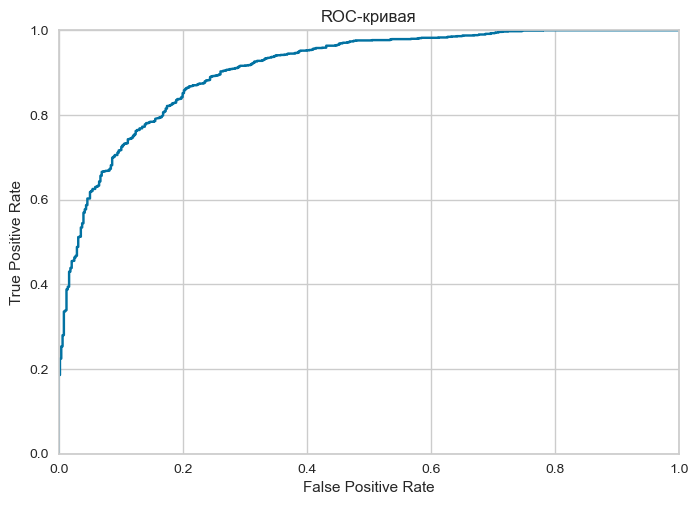

Показатели roc auc: 0.909339445035606


In [77]:
probabilities_test = cbc.predict_proba(X_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, probabilities_one_test)
plt.figure()
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show() 
auc_roc = roc_auc_score(y_test, probabilities_one_test)
print('Показатели roc auc:', auc_roc)

Рассмотрим распределение важности признаков.

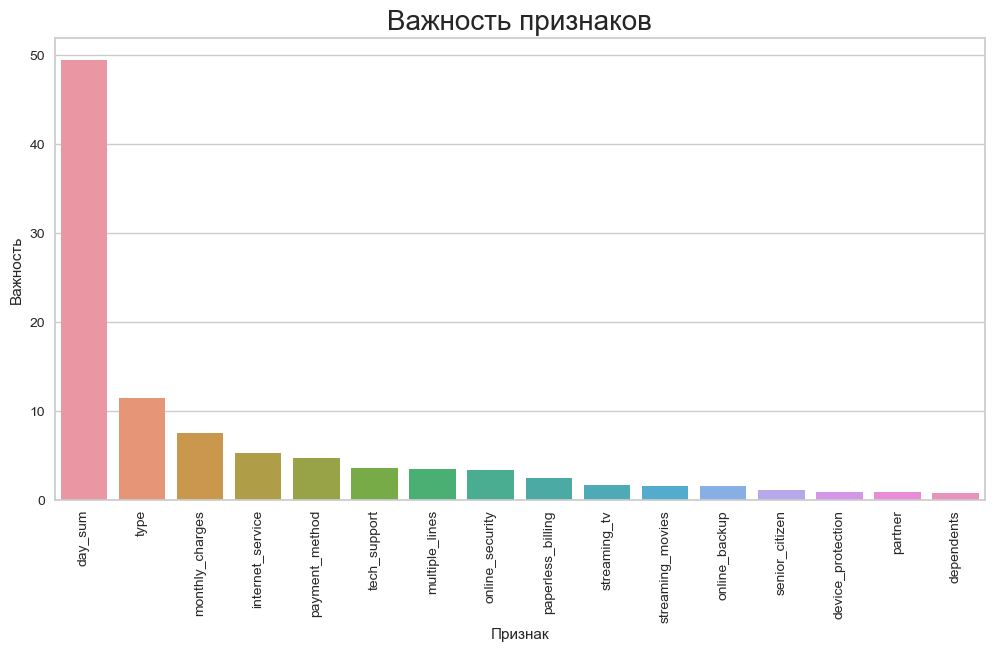

In [78]:
importances = pd.DataFrame(data={
          'Attribute': X_train.columns,
          'Importance':cbc.best_estimator_._final_estimator.feature_importances_
      })
importances = importances.sort_values(by='Importance', ascending=False)
plt.figure(figsize = (12,6))
sns.barplot(x=importances['Attribute'], y=importances['Importance'])
plt.title('Важность признаков', size=20)
plt.xticks(rotation='vertical')
plt.xlabel('Признак')
plt.ylabel('Важность')
plt.show()

В тройку самых важных признаков вошли:
- общее количество месяцев обслуживания
- тип заключаемого договора
- ежемесячные траты на услуги

## Итоги проверки лучшей модели машинного обучения 
Выбранная модель показала на тестовых данных результат roc_auc = 0.894686. Прочие характеристики свидетельствуют о том, что модель справляется с поставленой задачей: способную предсказать отток клиентов или лояльность клиентов.

Рассмотрено распределение важности признаков. 
В тройку самых важных признаков вошли:
- общее количество месяцев обслуживания
- тип заключаемого договора
- ежемесячные траты на услуги.
Данное распределение стоит использовать при планировании компаний по удержанию клиентов. Позволит выстроить приоритетность.

## Общий вывод

На этапе ознакомления с данными нами были рассмотрены 4 таблицы данных:


1 таблица - "Contract"
В данной таблице было 7043 наблюдения и 8 признаков(6 категориальных, 1 булевый, 1 числовой).Отсутствовали пропуски и дубликаты. Все значения customerID - уникальные. Заметили, что самый популярный тип оплаты -  ежемесячный; чаще всего пользователи предпочитают электронный платежный документ;  чаще всего пользователи предпочитают электронный платеж - как способ оплаты, cfvjt ,самое большое количество платежей в месяц - до 20$. 


2 таблица - "internet"
В данной таблице было 5517 наблюдения и 8 признаков(2 категориальных, 6 булевых).Отсутствовали пропуски и дубликаты. Все значения customerID - уникальные.Заметили, что ,более популярно оптоволокно среди пользователей интернета; чаще пользователи отказываются от блокировки небезопасных сайтов; чаще пользователи отказываются от облачных хранилищ файлов для резервного копирования данных, чаще пользователи отказываются от антивирусов, чаще пользователи отказываются от выделенной линии технической поддержки, пользователи не отдают предпочтений в использовании стримингового телевидения и каталогов фильмов.


3 таблица - "internet"
В данной таблице было 7043 наблюдения и 5 признаков(3 категориальных, 2 булевых).Отсутствовали пропуски и дубликаты. Все значения customerID - уникальные. Заметили, что в равной степени мужчины и женщины заключают договора; чаще пользователи не являются пенсионного возраста; чаще пользователи состоят в браке, чаще у пользователей нет иждивенцев.


4 таблица - "phone"
В данной таблице было 6361 наблюдения и 2 признака(1 категориальный, 1 булевый).Отсутствовали пропуски и дубликаты. Все значения customerID - уникальные. Заметили, что наличие возможности ведения параллельных линий во время звонка чаще не используется клиентами.


На этапе предобработки данных было выполнено:

1. преобразован стиль описания колонок. Использован змеиный стиль;
2. изменен тип данных в колонках: 'end_date', 'begin_date' на datetime64, 'total_charges' на числовой тип данных.
3. создали дополнительный признак - суммарное количество дней пользования услугами 'day_sum';
4. на основании данных в столбце 'end_date' определили целевой признак - лояльность клиентов - 'loyalty'. Если договор с клиентом не расторгнут, на момент даты последней актуализации данных, значит клиент лоялен;
5. удалили признаки, которые больше не потребуются для дальнейшей работы: признаки образовавшиеся при создании признаков 'months_sum' и 'loyalty';
6. все таблицы данных были объединены по общему признаку для всех колонок - 'customer_id';
7. были выявлены пропуски в данных. Для пропусков, которые образовались из-за того,что не все пользователи подключали интернет-услуги мы указали 'No internet service'. Для пропусков, которые  образовались из-за того,что не все пользователи подключили возможность ведения параллельных линий во время звонка указали  -  'No phone service'.Проверка на наличие дубликатов показала отсутствие дубликатов;
8. удалили признак 'customer_id', так как он больше не потребуется для дальнейшей работы;
9. проверка на мультиколлениарность показала, высокую корреляцию столбца monthly_charges и total_charges. Оставили признак monthly_charges. Признак 'gender' практически не влиял на целевой признак и принято было решение удалить его.


В результате исследовательского анализа были сделаны следующие наблюдения:

1. распределение лояльности клиентов показало, что 26,6 процентов клиентов не лояльны. Нашей задачей является своевременное выявление данной категории клиентов, чтобы удержать пользователей и не потерять их;
2. распределение лояльности, относительно периода пользования услугами показало, что для лояльно настроенных клиентов характерна предсказуемость: клиенты остаются на длительный срок. Для клиентов настроенных не лояльно характерен достаточно короткий срок принятия решения о том будут они продолжать пользоваться услугами. В среднем, пользователи понимают это за 10 месяцев;
3. влияние типа оплаты на лояльность клиента показала, что большее количество не лояльных клиентов заключает договора на месяц. Клиенты, которые выбирают заключение договора на более длительный срок реже становятся не лояльными к услугам компании;
4. влияние наличия пенсионного статуса по возрасту на лояльность показало, что люди пенсионного возраста чаще оказываются не лояльны;
5. влияние наличия электронного платежного документа на лояльность пользователей показало, что больше процент не лояльных пользователей со стороны тех, кто получает электронный платежный документ;
6. влияние способа оплаты на лояльность пользователей показало, что меньше всего пользователи лояльны к способу оплаты по средствам электронного чека. Самый высокий уровень лояльности среди пользователей наблюдается у способа оплаты - автоплатеж по кредитной карте;
7. влияние семейного положения на лояльность пользователей показало, что более лояльно настроены пользователи, состоящие в браке;
8. влияние наличия иждивенцев на лояльность пользователей показало, что среди пользователей у которых нет иждивенцев наблюдается меньшая лояльность к услугам компании;
9. распределение лояльности среди клиентов, пользующихся интернетом показало, что лояльность пользователей ниже среди тех, у кого подключение к интернету осуществляется по средствам оптоволокна. Среди прочих признаков, связанных с интернет-услугами: online_security, online_backup, device_protection, tech_support, streaming_tv, streaming_movies видим,  что менее лояльны те клиенты кто не пользуется данными услугами. Более лояльны клиенты не использующие интернет.;
10. распределение лояльности от наличия возможности ведения параллельных линий во время звонка показало, что лояльность пользователей практически не зависит от возможности ведения параллельных линий во время звонка. Чуть меньше лояльности среди тех пользователей, которые используют ведения параллельных линий во время звонка;
11. распределение ежемесячных платежей от лояльности пользователей показало, что более высокий процент не лояльных клиентов при высокой ежемесячной плате.


В результате подготовки данных к обучению мы разделили данные на выборки.

Нами были обучены следующие модели машинного обучения:
- Logistic Regression
- Random Forest
- CatBoost
- LGBM
Были получены следующие результаты целевой метрики:

In [79]:
res

name_model  best score
0             logistic_regression    0.840843
1  Random_Forest_Classifier_tuned    0.853990
2                        CatBoost    0.894686
3                             LGB    0.843861

Лучший результат показала модель CatBoost c результатом roc_auc = 0.894686. Параметры модели: random_state=RANDOM_STATE, auto_class_weights='Balanced', cbc__depth = 6, cbc__iterations = 250,cbc__learning_rate = 0.1, cbc__loss_function = 'Logloss'.


Выбранная модель показала на тестовых данных результат roc_auc =0.909339. Прочие характеристики свидетельствуют о том, что модель справляется с поставленой задачей: способна предсказать отток клиентов или лояльность клиентов.

In [80]:
fnl

roc_auc  accuracy  f1_score  precision    recall   quality
0  0.909339  0.839296  0.885933   0.919665  0.854588  0.894686

Рассмотрено распределение важности признаков. 
В тройку самых важных признаков вошли:
- общее количество месяцев обслуживания
- тип заключаемого договора
- ежемесячные траты на услуги.
Данное распределение стоит использовать при планировании компаний по удержанию клиентов. Позволит выстроить приоритетность.

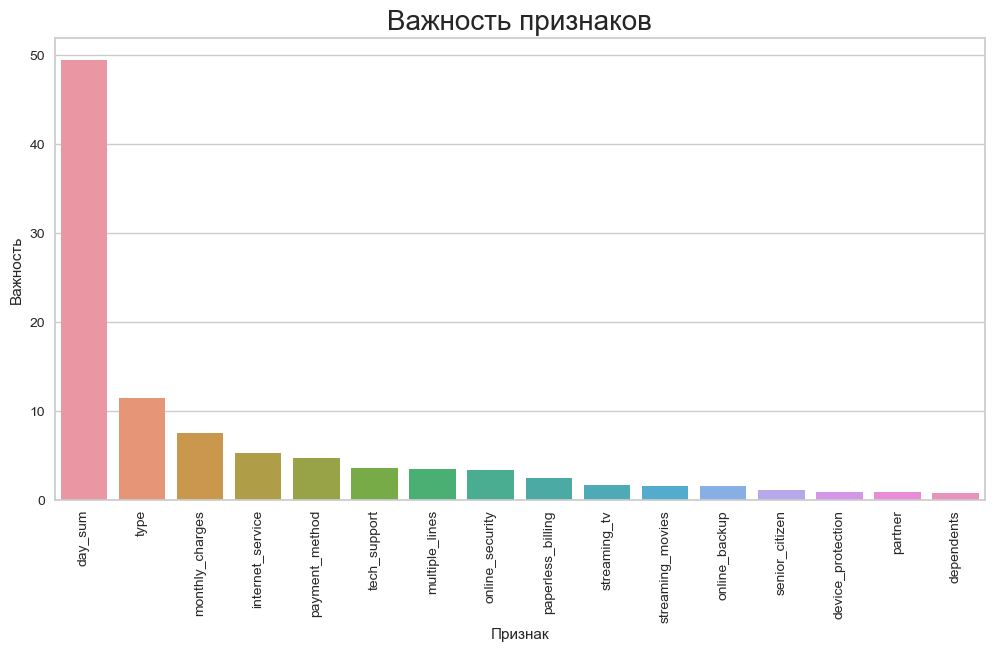

In [81]:
importances = pd.DataFrame(data={
          'Attribute': X_train.columns,
          'Importance':cbc.best_estimator_._final_estimator.feature_importances_
      })
importances = importances.sort_values(by='Importance', ascending=False)
plt.figure(figsize = (12,6))
sns.barplot(x=importances['Attribute'], y=importances['Importance'])
plt.title('Важность признаков', size=20)
plt.xticks(rotation='vertical')
plt.xlabel('Признак')
plt.ylabel('Важность')
plt.show()

В результате проделанной работы мы:
- определили факторы, которые влияют на лояльность клиентов; 
- обучили модель машинного обучения, способную предсказать отток клиентов.

**Какие пункты плана были выполнены, а какие — нет. Почему?**

Были выолнены все пункты плана за исключением формирования дополнительного признака - периода пользования услугами. Планировалось рассчитывать данный признак как суммарное количество месяцев пользования услугами, но  было принято решение рассчитывсть как суммарное колличество дней. 


**Какие трудности возникли и как вы их преодолели?**
При первичном рассчете метрик с использованием дополнительного признака - суммарное колличество дней, качество обучения моделей было достаточно низким. Для этого было принято решение рассчитать период пользования услугами как суммарное колличество дней, что позволило выявить большее количество взаимосвязей и лучше обучить модели.

Для кодирования данных при обучении моделей было принято решение отказаться от использования get_dummies в пользу OneHotEncoder, что позволило сразу добавить в пайплайны кодирование данных и измбежать ошибок.


**Какие ключевые шаги в решении задачи вы выделили?**

1. Обзор данных. На этом этапе был проведены обзор и оценка качества данных.
2. Предобработка данных. На данном этапе мы:
    - привели данные к требуемому формату, 
    - привели описание колонок к змеиному стилю,
    - создали дополнительный признак - суммарное количество дней пользования услугами,
    - создали целевой признак - лояльность клиентов(если договор не расторгнут - клиент лоялен),
    - удалили лишние признаки,
    - объединили все татбицы в одну,
    - проверили таблицу на наличие пропусков и дубликатов,
    - удалили customerID(н не потребуется для дальейшего исследования)
    - проверили признаки на мультиколлениарность.
3. Проведение исследовательского анализа: рассмотрели, какие признаки влияют на целевой признак - лояльность клиентов, рассмотрели, какие есть тенденции и закономерности.
4. Определили целевую метрику качества  - roc auc и подготовили данные к обучению. Выдели модели машинного обучения, которые были использованы для решения задачи классификации:
- Logistic Regression
- Random Forest
- CatBoost
- LGBM.
5. Обучили модели машинного обучения.
6. Проверили лучшую модель машинного обучения на тестовых данных. Подвели итоги.

**Какие признаки использовали для обучения модели и какая предобработка этих признаков была выполнена?**

Для обучения моделей были использованы следующие признаки:
- type	
- paperless_billing	
- payment_method	
- monthly_charges	
- day_sum	
- senior_citizen	
- partner	
- dependents	
- multiple_lines	
- internet_service	
- online_security	
- online_backup	
- device_protection	
- tech_support	
- streaming_tv	
- streaming_movies


Целевой признак:
- loyalty	


На этапе предобработки данных было выполнено:
1. преобразован стиль описания колонок. Использован змеиный стиль;
2. изменен тип данных в колонках: 'end_date', 'begin_date' на datetime64, 'total_charges' на числовой тип данных.
3. создали дополнительный признак - суммарное количество дней пользования услугами 'day_sum';
4. на основании данных в столбце 'end_date' определили целевой признак - лояльность клиентов - 'loyalty'. Если договор с клиентом не расторгнут, на момент даты последней актуализации данных, значит клиент лоялен;
5. удалили признаки, которые больше не потребуются для дальнейшей работы: признаки образовавшиеся при создании признаков 'months_sum' и 'loyalty';
6. все таблицы данных были объединены по общему признаку для всех колонок - 'customer_id';
7. были выявлены пропуски в данных. Для пропусков, которые образовались из-за того,что не все пользователи подключали интернет-услуги мы указали 'No internet service'. Для пропусков, которые  образовались из-за того,что не все пользователи подключили возможность ведения параллельных линий во время звонка указали  -  'No phone service'.Проверка на наличие дубликатов показала отсутствие дубликатов;
8. удалили признак 'customer_id', так как он больше не потребуется для дальнейшей работы;
9. проверка на мультиколлениарность показала, высокую корреляцию столбца monthly_charges и total_charges. Оставили признак monthly_charges. Признак 'gender' практически не влиял на целевой признак и принято было решение удалить его.

**Какая ваша итоговая модель, какие у неё гиперпараметы и какое качество?**

Модель CatBoost


Параметры модели: 
- random_state=270323, 
- auto_class_weights='Balanced', 
- depth = 6 , 
- iterations = 250,
- learning_rate = 0.1, 
- loss_function = 'Logloss'.


Качество модели:

In [82]:
fnl

roc_auc  accuracy  f1_score  precision    recall   quality
0  0.909339  0.839296  0.885933   0.919665  0.854588  0.894686